In [16]:
# standard imports and setup 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import scipy
import re

# data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

# machine learning
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # Regresion Logistica
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
import optuna

# model evaluation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
#================= data===========================#
df = pd.read_csv('../data/bank-additional-full.csv',sep = ';')
df

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
0      telephone   may         mon  ...         1    999         0   
1      telephone   may         mon  ...         1    999         0   
2      telephone   may         mon  ...         1    999         0   
3      telephone   may         mon  ...         1    999         0   
4      telephone   may         mon  ...         1    999         0   
...          ...   ...         ...  ...       ...    ...       ...   
41183   cellular   nov         fri  ...         1    999         0   
41184   cellular   nov         fri  ...         1    999         0   
41185   cellular   nov         fri  ...         2    999         0   
41186   cellular   nov         fri  ...         1    999         0   
41187   cellular   nov         fri  ...         3    999         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [13]:
#================================ GET X AND Y ==================================#
def data_trasnform(df: pd.DataFrame,smote = False):
    '''
        this function apply encoding, standar scaler , split 
        independent variabe and dependet variable and SMOTE
        
        inputs:
            df: pd.DataFrame
            smote: default False
    '''
    
    # ============== Feature engeniering======================#
    df['age_group'] =  pd.cut(x=df['age'], bins=[15,30,40,50,60,100],\
                    labels= ['15-30' , '30 -40' , '40 - 50', '50 - 60' , '60 - mas'])
    
    #===============One Hot Encoding=======================#
    df=pd.get_dummies(data=df, drop_first=True)
    
    # ============== STANDARD SCALER=======================#
    scaler = StandardScaler()
    df_scaler = scaler.fit_transform(df)
    df_scaler = pd.DataFrame(df_scaler, columns=df.columns)
    
    def change_target(x):
        '''
        Transforma la variable target en 0 y 1 luego del Scaler
        '''
        if x < 0:
            return 0
        else:
            return 1
    
    df_scaler['y_yes'] = df_scaler['y_yes'].apply(change_target)
    
    # =====split dependent and independent feature===========# 
    X = df_scaler.loc[:,df.columns != 'y_yes'].values
    y = df_scaler.loc[:,'y_yes'].values
    
    #=========== Synthetic Minority Oversamping Technique=============#
    if smote:
        
        #CLASS RATIO TARGET DATASET
        original_ = sum(df['y_yes'])/len(df['y_yes'])
        #print('Class Ratio 1 ORIGINAL',original_)
        
        sm = SMOTE()
        X, y = sm.fit_resample(X, y)
        print('X.shape:',X.shape,'y.shape:',y.shape)
        
    return X, y

def plot_matrix(clf,X,y):
    name_model = str(type(clf))
    regex_model = "'(.*)'"
    color = 'black'
    name_model = re.search(regex_model,name_model).group(1)
    matrix = plot_confusion_matrix(clf, X, y, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix - {}'.format(name_model), color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    return plt.show()

def classifier_SKF(clf,X,y, n_splits = 10):
    
    skf = StratifiedKFold(n_splits=n_splits)

    balanced_accuracy_score_list = []
    accuracy_score_list = []
    roc_auc_score_list = []
    f1_score_list = []
    precision_score_list = []
    recall_score_list = []

    for idx in skf.split(X, y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = X[train_idx]
        ytrain = y[train_idx]

        xtest = X[test_idx]
        ytest = y[test_idx]

        clf.fit(xtrain,ytrain)
        preds = clf.predict(xtest)

        #===============balance_accuracy_score=========#
        fold_acc = balanced_accuracy_score(ytest, preds)
        balanced_accuracy_score_list.append(fold_acc)

        #==============Accuracy_score==================#
        fold_acc = accuracy_score(ytest, preds)
        accuracy_score_list.append(fold_acc)

        #=================roc_auc_score================#
        fold_acc = roc_auc_score(ytest, preds,multi_class='ovr')
        roc_auc_score_list.append(fold_acc)

        #==================f1_score====================#
        fold_acc = f1_score(ytest, preds)
        f1_score_list.append(fold_acc)

        #==============precision_score=================#
        fold_acc = precision_score(ytest, preds)
        precision_score_list.append(fold_acc)

        #================recall_score==================#
        fold_acc = recall_score(ytest, preds)
        recall_score_list.append(fold_acc)


    # ======================= Metrics======================================#    
    balance_accuracy_score_ = scipy.stats.gmean(balanced_accuracy_score_list)

    accuracy_score_ = scipy.stats.gmean(accuracy_score_list)

    roc_auc_score_ = scipy.stats.gmean(roc_auc_score_list)

    f1_score_ = scipy.stats.gmean(f1_score_list)

    precision_score_ = scipy.stats.gmean(precision_score_list)

    recall_score_ = scipy.stats.gmean(recall_score_list)

    data = [['balance_accuracy_score',balance_accuracy_score_],
            ['accuracy_score',accuracy_score_],
            ['roc_auc_score',roc_auc_score_],
            ['f1_score',f1_score_],
            ['precision_score',precision_score_],
            ['recall_score',recall_score_]]
    columns = ['Metrics','Values']
    df = pd.DataFrame(data = data, columns=columns)
    display(df)
    
    #print confusion matrix
    plot_matrix(clf,X,y)   
    return clf


X.shape: (73096, 57) y.shape: (73096,)


Metrics    Values
0  balance_accuracy_score  0.835695
1          accuracy_score  0.835696
2           roc_auc_score  0.835695
3                f1_score  0.864489
4         precision_score  0.809564
5            recall_score  0.948336

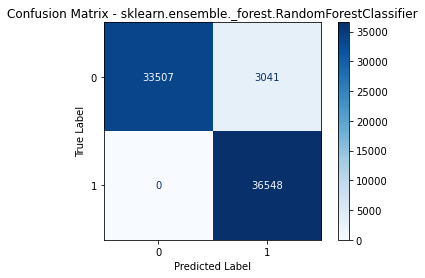

In [143]:
X,y = data_trasnform(df,smote=True)
#==========RandomForestClassifier========#
clf_rf = RandomForestClassifier()
clf_rf = classifier_SKF(clf_rf,X,y)

In [144]:
predict  = clf_rf.predict(X)
print(classification_report(y,predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     36548
           1       0.92      1.00      0.96     36548

    accuracy                           0.96     73096
   macro avg       0.96      0.96      0.96     73096
weighted avg       0.96      0.96      0.96     73096



<AxesSubplot:>

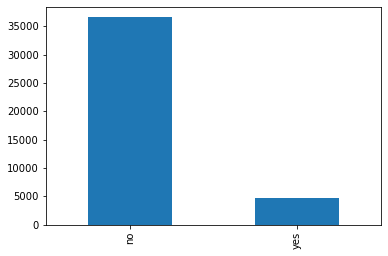

In [23]:
df['y'].value_counts().plot(kind= 'bar')

In [29]:
X,y = data_trasnform(df,smote=True)

X.shape: (73096, 57) y.shape: (73096,)


<AxesSubplot:xlabel='0'>

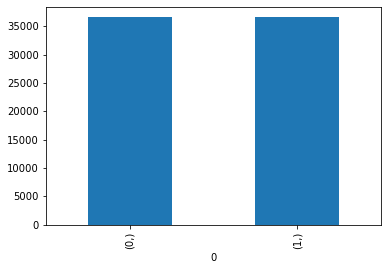

In [40]:
pd.DataFrame(y).value_counts().plot(kind = 'bar')

In [57]:
X,y = data_trasnform(df,smote=False)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [59]:
log_class = LogisticRegression()

Metrics    Values
0  balance_accuracy_score  0.544122
1          accuracy_score  0.741403
2           roc_auc_score  0.544122
3                f1_score  0.206162
4         precision_score  0.376283
5            recall_score  0.185781

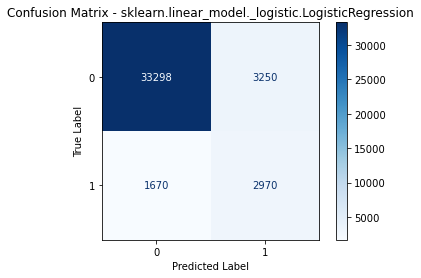

LogisticRegression()

In [60]:
log_class = classifier_SKF(log_class,X,y)
log_class

In [61]:
predict = log_class.predict(X)
predict

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [64]:
print(confusion_matrix(y,predict))
print(accuracy_score(y,predict))
print(classification_report(y,predict))

[[33298  3250]
 [ 1670  2970]]
0.8805477323492279
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     36548
           1       0.48      0.64      0.55      4640

    accuracy                           0.88     41188
   macro avg       0.71      0.78      0.74     41188
weighted avg       0.90      0.88      0.89     41188



In [66]:
from collections import Counter

In [93]:
df=pd.get_dummies(data=df, drop_first=True)
df.head(2)

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  month_nov  month_oct  \
0          -36.4      4.857       5191.0  ...          0          0   
1          -36.4      4.857       5191.0  ...          0          0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0          0                1                0                0   
1          0                1                0                0   

   day_of_week_wed  poutcome_nonexistent  poutcome_success  y_yes  
0                0                     1                 0      0  
1                0                     1                 0      0  

[2 rows x 54 columns]

In [38]:
X = df.drop('y_yes', axis = 1).values
y = df['y_yes']

KeyError: "['y_yes'] not found in axis"

In [139]:
counter = Counter(y)
for k,v in counter.items():
    dist = v/len(y) * 100
    print(f'class={k}, n= {v} ({dist})%')

class=0, n= 36548 (88.73458288821988)%
class=1, n= 4640 (11.265417111780131)%


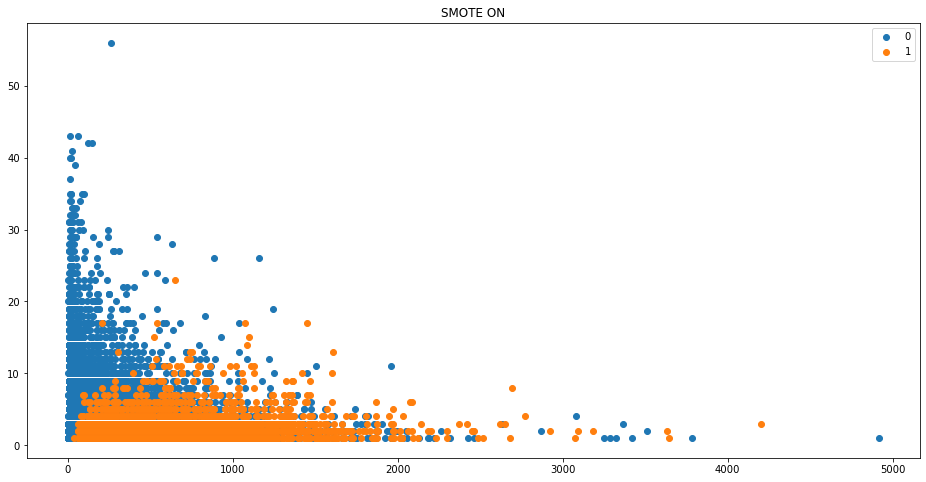

In [141]:
plt.figure(1,figsize=(16,8))
for label,_ in counter.items():
    row = np.where(y == label)[0]
    plt.scatter(X[row,1], X[row,2],label = str(label))
plt.legend()
plt.title('SMOTE OFF')
plt.show()

In [113]:
counter = Counter(y)
for k,v in counter.items():
    dist = v/len(y) * 100
    print(f'class={k}, n= {v} ({dist})%')

class=0, n= 36548 (50.0)%
class=1, n= 36548 (50.0)%


class=0, n= 36548 (50.0)%
class=1, n= 36548 (50.0)%


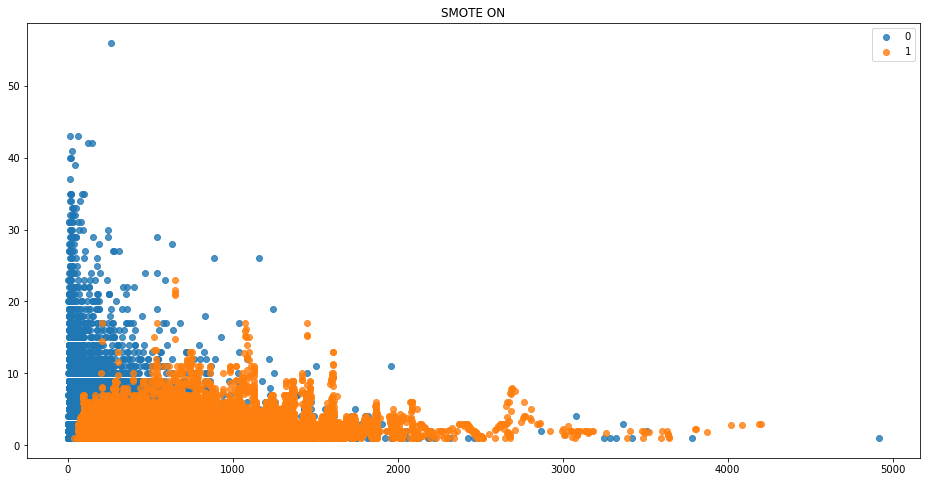

In [127]:
smote = SMOTE()
X,y = smote.fit_resample(X,y)

counter = Counter(y)
for k,v in counter.items():
    dist = v/len(y) * 100
    print(f'class={k}, n= {v} ({dist})%')
    
plt.figure(1,figsize=(16,8))
for label,_ in counter.items():
    row = np.where(y == label)[0]
    plt.scatter(X[row,1], X[row,2],label = str(label),alpha=0.8)
plt.legend()
plt.title('SMOTE ON')
plt.show()

In [21]:
X,y = data_trasnform(df, smote=False)

In [20]:
with open('../best_params_models/random_forest_params.json', 'r') as openfile:
    random_forest_params = json.load(openfile)
print('random_forest_params:  ',random_forest_params)

with open('../best_params_models/xg_boost_params.json', 'r') as openfile:
    xg_boost_params = json.load(openfile)
print('xg_boost_params:  ',xg_boost_params)

random_forest_params:   {'n_estimators': 989, 'max_depth': 24, 'min_samples_split': 42, 'min_samples_leaf': 19}
xg_boost_params:   {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 300, 'lambda': 1.0817334952464273, 'alpha': 0.06348329291978623, 'colsample_bytree': 1.0, 'n_estimators': 5204, 'tree_method': 'gpu_hist'}


Metrics    Values
0  balance_accuracy_score  0.544122
1          accuracy_score  0.741403
2           roc_auc_score  0.544122
3                f1_score  0.206162
4         precision_score  0.376283
5            recall_score  0.185781

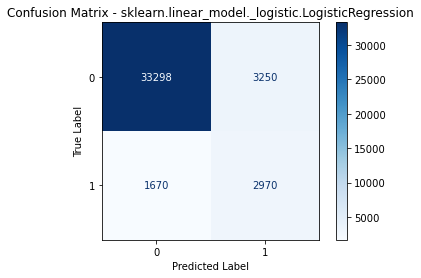

Metrics    Values
0  balance_accuracy_score  0.484540
1          accuracy_score  0.710228
2           roc_auc_score  0.484540
3                f1_score  0.000000
4         precision_score  0.000000
5            recall_score  0.000000

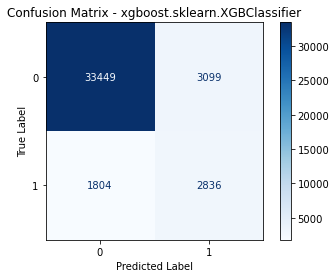

Metrics    Values
0  balance_accuracy_score  0.462453
1          accuracy_score  0.699797
2           roc_auc_score  0.462453
3                f1_score  0.000000
4         precision_score  0.000000
5            recall_score  0.000000

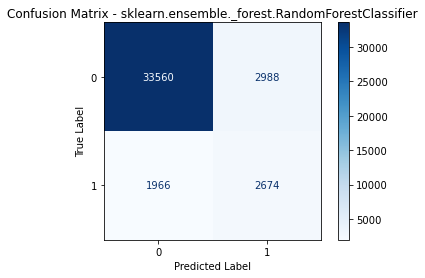

Metrics    Values
0  balance_accuracy_score  0.524910
1          accuracy_score  0.803683
2           roc_auc_score  0.524910
3                f1_score  0.073149
4         precision_score  0.206066
5            recall_score  0.058154

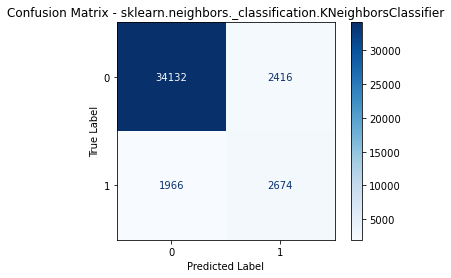

Metrics    Values
0  balance_accuracy_score  0.481800
1          accuracy_score  0.725742
2           roc_auc_score  0.481800
3                f1_score  0.045850
4         precision_score  0.101787
5            recall_score  0.041894

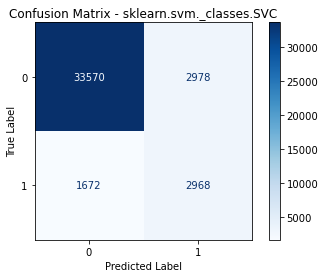

Metrics    Values
0  balance_accuracy_score  0.594330
1          accuracy_score  0.528119
2           roc_auc_score  0.594330
3                f1_score  0.257656
4         precision_score  0.208618
5            recall_score  0.520556

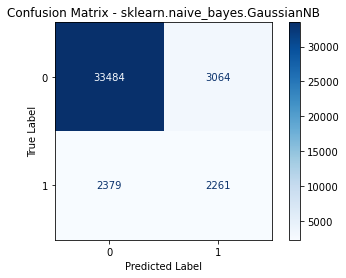

Learning rate set to 0.048184
0:	learn: 0.6021453	total: 151ms	remaining: 2m 30s
1:	learn: 0.5434878	total: 159ms	remaining: 1m 19s
2:	learn: 0.4757751	total: 167ms	remaining: 55.4s
3:	learn: 0.4324579	total: 175ms	remaining: 43.5s
4:	learn: 0.4029116	total: 183ms	remaining: 36.4s
5:	learn: 0.3703588	total: 191ms	remaining: 31.6s
6:	learn: 0.3458172	total: 198ms	remaining: 28.1s
7:	learn: 0.3191582	total: 206ms	remaining: 25.5s
8:	learn: 0.3045371	total: 214ms	remaining: 23.5s
9:	learn: 0.2916215	total: 222ms	remaining: 21.9s
10:	learn: 0.2791558	total: 229ms	remaining: 20.6s
11:	learn: 0.2652281	total: 237ms	remaining: 19.5s
12:	learn: 0.2544621	total: 245ms	remaining: 18.6s
13:	learn: 0.2478162	total: 252ms	remaining: 17.8s
14:	learn: 0.2414073	total: 260ms	remaining: 17.1s
15:	learn: 0.2363107	total: 268ms	remaining: 16.5s
16:	learn: 0.2315136	total: 276ms	remaining: 15.9s
17:	learn: 0.2275609	total: 283ms	remaining: 15.4s
18:	learn: 0.2234342	total: 291ms	remaining: 15s
19:	learn: 

170:	learn: 0.1600292	total: 1.46s	remaining: 7.06s
171:	learn: 0.1599988	total: 1.46s	remaining: 7.04s
172:	learn: 0.1599735	total: 1.47s	remaining: 7.03s
173:	learn: 0.1598695	total: 1.48s	remaining: 7.02s
174:	learn: 0.1597856	total: 1.49s	remaining: 7s
175:	learn: 0.1597353	total: 1.49s	remaining: 6.99s
176:	learn: 0.1596311	total: 1.5s	remaining: 6.97s
177:	learn: 0.1595452	total: 1.51s	remaining: 6.96s
178:	learn: 0.1595019	total: 1.51s	remaining: 6.94s
179:	learn: 0.1594332	total: 1.52s	remaining: 6.93s
180:	learn: 0.1593700	total: 1.53s	remaining: 6.91s
181:	learn: 0.1592605	total: 1.53s	remaining: 6.9s
182:	learn: 0.1592115	total: 1.54s	remaining: 6.88s
183:	learn: 0.1591010	total: 1.55s	remaining: 6.87s
184:	learn: 0.1590094	total: 1.56s	remaining: 6.86s
185:	learn: 0.1589214	total: 1.56s	remaining: 6.84s
186:	learn: 0.1588394	total: 1.57s	remaining: 6.83s
187:	learn: 0.1587142	total: 1.58s	remaining: 6.81s
188:	learn: 0.1586360	total: 1.58s	remaining: 6.8s
189:	learn: 0.1585

336:	learn: 0.1489065	total: 2.73s	remaining: 5.37s
337:	learn: 0.1488547	total: 2.74s	remaining: 5.36s
338:	learn: 0.1487997	total: 2.75s	remaining: 5.36s
339:	learn: 0.1487430	total: 2.75s	remaining: 5.35s
340:	learn: 0.1487097	total: 2.76s	remaining: 5.34s
341:	learn: 0.1486778	total: 2.77s	remaining: 5.33s
342:	learn: 0.1486409	total: 2.78s	remaining: 5.32s
343:	learn: 0.1485885	total: 2.79s	remaining: 5.31s
344:	learn: 0.1485330	total: 2.79s	remaining: 5.3s
345:	learn: 0.1484872	total: 2.8s	remaining: 5.29s
346:	learn: 0.1484675	total: 2.81s	remaining: 5.28s
347:	learn: 0.1484189	total: 2.81s	remaining: 5.28s
348:	learn: 0.1483732	total: 2.82s	remaining: 5.27s
349:	learn: 0.1483153	total: 2.83s	remaining: 5.26s
350:	learn: 0.1482530	total: 2.84s	remaining: 5.25s
351:	learn: 0.1481887	total: 2.84s	remaining: 5.24s
352:	learn: 0.1481627	total: 2.85s	remaining: 5.23s
353:	learn: 0.1481258	total: 2.86s	remaining: 5.22s
354:	learn: 0.1480649	total: 2.87s	remaining: 5.21s
355:	learn: 0.

509:	learn: 0.1406304	total: 4.01s	remaining: 3.85s
510:	learn: 0.1405876	total: 4.02s	remaining: 3.85s
511:	learn: 0.1405495	total: 4.03s	remaining: 3.84s
512:	learn: 0.1405013	total: 4.03s	remaining: 3.83s
513:	learn: 0.1404537	total: 4.04s	remaining: 3.82s
514:	learn: 0.1404095	total: 4.06s	remaining: 3.83s
515:	learn: 0.1403597	total: 4.07s	remaining: 3.82s
516:	learn: 0.1402985	total: 4.08s	remaining: 3.81s
517:	learn: 0.1402292	total: 4.09s	remaining: 3.8s
518:	learn: 0.1401565	total: 4.09s	remaining: 3.79s
519:	learn: 0.1401325	total: 4.1s	remaining: 3.79s
520:	learn: 0.1400707	total: 4.11s	remaining: 3.78s
521:	learn: 0.1400278	total: 4.12s	remaining: 3.77s
522:	learn: 0.1399801	total: 4.12s	remaining: 3.76s
523:	learn: 0.1399286	total: 4.13s	remaining: 3.75s
524:	learn: 0.1398750	total: 4.14s	remaining: 3.75s
525:	learn: 0.1398477	total: 4.15s	remaining: 3.74s
526:	learn: 0.1398023	total: 4.16s	remaining: 3.73s
527:	learn: 0.1397523	total: 4.16s	remaining: 3.72s
528:	learn: 0.

678:	learn: 0.1331119	total: 5.28s	remaining: 2.5s
679:	learn: 0.1330728	total: 5.29s	remaining: 2.49s
680:	learn: 0.1330445	total: 5.3s	remaining: 2.48s
681:	learn: 0.1329797	total: 5.31s	remaining: 2.47s
682:	learn: 0.1329554	total: 5.31s	remaining: 2.46s
683:	learn: 0.1329203	total: 5.32s	remaining: 2.46s
684:	learn: 0.1328832	total: 5.33s	remaining: 2.45s
685:	learn: 0.1328401	total: 5.33s	remaining: 2.44s
686:	learn: 0.1327699	total: 5.34s	remaining: 2.43s
687:	learn: 0.1327384	total: 5.35s	remaining: 2.42s
688:	learn: 0.1327168	total: 5.36s	remaining: 2.42s
689:	learn: 0.1326692	total: 5.36s	remaining: 2.41s
690:	learn: 0.1326197	total: 5.37s	remaining: 2.4s
691:	learn: 0.1325995	total: 5.38s	remaining: 2.39s
692:	learn: 0.1325242	total: 5.38s	remaining: 2.38s
693:	learn: 0.1324496	total: 5.39s	remaining: 2.38s
694:	learn: 0.1324089	total: 5.4s	remaining: 2.37s
695:	learn: 0.1323605	total: 5.4s	remaining: 2.36s
696:	learn: 0.1323472	total: 5.41s	remaining: 2.35s
697:	learn: 0.132

853:	learn: 0.1266994	total: 6.57s	remaining: 1.12s
854:	learn: 0.1266477	total: 6.57s	remaining: 1.11s
855:	learn: 0.1266132	total: 6.58s	remaining: 1.11s
856:	learn: 0.1265815	total: 6.59s	remaining: 1.1s
857:	learn: 0.1265471	total: 6.59s	remaining: 1.09s
858:	learn: 0.1265213	total: 6.6s	remaining: 1.08s
859:	learn: 0.1264723	total: 6.61s	remaining: 1.07s
860:	learn: 0.1264405	total: 6.62s	remaining: 1.07s
861:	learn: 0.1263745	total: 6.62s	remaining: 1.06s
862:	learn: 0.1263455	total: 6.63s	remaining: 1.05s
863:	learn: 0.1263211	total: 6.63s	remaining: 1.04s
864:	learn: 0.1262985	total: 6.64s	remaining: 1.04s
865:	learn: 0.1262461	total: 6.65s	remaining: 1.03s
866:	learn: 0.1262173	total: 6.66s	remaining: 1.02s
867:	learn: 0.1261775	total: 6.66s	remaining: 1.01s
868:	learn: 0.1261484	total: 6.67s	remaining: 1s
869:	learn: 0.1260758	total: 6.68s	remaining: 998ms
870:	learn: 0.1260456	total: 6.68s	remaining: 990ms
871:	learn: 0.1260061	total: 6.69s	remaining: 982ms
872:	learn: 0.125

25:	learn: 0.2048734	total: 181ms	remaining: 6.79s
26:	learn: 0.2034927	total: 188ms	remaining: 6.79s
27:	learn: 0.2018294	total: 196ms	remaining: 6.79s
28:	learn: 0.1997069	total: 202ms	remaining: 6.77s
29:	learn: 0.1985213	total: 210ms	remaining: 6.78s
30:	learn: 0.1976858	total: 217ms	remaining: 6.77s
31:	learn: 0.1958683	total: 224ms	remaining: 6.77s
32:	learn: 0.1939466	total: 231ms	remaining: 6.76s
33:	learn: 0.1931517	total: 238ms	remaining: 6.76s
34:	learn: 0.1922804	total: 245ms	remaining: 6.74s
35:	learn: 0.1909517	total: 251ms	remaining: 6.73s
36:	learn: 0.1905266	total: 258ms	remaining: 6.72s
37:	learn: 0.1895198	total: 265ms	remaining: 6.71s
38:	learn: 0.1887049	total: 272ms	remaining: 6.71s
39:	learn: 0.1872969	total: 279ms	remaining: 6.7s
40:	learn: 0.1869469	total: 286ms	remaining: 6.7s
41:	learn: 0.1863413	total: 293ms	remaining: 6.69s
42:	learn: 0.1860425	total: 300ms	remaining: 6.67s
43:	learn: 0.1847369	total: 307ms	remaining: 6.67s
44:	learn: 0.1844341	total: 315ms

194:	learn: 0.1606413	total: 1.46s	remaining: 6.04s
195:	learn: 0.1605509	total: 1.47s	remaining: 6.03s
196:	learn: 0.1604851	total: 1.48s	remaining: 6.02s
197:	learn: 0.1604491	total: 1.48s	remaining: 6.01s
198:	learn: 0.1603962	total: 1.49s	remaining: 6s
199:	learn: 0.1603393	total: 1.5s	remaining: 6s
200:	learn: 0.1602643	total: 1.51s	remaining: 5.99s
201:	learn: 0.1601761	total: 1.51s	remaining: 5.98s
202:	learn: 0.1601216	total: 1.52s	remaining: 5.98s
203:	learn: 0.1600522	total: 1.53s	remaining: 5.97s
204:	learn: 0.1600128	total: 1.54s	remaining: 5.96s
205:	learn: 0.1599288	total: 1.55s	remaining: 5.96s
206:	learn: 0.1598516	total: 1.55s	remaining: 5.95s
207:	learn: 0.1597737	total: 1.56s	remaining: 5.95s
208:	learn: 0.1597121	total: 1.57s	remaining: 5.94s
209:	learn: 0.1596849	total: 1.58s	remaining: 5.93s
210:	learn: 0.1596417	total: 1.58s	remaining: 5.93s
211:	learn: 0.1595704	total: 1.59s	remaining: 5.92s
212:	learn: 0.1594730	total: 1.6s	remaining: 5.92s
213:	learn: 0.159415

358:	learn: 0.1500349	total: 2.78s	remaining: 4.97s
359:	learn: 0.1499628	total: 2.79s	remaining: 4.96s
360:	learn: 0.1498961	total: 2.81s	remaining: 4.97s
361:	learn: 0.1498479	total: 2.82s	remaining: 4.96s
362:	learn: 0.1498041	total: 2.83s	remaining: 4.96s
363:	learn: 0.1497434	total: 2.83s	remaining: 4.95s
364:	learn: 0.1496916	total: 2.84s	remaining: 4.94s
365:	learn: 0.1496585	total: 2.85s	remaining: 4.93s
366:	learn: 0.1496060	total: 2.85s	remaining: 4.92s
367:	learn: 0.1495722	total: 2.86s	remaining: 4.92s
368:	learn: 0.1495087	total: 2.87s	remaining: 4.91s
369:	learn: 0.1494713	total: 2.88s	remaining: 4.9s
370:	learn: 0.1494136	total: 2.88s	remaining: 4.89s
371:	learn: 0.1493507	total: 2.89s	remaining: 4.88s
372:	learn: 0.1492930	total: 2.9s	remaining: 4.87s
373:	learn: 0.1492576	total: 2.9s	remaining: 4.86s
374:	learn: 0.1491960	total: 2.91s	remaining: 4.85s
375:	learn: 0.1491066	total: 2.92s	remaining: 4.85s
376:	learn: 0.1490775	total: 2.93s	remaining: 4.84s
377:	learn: 0.1

531:	learn: 0.1412407	total: 4.06s	remaining: 3.57s
532:	learn: 0.1412065	total: 4.07s	remaining: 3.56s
533:	learn: 0.1411476	total: 4.08s	remaining: 3.56s
534:	learn: 0.1411351	total: 4.08s	remaining: 3.55s
535:	learn: 0.1410832	total: 4.09s	remaining: 3.54s
536:	learn: 0.1410379	total: 4.1s	remaining: 3.53s
537:	learn: 0.1409744	total: 4.11s	remaining: 3.52s
538:	learn: 0.1408995	total: 4.11s	remaining: 3.52s
539:	learn: 0.1408459	total: 4.12s	remaining: 3.51s
540:	learn: 0.1407982	total: 4.13s	remaining: 3.5s
541:	learn: 0.1407672	total: 4.13s	remaining: 3.49s
542:	learn: 0.1407251	total: 4.14s	remaining: 3.48s
543:	learn: 0.1406927	total: 4.15s	remaining: 3.48s
544:	learn: 0.1406504	total: 4.16s	remaining: 3.47s
545:	learn: 0.1406018	total: 4.16s	remaining: 3.46s
546:	learn: 0.1405438	total: 4.17s	remaining: 3.45s
547:	learn: 0.1404999	total: 4.18s	remaining: 3.44s
548:	learn: 0.1404370	total: 4.18s	remaining: 3.44s
549:	learn: 0.1404054	total: 4.19s	remaining: 3.43s
550:	learn: 0.

707:	learn: 0.1341645	total: 5.36s	remaining: 2.21s
708:	learn: 0.1341054	total: 5.37s	remaining: 2.2s
709:	learn: 0.1340379	total: 5.38s	remaining: 2.19s
710:	learn: 0.1339764	total: 5.38s	remaining: 2.19s
711:	learn: 0.1339321	total: 5.39s	remaining: 2.18s
712:	learn: 0.1339040	total: 5.4s	remaining: 2.17s
713:	learn: 0.1338760	total: 5.41s	remaining: 2.17s
714:	learn: 0.1338712	total: 5.42s	remaining: 2.16s
715:	learn: 0.1338672	total: 5.43s	remaining: 2.15s
716:	learn: 0.1338480	total: 5.44s	remaining: 2.15s
717:	learn: 0.1338176	total: 5.45s	remaining: 2.14s
718:	learn: 0.1337911	total: 5.45s	remaining: 2.13s
719:	learn: 0.1337458	total: 5.46s	remaining: 2.12s
720:	learn: 0.1336886	total: 5.47s	remaining: 2.12s
721:	learn: 0.1336296	total: 5.48s	remaining: 2.11s
722:	learn: 0.1335905	total: 5.49s	remaining: 2.1s
723:	learn: 0.1335609	total: 5.49s	remaining: 2.09s
724:	learn: 0.1334772	total: 5.5s	remaining: 2.09s
725:	learn: 0.1334470	total: 5.51s	remaining: 2.08s
726:	learn: 0.13

875:	learn: 0.1275942	total: 6.63s	remaining: 939ms
876:	learn: 0.1275676	total: 6.64s	remaining: 931ms
877:	learn: 0.1275239	total: 6.65s	remaining: 924ms
878:	learn: 0.1274719	total: 6.66s	remaining: 916ms
879:	learn: 0.1274344	total: 6.66s	remaining: 908ms
880:	learn: 0.1274056	total: 6.67s	remaining: 901ms
881:	learn: 0.1273806	total: 6.68s	remaining: 893ms
882:	learn: 0.1273348	total: 6.68s	remaining: 886ms
883:	learn: 0.1272986	total: 6.69s	remaining: 878ms
884:	learn: 0.1272735	total: 6.7s	remaining: 870ms
885:	learn: 0.1272372	total: 6.7s	remaining: 863ms
886:	learn: 0.1272070	total: 6.71s	remaining: 855ms
887:	learn: 0.1271744	total: 6.72s	remaining: 847ms
888:	learn: 0.1271245	total: 6.73s	remaining: 840ms
889:	learn: 0.1271033	total: 6.73s	remaining: 832ms
890:	learn: 0.1270788	total: 6.74s	remaining: 825ms
891:	learn: 0.1270407	total: 6.75s	remaining: 817ms
892:	learn: 0.1269906	total: 6.75s	remaining: 809ms
893:	learn: 0.1269447	total: 6.76s	remaining: 802ms
894:	learn: 0.

48:	learn: 0.1763043	total: 361ms	remaining: 7.01s
49:	learn: 0.1753010	total: 368ms	remaining: 7s
50:	learn: 0.1750369	total: 375ms	remaining: 6.98s
51:	learn: 0.1746717	total: 383ms	remaining: 6.98s
52:	learn: 0.1743952	total: 390ms	remaining: 6.96s
53:	learn: 0.1740985	total: 397ms	remaining: 6.95s
54:	learn: 0.1739104	total: 404ms	remaining: 6.94s
55:	learn: 0.1734142	total: 411ms	remaining: 6.92s
56:	learn: 0.1732390	total: 417ms	remaining: 6.9s
57:	learn: 0.1729632	total: 424ms	remaining: 6.89s
58:	learn: 0.1727526	total: 431ms	remaining: 6.88s
59:	learn: 0.1724834	total: 438ms	remaining: 6.87s
60:	learn: 0.1721623	total: 445ms	remaining: 6.85s
61:	learn: 0.1720323	total: 452ms	remaining: 6.84s
62:	learn: 0.1717674	total: 459ms	remaining: 6.82s
63:	learn: 0.1716594	total: 466ms	remaining: 6.81s
64:	learn: 0.1715728	total: 472ms	remaining: 6.8s
65:	learn: 0.1712892	total: 479ms	remaining: 6.78s
66:	learn: 0.1711554	total: 487ms	remaining: 6.78s
67:	learn: 0.1708349	total: 495ms	re

225:	learn: 0.1536420	total: 1.64s	remaining: 5.62s
226:	learn: 0.1535627	total: 1.65s	remaining: 5.61s
227:	learn: 0.1533877	total: 1.65s	remaining: 5.6s
228:	learn: 0.1533387	total: 1.66s	remaining: 5.59s
229:	learn: 0.1532763	total: 1.67s	remaining: 5.59s
230:	learn: 0.1531808	total: 1.68s	remaining: 5.58s
231:	learn: 0.1530515	total: 1.68s	remaining: 5.58s
232:	learn: 0.1529616	total: 1.69s	remaining: 5.57s
233:	learn: 0.1529064	total: 1.7s	remaining: 5.56s
234:	learn: 0.1528506	total: 1.71s	remaining: 5.55s
235:	learn: 0.1527994	total: 1.71s	remaining: 5.54s
236:	learn: 0.1527584	total: 1.72s	remaining: 5.54s
237:	learn: 0.1527154	total: 1.73s	remaining: 5.53s
238:	learn: 0.1526418	total: 1.73s	remaining: 5.52s
239:	learn: 0.1525710	total: 1.74s	remaining: 5.52s
240:	learn: 0.1525018	total: 1.75s	remaining: 5.52s
241:	learn: 0.1524513	total: 1.76s	remaining: 5.51s
242:	learn: 0.1523742	total: 1.77s	remaining: 5.5s
243:	learn: 0.1521723	total: 1.77s	remaining: 5.5s
244:	learn: 0.15

395:	learn: 0.1434447	total: 2.94s	remaining: 4.48s
396:	learn: 0.1434141	total: 2.94s	remaining: 4.47s
397:	learn: 0.1433640	total: 2.95s	remaining: 4.46s
398:	learn: 0.1433092	total: 2.96s	remaining: 4.46s
399:	learn: 0.1432732	total: 2.96s	remaining: 4.45s
400:	learn: 0.1432144	total: 2.97s	remaining: 4.44s
401:	learn: 0.1431818	total: 2.98s	remaining: 4.43s
402:	learn: 0.1431330	total: 2.99s	remaining: 4.43s
403:	learn: 0.1430679	total: 3s	remaining: 4.42s
404:	learn: 0.1430311	total: 3s	remaining: 4.41s
405:	learn: 0.1429798	total: 3.01s	remaining: 4.41s
406:	learn: 0.1429236	total: 3.02s	remaining: 4.4s
407:	learn: 0.1428796	total: 3.02s	remaining: 4.39s
408:	learn: 0.1428504	total: 3.03s	remaining: 4.38s
409:	learn: 0.1428067	total: 3.05s	remaining: 4.39s
410:	learn: 0.1427559	total: 3.06s	remaining: 4.38s
411:	learn: 0.1427247	total: 3.06s	remaining: 4.37s
412:	learn: 0.1426838	total: 3.07s	remaining: 4.37s
413:	learn: 0.1426300	total: 3.08s	remaining: 4.36s
414:	learn: 0.14258

576:	learn: 0.1347729	total: 4.4s	remaining: 3.23s
577:	learn: 0.1347469	total: 4.41s	remaining: 3.22s
578:	learn: 0.1346833	total: 4.42s	remaining: 3.21s
579:	learn: 0.1346528	total: 4.43s	remaining: 3.21s
580:	learn: 0.1346127	total: 4.43s	remaining: 3.2s
581:	learn: 0.1345743	total: 4.44s	remaining: 3.19s
582:	learn: 0.1345521	total: 4.45s	remaining: 3.18s
583:	learn: 0.1345084	total: 4.46s	remaining: 3.17s
584:	learn: 0.1344911	total: 4.46s	remaining: 3.17s
585:	learn: 0.1344479	total: 4.47s	remaining: 3.16s
586:	learn: 0.1343784	total: 4.48s	remaining: 3.15s
587:	learn: 0.1343224	total: 4.49s	remaining: 3.14s
588:	learn: 0.1342818	total: 4.5s	remaining: 3.14s
589:	learn: 0.1342380	total: 4.5s	remaining: 3.13s
590:	learn: 0.1341989	total: 4.51s	remaining: 3.12s
591:	learn: 0.1341534	total: 4.52s	remaining: 3.11s
592:	learn: 0.1341191	total: 4.53s	remaining: 3.11s
593:	learn: 0.1340868	total: 4.53s	remaining: 3.1s
594:	learn: 0.1340674	total: 4.54s	remaining: 3.09s
595:	learn: 0.134

739:	learn: 0.1286706	total: 5.69s	remaining: 2s
740:	learn: 0.1286385	total: 5.69s	remaining: 1.99s
741:	learn: 0.1285911	total: 5.7s	remaining: 1.98s
742:	learn: 0.1285451	total: 5.71s	remaining: 1.97s
743:	learn: 0.1285051	total: 5.71s	remaining: 1.97s
744:	learn: 0.1284627	total: 5.72s	remaining: 1.96s
745:	learn: 0.1284318	total: 5.73s	remaining: 1.95s
746:	learn: 0.1284145	total: 5.74s	remaining: 1.94s
747:	learn: 0.1283854	total: 5.74s	remaining: 1.94s
748:	learn: 0.1283604	total: 5.75s	remaining: 1.93s
749:	learn: 0.1283536	total: 5.76s	remaining: 1.92s
750:	learn: 0.1283021	total: 5.76s	remaining: 1.91s
751:	learn: 0.1282747	total: 5.77s	remaining: 1.9s
752:	learn: 0.1282458	total: 5.78s	remaining: 1.9s
753:	learn: 0.1282126	total: 5.79s	remaining: 1.89s
754:	learn: 0.1281490	total: 5.79s	remaining: 1.88s
755:	learn: 0.1281132	total: 5.8s	remaining: 1.87s
756:	learn: 0.1280798	total: 5.81s	remaining: 1.86s
757:	learn: 0.1280340	total: 5.82s	remaining: 1.86s
758:	learn: 0.12799

919:	learn: 0.1228550	total: 6.98s	remaining: 607ms
920:	learn: 0.1228361	total: 6.99s	remaining: 600ms
921:	learn: 0.1227916	total: 7s	remaining: 592ms
922:	learn: 0.1227482	total: 7s	remaining: 584ms
923:	learn: 0.1227111	total: 7.01s	remaining: 577ms
924:	learn: 0.1226521	total: 7.02s	remaining: 569ms
925:	learn: 0.1226157	total: 7.03s	remaining: 561ms
926:	learn: 0.1225924	total: 7.03s	remaining: 554ms
927:	learn: 0.1225817	total: 7.04s	remaining: 546ms
928:	learn: 0.1225592	total: 7.05s	remaining: 539ms
929:	learn: 0.1225277	total: 7.05s	remaining: 531ms
930:	learn: 0.1225092	total: 7.06s	remaining: 523ms
931:	learn: 0.1224920	total: 7.07s	remaining: 516ms
932:	learn: 0.1224641	total: 7.07s	remaining: 508ms
933:	learn: 0.1224284	total: 7.08s	remaining: 500ms
934:	learn: 0.1223988	total: 7.09s	remaining: 493ms
935:	learn: 0.1223849	total: 7.09s	remaining: 485ms
936:	learn: 0.1223276	total: 7.1s	remaining: 478ms
937:	learn: 0.1222861	total: 7.11s	remaining: 470ms
938:	learn: 0.12225

103:	learn: 0.1632656	total: 736ms	remaining: 6.34s
104:	learn: 0.1632155	total: 743ms	remaining: 6.33s
105:	learn: 0.1631211	total: 750ms	remaining: 6.33s
106:	learn: 0.1630525	total: 758ms	remaining: 6.32s
107:	learn: 0.1629950	total: 765ms	remaining: 6.31s
108:	learn: 0.1629313	total: 771ms	remaining: 6.3s
109:	learn: 0.1629001	total: 777ms	remaining: 6.28s
110:	learn: 0.1628328	total: 783ms	remaining: 6.27s
111:	learn: 0.1627283	total: 790ms	remaining: 6.27s
112:	learn: 0.1626200	total: 797ms	remaining: 6.26s
113:	learn: 0.1625728	total: 805ms	remaining: 6.25s
114:	learn: 0.1624849	total: 812ms	remaining: 6.25s
115:	learn: 0.1624047	total: 819ms	remaining: 6.24s
116:	learn: 0.1622712	total: 826ms	remaining: 6.23s
117:	learn: 0.1622098	total: 833ms	remaining: 6.22s
118:	learn: 0.1621177	total: 840ms	remaining: 6.21s
119:	learn: 0.1620122	total: 847ms	remaining: 6.21s
120:	learn: 0.1619318	total: 854ms	remaining: 6.21s
121:	learn: 0.1617894	total: 861ms	remaining: 6.2s
122:	learn: 0.

279:	learn: 0.1501276	total: 2.01s	remaining: 5.17s
280:	learn: 0.1500541	total: 2.02s	remaining: 5.16s
281:	learn: 0.1500037	total: 2.02s	remaining: 5.16s
282:	learn: 0.1499581	total: 2.03s	remaining: 5.15s
283:	learn: 0.1498196	total: 2.04s	remaining: 5.14s
284:	learn: 0.1497542	total: 2.05s	remaining: 5.14s
285:	learn: 0.1496851	total: 2.06s	remaining: 5.13s
286:	learn: 0.1496189	total: 2.06s	remaining: 5.12s
287:	learn: 0.1495791	total: 2.07s	remaining: 5.12s
288:	learn: 0.1495339	total: 2.08s	remaining: 5.11s
289:	learn: 0.1494608	total: 2.08s	remaining: 5.1s
290:	learn: 0.1493986	total: 2.09s	remaining: 5.1s
291:	learn: 0.1493357	total: 2.1s	remaining: 5.09s
292:	learn: 0.1492914	total: 2.11s	remaining: 5.08s
293:	learn: 0.1492268	total: 2.11s	remaining: 5.08s
294:	learn: 0.1491697	total: 2.12s	remaining: 5.07s
295:	learn: 0.1491299	total: 2.13s	remaining: 5.06s
296:	learn: 0.1490724	total: 2.14s	remaining: 5.06s
297:	learn: 0.1489624	total: 2.14s	remaining: 5.05s
298:	learn: 0.1

455:	learn: 0.1412355	total: 3.29s	remaining: 3.92s
456:	learn: 0.1411993	total: 3.29s	remaining: 3.91s
457:	learn: 0.1411388	total: 3.3s	remaining: 3.91s
458:	learn: 0.1411083	total: 3.31s	remaining: 3.9s
459:	learn: 0.1410724	total: 3.31s	remaining: 3.89s
460:	learn: 0.1409624	total: 3.32s	remaining: 3.88s
461:	learn: 0.1409518	total: 3.33s	remaining: 3.88s
462:	learn: 0.1408683	total: 3.34s	remaining: 3.87s
463:	learn: 0.1408097	total: 3.34s	remaining: 3.86s
464:	learn: 0.1407584	total: 3.35s	remaining: 3.85s
465:	learn: 0.1407182	total: 3.36s	remaining: 3.85s
466:	learn: 0.1406887	total: 3.37s	remaining: 3.84s
467:	learn: 0.1406636	total: 3.37s	remaining: 3.83s
468:	learn: 0.1406295	total: 3.38s	remaining: 3.83s
469:	learn: 0.1405929	total: 3.39s	remaining: 3.82s
470:	learn: 0.1405306	total: 3.39s	remaining: 3.81s
471:	learn: 0.1404890	total: 3.4s	remaining: 3.8s
472:	learn: 0.1404328	total: 3.41s	remaining: 3.79s
473:	learn: 0.1403958	total: 3.41s	remaining: 3.79s
474:	learn: 0.14

635:	learn: 0.1334938	total: 4.57s	remaining: 2.61s
636:	learn: 0.1334484	total: 4.57s	remaining: 2.6s
637:	learn: 0.1334186	total: 4.58s	remaining: 2.6s
638:	learn: 0.1333852	total: 4.59s	remaining: 2.59s
639:	learn: 0.1333546	total: 4.59s	remaining: 2.58s
640:	learn: 0.1333091	total: 4.6s	remaining: 2.58s
641:	learn: 0.1332773	total: 4.61s	remaining: 2.57s
642:	learn: 0.1332462	total: 4.62s	remaining: 2.56s
643:	learn: 0.1331987	total: 4.62s	remaining: 2.56s
644:	learn: 0.1331729	total: 4.63s	remaining: 2.55s
645:	learn: 0.1331230	total: 4.64s	remaining: 2.54s
646:	learn: 0.1330913	total: 4.64s	remaining: 2.53s
647:	learn: 0.1330455	total: 4.65s	remaining: 2.53s
648:	learn: 0.1329853	total: 4.66s	remaining: 2.52s
649:	learn: 0.1329395	total: 4.66s	remaining: 2.51s
650:	learn: 0.1328869	total: 4.67s	remaining: 2.5s
651:	learn: 0.1328479	total: 4.68s	remaining: 2.5s
652:	learn: 0.1328034	total: 4.69s	remaining: 2.49s
653:	learn: 0.1327787	total: 4.69s	remaining: 2.48s
654:	learn: 0.132

813:	learn: 0.1268152	total: 5.85s	remaining: 1.34s
814:	learn: 0.1267672	total: 5.85s	remaining: 1.33s
815:	learn: 0.1267102	total: 5.86s	remaining: 1.32s
816:	learn: 0.1266741	total: 5.87s	remaining: 1.31s
817:	learn: 0.1266687	total: 5.88s	remaining: 1.31s
818:	learn: 0.1266120	total: 5.88s	remaining: 1.3s
819:	learn: 0.1265923	total: 5.89s	remaining: 1.29s
820:	learn: 0.1265685	total: 5.9s	remaining: 1.28s
821:	learn: 0.1264984	total: 5.91s	remaining: 1.28s
822:	learn: 0.1264630	total: 5.91s	remaining: 1.27s
823:	learn: 0.1264140	total: 5.92s	remaining: 1.26s
824:	learn: 0.1263823	total: 5.93s	remaining: 1.26s
825:	learn: 0.1263409	total: 5.93s	remaining: 1.25s
826:	learn: 0.1263189	total: 5.94s	remaining: 1.24s
827:	learn: 0.1263046	total: 5.95s	remaining: 1.24s
828:	learn: 0.1262676	total: 5.95s	remaining: 1.23s
829:	learn: 0.1262155	total: 5.96s	remaining: 1.22s
830:	learn: 0.1261668	total: 5.97s	remaining: 1.21s
831:	learn: 0.1261405	total: 5.97s	remaining: 1.21s
832:	learn: 0.

991:	learn: 0.1210368	total: 7.14s	remaining: 57.6ms
992:	learn: 0.1209941	total: 7.15s	remaining: 50.4ms
993:	learn: 0.1209560	total: 7.16s	remaining: 43.2ms
994:	learn: 0.1209269	total: 7.16s	remaining: 36ms
995:	learn: 0.1209268	total: 7.17s	remaining: 28.8ms
996:	learn: 0.1208837	total: 7.18s	remaining: 21.6ms
997:	learn: 0.1208642	total: 7.18s	remaining: 14.4ms
998:	learn: 0.1208493	total: 7.19s	remaining: 7.2ms
999:	learn: 0.1208133	total: 7.2s	remaining: 0us
Learning rate set to 0.048184
0:	learn: 0.6139592	total: 7.2ms	remaining: 7.19s
1:	learn: 0.5545813	total: 14.1ms	remaining: 7.01s
2:	learn: 0.4998812	total: 21.3ms	remaining: 7.08s
3:	learn: 0.4494710	total: 28.1ms	remaining: 7s
4:	learn: 0.4169086	total: 35ms	remaining: 6.96s
5:	learn: 0.3825258	total: 41.9ms	remaining: 6.94s
6:	learn: 0.3582096	total: 48.8ms	remaining: 6.92s
7:	learn: 0.3346364	total: 55.6ms	remaining: 6.9s
8:	learn: 0.3122994	total: 62.4ms	remaining: 6.88s
9:	learn: 0.2999273	total: 69ms	remaining: 6.83s

153:	learn: 0.1617041	total: 1.09s	remaining: 5.98s
154:	learn: 0.1616435	total: 1.09s	remaining: 5.97s
155:	learn: 0.1615282	total: 1.1s	remaining: 5.96s
156:	learn: 0.1614703	total: 1.11s	remaining: 5.99s
157:	learn: 0.1613169	total: 1.12s	remaining: 5.98s
158:	learn: 0.1612713	total: 1.13s	remaining: 5.97s
159:	learn: 0.1611701	total: 1.14s	remaining: 5.96s
160:	learn: 0.1610960	total: 1.14s	remaining: 5.95s
161:	learn: 0.1610550	total: 1.15s	remaining: 5.95s
162:	learn: 0.1609426	total: 1.16s	remaining: 5.93s
163:	learn: 0.1608094	total: 1.16s	remaining: 5.93s
164:	learn: 0.1607370	total: 1.17s	remaining: 5.92s
165:	learn: 0.1606572	total: 1.18s	remaining: 5.91s
166:	learn: 0.1605738	total: 1.18s	remaining: 5.91s
167:	learn: 0.1604942	total: 1.19s	remaining: 5.9s
168:	learn: 0.1604356	total: 1.2s	remaining: 5.89s
169:	learn: 0.1603696	total: 1.21s	remaining: 5.89s
170:	learn: 0.1602328	total: 1.21s	remaining: 5.88s
171:	learn: 0.1601636	total: 1.22s	remaining: 5.88s
172:	learn: 0.1

332:	learn: 0.1485663	total: 2.37s	remaining: 4.75s
333:	learn: 0.1485197	total: 2.38s	remaining: 4.75s
334:	learn: 0.1484682	total: 2.39s	remaining: 4.74s
335:	learn: 0.1484257	total: 2.39s	remaining: 4.73s
336:	learn: 0.1483508	total: 2.4s	remaining: 4.72s
337:	learn: 0.1482939	total: 2.41s	remaining: 4.72s
338:	learn: 0.1482549	total: 2.42s	remaining: 4.71s
339:	learn: 0.1482241	total: 2.42s	remaining: 4.7s
340:	learn: 0.1481539	total: 2.43s	remaining: 4.7s
341:	learn: 0.1481066	total: 2.44s	remaining: 4.69s
342:	learn: 0.1480434	total: 2.44s	remaining: 4.68s
343:	learn: 0.1479980	total: 2.45s	remaining: 4.68s
344:	learn: 0.1479445	total: 2.46s	remaining: 4.67s
345:	learn: 0.1478788	total: 2.47s	remaining: 4.66s
346:	learn: 0.1478394	total: 2.47s	remaining: 4.66s
347:	learn: 0.1477800	total: 2.48s	remaining: 4.65s
348:	learn: 0.1477306	total: 2.49s	remaining: 4.64s
349:	learn: 0.1476661	total: 2.5s	remaining: 4.64s
350:	learn: 0.1476476	total: 2.5s	remaining: 4.63s
351:	learn: 0.147

509:	learn: 0.1398745	total: 3.65s	remaining: 3.51s
510:	learn: 0.1398426	total: 3.66s	remaining: 3.5s
511:	learn: 0.1397931	total: 3.67s	remaining: 3.49s
512:	learn: 0.1397645	total: 3.67s	remaining: 3.49s
513:	learn: 0.1397074	total: 3.68s	remaining: 3.48s
514:	learn: 0.1396725	total: 3.69s	remaining: 3.47s
515:	learn: 0.1396294	total: 3.69s	remaining: 3.46s
516:	learn: 0.1395674	total: 3.7s	remaining: 3.46s
517:	learn: 0.1395129	total: 3.71s	remaining: 3.45s
518:	learn: 0.1394525	total: 3.71s	remaining: 3.44s
519:	learn: 0.1394503	total: 3.72s	remaining: 3.44s
520:	learn: 0.1393963	total: 3.73s	remaining: 3.43s
521:	learn: 0.1393506	total: 3.74s	remaining: 3.42s
522:	learn: 0.1392735	total: 3.74s	remaining: 3.41s
523:	learn: 0.1392290	total: 3.75s	remaining: 3.41s
524:	learn: 0.1391841	total: 3.76s	remaining: 3.4s
525:	learn: 0.1391672	total: 3.76s	remaining: 3.39s
526:	learn: 0.1391258	total: 3.77s	remaining: 3.38s
527:	learn: 0.1390845	total: 3.78s	remaining: 3.38s
528:	learn: 0.1

686:	learn: 0.1323105	total: 4.93s	remaining: 2.24s
687:	learn: 0.1322694	total: 4.93s	remaining: 2.24s
688:	learn: 0.1322075	total: 4.94s	remaining: 2.23s
689:	learn: 0.1321773	total: 4.95s	remaining: 2.22s
690:	learn: 0.1321123	total: 4.95s	remaining: 2.21s
691:	learn: 0.1320820	total: 4.96s	remaining: 2.21s
692:	learn: 0.1320459	total: 4.97s	remaining: 2.2s
693:	learn: 0.1319463	total: 4.98s	remaining: 2.19s
694:	learn: 0.1319068	total: 4.98s	remaining: 2.19s
695:	learn: 0.1318717	total: 4.99s	remaining: 2.18s
696:	learn: 0.1318509	total: 5s	remaining: 2.17s
697:	learn: 0.1317951	total: 5s	remaining: 2.17s
698:	learn: 0.1317164	total: 5.01s	remaining: 2.16s
699:	learn: 0.1316555	total: 5.02s	remaining: 2.15s
700:	learn: 0.1316194	total: 5.03s	remaining: 2.14s
701:	learn: 0.1315874	total: 5.03s	remaining: 2.14s
702:	learn: 0.1315580	total: 5.04s	remaining: 2.13s
703:	learn: 0.1315166	total: 5.05s	remaining: 2.12s
704:	learn: 0.1314815	total: 5.05s	remaining: 2.11s
705:	learn: 0.13144

863:	learn: 0.1251885	total: 6.21s	remaining: 977ms
864:	learn: 0.1251536	total: 6.22s	remaining: 970ms
865:	learn: 0.1251351	total: 6.22s	remaining: 963ms
866:	learn: 0.1251271	total: 6.23s	remaining: 956ms
867:	learn: 0.1251083	total: 6.24s	remaining: 949ms
868:	learn: 0.1250680	total: 6.25s	remaining: 942ms
869:	learn: 0.1250116	total: 6.25s	remaining: 934ms
870:	learn: 0.1249947	total: 6.26s	remaining: 927ms
871:	learn: 0.1249637	total: 6.27s	remaining: 920ms
872:	learn: 0.1249089	total: 6.27s	remaining: 913ms
873:	learn: 0.1248826	total: 6.28s	remaining: 906ms
874:	learn: 0.1248318	total: 6.29s	remaining: 898ms
875:	learn: 0.1248025	total: 6.3s	remaining: 891ms
876:	learn: 0.1247576	total: 6.3s	remaining: 884ms
877:	learn: 0.1246879	total: 6.31s	remaining: 877ms
878:	learn: 0.1246509	total: 6.32s	remaining: 870ms
879:	learn: 0.1246048	total: 6.32s	remaining: 862ms
880:	learn: 0.1245698	total: 6.33s	remaining: 855ms
881:	learn: 0.1245499	total: 6.34s	remaining: 848ms
882:	learn: 0.

25:	learn: 0.2027125	total: 180ms	remaining: 6.74s
26:	learn: 0.1996986	total: 187ms	remaining: 6.75s
27:	learn: 0.1979816	total: 194ms	remaining: 6.75s
28:	learn: 0.1957870	total: 202ms	remaining: 6.75s
29:	learn: 0.1949951	total: 208ms	remaining: 6.74s
30:	learn: 0.1940755	total: 215ms	remaining: 6.73s
31:	learn: 0.1924939	total: 222ms	remaining: 6.72s
32:	learn: 0.1913448	total: 229ms	remaining: 6.7s
33:	learn: 0.1902776	total: 236ms	remaining: 6.7s
34:	learn: 0.1896497	total: 243ms	remaining: 6.69s
35:	learn: 0.1885520	total: 250ms	remaining: 6.69s
36:	learn: 0.1879590	total: 257ms	remaining: 6.68s
37:	learn: 0.1874708	total: 264ms	remaining: 6.67s
38:	learn: 0.1866443	total: 271ms	remaining: 6.67s
39:	learn: 0.1859804	total: 278ms	remaining: 6.67s
40:	learn: 0.1845247	total: 285ms	remaining: 6.66s
41:	learn: 0.1838055	total: 292ms	remaining: 6.66s
42:	learn: 0.1833335	total: 299ms	remaining: 6.65s
43:	learn: 0.1826658	total: 306ms	remaining: 6.64s
44:	learn: 0.1821991	total: 313ms

194:	learn: 0.1555539	total: 1.45s	remaining: 6s
195:	learn: 0.1555011	total: 1.46s	remaining: 5.99s
196:	learn: 0.1554184	total: 1.47s	remaining: 5.99s
197:	learn: 0.1553845	total: 1.48s	remaining: 5.98s
198:	learn: 0.1552291	total: 1.49s	remaining: 5.98s
199:	learn: 0.1551054	total: 1.49s	remaining: 5.97s
200:	learn: 0.1549807	total: 1.5s	remaining: 5.97s
201:	learn: 0.1548984	total: 1.51s	remaining: 5.97s
202:	learn: 0.1548234	total: 1.52s	remaining: 5.96s
203:	learn: 0.1546776	total: 1.53s	remaining: 5.96s
204:	learn: 0.1546255	total: 1.53s	remaining: 5.95s
205:	learn: 0.1545652	total: 1.54s	remaining: 5.94s
206:	learn: 0.1544713	total: 1.55s	remaining: 5.94s
207:	learn: 0.1543655	total: 1.56s	remaining: 5.93s
208:	learn: 0.1542925	total: 1.57s	remaining: 5.93s
209:	learn: 0.1542070	total: 1.57s	remaining: 5.92s
210:	learn: 0.1541247	total: 1.58s	remaining: 5.92s
211:	learn: 0.1540818	total: 1.59s	remaining: 5.91s
212:	learn: 0.1540128	total: 1.6s	remaining: 5.91s
213:	learn: 0.153

363:	learn: 0.1445432	total: 2.75s	remaining: 4.8s
364:	learn: 0.1445252	total: 2.75s	remaining: 4.79s
365:	learn: 0.1444347	total: 2.76s	remaining: 4.79s
366:	learn: 0.1443707	total: 2.77s	remaining: 4.78s
367:	learn: 0.1443085	total: 2.78s	remaining: 4.77s
368:	learn: 0.1442771	total: 2.79s	remaining: 4.76s
369:	learn: 0.1442303	total: 2.79s	remaining: 4.76s
370:	learn: 0.1441840	total: 2.8s	remaining: 4.75s
371:	learn: 0.1441273	total: 2.81s	remaining: 4.75s
372:	learn: 0.1440804	total: 2.82s	remaining: 4.74s
373:	learn: 0.1440528	total: 2.83s	remaining: 4.73s
374:	learn: 0.1440078	total: 2.83s	remaining: 4.72s
375:	learn: 0.1439856	total: 2.84s	remaining: 4.71s
376:	learn: 0.1439633	total: 2.85s	remaining: 4.71s
377:	learn: 0.1438552	total: 2.85s	remaining: 4.7s
378:	learn: 0.1438114	total: 2.87s	remaining: 4.69s
379:	learn: 0.1437481	total: 2.87s	remaining: 4.69s
380:	learn: 0.1436616	total: 2.88s	remaining: 4.68s
381:	learn: 0.1436113	total: 2.89s	remaining: 4.67s
382:	learn: 0.1

535:	learn: 0.1361378	total: 4.06s	remaining: 3.52s
536:	learn: 0.1360764	total: 4.07s	remaining: 3.51s
537:	learn: 0.1360362	total: 4.08s	remaining: 3.5s
538:	learn: 0.1360096	total: 4.08s	remaining: 3.49s
539:	learn: 0.1359633	total: 4.09s	remaining: 3.48s
540:	learn: 0.1359482	total: 4.1s	remaining: 3.48s
541:	learn: 0.1358797	total: 4.11s	remaining: 3.47s
542:	learn: 0.1358427	total: 4.11s	remaining: 3.46s
543:	learn: 0.1357782	total: 4.12s	remaining: 3.45s
544:	learn: 0.1357397	total: 4.13s	remaining: 3.45s
545:	learn: 0.1356715	total: 4.13s	remaining: 3.44s
546:	learn: 0.1356112	total: 4.14s	remaining: 3.43s
547:	learn: 0.1355470	total: 4.15s	remaining: 3.42s
548:	learn: 0.1355175	total: 4.16s	remaining: 3.42s
549:	learn: 0.1354874	total: 4.17s	remaining: 3.41s
550:	learn: 0.1354602	total: 4.17s	remaining: 3.4s
551:	learn: 0.1354085	total: 4.18s	remaining: 3.39s
552:	learn: 0.1353822	total: 4.19s	remaining: 3.38s
553:	learn: 0.1353444	total: 4.19s	remaining: 3.38s
554:	learn: 0.1

702:	learn: 0.1293470	total: 5.37s	remaining: 2.27s
703:	learn: 0.1293002	total: 5.38s	remaining: 2.26s
704:	learn: 0.1292665	total: 5.39s	remaining: 2.25s
705:	learn: 0.1292354	total: 5.4s	remaining: 2.25s
706:	learn: 0.1291836	total: 5.41s	remaining: 2.24s
707:	learn: 0.1291625	total: 5.41s	remaining: 2.23s
708:	learn: 0.1291098	total: 5.42s	remaining: 2.23s
709:	learn: 0.1290497	total: 5.43s	remaining: 2.22s
710:	learn: 0.1290086	total: 5.44s	remaining: 2.21s
711:	learn: 0.1289812	total: 5.45s	remaining: 2.2s
712:	learn: 0.1289564	total: 5.45s	remaining: 2.19s
713:	learn: 0.1289118	total: 5.46s	remaining: 2.19s
714:	learn: 0.1288933	total: 5.47s	remaining: 2.18s
715:	learn: 0.1288493	total: 5.47s	remaining: 2.17s
716:	learn: 0.1288074	total: 5.48s	remaining: 2.16s
717:	learn: 0.1287844	total: 5.49s	remaining: 2.16s
718:	learn: 0.1287536	total: 5.5s	remaining: 2.15s
719:	learn: 0.1287271	total: 5.5s	remaining: 2.14s
720:	learn: 0.1286954	total: 5.51s	remaining: 2.13s
721:	learn: 0.12

875:	learn: 0.1230506	total: 6.68s	remaining: 945ms
876:	learn: 0.1230202	total: 6.68s	remaining: 937ms
877:	learn: 0.1229910	total: 6.69s	remaining: 930ms
878:	learn: 0.1229286	total: 6.7s	remaining: 922ms
879:	learn: 0.1229007	total: 6.71s	remaining: 914ms
880:	learn: 0.1228737	total: 6.71s	remaining: 907ms
881:	learn: 0.1228296	total: 6.72s	remaining: 899ms
882:	learn: 0.1227850	total: 6.73s	remaining: 891ms
883:	learn: 0.1227615	total: 6.73s	remaining: 884ms
884:	learn: 0.1227381	total: 6.74s	remaining: 876ms
885:	learn: 0.1227100	total: 6.75s	remaining: 868ms
886:	learn: 0.1226879	total: 6.75s	remaining: 861ms
887:	learn: 0.1226186	total: 6.76s	remaining: 853ms
888:	learn: 0.1225997	total: 6.77s	remaining: 845ms
889:	learn: 0.1225538	total: 6.78s	remaining: 838ms
890:	learn: 0.1225313	total: 6.78s	remaining: 830ms
891:	learn: 0.1224894	total: 6.79s	remaining: 822ms
892:	learn: 0.1224449	total: 6.8s	remaining: 815ms
893:	learn: 0.1224189	total: 6.81s	remaining: 807ms
894:	learn: 0.

51:	learn: 0.1802655	total: 367ms	remaining: 6.69s
52:	learn: 0.1794524	total: 374ms	remaining: 6.69s
53:	learn: 0.1790754	total: 382ms	remaining: 6.69s
54:	learn: 0.1787496	total: 389ms	remaining: 6.68s
55:	learn: 0.1784460	total: 396ms	remaining: 6.67s
56:	learn: 0.1781580	total: 403ms	remaining: 6.67s
57:	learn: 0.1779321	total: 410ms	remaining: 6.66s
58:	learn: 0.1773984	total: 418ms	remaining: 6.66s
59:	learn: 0.1766195	total: 425ms	remaining: 6.66s
60:	learn: 0.1760216	total: 433ms	remaining: 6.66s
61:	learn: 0.1754363	total: 440ms	remaining: 6.66s
62:	learn: 0.1751458	total: 447ms	remaining: 6.65s
63:	learn: 0.1748654	total: 454ms	remaining: 6.64s
64:	learn: 0.1747047	total: 461ms	remaining: 6.63s
65:	learn: 0.1744820	total: 468ms	remaining: 6.63s
66:	learn: 0.1739171	total: 476ms	remaining: 6.63s
67:	learn: 0.1737181	total: 484ms	remaining: 6.63s
68:	learn: 0.1735294	total: 491ms	remaining: 6.62s
69:	learn: 0.1732682	total: 498ms	remaining: 6.62s
70:	learn: 0.1730722	total: 506

219:	learn: 0.1551447	total: 1.66s	remaining: 5.88s
220:	learn: 0.1550305	total: 1.67s	remaining: 5.87s
221:	learn: 0.1549906	total: 1.67s	remaining: 5.86s
222:	learn: 0.1549571	total: 1.68s	remaining: 5.85s
223:	learn: 0.1548869	total: 1.69s	remaining: 5.84s
224:	learn: 0.1548301	total: 1.69s	remaining: 5.83s
225:	learn: 0.1547323	total: 1.7s	remaining: 5.83s
226:	learn: 0.1547141	total: 1.71s	remaining: 5.82s
227:	learn: 0.1545398	total: 1.72s	remaining: 5.81s
228:	learn: 0.1544749	total: 1.72s	remaining: 5.8s
229:	learn: 0.1543862	total: 1.73s	remaining: 5.8s
230:	learn: 0.1543063	total: 1.74s	remaining: 5.79s
231:	learn: 0.1542934	total: 1.75s	remaining: 5.78s
232:	learn: 0.1542425	total: 1.75s	remaining: 5.77s
233:	learn: 0.1541631	total: 1.76s	remaining: 5.76s
234:	learn: 0.1541174	total: 1.77s	remaining: 5.75s
235:	learn: 0.1540359	total: 1.77s	remaining: 5.74s
236:	learn: 0.1539668	total: 1.78s	remaining: 5.73s
237:	learn: 0.1539158	total: 1.79s	remaining: 5.73s
238:	learn: 0.1

389:	learn: 0.1449447	total: 2.94s	remaining: 4.6s
390:	learn: 0.1448976	total: 2.95s	remaining: 4.59s
391:	learn: 0.1448637	total: 2.96s	remaining: 4.58s
392:	learn: 0.1448129	total: 2.96s	remaining: 4.58s
393:	learn: 0.1447947	total: 2.97s	remaining: 4.57s
394:	learn: 0.1447456	total: 2.98s	remaining: 4.56s
395:	learn: 0.1446900	total: 2.99s	remaining: 4.55s
396:	learn: 0.1446321	total: 2.99s	remaining: 4.55s
397:	learn: 0.1445686	total: 3s	remaining: 4.54s
398:	learn: 0.1445175	total: 3.01s	remaining: 4.53s
399:	learn: 0.1444700	total: 3.02s	remaining: 4.53s
400:	learn: 0.1443858	total: 3.02s	remaining: 4.52s
401:	learn: 0.1443141	total: 3.03s	remaining: 4.51s
402:	learn: 0.1442563	total: 3.04s	remaining: 4.5s
403:	learn: 0.1441954	total: 3.05s	remaining: 4.5s
404:	learn: 0.1441510	total: 3.06s	remaining: 4.49s
405:	learn: 0.1441035	total: 3.06s	remaining: 4.48s
406:	learn: 0.1440481	total: 3.07s	remaining: 4.47s
407:	learn: 0.1439938	total: 3.08s	remaining: 4.47s
408:	learn: 0.1439

553:	learn: 0.1373394	total: 4.26s	remaining: 3.43s
554:	learn: 0.1373295	total: 4.27s	remaining: 3.42s
555:	learn: 0.1372514	total: 4.28s	remaining: 3.42s
556:	learn: 0.1371906	total: 4.29s	remaining: 3.41s
557:	learn: 0.1371130	total: 4.29s	remaining: 3.4s
558:	learn: 0.1370830	total: 4.3s	remaining: 3.39s
559:	learn: 0.1370399	total: 4.31s	remaining: 3.39s
560:	learn: 0.1370069	total: 4.32s	remaining: 3.38s
561:	learn: 0.1369588	total: 4.32s	remaining: 3.37s
562:	learn: 0.1369379	total: 4.33s	remaining: 3.36s
563:	learn: 0.1369081	total: 4.34s	remaining: 3.35s
564:	learn: 0.1368475	total: 4.35s	remaining: 3.35s
565:	learn: 0.1368085	total: 4.36s	remaining: 3.34s
566:	learn: 0.1367228	total: 4.36s	remaining: 3.33s
567:	learn: 0.1367140	total: 4.37s	remaining: 3.32s
568:	learn: 0.1366789	total: 4.38s	remaining: 3.31s
569:	learn: 0.1366419	total: 4.38s	remaining: 3.31s
570:	learn: 0.1366237	total: 4.39s	remaining: 3.3s
571:	learn: 0.1365668	total: 4.4s	remaining: 3.29s
572:	learn: 0.13

718:	learn: 0.1306782	total: 5.54s	remaining: 2.17s
719:	learn: 0.1306427	total: 5.55s	remaining: 2.16s
720:	learn: 0.1305832	total: 5.56s	remaining: 2.15s
721:	learn: 0.1305182	total: 5.57s	remaining: 2.14s
722:	learn: 0.1304898	total: 5.57s	remaining: 2.13s
723:	learn: 0.1304458	total: 5.58s	remaining: 2.13s
724:	learn: 0.1304121	total: 5.59s	remaining: 2.12s
725:	learn: 0.1303697	total: 5.59s	remaining: 2.11s
726:	learn: 0.1303333	total: 5.6s	remaining: 2.1s
727:	learn: 0.1303102	total: 5.61s	remaining: 2.1s
728:	learn: 0.1302571	total: 5.62s	remaining: 2.09s
729:	learn: 0.1302050	total: 5.62s	remaining: 2.08s
730:	learn: 0.1301797	total: 5.63s	remaining: 2.07s
731:	learn: 0.1301398	total: 5.64s	remaining: 2.06s
732:	learn: 0.1301111	total: 5.64s	remaining: 2.06s
733:	learn: 0.1300667	total: 5.65s	remaining: 2.05s
734:	learn: 0.1300340	total: 5.66s	remaining: 2.04s
735:	learn: 0.1300167	total: 5.67s	remaining: 2.03s
736:	learn: 0.1299588	total: 5.67s	remaining: 2.02s
737:	learn: 0.1

895:	learn: 0.1244533	total: 6.82s	remaining: 792ms
896:	learn: 0.1244385	total: 6.83s	remaining: 784ms
897:	learn: 0.1243974	total: 6.84s	remaining: 777ms
898:	learn: 0.1243599	total: 6.84s	remaining: 769ms
899:	learn: 0.1243292	total: 6.85s	remaining: 761ms
900:	learn: 0.1242910	total: 6.86s	remaining: 754ms
901:	learn: 0.1242670	total: 6.87s	remaining: 746ms
902:	learn: 0.1242228	total: 6.87s	remaining: 738ms
903:	learn: 0.1242061	total: 6.88s	remaining: 731ms
904:	learn: 0.1241614	total: 6.89s	remaining: 723ms
905:	learn: 0.1241005	total: 6.89s	remaining: 715ms
906:	learn: 0.1240789	total: 6.9s	remaining: 708ms
907:	learn: 0.1240468	total: 6.91s	remaining: 700ms
908:	learn: 0.1240285	total: 6.92s	remaining: 692ms
909:	learn: 0.1239892	total: 6.92s	remaining: 685ms
910:	learn: 0.1239338	total: 6.93s	remaining: 677ms
911:	learn: 0.1238658	total: 6.94s	remaining: 669ms
912:	learn: 0.1238263	total: 6.94s	remaining: 662ms
913:	learn: 0.1237749	total: 6.95s	remaining: 654ms
914:	learn: 0

77:	learn: 0.1487008	total: 552ms	remaining: 6.53s
78:	learn: 0.1484327	total: 560ms	remaining: 6.52s
79:	learn: 0.1482849	total: 567ms	remaining: 6.52s
80:	learn: 0.1481691	total: 574ms	remaining: 6.51s
81:	learn: 0.1480231	total: 581ms	remaining: 6.51s
82:	learn: 0.1476547	total: 588ms	remaining: 6.5s
83:	learn: 0.1475148	total: 595ms	remaining: 6.49s
84:	learn: 0.1473115	total: 602ms	remaining: 6.49s
85:	learn: 0.1472321	total: 610ms	remaining: 6.48s
86:	learn: 0.1471692	total: 617ms	remaining: 6.47s
87:	learn: 0.1471404	total: 624ms	remaining: 6.47s
88:	learn: 0.1469602	total: 632ms	remaining: 6.47s
89:	learn: 0.1467837	total: 639ms	remaining: 6.46s
90:	learn: 0.1466770	total: 646ms	remaining: 6.46s
91:	learn: 0.1465572	total: 654ms	remaining: 6.45s
92:	learn: 0.1464417	total: 661ms	remaining: 6.44s
93:	learn: 0.1463465	total: 668ms	remaining: 6.44s
94:	learn: 0.1462640	total: 675ms	remaining: 6.43s
95:	learn: 0.1462081	total: 682ms	remaining: 6.42s
96:	learn: 0.1461064	total: 689m

255:	learn: 0.1351013	total: 1.84s	remaining: 5.34s
256:	learn: 0.1350372	total: 1.84s	remaining: 5.33s
257:	learn: 0.1349687	total: 1.85s	remaining: 5.33s
258:	learn: 0.1349313	total: 1.86s	remaining: 5.32s
259:	learn: 0.1349004	total: 1.87s	remaining: 5.31s
260:	learn: 0.1348015	total: 1.87s	remaining: 5.3s
261:	learn: 0.1347597	total: 1.88s	remaining: 5.3s
262:	learn: 0.1346319	total: 1.89s	remaining: 5.29s
263:	learn: 0.1345945	total: 1.9s	remaining: 5.29s
264:	learn: 0.1345285	total: 1.9s	remaining: 5.28s
265:	learn: 0.1344517	total: 1.91s	remaining: 5.27s
266:	learn: 0.1344027	total: 1.92s	remaining: 5.26s
267:	learn: 0.1343516	total: 1.92s	remaining: 5.26s
268:	learn: 0.1343401	total: 1.93s	remaining: 5.25s
269:	learn: 0.1342324	total: 1.94s	remaining: 5.24s
270:	learn: 0.1341779	total: 1.95s	remaining: 5.24s
271:	learn: 0.1341116	total: 1.95s	remaining: 5.23s
272:	learn: 0.1340851	total: 1.96s	remaining: 5.22s
273:	learn: 0.1340519	total: 1.97s	remaining: 5.21s
274:	learn: 0.13

432:	learn: 0.1266031	total: 3.12s	remaining: 4.08s
433:	learn: 0.1265302	total: 3.13s	remaining: 4.08s
434:	learn: 0.1265000	total: 3.13s	remaining: 4.07s
435:	learn: 0.1264571	total: 3.14s	remaining: 4.06s
436:	learn: 0.1264131	total: 3.15s	remaining: 4.06s
437:	learn: 0.1263681	total: 3.16s	remaining: 4.05s
438:	learn: 0.1263372	total: 3.16s	remaining: 4.04s
439:	learn: 0.1262824	total: 3.17s	remaining: 4.04s
440:	learn: 0.1262405	total: 3.18s	remaining: 4.03s
441:	learn: 0.1262090	total: 3.19s	remaining: 4.02s
442:	learn: 0.1261704	total: 3.19s	remaining: 4.02s
443:	learn: 0.1261402	total: 3.2s	remaining: 4.01s
444:	learn: 0.1260978	total: 3.21s	remaining: 4.01s
445:	learn: 0.1260707	total: 3.22s	remaining: 4s
446:	learn: 0.1260641	total: 3.23s	remaining: 3.99s
447:	learn: 0.1260192	total: 3.23s	remaining: 3.99s
448:	learn: 0.1259729	total: 3.24s	remaining: 3.98s
449:	learn: 0.1259377	total: 3.25s	remaining: 3.97s
450:	learn: 0.1259346	total: 3.26s	remaining: 3.97s
451:	learn: 0.12

606:	learn: 0.1195124	total: 4.39s	remaining: 2.84s
607:	learn: 0.1194696	total: 4.4s	remaining: 2.84s
608:	learn: 0.1194497	total: 4.41s	remaining: 2.83s
609:	learn: 0.1194086	total: 4.42s	remaining: 2.82s
610:	learn: 0.1193594	total: 4.42s	remaining: 2.81s
611:	learn: 0.1193332	total: 4.43s	remaining: 2.81s
612:	learn: 0.1192930	total: 4.44s	remaining: 2.8s
613:	learn: 0.1192555	total: 4.44s	remaining: 2.79s
614:	learn: 0.1192168	total: 4.45s	remaining: 2.79s
615:	learn: 0.1191621	total: 4.46s	remaining: 2.78s
616:	learn: 0.1191184	total: 4.46s	remaining: 2.77s
617:	learn: 0.1190661	total: 4.47s	remaining: 2.76s
618:	learn: 0.1190351	total: 4.48s	remaining: 2.76s
619:	learn: 0.1189916	total: 4.49s	remaining: 2.75s
620:	learn: 0.1189617	total: 4.5s	remaining: 2.74s
621:	learn: 0.1189255	total: 4.5s	remaining: 2.74s
622:	learn: 0.1188696	total: 4.51s	remaining: 2.73s
623:	learn: 0.1188334	total: 4.52s	remaining: 2.72s
624:	learn: 0.1187931	total: 4.52s	remaining: 2.71s
625:	learn: 0.11

780:	learn: 0.1136877	total: 5.68s	remaining: 1.59s
781:	learn: 0.1136793	total: 5.69s	remaining: 1.58s
782:	learn: 0.1136433	total: 5.7s	remaining: 1.58s
783:	learn: 0.1136130	total: 5.7s	remaining: 1.57s
784:	learn: 0.1135794	total: 5.71s	remaining: 1.56s
785:	learn: 0.1135243	total: 5.72s	remaining: 1.56s
786:	learn: 0.1134855	total: 5.72s	remaining: 1.55s
787:	learn: 0.1134626	total: 5.73s	remaining: 1.54s
788:	learn: 0.1134185	total: 5.74s	remaining: 1.53s
789:	learn: 0.1133797	total: 5.75s	remaining: 1.53s
790:	learn: 0.1133421	total: 5.75s	remaining: 1.52s
791:	learn: 0.1133089	total: 5.76s	remaining: 1.51s
792:	learn: 0.1132508	total: 5.77s	remaining: 1.5s
793:	learn: 0.1132279	total: 5.77s	remaining: 1.5s
794:	learn: 0.1131793	total: 5.78s	remaining: 1.49s
795:	learn: 0.1131487	total: 5.79s	remaining: 1.48s
796:	learn: 0.1131128	total: 5.8s	remaining: 1.48s
797:	learn: 0.1130379	total: 5.8s	remaining: 1.47s
798:	learn: 0.1129931	total: 5.81s	remaining: 1.46s
799:	learn: 0.1129

958:	learn: 0.1081440	total: 6.97s	remaining: 298ms
959:	learn: 0.1081265	total: 6.98s	remaining: 291ms
960:	learn: 0.1081020	total: 6.98s	remaining: 283ms
961:	learn: 0.1080808	total: 6.99s	remaining: 276ms
962:	learn: 0.1080604	total: 7s	remaining: 269ms
963:	learn: 0.1080366	total: 7s	remaining: 262ms
964:	learn: 0.1079767	total: 7.01s	remaining: 254ms
965:	learn: 0.1079493	total: 7.02s	remaining: 247ms
966:	learn: 0.1078987	total: 7.03s	remaining: 240ms
967:	learn: 0.1078677	total: 7.03s	remaining: 233ms
968:	learn: 0.1078550	total: 7.04s	remaining: 225ms
969:	learn: 0.1078396	total: 7.05s	remaining: 218ms
970:	learn: 0.1078225	total: 7.06s	remaining: 211ms
971:	learn: 0.1078022	total: 7.06s	remaining: 203ms
972:	learn: 0.1077682	total: 7.07s	remaining: 196ms
973:	learn: 0.1077420	total: 7.08s	remaining: 189ms
974:	learn: 0.1076914	total: 7.08s	remaining: 182ms
975:	learn: 0.1076517	total: 7.09s	remaining: 174ms
976:	learn: 0.1076166	total: 7.1s	remaining: 167ms
977:	learn: 0.10759

128:	learn: 0.1665015	total: 914ms	remaining: 6.17s
129:	learn: 0.1664354	total: 922ms	remaining: 6.17s
130:	learn: 0.1662449	total: 929ms	remaining: 6.16s
131:	learn: 0.1661538	total: 937ms	remaining: 6.16s
132:	learn: 0.1660144	total: 944ms	remaining: 6.15s
133:	learn: 0.1658541	total: 951ms	remaining: 6.15s
134:	learn: 0.1657920	total: 959ms	remaining: 6.14s
135:	learn: 0.1657026	total: 966ms	remaining: 6.14s
136:	learn: 0.1656457	total: 973ms	remaining: 6.13s
137:	learn: 0.1655908	total: 981ms	remaining: 6.12s
138:	learn: 0.1655106	total: 988ms	remaining: 6.12s
139:	learn: 0.1654384	total: 995ms	remaining: 6.11s
140:	learn: 0.1653034	total: 1s	remaining: 6.11s
141:	learn: 0.1652319	total: 1.01s	remaining: 6.1s
142:	learn: 0.1651983	total: 1.02s	remaining: 6.09s
143:	learn: 0.1651191	total: 1.02s	remaining: 6.08s
144:	learn: 0.1650340	total: 1.03s	remaining: 6.08s
145:	learn: 0.1649738	total: 1.04s	remaining: 6.07s
146:	learn: 0.1649206	total: 1.04s	remaining: 6.07s
147:	learn: 0.16

304:	learn: 0.1532103	total: 2.19s	remaining: 5s
305:	learn: 0.1531476	total: 2.2s	remaining: 5s
306:	learn: 0.1531062	total: 2.21s	remaining: 4.99s
307:	learn: 0.1530462	total: 2.22s	remaining: 4.98s
308:	learn: 0.1529779	total: 2.22s	remaining: 4.97s
309:	learn: 0.1529189	total: 2.23s	remaining: 4.97s
310:	learn: 0.1528489	total: 2.24s	remaining: 4.96s
311:	learn: 0.1527155	total: 2.25s	remaining: 4.95s
312:	learn: 0.1527042	total: 2.25s	remaining: 4.95s
313:	learn: 0.1526621	total: 2.26s	remaining: 4.94s
314:	learn: 0.1526027	total: 2.27s	remaining: 4.93s
315:	learn: 0.1525497	total: 2.27s	remaining: 4.92s
316:	learn: 0.1525059	total: 2.28s	remaining: 4.92s
317:	learn: 0.1524609	total: 2.29s	remaining: 4.91s
318:	learn: 0.1524011	total: 2.3s	remaining: 4.9s
319:	learn: 0.1523495	total: 2.3s	remaining: 4.9s
320:	learn: 0.1523181	total: 2.31s	remaining: 4.89s
321:	learn: 0.1522431	total: 2.32s	remaining: 4.88s
322:	learn: 0.1521528	total: 2.33s	remaining: 4.88s
323:	learn: 0.1521070	t

479:	learn: 0.1444370	total: 3.48s	remaining: 3.77s
480:	learn: 0.1444329	total: 3.48s	remaining: 3.76s
481:	learn: 0.1444060	total: 3.49s	remaining: 3.75s
482:	learn: 0.1443592	total: 3.5s	remaining: 3.74s
483:	learn: 0.1443167	total: 3.5s	remaining: 3.74s
484:	learn: 0.1442539	total: 3.51s	remaining: 3.73s
485:	learn: 0.1441993	total: 3.52s	remaining: 3.72s
486:	learn: 0.1441618	total: 3.53s	remaining: 3.71s
487:	learn: 0.1441175	total: 3.54s	remaining: 3.71s
488:	learn: 0.1440682	total: 3.54s	remaining: 3.7s
489:	learn: 0.1440336	total: 3.55s	remaining: 3.69s
490:	learn: 0.1440012	total: 3.56s	remaining: 3.69s
491:	learn: 0.1439791	total: 3.56s	remaining: 3.68s
492:	learn: 0.1439429	total: 3.57s	remaining: 3.67s
493:	learn: 0.1438942	total: 3.58s	remaining: 3.66s
494:	learn: 0.1438399	total: 3.58s	remaining: 3.66s
495:	learn: 0.1437786	total: 3.59s	remaining: 3.65s
496:	learn: 0.1437621	total: 3.6s	remaining: 3.64s
497:	learn: 0.1437186	total: 3.61s	remaining: 3.63s
498:	learn: 0.14

652:	learn: 0.1371704	total: 4.75s	remaining: 2.52s
653:	learn: 0.1371235	total: 4.76s	remaining: 2.52s
654:	learn: 0.1370925	total: 4.76s	remaining: 2.51s
655:	learn: 0.1370681	total: 4.77s	remaining: 2.5s
656:	learn: 0.1370379	total: 4.78s	remaining: 2.49s
657:	learn: 0.1370050	total: 4.79s	remaining: 2.49s
658:	learn: 0.1369665	total: 4.79s	remaining: 2.48s
659:	learn: 0.1369273	total: 4.8s	remaining: 2.47s
660:	learn: 0.1368860	total: 4.81s	remaining: 2.46s
661:	learn: 0.1368449	total: 4.82s	remaining: 2.46s
662:	learn: 0.1368417	total: 4.82s	remaining: 2.45s
663:	learn: 0.1367770	total: 4.83s	remaining: 2.44s
664:	learn: 0.1367480	total: 4.85s	remaining: 2.44s
665:	learn: 0.1367261	total: 4.86s	remaining: 2.44s
666:	learn: 0.1366685	total: 4.86s	remaining: 2.43s
667:	learn: 0.1366220	total: 4.87s	remaining: 2.42s
668:	learn: 0.1365766	total: 4.88s	remaining: 2.41s
669:	learn: 0.1365422	total: 4.88s	remaining: 2.41s
670:	learn: 0.1364952	total: 4.89s	remaining: 2.4s
671:	learn: 0.1

825:	learn: 0.1310242	total: 6.03s	remaining: 1.27s
826:	learn: 0.1309961	total: 6.04s	remaining: 1.26s
827:	learn: 0.1309739	total: 6.05s	remaining: 1.26s
828:	learn: 0.1309647	total: 6.05s	remaining: 1.25s
829:	learn: 0.1309351	total: 6.06s	remaining: 1.24s
830:	learn: 0.1308992	total: 6.07s	remaining: 1.23s
831:	learn: 0.1308663	total: 6.08s	remaining: 1.23s
832:	learn: 0.1308119	total: 6.08s	remaining: 1.22s
833:	learn: 0.1307725	total: 6.09s	remaining: 1.21s
834:	learn: 0.1307534	total: 6.1s	remaining: 1.21s
835:	learn: 0.1307202	total: 6.11s	remaining: 1.2s
836:	learn: 0.1306914	total: 6.11s	remaining: 1.19s
837:	learn: 0.1306910	total: 6.12s	remaining: 1.18s
838:	learn: 0.1306369	total: 6.13s	remaining: 1.18s
839:	learn: 0.1306358	total: 6.13s	remaining: 1.17s
840:	learn: 0.1305848	total: 6.14s	remaining: 1.16s
841:	learn: 0.1305564	total: 6.15s	remaining: 1.15s
842:	learn: 0.1305410	total: 6.16s	remaining: 1.15s
843:	learn: 0.1305079	total: 6.16s	remaining: 1.14s
844:	learn: 0.

Learning rate set to 0.048184
0:	learn: 0.6087117	total: 7.26ms	remaining: 7.25s
1:	learn: 0.5269648	total: 14.3ms	remaining: 7.16s
2:	learn: 0.4728268	total: 21.1ms	remaining: 7.03s
3:	learn: 0.4217189	total: 28ms	remaining: 6.97s
4:	learn: 0.3747204	total: 35.1ms	remaining: 6.99s
5:	learn: 0.3379132	total: 42.1ms	remaining: 6.98s
6:	learn: 0.3053250	total: 49.2ms	remaining: 6.98s
7:	learn: 0.2830212	total: 56.2ms	remaining: 6.97s
8:	learn: 0.2661161	total: 63.2ms	remaining: 6.96s
9:	learn: 0.2517209	total: 70.1ms	remaining: 6.94s
10:	learn: 0.2418888	total: 77.2ms	remaining: 6.94s
11:	learn: 0.2247020	total: 84ms	remaining: 6.92s
12:	learn: 0.2100519	total: 90.7ms	remaining: 6.88s
13:	learn: 0.2002092	total: 97.4ms	remaining: 6.86s
14:	learn: 0.1955841	total: 104ms	remaining: 6.83s
15:	learn: 0.1865016	total: 111ms	remaining: 6.8s
16:	learn: 0.1810874	total: 118ms	remaining: 6.8s
17:	learn: 0.1768011	total: 124ms	remaining: 6.79s
18:	learn: 0.1717840	total: 131ms	remaining: 6.77s
19:

178:	learn: 0.1082945	total: 1.28s	remaining: 5.86s
179:	learn: 0.1082013	total: 1.28s	remaining: 5.86s
180:	learn: 0.1081496	total: 1.29s	remaining: 5.85s
181:	learn: 0.1081128	total: 1.3s	remaining: 5.85s
182:	learn: 0.1080493	total: 1.31s	remaining: 5.84s
183:	learn: 0.1080185	total: 1.31s	remaining: 5.83s
184:	learn: 0.1079814	total: 1.32s	remaining: 5.83s
185:	learn: 0.1079079	total: 1.33s	remaining: 5.82s
186:	learn: 0.1078605	total: 1.34s	remaining: 5.82s
187:	learn: 0.1077502	total: 1.34s	remaining: 5.81s
188:	learn: 0.1076927	total: 1.35s	remaining: 5.8s
189:	learn: 0.1076161	total: 1.36s	remaining: 5.79s
190:	learn: 0.1075440	total: 1.37s	remaining: 5.79s
191:	learn: 0.1074529	total: 1.37s	remaining: 5.78s
192:	learn: 0.1073798	total: 1.38s	remaining: 5.78s
193:	learn: 0.1073154	total: 1.39s	remaining: 5.77s
194:	learn: 0.1072518	total: 1.4s	remaining: 5.76s
195:	learn: 0.1071899	total: 1.4s	remaining: 5.75s
196:	learn: 0.1071104	total: 1.41s	remaining: 5.75s
197:	learn: 0.10

355:	learn: 0.0978584	total: 2.56s	remaining: 4.63s
356:	learn: 0.0977733	total: 2.56s	remaining: 4.62s
357:	learn: 0.0977525	total: 2.57s	remaining: 4.61s
358:	learn: 0.0977278	total: 2.58s	remaining: 4.61s
359:	learn: 0.0976963	total: 2.59s	remaining: 4.6s
360:	learn: 0.0976249	total: 2.59s	remaining: 4.59s
361:	learn: 0.0975969	total: 2.6s	remaining: 4.58s
362:	learn: 0.0975488	total: 2.61s	remaining: 4.58s
363:	learn: 0.0975055	total: 2.62s	remaining: 4.57s
364:	learn: 0.0974520	total: 2.62s	remaining: 4.56s
365:	learn: 0.0974147	total: 2.63s	remaining: 4.55s
366:	learn: 0.0973732	total: 2.63s	remaining: 4.55s
367:	learn: 0.0973417	total: 2.64s	remaining: 4.54s
368:	learn: 0.0972746	total: 2.65s	remaining: 4.53s
369:	learn: 0.0971906	total: 2.66s	remaining: 4.52s
370:	learn: 0.0971570	total: 2.66s	remaining: 4.52s
371:	learn: 0.0971080	total: 2.67s	remaining: 4.51s
372:	learn: 0.0970631	total: 2.68s	remaining: 4.5s
373:	learn: 0.0970070	total: 2.69s	remaining: 4.5s
374:	learn: 0.09

531:	learn: 0.0905612	total: 3.84s	remaining: 3.38s
532:	learn: 0.0905343	total: 3.84s	remaining: 3.37s
533:	learn: 0.0904931	total: 3.85s	remaining: 3.36s
534:	learn: 0.0904892	total: 3.86s	remaining: 3.35s
535:	learn: 0.0904746	total: 3.87s	remaining: 3.35s
536:	learn: 0.0904576	total: 3.87s	remaining: 3.34s
537:	learn: 0.0903744	total: 3.88s	remaining: 3.33s
538:	learn: 0.0903555	total: 3.89s	remaining: 3.32s
539:	learn: 0.0903258	total: 3.89s	remaining: 3.32s
540:	learn: 0.0902978	total: 3.9s	remaining: 3.31s
541:	learn: 0.0902802	total: 3.91s	remaining: 3.3s
542:	learn: 0.0902413	total: 3.92s	remaining: 3.29s
543:	learn: 0.0901983	total: 3.92s	remaining: 3.29s
544:	learn: 0.0901416	total: 3.93s	remaining: 3.28s
545:	learn: 0.0901305	total: 3.94s	remaining: 3.27s
546:	learn: 0.0900825	total: 3.94s	remaining: 3.27s
547:	learn: 0.0900584	total: 3.95s	remaining: 3.26s
548:	learn: 0.0900193	total: 3.96s	remaining: 3.25s
549:	learn: 0.0899671	total: 3.96s	remaining: 3.24s
550:	learn: 0.

709:	learn: 0.0845523	total: 5.11s	remaining: 2.09s
710:	learn: 0.0845067	total: 5.12s	remaining: 2.08s
711:	learn: 0.0844630	total: 5.13s	remaining: 2.07s
712:	learn: 0.0844284	total: 5.14s	remaining: 2.07s
713:	learn: 0.0843892	total: 5.14s	remaining: 2.06s
714:	learn: 0.0843540	total: 5.15s	remaining: 2.05s
715:	learn: 0.0843234	total: 5.16s	remaining: 2.04s
716:	learn: 0.0842773	total: 5.17s	remaining: 2.04s
717:	learn: 0.0842360	total: 5.17s	remaining: 2.03s
718:	learn: 0.0842108	total: 5.18s	remaining: 2.02s
719:	learn: 0.0841774	total: 5.19s	remaining: 2.02s
720:	learn: 0.0841471	total: 5.19s	remaining: 2.01s
721:	learn: 0.0841299	total: 5.2s	remaining: 2s
722:	learn: 0.0840748	total: 5.21s	remaining: 2s
723:	learn: 0.0840372	total: 5.22s	remaining: 1.99s
724:	learn: 0.0840014	total: 5.22s	remaining: 1.98s
725:	learn: 0.0839656	total: 5.23s	remaining: 1.97s
726:	learn: 0.0839373	total: 5.24s	remaining: 1.97s
727:	learn: 0.0839109	total: 5.25s	remaining: 1.96s
728:	learn: 0.08389

886:	learn: 0.0793767	total: 6.39s	remaining: 815ms
887:	learn: 0.0793346	total: 6.4s	remaining: 807ms
888:	learn: 0.0793202	total: 6.41s	remaining: 800ms
889:	learn: 0.0792937	total: 6.42s	remaining: 793ms
890:	learn: 0.0792820	total: 6.42s	remaining: 786ms
891:	learn: 0.0792522	total: 6.43s	remaining: 779ms
892:	learn: 0.0792038	total: 6.44s	remaining: 772ms
893:	learn: 0.0791606	total: 6.45s	remaining: 764ms
894:	learn: 0.0791410	total: 6.45s	remaining: 757ms
895:	learn: 0.0791246	total: 6.46s	remaining: 750ms
896:	learn: 0.0791115	total: 6.47s	remaining: 743ms
897:	learn: 0.0790939	total: 6.47s	remaining: 735ms
898:	learn: 0.0790542	total: 6.48s	remaining: 728ms
899:	learn: 0.0790037	total: 6.49s	remaining: 721ms
900:	learn: 0.0789690	total: 6.5s	remaining: 714ms
901:	learn: 0.0789389	total: 6.5s	remaining: 707ms
902:	learn: 0.0789039	total: 6.51s	remaining: 699ms
903:	learn: 0.0788790	total: 6.52s	remaining: 692ms
904:	learn: 0.0788362	total: 6.53s	remaining: 685ms
905:	learn: 0.0

Metrics    Values
0  balance_accuracy_score  0.416735
1          accuracy_score  0.625377
2           roc_auc_score  0.416735
3                f1_score  0.029612
4         precision_score  0.043252
5            recall_score  0.035455

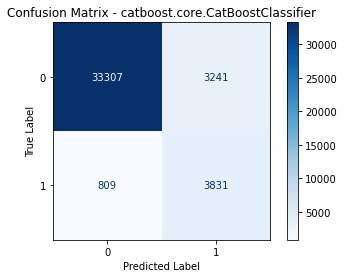

Wall time: 13min 4s


In [23]:
%%time
# =========== model reference =============#
clf_logistic = LogisticRegression()
clf_logistic = classifier_SKF(clf_logistic,X,y)

#============= XGBClassifier=============#
clf_xgb = XGBClassifier(**xg_boost_params)
clf_xgb = classifier_SKF(clf_xgb,X,y)

#==========RandomForestClassifier========#
clf_rf = RandomForestClassifier(**random_forest_params)
clf_rf = classifier_SKF(clf_rf,X,y)

#==========KNeighborsClassifier========#
clf_knn = KNeighborsClassifier()
clf_knn = classifier_SKF(clf_knn,X,y)

#================svm=================#
clf_svm = svm.SVC()
clf_svm = classifier_SKF(clf_svm,X,y)

#============clf_gaussian==============#
clf_gaussian = GaussianNB()
clf_gaussian = classifier_SKF(clf_gaussian,X,y)

#============CatBoostClassifier==============#
clf_CatBoost = CatBoostClassifier()
clf_CatBoost = classifier_SKF(clf_CatBoost,X,y)

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    
        ('clf_logistic',clf_logistic),
        ('clf_xgb',clf_xgb),
        ('clf_rf',clf_rf),
        ('clf_knn',clf_knn),
        ('clf_svm',clf_svm),
        ('clf_gaussian',clf_gaussian),
        ('clf_CatBoost',clf_CatBoost)
]

stack_model = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

Learning rate set to 0.048184
0:	learn: 0.6021453	total: 6.53ms	remaining: 6.52s
1:	learn: 0.5434878	total: 13.2ms	remaining: 6.61s
2:	learn: 0.4757751	total: 19.6ms	remaining: 6.53s
3:	learn: 0.4324579	total: 31.2ms	remaining: 7.77s
4:	learn: 0.4029116	total: 38.6ms	remaining: 7.68s
5:	learn: 0.3703588	total: 45.1ms	remaining: 7.47s
6:	learn: 0.3458172	total: 51.3ms	remaining: 7.27s
7:	learn: 0.3191582	total: 57.8ms	remaining: 7.17s
8:	learn: 0.3045371	total: 64.4ms	remaining: 7.09s
9:	learn: 0.2916215	total: 71.1ms	remaining: 7.04s
10:	learn: 0.2791558	total: 77.6ms	remaining: 6.98s
11:	learn: 0.2652281	total: 84.2ms	remaining: 6.94s
12:	learn: 0.2544621	total: 90.6ms	remaining: 6.88s
13:	learn: 0.2478162	total: 96.8ms	remaining: 6.82s
14:	learn: 0.2414073	total: 103ms	remaining: 6.76s
15:	learn: 0.2363107	total: 109ms	remaining: 6.71s
16:	learn: 0.2315136	total: 116ms	remaining: 6.7s
17:	learn: 0.2275609	total: 123ms	remaining: 6.69s
18:	learn: 0.2234342	total: 129ms	remaining: 6.68

168:	learn: 0.1601894	total: 1.1s	remaining: 5.39s
169:	learn: 0.1601155	total: 1.1s	remaining: 5.38s
170:	learn: 0.1600292	total: 1.11s	remaining: 5.38s
171:	learn: 0.1599988	total: 1.12s	remaining: 5.37s
172:	learn: 0.1599735	total: 1.12s	remaining: 5.36s
173:	learn: 0.1598695	total: 1.13s	remaining: 5.36s
174:	learn: 0.1597856	total: 1.14s	remaining: 5.36s
175:	learn: 0.1597353	total: 1.14s	remaining: 5.35s
176:	learn: 0.1596311	total: 1.15s	remaining: 5.34s
177:	learn: 0.1595452	total: 1.16s	remaining: 5.33s
178:	learn: 0.1595019	total: 1.16s	remaining: 5.33s
179:	learn: 0.1594332	total: 1.17s	remaining: 5.32s
180:	learn: 0.1593700	total: 1.17s	remaining: 5.31s
181:	learn: 0.1592605	total: 1.18s	remaining: 5.31s
182:	learn: 0.1592115	total: 1.19s	remaining: 5.3s
183:	learn: 0.1591010	total: 1.19s	remaining: 5.29s
184:	learn: 0.1590094	total: 1.2s	remaining: 5.29s
185:	learn: 0.1589214	total: 1.21s	remaining: 5.28s
186:	learn: 0.1588394	total: 1.21s	remaining: 5.27s
187:	learn: 0.15

335:	learn: 0.1489447	total: 2.19s	remaining: 4.34s
336:	learn: 0.1489065	total: 2.2s	remaining: 4.33s
337:	learn: 0.1488547	total: 2.21s	remaining: 4.33s
338:	learn: 0.1487997	total: 2.21s	remaining: 4.32s
339:	learn: 0.1487430	total: 2.22s	remaining: 4.31s
340:	learn: 0.1487097	total: 2.23s	remaining: 4.31s
341:	learn: 0.1486778	total: 2.23s	remaining: 4.3s
342:	learn: 0.1486409	total: 2.24s	remaining: 4.29s
343:	learn: 0.1485885	total: 2.25s	remaining: 4.29s
344:	learn: 0.1485330	total: 2.25s	remaining: 4.28s
345:	learn: 0.1484872	total: 2.26s	remaining: 4.27s
346:	learn: 0.1484675	total: 2.27s	remaining: 4.27s
347:	learn: 0.1484189	total: 2.27s	remaining: 4.26s
348:	learn: 0.1483732	total: 2.28s	remaining: 4.25s
349:	learn: 0.1483153	total: 2.29s	remaining: 4.25s
350:	learn: 0.1482530	total: 2.29s	remaining: 4.24s
351:	learn: 0.1481887	total: 2.3s	remaining: 4.23s
352:	learn: 0.1481627	total: 2.31s	remaining: 4.23s
353:	learn: 0.1481258	total: 2.31s	remaining: 4.22s
354:	learn: 0.1

504:	learn: 0.1408894	total: 3.29s	remaining: 3.22s
505:	learn: 0.1408401	total: 3.29s	remaining: 3.21s
506:	learn: 0.1407926	total: 3.3s	remaining: 3.21s
507:	learn: 0.1407426	total: 3.31s	remaining: 3.2s
508:	learn: 0.1407084	total: 3.31s	remaining: 3.19s
509:	learn: 0.1406304	total: 3.32s	remaining: 3.19s
510:	learn: 0.1405876	total: 3.33s	remaining: 3.18s
511:	learn: 0.1405495	total: 3.33s	remaining: 3.17s
512:	learn: 0.1405013	total: 3.34s	remaining: 3.17s
513:	learn: 0.1404537	total: 3.34s	remaining: 3.16s
514:	learn: 0.1404095	total: 3.35s	remaining: 3.15s
515:	learn: 0.1403597	total: 3.36s	remaining: 3.15s
516:	learn: 0.1402985	total: 3.36s	remaining: 3.14s
517:	learn: 0.1402292	total: 3.37s	remaining: 3.13s
518:	learn: 0.1401565	total: 3.38s	remaining: 3.13s
519:	learn: 0.1401325	total: 3.38s	remaining: 3.12s
520:	learn: 0.1400707	total: 3.39s	remaining: 3.12s
521:	learn: 0.1400278	total: 3.4s	remaining: 3.11s
522:	learn: 0.1399801	total: 3.4s	remaining: 3.1s
523:	learn: 0.139

673:	learn: 0.1332846	total: 4.38s	remaining: 2.12s
674:	learn: 0.1332415	total: 4.39s	remaining: 2.11s
675:	learn: 0.1331872	total: 4.39s	remaining: 2.1s
676:	learn: 0.1331636	total: 4.4s	remaining: 2.1s
677:	learn: 0.1331459	total: 4.41s	remaining: 2.09s
678:	learn: 0.1331119	total: 4.41s	remaining: 2.08s
679:	learn: 0.1330728	total: 4.42s	remaining: 2.08s
680:	learn: 0.1330445	total: 4.42s	remaining: 2.07s
681:	learn: 0.1329797	total: 4.43s	remaining: 2.06s
682:	learn: 0.1329554	total: 4.44s	remaining: 2.06s
683:	learn: 0.1329203	total: 4.44s	remaining: 2.05s
684:	learn: 0.1328832	total: 4.45s	remaining: 2.05s
685:	learn: 0.1328401	total: 4.46s	remaining: 2.04s
686:	learn: 0.1327699	total: 4.46s	remaining: 2.03s
687:	learn: 0.1327384	total: 4.47s	remaining: 2.03s
688:	learn: 0.1327168	total: 4.47s	remaining: 2.02s
689:	learn: 0.1326692	total: 4.48s	remaining: 2.01s
690:	learn: 0.1326197	total: 4.49s	remaining: 2.01s
691:	learn: 0.1325995	total: 4.49s	remaining: 2s
692:	learn: 0.1325

842:	learn: 0.1270687	total: 5.47s	remaining: 1.02s
843:	learn: 0.1270457	total: 5.48s	remaining: 1.01s
844:	learn: 0.1270087	total: 5.48s	remaining: 1s
845:	learn: 0.1269885	total: 5.49s	remaining: 999ms
846:	learn: 0.1269417	total: 5.5s	remaining: 993ms
847:	learn: 0.1269074	total: 5.5s	remaining: 987ms
848:	learn: 0.1268634	total: 5.51s	remaining: 980ms
849:	learn: 0.1268244	total: 5.52s	remaining: 974ms
850:	learn: 0.1267778	total: 5.52s	remaining: 967ms
851:	learn: 0.1267417	total: 5.53s	remaining: 961ms
852:	learn: 0.1267023	total: 5.54s	remaining: 954ms
853:	learn: 0.1266994	total: 5.54s	remaining: 948ms
854:	learn: 0.1266477	total: 5.55s	remaining: 941ms
855:	learn: 0.1266132	total: 5.55s	remaining: 935ms
856:	learn: 0.1265815	total: 5.56s	remaining: 928ms
857:	learn: 0.1265471	total: 5.57s	remaining: 922ms
858:	learn: 0.1265213	total: 5.58s	remaining: 915ms
859:	learn: 0.1264723	total: 5.58s	remaining: 909ms
860:	learn: 0.1264405	total: 5.59s	remaining: 902ms
861:	learn: 0.126

27:	learn: 0.1810973	total: 187ms	remaining: 6.49s
28:	learn: 0.1799031	total: 194ms	remaining: 6.5s
29:	learn: 0.1785909	total: 201ms	remaining: 6.5s
30:	learn: 0.1779261	total: 208ms	remaining: 6.51s
31:	learn: 0.1770924	total: 215ms	remaining: 6.5s
32:	learn: 0.1763067	total: 222ms	remaining: 6.5s
33:	learn: 0.1757317	total: 229ms	remaining: 6.51s
34:	learn: 0.1754496	total: 236ms	remaining: 6.51s
35:	learn: 0.1749084	total: 243ms	remaining: 6.51s
36:	learn: 0.1744276	total: 250ms	remaining: 6.52s
37:	learn: 0.1741064	total: 258ms	remaining: 6.53s
38:	learn: 0.1732918	total: 266ms	remaining: 6.56s
39:	learn: 0.1728042	total: 275ms	remaining: 6.59s
40:	learn: 0.1725515	total: 282ms	remaining: 6.6s
41:	learn: 0.1719866	total: 289ms	remaining: 6.6s
42:	learn: 0.1714117	total: 297ms	remaining: 6.6s
43:	learn: 0.1707796	total: 304ms	remaining: 6.6s
44:	learn: 0.1705854	total: 311ms	remaining: 6.61s
45:	learn: 0.1698642	total: 319ms	remaining: 6.61s
46:	learn: 0.1692601	total: 325ms	remai

213:	learn: 0.1443639	total: 1.47s	remaining: 5.4s
214:	learn: 0.1443195	total: 1.48s	remaining: 5.4s
215:	learn: 0.1442779	total: 1.49s	remaining: 5.39s
216:	learn: 0.1441758	total: 1.49s	remaining: 5.39s
217:	learn: 0.1441251	total: 1.5s	remaining: 5.38s
218:	learn: 0.1440924	total: 1.51s	remaining: 5.38s
219:	learn: 0.1440503	total: 1.51s	remaining: 5.37s
220:	learn: 0.1439685	total: 1.52s	remaining: 5.36s
221:	learn: 0.1439032	total: 1.53s	remaining: 5.35s
222:	learn: 0.1438360	total: 1.53s	remaining: 5.34s
223:	learn: 0.1438091	total: 1.54s	remaining: 5.33s
224:	learn: 0.1437396	total: 1.55s	remaining: 5.33s
225:	learn: 0.1436803	total: 1.55s	remaining: 5.32s
226:	learn: 0.1435935	total: 1.56s	remaining: 5.31s
227:	learn: 0.1434999	total: 1.57s	remaining: 5.3s
228:	learn: 0.1434620	total: 1.57s	remaining: 5.3s
229:	learn: 0.1433834	total: 1.58s	remaining: 5.29s
230:	learn: 0.1432918	total: 1.59s	remaining: 5.28s
231:	learn: 0.1432218	total: 1.59s	remaining: 5.27s
232:	learn: 0.143

377:	learn: 0.1335411	total: 2.57s	remaining: 4.23s
378:	learn: 0.1334798	total: 2.58s	remaining: 4.22s
379:	learn: 0.1333870	total: 2.58s	remaining: 4.22s
380:	learn: 0.1333281	total: 2.59s	remaining: 4.21s
381:	learn: 0.1332557	total: 2.6s	remaining: 4.2s
382:	learn: 0.1332026	total: 2.6s	remaining: 4.2s
383:	learn: 0.1331536	total: 2.61s	remaining: 4.19s
384:	learn: 0.1331148	total: 2.62s	remaining: 4.18s
385:	learn: 0.1330615	total: 2.63s	remaining: 4.18s
386:	learn: 0.1330338	total: 2.63s	remaining: 4.17s
387:	learn: 0.1329757	total: 2.64s	remaining: 4.17s
388:	learn: 0.1329164	total: 2.65s	remaining: 4.16s
389:	learn: 0.1328811	total: 2.65s	remaining: 4.15s
390:	learn: 0.1327920	total: 2.66s	remaining: 4.14s
391:	learn: 0.1327480	total: 2.67s	remaining: 4.14s
392:	learn: 0.1326782	total: 2.67s	remaining: 4.13s
393:	learn: 0.1326065	total: 2.68s	remaining: 4.13s
394:	learn: 0.1325772	total: 2.69s	remaining: 4.12s
395:	learn: 0.1325340	total: 2.7s	remaining: 4.11s
396:	learn: 0.132

540:	learn: 0.1251617	total: 3.66s	remaining: 3.11s
541:	learn: 0.1251079	total: 3.67s	remaining: 3.1s
542:	learn: 0.1250780	total: 3.68s	remaining: 3.1s
543:	learn: 0.1250536	total: 3.68s	remaining: 3.09s
544:	learn: 0.1250111	total: 3.69s	remaining: 3.08s
545:	learn: 0.1249461	total: 3.7s	remaining: 3.08s
546:	learn: 0.1248966	total: 3.71s	remaining: 3.07s
547:	learn: 0.1248648	total: 3.71s	remaining: 3.06s
548:	learn: 0.1247957	total: 3.72s	remaining: 3.05s
549:	learn: 0.1247596	total: 3.73s	remaining: 3.05s
550:	learn: 0.1247225	total: 3.73s	remaining: 3.04s
551:	learn: 0.1246793	total: 3.74s	remaining: 3.03s
552:	learn: 0.1246481	total: 3.74s	remaining: 3.03s
553:	learn: 0.1245687	total: 3.75s	remaining: 3.02s
554:	learn: 0.1245257	total: 3.76s	remaining: 3.01s
555:	learn: 0.1244748	total: 3.76s	remaining: 3.01s
556:	learn: 0.1244575	total: 3.77s	remaining: 3s
557:	learn: 0.1243977	total: 3.78s	remaining: 2.99s
558:	learn: 0.1243231	total: 3.78s	remaining: 2.98s
559:	learn: 0.1242

706:	learn: 0.1177133	total: 4.77s	remaining: 1.98s
707:	learn: 0.1176934	total: 4.78s	remaining: 1.97s
708:	learn: 0.1176472	total: 4.78s	remaining: 1.96s
709:	learn: 0.1176280	total: 4.79s	remaining: 1.96s
710:	learn: 0.1175985	total: 4.79s	remaining: 1.95s
711:	learn: 0.1175895	total: 4.8s	remaining: 1.94s
712:	learn: 0.1175518	total: 4.81s	remaining: 1.94s
713:	learn: 0.1175226	total: 4.82s	remaining: 1.93s
714:	learn: 0.1174971	total: 4.82s	remaining: 1.92s
715:	learn: 0.1174782	total: 4.83s	remaining: 1.92s
716:	learn: 0.1174380	total: 4.83s	remaining: 1.91s
717:	learn: 0.1174180	total: 4.84s	remaining: 1.9s
718:	learn: 0.1173859	total: 4.85s	remaining: 1.89s
719:	learn: 0.1173114	total: 4.85s	remaining: 1.89s
720:	learn: 0.1172604	total: 4.86s	remaining: 1.88s
721:	learn: 0.1172516	total: 4.87s	remaining: 1.87s
722:	learn: 0.1172064	total: 4.87s	remaining: 1.87s
723:	learn: 0.1171542	total: 4.88s	remaining: 1.86s
724:	learn: 0.1170989	total: 4.89s	remaining: 1.85s
725:	learn: 0.

871:	learn: 0.1116298	total: 5.86s	remaining: 861ms
872:	learn: 0.1116178	total: 5.87s	remaining: 854ms
873:	learn: 0.1116159	total: 5.88s	remaining: 847ms
874:	learn: 0.1115814	total: 5.88s	remaining: 841ms
875:	learn: 0.1115248	total: 5.89s	remaining: 834ms
876:	learn: 0.1114745	total: 5.9s	remaining: 827ms
877:	learn: 0.1114296	total: 5.9s	remaining: 820ms
878:	learn: 0.1114126	total: 5.91s	remaining: 814ms
879:	learn: 0.1113863	total: 5.92s	remaining: 807ms
880:	learn: 0.1113393	total: 5.92s	remaining: 800ms
881:	learn: 0.1113193	total: 5.93s	remaining: 793ms
882:	learn: 0.1112926	total: 5.94s	remaining: 787ms
883:	learn: 0.1112329	total: 5.94s	remaining: 780ms
884:	learn: 0.1111783	total: 5.95s	remaining: 773ms
885:	learn: 0.1111245	total: 5.96s	remaining: 766ms
886:	learn: 0.1110945	total: 5.96s	remaining: 760ms
887:	learn: 0.1110509	total: 5.97s	remaining: 753ms
888:	learn: 0.1110364	total: 5.98s	remaining: 746ms
889:	learn: 0.1110229	total: 5.98s	remaining: 740ms
890:	learn: 0.

54:	learn: 0.1514703	total: 368ms	remaining: 6.32s
55:	learn: 0.1511039	total: 375ms	remaining: 6.32s
56:	learn: 0.1508827	total: 382ms	remaining: 6.32s
57:	learn: 0.1506782	total: 388ms	remaining: 6.31s
58:	learn: 0.1505093	total: 395ms	remaining: 6.31s
59:	learn: 0.1503141	total: 402ms	remaining: 6.3s
60:	learn: 0.1499137	total: 409ms	remaining: 6.29s
61:	learn: 0.1497679	total: 415ms	remaining: 6.28s
62:	learn: 0.1496743	total: 422ms	remaining: 6.27s
63:	learn: 0.1495564	total: 429ms	remaining: 6.27s
64:	learn: 0.1494282	total: 435ms	remaining: 6.26s
65:	learn: 0.1490568	total: 442ms	remaining: 6.25s
66:	learn: 0.1489122	total: 448ms	remaining: 6.24s
67:	learn: 0.1487911	total: 455ms	remaining: 6.23s
68:	learn: 0.1486479	total: 461ms	remaining: 6.22s
69:	learn: 0.1485412	total: 468ms	remaining: 6.22s
70:	learn: 0.1482406	total: 475ms	remaining: 6.21s
71:	learn: 0.1480559	total: 481ms	remaining: 6.2s
72:	learn: 0.1478865	total: 488ms	remaining: 6.19s
73:	learn: 0.1478005	total: 494ms

220:	learn: 0.1321289	total: 1.47s	remaining: 5.18s
221:	learn: 0.1320735	total: 1.48s	remaining: 5.18s
222:	learn: 0.1320017	total: 1.48s	remaining: 5.17s
223:	learn: 0.1319657	total: 1.49s	remaining: 5.16s
224:	learn: 0.1319407	total: 1.5s	remaining: 5.16s
225:	learn: 0.1319048	total: 1.5s	remaining: 5.15s
226:	learn: 0.1318299	total: 1.51s	remaining: 5.14s
227:	learn: 0.1317283	total: 1.52s	remaining: 5.14s
228:	learn: 0.1316950	total: 1.52s	remaining: 5.13s
229:	learn: 0.1316494	total: 1.53s	remaining: 5.13s
230:	learn: 0.1315654	total: 1.54s	remaining: 5.12s
231:	learn: 0.1315049	total: 1.54s	remaining: 5.11s
232:	learn: 0.1314231	total: 1.55s	remaining: 5.1s
233:	learn: 0.1313720	total: 1.56s	remaining: 5.1s
234:	learn: 0.1313107	total: 1.56s	remaining: 5.09s
235:	learn: 0.1312601	total: 1.57s	remaining: 5.08s
236:	learn: 0.1311992	total: 1.58s	remaining: 5.08s
237:	learn: 0.1311551	total: 1.58s	remaining: 5.07s
238:	learn: 0.1310848	total: 1.59s	remaining: 5.06s
239:	learn: 0.13

385:	learn: 0.1221453	total: 2.57s	remaining: 4.08s
386:	learn: 0.1221072	total: 2.57s	remaining: 4.08s
387:	learn: 0.1220419	total: 2.58s	remaining: 4.07s
388:	learn: 0.1220062	total: 2.59s	remaining: 4.06s
389:	learn: 0.1219595	total: 2.59s	remaining: 4.06s
390:	learn: 0.1219078	total: 2.6s	remaining: 4.05s
391:	learn: 0.1218529	total: 2.61s	remaining: 4.04s
392:	learn: 0.1218416	total: 2.61s	remaining: 4.04s
393:	learn: 0.1218217	total: 2.62s	remaining: 4.03s
394:	learn: 0.1217308	total: 2.63s	remaining: 4.02s
395:	learn: 0.1216827	total: 2.63s	remaining: 4.02s
396:	learn: 0.1216152	total: 2.64s	remaining: 4.01s
397:	learn: 0.1215680	total: 2.65s	remaining: 4s
398:	learn: 0.1215268	total: 2.65s	remaining: 4s
399:	learn: 0.1214898	total: 2.66s	remaining: 3.99s
400:	learn: 0.1214281	total: 2.67s	remaining: 3.98s
401:	learn: 0.1213574	total: 2.67s	remaining: 3.98s
402:	learn: 0.1213098	total: 2.68s	remaining: 3.97s
403:	learn: 0.1212747	total: 2.69s	remaining: 3.96s
404:	learn: 0.12123

550:	learn: 0.1143316	total: 3.66s	remaining: 2.98s
551:	learn: 0.1143031	total: 3.67s	remaining: 2.98s
552:	learn: 0.1142236	total: 3.68s	remaining: 2.97s
553:	learn: 0.1141813	total: 3.69s	remaining: 2.97s
554:	learn: 0.1141290	total: 3.69s	remaining: 2.96s
555:	learn: 0.1140342	total: 3.7s	remaining: 2.95s
556:	learn: 0.1140109	total: 3.71s	remaining: 2.95s
557:	learn: 0.1139506	total: 3.71s	remaining: 2.94s
558:	learn: 0.1138900	total: 3.72s	remaining: 2.93s
559:	learn: 0.1138336	total: 3.73s	remaining: 2.93s
560:	learn: 0.1137741	total: 3.73s	remaining: 2.92s
561:	learn: 0.1137225	total: 3.74s	remaining: 2.91s
562:	learn: 0.1136831	total: 3.74s	remaining: 2.91s
563:	learn: 0.1136664	total: 3.75s	remaining: 2.9s
564:	learn: 0.1135827	total: 3.76s	remaining: 2.89s
565:	learn: 0.1135421	total: 3.76s	remaining: 2.89s
566:	learn: 0.1135099	total: 3.77s	remaining: 2.88s
567:	learn: 0.1134660	total: 3.78s	remaining: 2.87s
568:	learn: 0.1134273	total: 3.78s	remaining: 2.87s
569:	learn: 0.

716:	learn: 0.1069224	total: 4.78s	remaining: 1.89s
717:	learn: 0.1068807	total: 4.79s	remaining: 1.88s
718:	learn: 0.1068235	total: 4.79s	remaining: 1.87s
719:	learn: 0.1067987	total: 4.8s	remaining: 1.87s
720:	learn: 0.1067425	total: 4.81s	remaining: 1.86s
721:	learn: 0.1067082	total: 4.81s	remaining: 1.85s
722:	learn: 0.1067002	total: 4.82s	remaining: 1.85s
723:	learn: 0.1066443	total: 4.83s	remaining: 1.84s
724:	learn: 0.1066083	total: 4.83s	remaining: 1.83s
725:	learn: 0.1065788	total: 4.84s	remaining: 1.83s
726:	learn: 0.1065353	total: 4.85s	remaining: 1.82s
727:	learn: 0.1064970	total: 4.85s	remaining: 1.81s
728:	learn: 0.1064633	total: 4.86s	remaining: 1.81s
729:	learn: 0.1064214	total: 4.87s	remaining: 1.8s
730:	learn: 0.1063695	total: 4.87s	remaining: 1.79s
731:	learn: 0.1063448	total: 4.88s	remaining: 1.79s
732:	learn: 0.1063022	total: 4.89s	remaining: 1.78s
733:	learn: 0.1062658	total: 4.89s	remaining: 1.77s
734:	learn: 0.1062302	total: 4.9s	remaining: 1.77s
735:	learn: 0.1

882:	learn: 0.1008227	total: 5.91s	remaining: 783ms
883:	learn: 0.1007581	total: 5.92s	remaining: 777ms
884:	learn: 0.1007065	total: 5.92s	remaining: 770ms
885:	learn: 0.1006434	total: 5.93s	remaining: 763ms
886:	learn: 0.1006277	total: 5.94s	remaining: 757ms
887:	learn: 0.1005825	total: 5.95s	remaining: 750ms
888:	learn: 0.1005656	total: 5.95s	remaining: 743ms
889:	learn: 0.1005454	total: 5.96s	remaining: 737ms
890:	learn: 0.1005195	total: 5.97s	remaining: 730ms
891:	learn: 0.1005056	total: 5.97s	remaining: 723ms
892:	learn: 0.1004596	total: 5.98s	remaining: 717ms
893:	learn: 0.1004314	total: 5.99s	remaining: 710ms
894:	learn: 0.1004100	total: 5.99s	remaining: 703ms
895:	learn: 0.1004062	total: 6s	remaining: 696ms
896:	learn: 0.1003671	total: 6s	remaining: 690ms
897:	learn: 0.1003499	total: 6.01s	remaining: 683ms
898:	learn: 0.1003061	total: 6.02s	remaining: 676ms
899:	learn: 0.1002976	total: 6.03s	remaining: 669ms
900:	learn: 0.1002773	total: 6.03s	remaining: 663ms
901:	learn: 0.1002

54:	learn: 0.1617189	total: 366ms	remaining: 6.29s
55:	learn: 0.1610127	total: 373ms	remaining: 6.29s
56:	learn: 0.1607259	total: 380ms	remaining: 6.29s
57:	learn: 0.1602793	total: 387ms	remaining: 6.29s
58:	learn: 0.1593542	total: 394ms	remaining: 6.28s
59:	learn: 0.1587352	total: 401ms	remaining: 6.28s
60:	learn: 0.1584704	total: 407ms	remaining: 6.27s
61:	learn: 0.1582174	total: 414ms	remaining: 6.26s
62:	learn: 0.1577369	total: 420ms	remaining: 6.25s
63:	learn: 0.1574924	total: 427ms	remaining: 6.25s
64:	learn: 0.1573360	total: 434ms	remaining: 6.24s
65:	learn: 0.1569265	total: 440ms	remaining: 6.23s
66:	learn: 0.1566206	total: 447ms	remaining: 6.22s
67:	learn: 0.1562940	total: 453ms	remaining: 6.21s
68:	learn: 0.1561169	total: 459ms	remaining: 6.2s
69:	learn: 0.1557820	total: 466ms	remaining: 6.19s
70:	learn: 0.1555063	total: 473ms	remaining: 6.18s
71:	learn: 0.1551996	total: 479ms	remaining: 6.18s
72:	learn: 0.1547153	total: 486ms	remaining: 6.17s
73:	learn: 0.1545206	total: 492m

220:	learn: 0.1318373	total: 1.47s	remaining: 5.18s
221:	learn: 0.1317914	total: 1.48s	remaining: 5.18s
222:	learn: 0.1316925	total: 1.48s	remaining: 5.17s
223:	learn: 0.1316167	total: 1.49s	remaining: 5.17s
224:	learn: 0.1315767	total: 1.5s	remaining: 5.16s
225:	learn: 0.1315266	total: 1.5s	remaining: 5.16s
226:	learn: 0.1314185	total: 1.51s	remaining: 5.15s
227:	learn: 0.1313240	total: 1.52s	remaining: 5.14s
228:	learn: 0.1312666	total: 1.52s	remaining: 5.14s
229:	learn: 0.1312197	total: 1.53s	remaining: 5.13s
230:	learn: 0.1311264	total: 1.54s	remaining: 5.12s
231:	learn: 0.1310154	total: 1.54s	remaining: 5.11s
232:	learn: 0.1309606	total: 1.55s	remaining: 5.11s
233:	learn: 0.1308620	total: 1.56s	remaining: 5.1s
234:	learn: 0.1308096	total: 1.56s	remaining: 5.09s
235:	learn: 0.1307664	total: 1.57s	remaining: 5.09s
236:	learn: 0.1306579	total: 1.58s	remaining: 5.08s
237:	learn: 0.1306063	total: 1.58s	remaining: 5.07s
238:	learn: 0.1305488	total: 1.59s	remaining: 5.07s
239:	learn: 0.1

384:	learn: 0.1213939	total: 2.57s	remaining: 4.1s
385:	learn: 0.1213664	total: 2.58s	remaining: 4.1s
386:	learn: 0.1213079	total: 2.58s	remaining: 4.09s
387:	learn: 0.1212556	total: 2.59s	remaining: 4.08s
388:	learn: 0.1212162	total: 2.6s	remaining: 4.08s
389:	learn: 0.1211783	total: 2.6s	remaining: 4.07s
390:	learn: 0.1211209	total: 2.61s	remaining: 4.07s
391:	learn: 0.1210670	total: 2.62s	remaining: 4.06s
392:	learn: 0.1209742	total: 2.62s	remaining: 4.05s
393:	learn: 0.1209247	total: 2.63s	remaining: 4.04s
394:	learn: 0.1208619	total: 2.64s	remaining: 4.04s
395:	learn: 0.1207967	total: 2.64s	remaining: 4.03s
396:	learn: 0.1207525	total: 2.65s	remaining: 4.02s
397:	learn: 0.1207226	total: 2.66s	remaining: 4.02s
398:	learn: 0.1206630	total: 2.66s	remaining: 4.01s
399:	learn: 0.1205969	total: 2.67s	remaining: 4s
400:	learn: 0.1205195	total: 2.68s	remaining: 4s
401:	learn: 0.1204539	total: 2.68s	remaining: 3.99s
402:	learn: 0.1203731	total: 2.69s	remaining: 3.98s
403:	learn: 0.1203081	

547:	learn: 0.1129971	total: 3.67s	remaining: 3.03s
548:	learn: 0.1129526	total: 3.68s	remaining: 3.02s
549:	learn: 0.1128968	total: 3.68s	remaining: 3.01s
550:	learn: 0.1128248	total: 3.69s	remaining: 3.01s
551:	learn: 0.1127579	total: 3.7s	remaining: 3s
552:	learn: 0.1126776	total: 3.7s	remaining: 2.99s
553:	learn: 0.1126418	total: 3.71s	remaining: 2.99s
554:	learn: 0.1125890	total: 3.72s	remaining: 2.98s
555:	learn: 0.1125286	total: 3.73s	remaining: 2.97s
556:	learn: 0.1124871	total: 3.73s	remaining: 2.97s
557:	learn: 0.1124151	total: 3.74s	remaining: 2.96s
558:	learn: 0.1124017	total: 3.74s	remaining: 2.95s
559:	learn: 0.1123573	total: 3.75s	remaining: 2.95s
560:	learn: 0.1123497	total: 3.76s	remaining: 2.94s
561:	learn: 0.1123178	total: 3.76s	remaining: 2.93s
562:	learn: 0.1122758	total: 3.77s	remaining: 2.93s
563:	learn: 0.1122311	total: 3.78s	remaining: 2.92s
564:	learn: 0.1121854	total: 3.79s	remaining: 2.91s
565:	learn: 0.1121363	total: 3.79s	remaining: 2.91s
566:	learn: 0.112

708:	learn: 0.1062908	total: 4.77s	remaining: 1.96s
709:	learn: 0.1062653	total: 4.77s	remaining: 1.95s
710:	learn: 0.1062231	total: 4.78s	remaining: 1.94s
711:	learn: 0.1061872	total: 4.79s	remaining: 1.94s
712:	learn: 0.1061775	total: 4.79s	remaining: 1.93s
713:	learn: 0.1061393	total: 4.8s	remaining: 1.92s
714:	learn: 0.1061126	total: 4.81s	remaining: 1.92s
715:	learn: 0.1061019	total: 4.82s	remaining: 1.91s
716:	learn: 0.1060534	total: 4.82s	remaining: 1.9s
717:	learn: 0.1059974	total: 4.83s	remaining: 1.9s
718:	learn: 0.1059587	total: 4.83s	remaining: 1.89s
719:	learn: 0.1059338	total: 4.84s	remaining: 1.88s
720:	learn: 0.1058835	total: 4.85s	remaining: 1.88s
721:	learn: 0.1058801	total: 4.85s	remaining: 1.87s
722:	learn: 0.1058208	total: 4.86s	remaining: 1.86s
723:	learn: 0.1057832	total: 4.87s	remaining: 1.85s
724:	learn: 0.1057356	total: 4.87s	remaining: 1.85s
725:	learn: 0.1056864	total: 4.88s	remaining: 1.84s
726:	learn: 0.1056478	total: 4.89s	remaining: 1.83s
727:	learn: 0.1

869:	learn: 0.0999534	total: 5.87s	remaining: 877ms
870:	learn: 0.0999480	total: 5.87s	remaining: 870ms
871:	learn: 0.0999009	total: 5.88s	remaining: 863ms
872:	learn: 0.0998796	total: 5.89s	remaining: 856ms
873:	learn: 0.0998507	total: 5.89s	remaining: 850ms
874:	learn: 0.0998314	total: 5.9s	remaining: 843ms
875:	learn: 0.0997813	total: 5.91s	remaining: 836ms
876:	learn: 0.0997256	total: 5.91s	remaining: 829ms
877:	learn: 0.0996870	total: 5.92s	remaining: 823ms
878:	learn: 0.0996498	total: 5.93s	remaining: 816ms
879:	learn: 0.0996053	total: 5.93s	remaining: 809ms
880:	learn: 0.0995775	total: 5.94s	remaining: 802ms
881:	learn: 0.0995402	total: 5.95s	remaining: 796ms
882:	learn: 0.0995041	total: 5.95s	remaining: 789ms
883:	learn: 0.0994461	total: 5.96s	remaining: 782ms
884:	learn: 0.0993954	total: 5.97s	remaining: 776ms
885:	learn: 0.0993581	total: 5.97s	remaining: 769ms
886:	learn: 0.0993359	total: 5.98s	remaining: 762ms
887:	learn: 0.0993163	total: 5.99s	remaining: 755ms
888:	learn: 0

54:	learn: 0.1333756	total: 363ms	remaining: 6.25s
55:	learn: 0.1325106	total: 371ms	remaining: 6.25s
56:	learn: 0.1321740	total: 378ms	remaining: 6.25s
57:	learn: 0.1319288	total: 385ms	remaining: 6.25s
58:	learn: 0.1316540	total: 392ms	remaining: 6.26s
59:	learn: 0.1313991	total: 399ms	remaining: 6.25s
60:	learn: 0.1311671	total: 406ms	remaining: 6.24s
61:	learn: 0.1309971	total: 412ms	remaining: 6.24s
62:	learn: 0.1307452	total: 419ms	remaining: 6.23s
63:	learn: 0.1304422	total: 426ms	remaining: 6.22s
64:	learn: 0.1302768	total: 432ms	remaining: 6.22s
65:	learn: 0.1298155	total: 439ms	remaining: 6.21s
66:	learn: 0.1296222	total: 446ms	remaining: 6.21s
67:	learn: 0.1294218	total: 452ms	remaining: 6.2s
68:	learn: 0.1290730	total: 459ms	remaining: 6.19s
69:	learn: 0.1287706	total: 466ms	remaining: 6.19s
70:	learn: 0.1285319	total: 472ms	remaining: 6.18s
71:	learn: 0.1283906	total: 479ms	remaining: 6.17s
72:	learn: 0.1282518	total: 485ms	remaining: 6.16s
73:	learn: 0.1281367	total: 492m

217:	learn: 0.1130704	total: 1.46s	remaining: 5.24s
218:	learn: 0.1130080	total: 1.47s	remaining: 5.24s
219:	learn: 0.1129721	total: 1.48s	remaining: 5.23s
220:	learn: 0.1129138	total: 1.48s	remaining: 5.22s
221:	learn: 0.1128371	total: 1.49s	remaining: 5.22s
222:	learn: 0.1127291	total: 1.5s	remaining: 5.21s
223:	learn: 0.1126520	total: 1.5s	remaining: 5.21s
224:	learn: 0.1126053	total: 1.51s	remaining: 5.2s
225:	learn: 0.1124930	total: 1.52s	remaining: 5.19s
226:	learn: 0.1124355	total: 1.52s	remaining: 5.18s
227:	learn: 0.1123522	total: 1.53s	remaining: 5.18s
228:	learn: 0.1123118	total: 1.53s	remaining: 5.17s
229:	learn: 0.1122750	total: 1.54s	remaining: 5.16s
230:	learn: 0.1122056	total: 1.55s	remaining: 5.16s
231:	learn: 0.1121576	total: 1.55s	remaining: 5.15s
232:	learn: 0.1121182	total: 1.56s	remaining: 5.14s
233:	learn: 0.1120252	total: 1.57s	remaining: 5.13s
234:	learn: 0.1119881	total: 1.57s	remaining: 5.13s
235:	learn: 0.1119417	total: 1.58s	remaining: 5.12s
236:	learn: 0.1

379:	learn: 0.1036059	total: 2.56s	remaining: 4.18s
380:	learn: 0.1035523	total: 2.57s	remaining: 4.17s
381:	learn: 0.1034997	total: 2.58s	remaining: 4.17s
382:	learn: 0.1034407	total: 2.58s	remaining: 4.16s
383:	learn: 0.1033992	total: 2.59s	remaining: 4.16s
384:	learn: 0.1033540	total: 2.6s	remaining: 4.15s
385:	learn: 0.1033153	total: 2.6s	remaining: 4.14s
386:	learn: 0.1032879	total: 2.61s	remaining: 4.13s
387:	learn: 0.1032392	total: 2.62s	remaining: 4.13s
388:	learn: 0.1031961	total: 2.62s	remaining: 4.12s
389:	learn: 0.1031692	total: 2.63s	remaining: 4.11s
390:	learn: 0.1031158	total: 2.64s	remaining: 4.11s
391:	learn: 0.1030792	total: 2.64s	remaining: 4.1s
392:	learn: 0.1030326	total: 2.65s	remaining: 4.09s
393:	learn: 0.1029933	total: 2.66s	remaining: 4.09s
394:	learn: 0.1029363	total: 2.66s	remaining: 4.08s
395:	learn: 0.1029150	total: 2.67s	remaining: 4.07s
396:	learn: 0.1028718	total: 2.68s	remaining: 4.07s
397:	learn: 0.1028274	total: 2.69s	remaining: 4.06s
398:	learn: 0.1

541:	learn: 0.0963168	total: 3.66s	remaining: 3.09s
542:	learn: 0.0962301	total: 3.67s	remaining: 3.08s
543:	learn: 0.0961870	total: 3.67s	remaining: 3.08s
544:	learn: 0.0961596	total: 3.68s	remaining: 3.07s
545:	learn: 0.0961296	total: 3.69s	remaining: 3.06s
546:	learn: 0.0960919	total: 3.69s	remaining: 3.06s
547:	learn: 0.0960436	total: 3.7s	remaining: 3.05s
548:	learn: 0.0960066	total: 3.71s	remaining: 3.04s
549:	learn: 0.0959732	total: 3.71s	remaining: 3.04s
550:	learn: 0.0959388	total: 3.72s	remaining: 3.03s
551:	learn: 0.0958935	total: 3.73s	remaining: 3.02s
552:	learn: 0.0958490	total: 3.73s	remaining: 3.02s
553:	learn: 0.0958371	total: 3.74s	remaining: 3.01s
554:	learn: 0.0958080	total: 3.75s	remaining: 3s
555:	learn: 0.0957727	total: 3.75s	remaining: 3s
556:	learn: 0.0957123	total: 3.76s	remaining: 2.99s
557:	learn: 0.0956765	total: 3.77s	remaining: 2.98s
558:	learn: 0.0956502	total: 3.77s	remaining: 2.98s
559:	learn: 0.0956362	total: 3.78s	remaining: 2.97s
560:	learn: 0.09559

703:	learn: 0.0900596	total: 4.75s	remaining: 2s
704:	learn: 0.0900159	total: 4.76s	remaining: 1.99s
705:	learn: 0.0899877	total: 4.77s	remaining: 1.98s
706:	learn: 0.0899360	total: 4.77s	remaining: 1.98s
707:	learn: 0.0899100	total: 4.78s	remaining: 1.97s
708:	learn: 0.0898625	total: 4.79s	remaining: 1.96s
709:	learn: 0.0898181	total: 4.79s	remaining: 1.96s
710:	learn: 0.0898100	total: 4.8s	remaining: 1.95s
711:	learn: 0.0897698	total: 4.81s	remaining: 1.94s
712:	learn: 0.0897628	total: 4.81s	remaining: 1.94s
713:	learn: 0.0897406	total: 4.82s	remaining: 1.93s
714:	learn: 0.0897078	total: 4.83s	remaining: 1.92s
715:	learn: 0.0896833	total: 4.83s	remaining: 1.92s
716:	learn: 0.0896591	total: 4.84s	remaining: 1.91s
717:	learn: 0.0895941	total: 4.85s	remaining: 1.9s
718:	learn: 0.0895831	total: 4.85s	remaining: 1.9s
719:	learn: 0.0895764	total: 4.86s	remaining: 1.89s
720:	learn: 0.0895354	total: 4.87s	remaining: 1.88s
721:	learn: 0.0894604	total: 4.87s	remaining: 1.88s
722:	learn: 0.0894

866:	learn: 0.0846686	total: 5.85s	remaining: 898ms
867:	learn: 0.0846337	total: 5.86s	remaining: 891ms
868:	learn: 0.0846042	total: 5.87s	remaining: 885ms
869:	learn: 0.0845840	total: 5.88s	remaining: 878ms
870:	learn: 0.0845444	total: 5.88s	remaining: 871ms
871:	learn: 0.0845218	total: 5.89s	remaining: 864ms
872:	learn: 0.0844759	total: 5.89s	remaining: 858ms
873:	learn: 0.0844561	total: 5.9s	remaining: 851ms
874:	learn: 0.0844076	total: 5.91s	remaining: 844ms
875:	learn: 0.0843960	total: 5.92s	remaining: 837ms
876:	learn: 0.0843702	total: 5.92s	remaining: 830ms
877:	learn: 0.0843500	total: 5.93s	remaining: 824ms
878:	learn: 0.0843099	total: 5.93s	remaining: 817ms
879:	learn: 0.0842968	total: 5.94s	remaining: 810ms
880:	learn: 0.0842639	total: 5.95s	remaining: 803ms
881:	learn: 0.0842379	total: 5.96s	remaining: 797ms
882:	learn: 0.0842043	total: 5.96s	remaining: 790ms
883:	learn: 0.0841840	total: 5.97s	remaining: 783ms
884:	learn: 0.0841091	total: 5.97s	remaining: 776ms
885:	learn: 0

29:	learn: 0.1259206	total: 189ms	remaining: 6.12s
30:	learn: 0.1245275	total: 196ms	remaining: 6.14s
31:	learn: 0.1221005	total: 203ms	remaining: 6.14s
32:	learn: 0.1204759	total: 209ms	remaining: 6.12s
33:	learn: 0.1199464	total: 215ms	remaining: 6.12s
34:	learn: 0.1186254	total: 222ms	remaining: 6.11s
35:	learn: 0.1173139	total: 228ms	remaining: 6.11s
36:	learn: 0.1165377	total: 234ms	remaining: 6.1s
37:	learn: 0.1159927	total: 241ms	remaining: 6.09s
38:	learn: 0.1151700	total: 247ms	remaining: 6.09s
39:	learn: 0.1141144	total: 253ms	remaining: 6.08s
40:	learn: 0.1130971	total: 260ms	remaining: 6.08s
41:	learn: 0.1121347	total: 266ms	remaining: 6.07s
42:	learn: 0.1114727	total: 272ms	remaining: 6.06s
43:	learn: 0.1109293	total: 279ms	remaining: 6.05s
44:	learn: 0.1107078	total: 285ms	remaining: 6.04s
45:	learn: 0.1097889	total: 291ms	remaining: 6.04s
46:	learn: 0.1092685	total: 297ms	remaining: 6.03s
47:	learn: 0.1086650	total: 304ms	remaining: 6.02s
48:	learn: 0.1083129	total: 310m

199:	learn: 0.0874847	total: 1.29s	remaining: 5.14s
200:	learn: 0.0874638	total: 1.29s	remaining: 5.14s
201:	learn: 0.0873738	total: 1.3s	remaining: 5.13s
202:	learn: 0.0873238	total: 1.31s	remaining: 5.13s
203:	learn: 0.0872871	total: 1.31s	remaining: 5.12s
204:	learn: 0.0871907	total: 1.32s	remaining: 5.12s
205:	learn: 0.0871370	total: 1.33s	remaining: 5.12s
206:	learn: 0.0870954	total: 1.33s	remaining: 5.11s
207:	learn: 0.0870241	total: 1.34s	remaining: 5.1s
208:	learn: 0.0869472	total: 1.35s	remaining: 5.1s
209:	learn: 0.0868519	total: 1.35s	remaining: 5.09s
210:	learn: 0.0868302	total: 1.36s	remaining: 5.08s
211:	learn: 0.0867633	total: 1.37s	remaining: 5.08s
212:	learn: 0.0867037	total: 1.37s	remaining: 5.07s
213:	learn: 0.0866443	total: 1.38s	remaining: 5.07s
214:	learn: 0.0865914	total: 1.39s	remaining: 5.06s
215:	learn: 0.0865570	total: 1.39s	remaining: 5.05s
216:	learn: 0.0865262	total: 1.4s	remaining: 5.05s
217:	learn: 0.0864835	total: 1.4s	remaining: 5.04s
218:	learn: 0.086

369:	learn: 0.0788676	total: 2.39s	remaining: 4.06s
370:	learn: 0.0788287	total: 2.39s	remaining: 4.06s
371:	learn: 0.0787877	total: 2.4s	remaining: 4.05s
372:	learn: 0.0787409	total: 2.41s	remaining: 4.05s
373:	learn: 0.0787229	total: 2.41s	remaining: 4.04s
374:	learn: 0.0786894	total: 2.42s	remaining: 4.03s
375:	learn: 0.0786741	total: 2.43s	remaining: 4.03s
376:	learn: 0.0786456	total: 2.43s	remaining: 4.02s
377:	learn: 0.0786192	total: 2.44s	remaining: 4.01s
378:	learn: 0.0785567	total: 2.45s	remaining: 4.01s
379:	learn: 0.0785056	total: 2.45s	remaining: 4s
380:	learn: 0.0784778	total: 2.46s	remaining: 4s
381:	learn: 0.0784582	total: 2.47s	remaining: 3.99s
382:	learn: 0.0784174	total: 2.47s	remaining: 3.98s
383:	learn: 0.0783890	total: 2.48s	remaining: 3.98s
384:	learn: 0.0783146	total: 2.48s	remaining: 3.97s
385:	learn: 0.0782932	total: 2.49s	remaining: 3.96s
386:	learn: 0.0782194	total: 2.5s	remaining: 3.96s
387:	learn: 0.0781817	total: 2.51s	remaining: 3.95s
388:	learn: 0.078129

535:	learn: 0.0726837	total: 3.49s	remaining: 3.02s
536:	learn: 0.0726442	total: 3.49s	remaining: 3.01s
537:	learn: 0.0725805	total: 3.5s	remaining: 3s
538:	learn: 0.0725244	total: 3.51s	remaining: 3s
539:	learn: 0.0724681	total: 3.51s	remaining: 2.99s
540:	learn: 0.0724335	total: 3.52s	remaining: 2.99s
541:	learn: 0.0724094	total: 3.53s	remaining: 2.98s
542:	learn: 0.0724022	total: 3.53s	remaining: 2.97s
543:	learn: 0.0723752	total: 3.54s	remaining: 2.97s
544:	learn: 0.0723561	total: 3.55s	remaining: 2.96s
545:	learn: 0.0723215	total: 3.55s	remaining: 2.95s
546:	learn: 0.0722910	total: 3.56s	remaining: 2.95s
547:	learn: 0.0722649	total: 3.57s	remaining: 2.94s
548:	learn: 0.0722057	total: 3.57s	remaining: 2.93s
549:	learn: 0.0721499	total: 3.58s	remaining: 2.93s
550:	learn: 0.0721137	total: 3.58s	remaining: 2.92s
551:	learn: 0.0720781	total: 3.59s	remaining: 2.92s
552:	learn: 0.0720532	total: 3.6s	remaining: 2.91s
553:	learn: 0.0720107	total: 3.6s	remaining: 2.9s
554:	learn: 0.0719791	

704:	learn: 0.0669764	total: 4.58s	remaining: 1.92s
705:	learn: 0.0669493	total: 4.59s	remaining: 1.91s
706:	learn: 0.0669246	total: 4.6s	remaining: 1.91s
707:	learn: 0.0669169	total: 4.6s	remaining: 1.9s
708:	learn: 0.0668735	total: 4.61s	remaining: 1.89s
709:	learn: 0.0668613	total: 4.62s	remaining: 1.89s
710:	learn: 0.0668143	total: 4.62s	remaining: 1.88s
711:	learn: 0.0667774	total: 4.63s	remaining: 1.87s
712:	learn: 0.0667368	total: 4.64s	remaining: 1.87s
713:	learn: 0.0667121	total: 4.64s	remaining: 1.86s
714:	learn: 0.0666981	total: 4.65s	remaining: 1.85s
715:	learn: 0.0666828	total: 4.66s	remaining: 1.85s
716:	learn: 0.0666741	total: 4.66s	remaining: 1.84s
717:	learn: 0.0666440	total: 4.67s	remaining: 1.83s
718:	learn: 0.0665986	total: 4.67s	remaining: 1.83s
719:	learn: 0.0665518	total: 4.68s	remaining: 1.82s
720:	learn: 0.0665025	total: 4.69s	remaining: 1.81s
721:	learn: 0.0664818	total: 4.7s	remaining: 1.81s
722:	learn: 0.0664359	total: 4.7s	remaining: 1.8s
723:	learn: 0.0663

872:	learn: 0.0622727	total: 5.68s	remaining: 826ms
873:	learn: 0.0622366	total: 5.69s	remaining: 820ms
874:	learn: 0.0622075	total: 5.7s	remaining: 814ms
875:	learn: 0.0621865	total: 5.7s	remaining: 807ms
876:	learn: 0.0621643	total: 5.71s	remaining: 801ms
877:	learn: 0.0621308	total: 5.72s	remaining: 794ms
878:	learn: 0.0621208	total: 5.72s	remaining: 788ms
879:	learn: 0.0620952	total: 5.73s	remaining: 781ms
880:	learn: 0.0620650	total: 5.74s	remaining: 775ms
881:	learn: 0.0620412	total: 5.74s	remaining: 768ms
882:	learn: 0.0620235	total: 5.75s	remaining: 762ms
883:	learn: 0.0620013	total: 5.75s	remaining: 755ms
884:	learn: 0.0619628	total: 5.76s	remaining: 749ms
885:	learn: 0.0619483	total: 5.77s	remaining: 742ms
886:	learn: 0.0619328	total: 5.77s	remaining: 736ms
887:	learn: 0.0619083	total: 5.78s	remaining: 729ms
888:	learn: 0.0618891	total: 5.79s	remaining: 723ms
889:	learn: 0.0618727	total: 5.79s	remaining: 716ms
890:	learn: 0.0618534	total: 5.8s	remaining: 710ms
891:	learn: 0.0

51:	learn: 0.1810368	total: 369ms	remaining: 6.73s
52:	learn: 0.1807648	total: 377ms	remaining: 6.73s
53:	learn: 0.1805040	total: 383ms	remaining: 6.71s
54:	learn: 0.1802869	total: 390ms	remaining: 6.71s
55:	learn: 0.1799936	total: 397ms	remaining: 6.7s
56:	learn: 0.1795152	total: 404ms	remaining: 6.68s
57:	learn: 0.1787461	total: 411ms	remaining: 6.67s
58:	learn: 0.1785156	total: 417ms	remaining: 6.65s
59:	learn: 0.1782057	total: 424ms	remaining: 6.64s
60:	learn: 0.1777918	total: 430ms	remaining: 6.62s
61:	learn: 0.1776473	total: 436ms	remaining: 6.6s
62:	learn: 0.1771863	total: 443ms	remaining: 6.59s
63:	learn: 0.1769852	total: 450ms	remaining: 6.58s
64:	learn: 0.1768466	total: 456ms	remaining: 6.56s
65:	learn: 0.1765901	total: 463ms	remaining: 6.55s
66:	learn: 0.1763722	total: 470ms	remaining: 6.54s
67:	learn: 0.1759518	total: 477ms	remaining: 6.53s
68:	learn: 0.1758135	total: 483ms	remaining: 6.51s
69:	learn: 0.1755275	total: 489ms	remaining: 6.5s
70:	learn: 0.1752260	total: 496ms	

215:	learn: 0.1592724	total: 1.47s	remaining: 5.33s
216:	learn: 0.1592189	total: 1.48s	remaining: 5.33s
217:	learn: 0.1591505	total: 1.48s	remaining: 5.32s
218:	learn: 0.1591059	total: 1.49s	remaining: 5.32s
219:	learn: 0.1589457	total: 1.5s	remaining: 5.31s
220:	learn: 0.1588965	total: 1.5s	remaining: 5.3s
221:	learn: 0.1588323	total: 1.51s	remaining: 5.3s
222:	learn: 0.1587888	total: 1.52s	remaining: 5.29s
223:	learn: 0.1587615	total: 1.52s	remaining: 5.28s
224:	learn: 0.1586691	total: 1.53s	remaining: 5.27s
225:	learn: 0.1586459	total: 1.54s	remaining: 5.26s
226:	learn: 0.1585599	total: 1.54s	remaining: 5.25s
227:	learn: 0.1584976	total: 1.55s	remaining: 5.25s
228:	learn: 0.1584254	total: 1.56s	remaining: 5.24s
229:	learn: 0.1583718	total: 1.56s	remaining: 5.23s
230:	learn: 0.1583012	total: 1.57s	remaining: 5.22s
231:	learn: 0.1581591	total: 1.57s	remaining: 5.22s
232:	learn: 0.1580629	total: 1.58s	remaining: 5.21s
233:	learn: 0.1579844	total: 1.59s	remaining: 5.2s
234:	learn: 0.157

378:	learn: 0.1489241	total: 2.56s	remaining: 4.2s
379:	learn: 0.1488882	total: 2.57s	remaining: 4.19s
380:	learn: 0.1488379	total: 2.58s	remaining: 4.18s
381:	learn: 0.1487783	total: 2.58s	remaining: 4.18s
382:	learn: 0.1487430	total: 2.59s	remaining: 4.17s
383:	learn: 0.1486816	total: 2.6s	remaining: 4.16s
384:	learn: 0.1486383	total: 2.6s	remaining: 4.16s
385:	learn: 0.1485582	total: 2.61s	remaining: 4.15s
386:	learn: 0.1484957	total: 2.62s	remaining: 4.14s
387:	learn: 0.1484359	total: 2.62s	remaining: 4.14s
388:	learn: 0.1483729	total: 2.63s	remaining: 4.13s
389:	learn: 0.1482996	total: 2.64s	remaining: 4.12s
390:	learn: 0.1482315	total: 2.64s	remaining: 4.12s
391:	learn: 0.1481447	total: 2.65s	remaining: 4.11s
392:	learn: 0.1481164	total: 2.66s	remaining: 4.1s
393:	learn: 0.1480623	total: 2.66s	remaining: 4.1s
394:	learn: 0.1479787	total: 2.67s	remaining: 4.09s
395:	learn: 0.1479140	total: 2.68s	remaining: 4.08s
396:	learn: 0.1478695	total: 2.68s	remaining: 4.08s
397:	learn: 0.147

548:	learn: 0.1404370	total: 3.84s	remaining: 3.15s
549:	learn: 0.1404054	total: 3.85s	remaining: 3.15s
550:	learn: 0.1403725	total: 3.85s	remaining: 3.14s
551:	learn: 0.1403266	total: 3.86s	remaining: 3.13s
552:	learn: 0.1403079	total: 3.87s	remaining: 3.13s
553:	learn: 0.1402882	total: 3.88s	remaining: 3.12s
554:	learn: 0.1402744	total: 3.88s	remaining: 3.11s
555:	learn: 0.1402368	total: 3.89s	remaining: 3.11s
556:	learn: 0.1401834	total: 3.9s	remaining: 3.1s
557:	learn: 0.1401521	total: 3.91s	remaining: 3.09s
558:	learn: 0.1400880	total: 3.91s	remaining: 3.09s
559:	learn: 0.1400420	total: 3.92s	remaining: 3.08s
560:	learn: 0.1400157	total: 3.93s	remaining: 3.07s
561:	learn: 0.1399731	total: 3.94s	remaining: 3.07s
562:	learn: 0.1399252	total: 3.94s	remaining: 3.06s
563:	learn: 0.1398891	total: 3.95s	remaining: 3.06s
564:	learn: 0.1398384	total: 3.96s	remaining: 3.05s
565:	learn: 0.1397929	total: 3.97s	remaining: 3.04s
566:	learn: 0.1397146	total: 3.98s	remaining: 3.04s
567:	learn: 0.

718:	learn: 0.1337911	total: 5.12s	remaining: 2s
719:	learn: 0.1337458	total: 5.12s	remaining: 1.99s
720:	learn: 0.1336886	total: 5.13s	remaining: 1.99s
721:	learn: 0.1336296	total: 5.14s	remaining: 1.98s
722:	learn: 0.1335905	total: 5.14s	remaining: 1.97s
723:	learn: 0.1335609	total: 5.15s	remaining: 1.96s
724:	learn: 0.1334772	total: 5.16s	remaining: 1.96s
725:	learn: 0.1334470	total: 5.17s	remaining: 1.95s
726:	learn: 0.1333905	total: 5.17s	remaining: 1.94s
727:	learn: 0.1333695	total: 5.18s	remaining: 1.93s
728:	learn: 0.1333167	total: 5.18s	remaining: 1.93s
729:	learn: 0.1332595	total: 5.19s	remaining: 1.92s
730:	learn: 0.1332330	total: 5.2s	remaining: 1.91s
731:	learn: 0.1332030	total: 5.21s	remaining: 1.91s
732:	learn: 0.1331456	total: 5.21s	remaining: 1.9s
733:	learn: 0.1330871	total: 5.22s	remaining: 1.89s
734:	learn: 0.1330173	total: 5.22s	remaining: 1.88s
735:	learn: 0.1329640	total: 5.23s	remaining: 1.88s
736:	learn: 0.1329355	total: 5.24s	remaining: 1.87s
737:	learn: 0.132

878:	learn: 0.1274719	total: 6.21s	remaining: 855ms
879:	learn: 0.1274344	total: 6.22s	remaining: 848ms
880:	learn: 0.1274056	total: 6.23s	remaining: 841ms
881:	learn: 0.1273806	total: 6.23s	remaining: 834ms
882:	learn: 0.1273348	total: 6.24s	remaining: 827ms
883:	learn: 0.1272986	total: 6.25s	remaining: 820ms
884:	learn: 0.1272735	total: 6.25s	remaining: 813ms
885:	learn: 0.1272372	total: 6.26s	remaining: 806ms
886:	learn: 0.1272070	total: 6.27s	remaining: 799ms
887:	learn: 0.1271744	total: 6.28s	remaining: 791ms
888:	learn: 0.1271245	total: 6.28s	remaining: 784ms
889:	learn: 0.1271033	total: 6.29s	remaining: 777ms
890:	learn: 0.1270788	total: 6.29s	remaining: 770ms
891:	learn: 0.1270407	total: 6.3s	remaining: 763ms
892:	learn: 0.1269906	total: 6.31s	remaining: 756ms
893:	learn: 0.1269447	total: 6.32s	remaining: 749ms
894:	learn: 0.1268889	total: 6.32s	remaining: 742ms
895:	learn: 0.1268542	total: 6.33s	remaining: 735ms
896:	learn: 0.1268185	total: 6.34s	remaining: 728ms
897:	learn: 0

50:	learn: 0.1676371	total: 362ms	remaining: 6.74s
51:	learn: 0.1673081	total: 370ms	remaining: 6.75s
52:	learn: 0.1669639	total: 377ms	remaining: 6.74s
53:	learn: 0.1665104	total: 385ms	remaining: 6.74s
54:	learn: 0.1662473	total: 392ms	remaining: 6.74s
55:	learn: 0.1659746	total: 399ms	remaining: 6.73s
56:	learn: 0.1655873	total: 406ms	remaining: 6.72s
57:	learn: 0.1652152	total: 413ms	remaining: 6.71s
58:	learn: 0.1649965	total: 420ms	remaining: 6.69s
59:	learn: 0.1648121	total: 426ms	remaining: 6.68s
60:	learn: 0.1641474	total: 434ms	remaining: 6.69s
61:	learn: 0.1639294	total: 441ms	remaining: 6.67s
62:	learn: 0.1635428	total: 448ms	remaining: 6.66s
63:	learn: 0.1633548	total: 455ms	remaining: 6.65s
64:	learn: 0.1631408	total: 462ms	remaining: 6.64s
65:	learn: 0.1629617	total: 469ms	remaining: 6.63s
66:	learn: 0.1626774	total: 475ms	remaining: 6.62s
67:	learn: 0.1625033	total: 482ms	remaining: 6.61s
68:	learn: 0.1623003	total: 489ms	remaining: 6.6s
69:	learn: 0.1619833	total: 496m

232:	learn: 0.1430527	total: 1.64s	remaining: 5.41s
233:	learn: 0.1429403	total: 1.65s	remaining: 5.4s
234:	learn: 0.1428935	total: 1.66s	remaining: 5.4s
235:	learn: 0.1428477	total: 1.66s	remaining: 5.39s
236:	learn: 0.1427751	total: 1.67s	remaining: 5.38s
237:	learn: 0.1427303	total: 1.68s	remaining: 5.38s
238:	learn: 0.1426921	total: 1.69s	remaining: 5.37s
239:	learn: 0.1426457	total: 1.69s	remaining: 5.36s
240:	learn: 0.1425829	total: 1.7s	remaining: 5.35s
241:	learn: 0.1424955	total: 1.71s	remaining: 5.35s
242:	learn: 0.1424517	total: 1.71s	remaining: 5.34s
243:	learn: 0.1424004	total: 1.72s	remaining: 5.33s
244:	learn: 0.1423451	total: 1.73s	remaining: 5.32s
245:	learn: 0.1422824	total: 1.73s	remaining: 5.32s
246:	learn: 0.1421841	total: 1.74s	remaining: 5.31s
247:	learn: 0.1420537	total: 1.75s	remaining: 5.3s
248:	learn: 0.1419887	total: 1.75s	remaining: 5.29s
249:	learn: 0.1419502	total: 1.76s	remaining: 5.29s
250:	learn: 0.1418834	total: 1.77s	remaining: 5.28s
251:	learn: 0.14

415:	learn: 0.1315939	total: 2.93s	remaining: 4.12s
416:	learn: 0.1315494	total: 2.94s	remaining: 4.11s
417:	learn: 0.1314948	total: 2.95s	remaining: 4.1s
418:	learn: 0.1314560	total: 2.95s	remaining: 4.09s
419:	learn: 0.1314072	total: 2.96s	remaining: 4.09s
420:	learn: 0.1313942	total: 2.97s	remaining: 4.08s
421:	learn: 0.1313555	total: 2.98s	remaining: 4.08s
422:	learn: 0.1313074	total: 2.98s	remaining: 4.07s
423:	learn: 0.1312274	total: 2.99s	remaining: 4.06s
424:	learn: 0.1311414	total: 3s	remaining: 4.05s
425:	learn: 0.1311153	total: 3s	remaining: 4.05s
426:	learn: 0.1310656	total: 3.01s	remaining: 4.04s
427:	learn: 0.1310133	total: 3.02s	remaining: 4.03s
428:	learn: 0.1309065	total: 3.02s	remaining: 4.03s
429:	learn: 0.1308805	total: 3.03s	remaining: 4.02s
430:	learn: 0.1308224	total: 3.04s	remaining: 4.01s
431:	learn: 0.1307296	total: 3.04s	remaining: 4s
432:	learn: 0.1306651	total: 3.05s	remaining: 4s
433:	learn: 0.1305654	total: 3.06s	remaining: 3.99s
434:	learn: 0.1305066	tot

598:	learn: 0.1224044	total: 4.22s	remaining: 2.82s
599:	learn: 0.1223363	total: 4.22s	remaining: 2.82s
600:	learn: 0.1222928	total: 4.23s	remaining: 2.81s
601:	learn: 0.1222447	total: 4.24s	remaining: 2.8s
602:	learn: 0.1222283	total: 4.25s	remaining: 2.79s
603:	learn: 0.1221771	total: 4.25s	remaining: 2.79s
604:	learn: 0.1221304	total: 4.26s	remaining: 2.78s
605:	learn: 0.1220728	total: 4.27s	remaining: 2.77s
606:	learn: 0.1220429	total: 4.27s	remaining: 2.77s
607:	learn: 0.1220044	total: 4.28s	remaining: 2.76s
608:	learn: 0.1219817	total: 4.29s	remaining: 2.75s
609:	learn: 0.1219384	total: 4.29s	remaining: 2.75s
610:	learn: 0.1218913	total: 4.3s	remaining: 2.74s
611:	learn: 0.1218527	total: 4.31s	remaining: 2.73s
612:	learn: 0.1218061	total: 4.32s	remaining: 2.73s
613:	learn: 0.1217719	total: 4.32s	remaining: 2.72s
614:	learn: 0.1217216	total: 4.33s	remaining: 2.71s
615:	learn: 0.1216929	total: 4.34s	remaining: 2.7s
616:	learn: 0.1216115	total: 4.34s	remaining: 2.7s
617:	learn: 0.12

779:	learn: 0.1150439	total: 5.5s	remaining: 1.55s
780:	learn: 0.1150024	total: 5.5s	remaining: 1.54s
781:	learn: 0.1149544	total: 5.51s	remaining: 1.54s
782:	learn: 0.1149356	total: 5.52s	remaining: 1.53s
783:	learn: 0.1149151	total: 5.52s	remaining: 1.52s
784:	learn: 0.1148684	total: 5.53s	remaining: 1.51s
785:	learn: 0.1148346	total: 5.54s	remaining: 1.51s
786:	learn: 0.1147910	total: 5.54s	remaining: 1.5s
787:	learn: 0.1147509	total: 5.55s	remaining: 1.49s
788:	learn: 0.1147098	total: 5.56s	remaining: 1.49s
789:	learn: 0.1146715	total: 5.57s	remaining: 1.48s
790:	learn: 0.1146469	total: 5.57s	remaining: 1.47s
791:	learn: 0.1146343	total: 5.58s	remaining: 1.47s
792:	learn: 0.1146113	total: 5.59s	remaining: 1.46s
793:	learn: 0.1145767	total: 5.59s	remaining: 1.45s
794:	learn: 0.1145415	total: 5.6s	remaining: 1.44s
795:	learn: 0.1144908	total: 5.61s	remaining: 1.44s
796:	learn: 0.1144161	total: 5.61s	remaining: 1.43s
797:	learn: 0.1143664	total: 5.62s	remaining: 1.42s
798:	learn: 0.11

961:	learn: 0.1083976	total: 6.78s	remaining: 268ms
962:	learn: 0.1083729	total: 6.79s	remaining: 261ms
963:	learn: 0.1083273	total: 6.79s	remaining: 254ms
964:	learn: 0.1082984	total: 6.8s	remaining: 247ms
965:	learn: 0.1082550	total: 6.81s	remaining: 240ms
966:	learn: 0.1081896	total: 6.81s	remaining: 233ms
967:	learn: 0.1081331	total: 6.82s	remaining: 226ms
968:	learn: 0.1080941	total: 6.83s	remaining: 218ms
969:	learn: 0.1080533	total: 6.83s	remaining: 211ms
970:	learn: 0.1079744	total: 6.84s	remaining: 204ms
971:	learn: 0.1079507	total: 6.85s	remaining: 197ms
972:	learn: 0.1079103	total: 6.86s	remaining: 190ms
973:	learn: 0.1078707	total: 6.86s	remaining: 183ms
974:	learn: 0.1078331	total: 6.87s	remaining: 176ms
975:	learn: 0.1078089	total: 6.88s	remaining: 169ms
976:	learn: 0.1077569	total: 6.88s	remaining: 162ms
977:	learn: 0.1077074	total: 6.89s	remaining: 155ms
978:	learn: 0.1077013	total: 6.9s	remaining: 148ms
979:	learn: 0.1076879	total: 6.91s	remaining: 141ms
980:	learn: 0.

131:	learn: 0.1530555	total: 922ms	remaining: 6.06s
132:	learn: 0.1528682	total: 929ms	remaining: 6.06s
133:	learn: 0.1528121	total: 937ms	remaining: 6.05s
134:	learn: 0.1527069	total: 944ms	remaining: 6.05s
135:	learn: 0.1526328	total: 951ms	remaining: 6.04s
136:	learn: 0.1525552	total: 958ms	remaining: 6.04s
137:	learn: 0.1525012	total: 965ms	remaining: 6.03s
138:	learn: 0.1524366	total: 972ms	remaining: 6.02s
139:	learn: 0.1523826	total: 979ms	remaining: 6.01s
140:	learn: 0.1523249	total: 986ms	remaining: 6.01s
141:	learn: 0.1521561	total: 994ms	remaining: 6s
142:	learn: 0.1520720	total: 1s	remaining: 6s
143:	learn: 0.1520086	total: 1.01s	remaining: 5.99s
144:	learn: 0.1519399	total: 1.01s	remaining: 5.98s
145:	learn: 0.1518176	total: 1.02s	remaining: 5.98s
146:	learn: 0.1517339	total: 1.03s	remaining: 5.97s
147:	learn: 0.1515903	total: 1.03s	remaining: 5.96s
148:	learn: 0.1514894	total: 1.04s	remaining: 5.96s
149:	learn: 0.1514147	total: 1.05s	remaining: 5.95s
150:	learn: 0.1513145

314:	learn: 0.1402660	total: 2.21s	remaining: 4.8s
315:	learn: 0.1401853	total: 2.22s	remaining: 4.8s
316:	learn: 0.1401350	total: 2.22s	remaining: 4.79s
317:	learn: 0.1400658	total: 2.23s	remaining: 4.78s
318:	learn: 0.1400005	total: 2.24s	remaining: 4.78s
319:	learn: 0.1399335	total: 2.25s	remaining: 4.77s
320:	learn: 0.1398568	total: 2.25s	remaining: 4.76s
321:	learn: 0.1398374	total: 2.26s	remaining: 4.76s
322:	learn: 0.1397895	total: 2.27s	remaining: 4.75s
323:	learn: 0.1397222	total: 2.27s	remaining: 4.74s
324:	learn: 0.1395959	total: 2.28s	remaining: 4.73s
325:	learn: 0.1395730	total: 2.29s	remaining: 4.73s
326:	learn: 0.1395103	total: 2.29s	remaining: 4.72s
327:	learn: 0.1394917	total: 2.3s	remaining: 4.71s
328:	learn: 0.1394385	total: 2.31s	remaining: 4.71s
329:	learn: 0.1393481	total: 2.31s	remaining: 4.7s
330:	learn: 0.1393254	total: 2.32s	remaining: 4.69s
331:	learn: 0.1392576	total: 2.33s	remaining: 4.68s
332:	learn: 0.1391775	total: 2.33s	remaining: 4.67s
333:	learn: 0.13

496:	learn: 0.1297435	total: 3.49s	remaining: 3.53s
497:	learn: 0.1297007	total: 3.49s	remaining: 3.52s
498:	learn: 0.1296192	total: 3.5s	remaining: 3.52s
499:	learn: 0.1296019	total: 3.51s	remaining: 3.51s
500:	learn: 0.1295465	total: 3.52s	remaining: 3.5s
501:	learn: 0.1294997	total: 3.52s	remaining: 3.5s
502:	learn: 0.1294602	total: 3.53s	remaining: 3.49s
503:	learn: 0.1294168	total: 3.54s	remaining: 3.48s
504:	learn: 0.1293996	total: 3.54s	remaining: 3.48s
505:	learn: 0.1293540	total: 3.55s	remaining: 3.47s
506:	learn: 0.1293064	total: 3.56s	remaining: 3.46s
507:	learn: 0.1292440	total: 3.57s	remaining: 3.46s
508:	learn: 0.1291876	total: 3.58s	remaining: 3.45s
509:	learn: 0.1291408	total: 3.58s	remaining: 3.44s
510:	learn: 0.1291184	total: 3.59s	remaining: 3.44s
511:	learn: 0.1290808	total: 3.6s	remaining: 3.43s
512:	learn: 0.1290247	total: 3.61s	remaining: 3.42s
513:	learn: 0.1289596	total: 3.61s	remaining: 3.42s
514:	learn: 0.1289138	total: 3.62s	remaining: 3.41s
515:	learn: 0.12

678:	learn: 0.1216405	total: 4.77s	remaining: 2.26s
679:	learn: 0.1215858	total: 4.78s	remaining: 2.25s
680:	learn: 0.1215527	total: 4.79s	remaining: 2.24s
681:	learn: 0.1215278	total: 4.8s	remaining: 2.24s
682:	learn: 0.1215039	total: 4.8s	remaining: 2.23s
683:	learn: 0.1214411	total: 4.81s	remaining: 2.22s
684:	learn: 0.1214056	total: 4.82s	remaining: 2.21s
685:	learn: 0.1213944	total: 4.82s	remaining: 2.21s
686:	learn: 0.1213206	total: 4.83s	remaining: 2.2s
687:	learn: 0.1212902	total: 4.84s	remaining: 2.19s
688:	learn: 0.1212350	total: 4.84s	remaining: 2.19s
689:	learn: 0.1211946	total: 4.85s	remaining: 2.18s
690:	learn: 0.1211522	total: 4.86s	remaining: 2.17s
691:	learn: 0.1211146	total: 4.87s	remaining: 2.17s
692:	learn: 0.1210933	total: 4.87s	remaining: 2.16s
693:	learn: 0.1210553	total: 4.88s	remaining: 2.15s
694:	learn: 0.1209919	total: 4.89s	remaining: 2.14s
695:	learn: 0.1209807	total: 4.89s	remaining: 2.14s
696:	learn: 0.1209158	total: 4.9s	remaining: 2.13s
697:	learn: 0.12

861:	learn: 0.1146130	total: 6.06s	remaining: 970ms
862:	learn: 0.1146065	total: 6.07s	remaining: 963ms
863:	learn: 0.1145427	total: 6.07s	remaining: 956ms
864:	learn: 0.1144818	total: 6.08s	remaining: 949ms
865:	learn: 0.1144074	total: 6.09s	remaining: 942ms
866:	learn: 0.1143654	total: 6.09s	remaining: 935ms
867:	learn: 0.1143159	total: 6.1s	remaining: 928ms
868:	learn: 0.1142927	total: 6.11s	remaining: 921ms
869:	learn: 0.1142525	total: 6.12s	remaining: 914ms
870:	learn: 0.1142210	total: 6.12s	remaining: 907ms
871:	learn: 0.1141963	total: 6.13s	remaining: 900ms
872:	learn: 0.1141410	total: 6.14s	remaining: 893ms
873:	learn: 0.1141260	total: 6.14s	remaining: 886ms
874:	learn: 0.1140887	total: 6.15s	remaining: 879ms
875:	learn: 0.1140655	total: 6.16s	remaining: 872ms
876:	learn: 0.1140126	total: 6.16s	remaining: 865ms
877:	learn: 0.1139818	total: 6.17s	remaining: 858ms
878:	learn: 0.1139244	total: 6.18s	remaining: 851ms
879:	learn: 0.1139027	total: 6.18s	remaining: 844ms
880:	learn: 0

26:	learn: 0.2045519	total: 187ms	remaining: 6.73s
27:	learn: 0.2026296	total: 194ms	remaining: 6.75s
28:	learn: 0.1988096	total: 201ms	remaining: 6.75s
29:	learn: 0.1967260	total: 209ms	remaining: 6.75s
30:	learn: 0.1945528	total: 216ms	remaining: 6.75s
31:	learn: 0.1914996	total: 223ms	remaining: 6.75s
32:	learn: 0.1899729	total: 230ms	remaining: 6.74s
33:	learn: 0.1884684	total: 236ms	remaining: 6.71s
34:	learn: 0.1877059	total: 244ms	remaining: 6.73s
35:	learn: 0.1861938	total: 251ms	remaining: 6.72s
36:	learn: 0.1852190	total: 258ms	remaining: 6.72s
37:	learn: 0.1836883	total: 265ms	remaining: 6.71s
38:	learn: 0.1827820	total: 272ms	remaining: 6.7s
39:	learn: 0.1813136	total: 279ms	remaining: 6.7s
40:	learn: 0.1804139	total: 286ms	remaining: 6.69s
41:	learn: 0.1797537	total: 293ms	remaining: 6.68s
42:	learn: 0.1792501	total: 299ms	remaining: 6.66s
43:	learn: 0.1772261	total: 306ms	remaining: 6.65s
44:	learn: 0.1767833	total: 313ms	remaining: 6.64s
45:	learn: 0.1753173	total: 320ms

209:	learn: 0.1415305	total: 1.47s	remaining: 5.54s
210:	learn: 0.1413534	total: 1.48s	remaining: 5.54s
211:	learn: 0.1412754	total: 1.49s	remaining: 5.54s
212:	learn: 0.1412081	total: 1.5s	remaining: 5.53s
213:	learn: 0.1411650	total: 1.5s	remaining: 5.52s
214:	learn: 0.1410959	total: 1.51s	remaining: 5.52s
215:	learn: 0.1410379	total: 1.52s	remaining: 5.51s
216:	learn: 0.1409429	total: 1.52s	remaining: 5.5s
217:	learn: 0.1408568	total: 1.53s	remaining: 5.5s
218:	learn: 0.1408116	total: 1.54s	remaining: 5.49s
219:	learn: 0.1407704	total: 1.54s	remaining: 5.48s
220:	learn: 0.1406558	total: 1.55s	remaining: 5.47s
221:	learn: 0.1405938	total: 1.56s	remaining: 5.46s
222:	learn: 0.1405063	total: 1.57s	remaining: 5.46s
223:	learn: 0.1404478	total: 1.57s	remaining: 5.45s
224:	learn: 0.1404069	total: 1.58s	remaining: 5.44s
225:	learn: 0.1403652	total: 1.59s	remaining: 5.44s
226:	learn: 0.1403011	total: 1.59s	remaining: 5.43s
227:	learn: 0.1401684	total: 1.6s	remaining: 5.42s
228:	learn: 0.140

390:	learn: 0.1294810	total: 2.75s	remaining: 4.29s
391:	learn: 0.1294191	total: 2.76s	remaining: 4.28s
392:	learn: 0.1293497	total: 2.77s	remaining: 4.28s
393:	learn: 0.1293142	total: 2.77s	remaining: 4.27s
394:	learn: 0.1292602	total: 2.78s	remaining: 4.26s
395:	learn: 0.1292090	total: 2.79s	remaining: 4.25s
396:	learn: 0.1291392	total: 2.8s	remaining: 4.25s
397:	learn: 0.1290692	total: 2.8s	remaining: 4.24s
398:	learn: 0.1290224	total: 2.81s	remaining: 4.24s
399:	learn: 0.1289815	total: 2.82s	remaining: 4.23s
400:	learn: 0.1289276	total: 2.83s	remaining: 4.22s
401:	learn: 0.1288393	total: 2.83s	remaining: 4.21s
402:	learn: 0.1288076	total: 2.84s	remaining: 4.21s
403:	learn: 0.1287566	total: 2.85s	remaining: 4.2s
404:	learn: 0.1286913	total: 2.85s	remaining: 4.19s
405:	learn: 0.1286446	total: 2.86s	remaining: 4.18s
406:	learn: 0.1285751	total: 2.87s	remaining: 4.18s
407:	learn: 0.1285268	total: 2.87s	remaining: 4.17s
408:	learn: 0.1283461	total: 2.88s	remaining: 4.16s
409:	learn: 0.1

572:	learn: 0.1199569	total: 4.04s	remaining: 3.01s
573:	learn: 0.1199533	total: 4.05s	remaining: 3s
574:	learn: 0.1198921	total: 4.05s	remaining: 3s
575:	learn: 0.1198662	total: 4.06s	remaining: 2.99s
576:	learn: 0.1198178	total: 4.07s	remaining: 2.98s
577:	learn: 0.1197542	total: 4.08s	remaining: 2.98s
578:	learn: 0.1197218	total: 4.08s	remaining: 2.97s
579:	learn: 0.1196637	total: 4.09s	remaining: 2.96s
580:	learn: 0.1196481	total: 4.1s	remaining: 2.96s
581:	learn: 0.1195768	total: 4.11s	remaining: 2.95s
582:	learn: 0.1195614	total: 4.11s	remaining: 2.94s
583:	learn: 0.1195284	total: 4.12s	remaining: 2.93s
584:	learn: 0.1194563	total: 4.13s	remaining: 2.93s
585:	learn: 0.1193980	total: 4.13s	remaining: 2.92s
586:	learn: 0.1193621	total: 4.14s	remaining: 2.91s
587:	learn: 0.1193171	total: 4.15s	remaining: 2.91s
588:	learn: 0.1192841	total: 4.15s	remaining: 2.9s
589:	learn: 0.1192425	total: 4.16s	remaining: 2.89s
590:	learn: 0.1191956	total: 4.17s	remaining: 2.88s
591:	learn: 0.119179

752:	learn: 0.1125077	total: 5.32s	remaining: 1.74s
753:	learn: 0.1124640	total: 5.33s	remaining: 1.74s
754:	learn: 0.1124295	total: 5.33s	remaining: 1.73s
755:	learn: 0.1124188	total: 5.34s	remaining: 1.72s
756:	learn: 0.1123785	total: 5.35s	remaining: 1.72s
757:	learn: 0.1123339	total: 5.36s	remaining: 1.71s
758:	learn: 0.1122833	total: 5.36s	remaining: 1.7s
759:	learn: 0.1122569	total: 5.37s	remaining: 1.7s
760:	learn: 0.1122432	total: 5.38s	remaining: 1.69s
761:	learn: 0.1122038	total: 5.38s	remaining: 1.68s
762:	learn: 0.1121660	total: 5.39s	remaining: 1.67s
763:	learn: 0.1121157	total: 5.4s	remaining: 1.67s
764:	learn: 0.1120793	total: 5.4s	remaining: 1.66s
765:	learn: 0.1120436	total: 5.41s	remaining: 1.65s
766:	learn: 0.1120048	total: 5.42s	remaining: 1.65s
767:	learn: 0.1119675	total: 5.42s	remaining: 1.64s
768:	learn: 0.1119137	total: 5.43s	remaining: 1.63s
769:	learn: 0.1118585	total: 5.44s	remaining: 1.62s
770:	learn: 0.1118007	total: 5.45s	remaining: 1.62s
771:	learn: 0.11

932:	learn: 0.1056758	total: 6.6s	remaining: 474ms
933:	learn: 0.1056347	total: 6.61s	remaining: 467ms
934:	learn: 0.1056035	total: 6.62s	remaining: 460ms
935:	learn: 0.1055804	total: 6.63s	remaining: 453ms
936:	learn: 0.1055390	total: 6.63s	remaining: 446ms
937:	learn: 0.1055043	total: 6.64s	remaining: 439ms
938:	learn: 0.1054760	total: 6.65s	remaining: 432ms
939:	learn: 0.1054413	total: 6.66s	remaining: 425ms
940:	learn: 0.1053863	total: 6.67s	remaining: 418ms
941:	learn: 0.1053414	total: 6.68s	remaining: 411ms
942:	learn: 0.1052998	total: 6.69s	remaining: 404ms
943:	learn: 0.1052939	total: 6.69s	remaining: 397ms
944:	learn: 0.1052582	total: 6.7s	remaining: 390ms
945:	learn: 0.1052221	total: 6.71s	remaining: 383ms
946:	learn: 0.1051769	total: 6.72s	remaining: 376ms
947:	learn: 0.1051469	total: 6.72s	remaining: 369ms
948:	learn: 0.1051382	total: 6.73s	remaining: 362ms
949:	learn: 0.1050856	total: 6.74s	remaining: 355ms
950:	learn: 0.1050317	total: 6.74s	remaining: 348ms
951:	learn: 0.

101:	learn: 0.1255937	total: 728ms	remaining: 6.41s
102:	learn: 0.1254275	total: 736ms	remaining: 6.41s
103:	learn: 0.1252879	total: 743ms	remaining: 6.4s
104:	learn: 0.1251747	total: 750ms	remaining: 6.39s
105:	learn: 0.1250302	total: 758ms	remaining: 6.4s
106:	learn: 0.1249898	total: 766ms	remaining: 6.39s
107:	learn: 0.1249026	total: 772ms	remaining: 6.38s
108:	learn: 0.1248176	total: 779ms	remaining: 6.37s
109:	learn: 0.1247900	total: 785ms	remaining: 6.35s
110:	learn: 0.1247269	total: 792ms	remaining: 6.34s
111:	learn: 0.1245615	total: 799ms	remaining: 6.34s
112:	learn: 0.1244309	total: 806ms	remaining: 6.33s
113:	learn: 0.1243674	total: 813ms	remaining: 6.32s
114:	learn: 0.1242748	total: 820ms	remaining: 6.31s
115:	learn: 0.1241472	total: 827ms	remaining: 6.3s
116:	learn: 0.1240554	total: 834ms	remaining: 6.29s
117:	learn: 0.1239461	total: 841ms	remaining: 6.29s
118:	learn: 0.1238294	total: 849ms	remaining: 6.28s
119:	learn: 0.1237682	total: 856ms	remaining: 6.27s
120:	learn: 0.1

280:	learn: 0.1123892	total: 2.01s	remaining: 5.15s
281:	learn: 0.1123090	total: 2.02s	remaining: 5.14s
282:	learn: 0.1121935	total: 2.03s	remaining: 5.13s
283:	learn: 0.1121787	total: 2.03s	remaining: 5.13s
284:	learn: 0.1121258	total: 2.04s	remaining: 5.12s
285:	learn: 0.1120296	total: 2.05s	remaining: 5.11s
286:	learn: 0.1119700	total: 2.06s	remaining: 5.11s
287:	learn: 0.1119001	total: 2.06s	remaining: 5.1s
288:	learn: 0.1118517	total: 2.07s	remaining: 5.09s
289:	learn: 0.1118094	total: 2.08s	remaining: 5.08s
290:	learn: 0.1117215	total: 2.08s	remaining: 5.08s
291:	learn: 0.1116896	total: 2.09s	remaining: 5.07s
292:	learn: 0.1116162	total: 2.1s	remaining: 5.06s
293:	learn: 0.1115564	total: 2.1s	remaining: 5.06s
294:	learn: 0.1114839	total: 2.11s	remaining: 5.05s
295:	learn: 0.1113064	total: 2.12s	remaining: 5.04s
296:	learn: 0.1112425	total: 2.13s	remaining: 5.04s
297:	learn: 0.1111547	total: 2.13s	remaining: 5.03s
298:	learn: 0.1110967	total: 2.14s	remaining: 5.02s
299:	learn: 0.1

460:	learn: 0.1026547	total: 3.31s	remaining: 3.87s
461:	learn: 0.1025858	total: 3.32s	remaining: 3.87s
462:	learn: 0.1025367	total: 3.33s	remaining: 3.86s
463:	learn: 0.1024982	total: 3.33s	remaining: 3.85s
464:	learn: 0.1024615	total: 3.34s	remaining: 3.85s
465:	learn: 0.1023957	total: 3.35s	remaining: 3.84s
466:	learn: 0.1023445	total: 3.36s	remaining: 3.83s
467:	learn: 0.1022989	total: 3.36s	remaining: 3.82s
468:	learn: 0.1022240	total: 3.37s	remaining: 3.82s
469:	learn: 0.1021754	total: 3.38s	remaining: 3.81s
470:	learn: 0.1021385	total: 3.38s	remaining: 3.8s
471:	learn: 0.1020738	total: 3.39s	remaining: 3.79s
472:	learn: 0.1020213	total: 3.4s	remaining: 3.79s
473:	learn: 0.1019877	total: 3.41s	remaining: 3.78s
474:	learn: 0.1019128	total: 3.41s	remaining: 3.77s
475:	learn: 0.1018467	total: 3.42s	remaining: 3.77s
476:	learn: 0.1017650	total: 3.43s	remaining: 3.76s
477:	learn: 0.1016973	total: 3.44s	remaining: 3.75s
478:	learn: 0.1016162	total: 3.44s	remaining: 3.75s
479:	learn: 0.

639:	learn: 0.0946578	total: 4.59s	remaining: 2.58s
640:	learn: 0.0945889	total: 4.6s	remaining: 2.58s
641:	learn: 0.0945495	total: 4.61s	remaining: 2.57s
642:	learn: 0.0945130	total: 4.62s	remaining: 2.56s
643:	learn: 0.0944825	total: 4.62s	remaining: 2.56s
644:	learn: 0.0944589	total: 4.63s	remaining: 2.55s
645:	learn: 0.0944344	total: 4.64s	remaining: 2.54s
646:	learn: 0.0943957	total: 4.64s	remaining: 2.53s
647:	learn: 0.0943688	total: 4.65s	remaining: 2.53s
648:	learn: 0.0943231	total: 4.66s	remaining: 2.52s
649:	learn: 0.0942681	total: 4.67s	remaining: 2.51s
650:	learn: 0.0942378	total: 4.67s	remaining: 2.5s
651:	learn: 0.0941603	total: 4.68s	remaining: 2.5s
652:	learn: 0.0941039	total: 4.69s	remaining: 2.49s
653:	learn: 0.0940710	total: 4.69s	remaining: 2.48s
654:	learn: 0.0940323	total: 4.7s	remaining: 2.48s
655:	learn: 0.0939924	total: 4.71s	remaining: 2.47s
656:	learn: 0.0939606	total: 4.71s	remaining: 2.46s
657:	learn: 0.0939254	total: 4.72s	remaining: 2.45s
658:	learn: 0.09

818:	learn: 0.0878827	total: 5.88s	remaining: 1.3s
819:	learn: 0.0878298	total: 5.88s	remaining: 1.29s
820:	learn: 0.0877819	total: 5.89s	remaining: 1.28s
821:	learn: 0.0877350	total: 5.9s	remaining: 1.28s
822:	learn: 0.0876825	total: 5.91s	remaining: 1.27s
823:	learn: 0.0876346	total: 5.92s	remaining: 1.26s
824:	learn: 0.0875881	total: 5.92s	remaining: 1.26s
825:	learn: 0.0875276	total: 5.93s	remaining: 1.25s
826:	learn: 0.0874962	total: 5.94s	remaining: 1.24s
827:	learn: 0.0874472	total: 5.94s	remaining: 1.23s
828:	learn: 0.0873969	total: 5.95s	remaining: 1.23s
829:	learn: 0.0873455	total: 5.96s	remaining: 1.22s
830:	learn: 0.0873098	total: 5.96s	remaining: 1.21s
831:	learn: 0.0872651	total: 5.97s	remaining: 1.21s
832:	learn: 0.0872194	total: 5.98s	remaining: 1.2s
833:	learn: 0.0872026	total: 5.99s	remaining: 1.19s
834:	learn: 0.0871695	total: 5.99s	remaining: 1.18s
835:	learn: 0.0871121	total: 6s	remaining: 1.18s
836:	learn: 0.0870739	total: 6.01s	remaining: 1.17s
837:	learn: 0.0870

997:	learn: 0.0820969	total: 7.17s	remaining: 14.4ms
998:	learn: 0.0820724	total: 7.17s	remaining: 7.18ms
999:	learn: 0.0820482	total: 7.18s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6091823	total: 7.12ms	remaining: 7.12s
1:	learn: 0.5301278	total: 13.9ms	remaining: 6.95s
2:	learn: 0.4747987	total: 20.8ms	remaining: 6.92s
3:	learn: 0.4192510	total: 27.4ms	remaining: 6.83s
4:	learn: 0.3802515	total: 34ms	remaining: 6.77s
5:	learn: 0.3433152	total: 40.6ms	remaining: 6.73s
6:	learn: 0.3070014	total: 47ms	remaining: 6.67s
7:	learn: 0.2843499	total: 53.8ms	remaining: 6.67s
8:	learn: 0.2652309	total: 60.3ms	remaining: 6.64s
9:	learn: 0.2507534	total: 66.9ms	remaining: 6.62s
10:	learn: 0.2341023	total: 73.4ms	remaining: 6.6s
11:	learn: 0.2193472	total: 80ms	remaining: 6.58s
12:	learn: 0.2056236	total: 87ms	remaining: 6.6s
13:	learn: 0.1955952	total: 93.5ms	remaining: 6.58s
14:	learn: 0.1883606	total: 100ms	remaining: 6.57s
15:	learn: 0.1809128	total: 107ms	remaining: 6.56s
16:	

160:	learn: 0.0933816	total: 1.1s	remaining: 5.75s
161:	learn: 0.0932847	total: 1.11s	remaining: 5.75s
162:	learn: 0.0932302	total: 1.12s	remaining: 5.74s
163:	learn: 0.0931212	total: 1.12s	remaining: 5.73s
164:	learn: 0.0930459	total: 1.13s	remaining: 5.73s
165:	learn: 0.0929883	total: 1.14s	remaining: 5.72s
166:	learn: 0.0928880	total: 1.15s	remaining: 5.71s
167:	learn: 0.0927849	total: 1.15s	remaining: 5.71s
168:	learn: 0.0926466	total: 1.16s	remaining: 5.7s
169:	learn: 0.0925593	total: 1.17s	remaining: 5.69s
170:	learn: 0.0924688	total: 1.17s	remaining: 5.69s
171:	learn: 0.0923485	total: 1.18s	remaining: 5.68s
172:	learn: 0.0922718	total: 1.19s	remaining: 5.67s
173:	learn: 0.0922081	total: 1.19s	remaining: 5.67s
174:	learn: 0.0920861	total: 1.2s	remaining: 5.66s
175:	learn: 0.0919288	total: 1.21s	remaining: 5.65s
176:	learn: 0.0918818	total: 1.21s	remaining: 5.65s
177:	learn: 0.0918258	total: 1.22s	remaining: 5.64s
178:	learn: 0.0917599	total: 1.23s	remaining: 5.63s
179:	learn: 0.0

320:	learn: 0.0829548	total: 2.21s	remaining: 4.67s
321:	learn: 0.0828903	total: 2.21s	remaining: 4.66s
322:	learn: 0.0828607	total: 2.22s	remaining: 4.65s
323:	learn: 0.0828125	total: 2.23s	remaining: 4.65s
324:	learn: 0.0827631	total: 2.23s	remaining: 4.64s
325:	learn: 0.0826463	total: 2.24s	remaining: 4.63s
326:	learn: 0.0825942	total: 2.25s	remaining: 4.63s
327:	learn: 0.0824962	total: 2.25s	remaining: 4.62s
328:	learn: 0.0824583	total: 2.26s	remaining: 4.61s
329:	learn: 0.0823761	total: 2.27s	remaining: 4.61s
330:	learn: 0.0823201	total: 2.27s	remaining: 4.6s
331:	learn: 0.0822444	total: 2.28s	remaining: 4.59s
332:	learn: 0.0821844	total: 2.29s	remaining: 4.58s
333:	learn: 0.0821329	total: 2.29s	remaining: 4.58s
334:	learn: 0.0820928	total: 2.3s	remaining: 4.57s
335:	learn: 0.0820372	total: 2.31s	remaining: 4.56s
336:	learn: 0.0819998	total: 2.31s	remaining: 4.55s
337:	learn: 0.0819367	total: 2.32s	remaining: 4.55s
338:	learn: 0.0819090	total: 2.33s	remaining: 4.54s
339:	learn: 0.

479:	learn: 0.0758004	total: 3.3s	remaining: 3.58s
480:	learn: 0.0757642	total: 3.31s	remaining: 3.57s
481:	learn: 0.0757222	total: 3.32s	remaining: 3.56s
482:	learn: 0.0756431	total: 3.32s	remaining: 3.56s
483:	learn: 0.0755996	total: 3.33s	remaining: 3.55s
484:	learn: 0.0755738	total: 3.34s	remaining: 3.54s
485:	learn: 0.0755452	total: 3.35s	remaining: 3.54s
486:	learn: 0.0755087	total: 3.35s	remaining: 3.53s
487:	learn: 0.0754754	total: 3.36s	remaining: 3.52s
488:	learn: 0.0754477	total: 3.37s	remaining: 3.52s
489:	learn: 0.0754071	total: 3.37s	remaining: 3.51s
490:	learn: 0.0753705	total: 3.38s	remaining: 3.5s
491:	learn: 0.0753531	total: 3.39s	remaining: 3.5s
492:	learn: 0.0753000	total: 3.4s	remaining: 3.49s
493:	learn: 0.0752515	total: 3.4s	remaining: 3.48s
494:	learn: 0.0751981	total: 3.41s	remaining: 3.48s
495:	learn: 0.0751591	total: 3.42s	remaining: 3.47s
496:	learn: 0.0750975	total: 3.42s	remaining: 3.46s
497:	learn: 0.0750769	total: 3.43s	remaining: 3.46s
498:	learn: 0.075

638:	learn: 0.0704635	total: 4.41s	remaining: 2.49s
639:	learn: 0.0704042	total: 4.41s	remaining: 2.48s
640:	learn: 0.0703639	total: 4.42s	remaining: 2.48s
641:	learn: 0.0703351	total: 4.43s	remaining: 2.47s
642:	learn: 0.0703071	total: 4.43s	remaining: 2.46s
643:	learn: 0.0702638	total: 4.44s	remaining: 2.46s
644:	learn: 0.0702194	total: 4.45s	remaining: 2.45s
645:	learn: 0.0701926	total: 4.46s	remaining: 2.44s
646:	learn: 0.0701754	total: 4.46s	remaining: 2.43s
647:	learn: 0.0701461	total: 4.47s	remaining: 2.43s
648:	learn: 0.0701180	total: 4.48s	remaining: 2.42s
649:	learn: 0.0700853	total: 4.48s	remaining: 2.41s
650:	learn: 0.0700485	total: 4.49s	remaining: 2.41s
651:	learn: 0.0700104	total: 4.5s	remaining: 2.4s
652:	learn: 0.0699899	total: 4.5s	remaining: 2.39s
653:	learn: 0.0699789	total: 4.51s	remaining: 2.39s
654:	learn: 0.0699538	total: 4.52s	remaining: 2.38s
655:	learn: 0.0699124	total: 4.53s	remaining: 2.37s
656:	learn: 0.0698785	total: 4.53s	remaining: 2.37s
657:	learn: 0.0

813:	learn: 0.0650302	total: 5.68s	remaining: 1.3s
814:	learn: 0.0650129	total: 5.69s	remaining: 1.29s
815:	learn: 0.0649909	total: 5.7s	remaining: 1.28s
816:	learn: 0.0649726	total: 5.71s	remaining: 1.28s
817:	learn: 0.0649551	total: 5.71s	remaining: 1.27s
818:	learn: 0.0649236	total: 5.72s	remaining: 1.26s
819:	learn: 0.0649141	total: 5.73s	remaining: 1.26s
820:	learn: 0.0648774	total: 5.74s	remaining: 1.25s
821:	learn: 0.0648421	total: 5.74s	remaining: 1.24s
822:	learn: 0.0648290	total: 5.75s	remaining: 1.24s
823:	learn: 0.0647997	total: 5.76s	remaining: 1.23s
824:	learn: 0.0647762	total: 5.76s	remaining: 1.22s
825:	learn: 0.0647464	total: 5.77s	remaining: 1.22s
826:	learn: 0.0647356	total: 5.78s	remaining: 1.21s
827:	learn: 0.0647197	total: 5.79s	remaining: 1.2s
828:	learn: 0.0646987	total: 5.79s	remaining: 1.2s
829:	learn: 0.0646752	total: 5.8s	remaining: 1.19s
830:	learn: 0.0646618	total: 5.81s	remaining: 1.18s
831:	learn: 0.0646298	total: 5.82s	remaining: 1.17s
832:	learn: 0.064

988:	learn: 0.0604124	total: 6.97s	remaining: 77.5ms
989:	learn: 0.0603947	total: 6.98s	remaining: 70.5ms
990:	learn: 0.0603692	total: 6.99s	remaining: 63.5ms
991:	learn: 0.0603527	total: 6.99s	remaining: 56.4ms
992:	learn: 0.0603279	total: 7s	remaining: 49.4ms
993:	learn: 0.0602840	total: 7.01s	remaining: 42.3ms
994:	learn: 0.0602591	total: 7.02s	remaining: 35.3ms
995:	learn: 0.0602354	total: 7.02s	remaining: 28.2ms
996:	learn: 0.0602102	total: 7.03s	remaining: 21.2ms
997:	learn: 0.0601766	total: 7.04s	remaining: 14.1ms
998:	learn: 0.0601578	total: 7.04s	remaining: 7.05ms
999:	learn: 0.0601300	total: 7.05s	remaining: 0us
Learning rate set to 0.048184
0:	learn: 0.5989017	total: 7.75ms	remaining: 7.74s
1:	learn: 0.5387304	total: 15.4ms	remaining: 7.69s
2:	learn: 0.4725579	total: 23ms	remaining: 7.63s
3:	learn: 0.4357127	total: 31ms	remaining: 7.72s
4:	learn: 0.3983411	total: 38.7ms	remaining: 7.69s
5:	learn: 0.3694412	total: 46.3ms	remaining: 7.67s
6:	learn: 0.3456369	total: 54.2ms	rema

170:	learn: 0.1577718	total: 1.35s	remaining: 6.57s
171:	learn: 0.1577288	total: 1.36s	remaining: 6.56s
172:	learn: 0.1577088	total: 1.37s	remaining: 6.55s
173:	learn: 0.1576550	total: 1.38s	remaining: 6.54s
174:	learn: 0.1575608	total: 1.39s	remaining: 6.54s
175:	learn: 0.1574758	total: 1.39s	remaining: 6.53s
176:	learn: 0.1573619	total: 1.4s	remaining: 6.52s
177:	learn: 0.1572849	total: 1.41s	remaining: 6.51s
178:	learn: 0.1572332	total: 1.42s	remaining: 6.5s
179:	learn: 0.1571471	total: 1.43s	remaining: 6.49s
180:	learn: 0.1570710	total: 1.43s	remaining: 6.48s
181:	learn: 0.1570463	total: 1.44s	remaining: 6.47s
182:	learn: 0.1570083	total: 1.45s	remaining: 6.47s
183:	learn: 0.1569601	total: 1.46s	remaining: 6.46s
184:	learn: 0.1568777	total: 1.46s	remaining: 6.45s
185:	learn: 0.1568126	total: 1.47s	remaining: 6.44s
186:	learn: 0.1566845	total: 1.48s	remaining: 6.43s
187:	learn: 0.1565925	total: 1.49s	remaining: 6.42s
188:	learn: 0.1565127	total: 1.49s	remaining: 6.41s
189:	learn: 0.

336:	learn: 0.1463960	total: 2.67s	remaining: 5.25s
337:	learn: 0.1463398	total: 2.67s	remaining: 5.24s
338:	learn: 0.1462965	total: 2.68s	remaining: 5.23s
339:	learn: 0.1462591	total: 2.69s	remaining: 5.22s
340:	learn: 0.1462240	total: 2.7s	remaining: 5.21s
341:	learn: 0.1461984	total: 2.71s	remaining: 5.21s
342:	learn: 0.1461570	total: 2.71s	remaining: 5.2s
343:	learn: 0.1461070	total: 2.72s	remaining: 5.19s
344:	learn: 0.1460686	total: 2.73s	remaining: 5.18s
345:	learn: 0.1460026	total: 2.74s	remaining: 5.17s
346:	learn: 0.1459564	total: 2.75s	remaining: 5.17s
347:	learn: 0.1459094	total: 2.75s	remaining: 5.16s
348:	learn: 0.1458686	total: 2.76s	remaining: 5.15s
349:	learn: 0.1458430	total: 2.77s	remaining: 5.14s
350:	learn: 0.1457908	total: 2.78s	remaining: 5.13s
351:	learn: 0.1457216	total: 2.78s	remaining: 5.13s
352:	learn: 0.1456398	total: 2.79s	remaining: 5.12s
353:	learn: 0.1455570	total: 2.8s	remaining: 5.11s
354:	learn: 0.1454950	total: 2.81s	remaining: 5.1s
355:	learn: 0.14

502:	learn: 0.1382567	total: 3.97s	remaining: 3.92s
503:	learn: 0.1382146	total: 3.98s	remaining: 3.91s
504:	learn: 0.1381674	total: 3.99s	remaining: 3.91s
505:	learn: 0.1381291	total: 3.99s	remaining: 3.9s
506:	learn: 0.1380944	total: 4s	remaining: 3.89s
507:	learn: 0.1380605	total: 4.01s	remaining: 3.88s
508:	learn: 0.1379747	total: 4.02s	remaining: 3.88s
509:	learn: 0.1379211	total: 4.03s	remaining: 3.87s
510:	learn: 0.1378725	total: 4.03s	remaining: 3.86s
511:	learn: 0.1378145	total: 4.04s	remaining: 3.85s
512:	learn: 0.1377837	total: 4.05s	remaining: 3.84s
513:	learn: 0.1377233	total: 4.06s	remaining: 3.83s
514:	learn: 0.1376708	total: 4.06s	remaining: 3.83s
515:	learn: 0.1375942	total: 4.07s	remaining: 3.82s
516:	learn: 0.1375337	total: 4.08s	remaining: 3.81s
517:	learn: 0.1374793	total: 4.09s	remaining: 3.8s
518:	learn: 0.1374292	total: 4.1s	remaining: 3.8s
519:	learn: 0.1373735	total: 4.1s	remaining: 3.79s
520:	learn: 0.1373299	total: 4.11s	remaining: 3.78s
521:	learn: 0.137266

670:	learn: 0.1313516	total: 5.28s	remaining: 2.59s
671:	learn: 0.1313253	total: 5.29s	remaining: 2.58s
672:	learn: 0.1313033	total: 5.3s	remaining: 2.57s
673:	learn: 0.1312719	total: 5.3s	remaining: 2.57s
674:	learn: 0.1312321	total: 5.31s	remaining: 2.56s
675:	learn: 0.1312055	total: 5.32s	remaining: 2.55s
676:	learn: 0.1311503	total: 5.33s	remaining: 2.54s
677:	learn: 0.1310969	total: 5.34s	remaining: 2.53s
678:	learn: 0.1310561	total: 5.34s	remaining: 2.53s
679:	learn: 0.1309904	total: 5.35s	remaining: 2.52s
680:	learn: 0.1309345	total: 5.36s	remaining: 2.51s
681:	learn: 0.1308717	total: 5.37s	remaining: 2.5s
682:	learn: 0.1308360	total: 5.38s	remaining: 2.5s
683:	learn: 0.1307936	total: 5.38s	remaining: 2.49s
684:	learn: 0.1307843	total: 5.39s	remaining: 2.48s
685:	learn: 0.1307498	total: 5.4s	remaining: 2.47s
686:	learn: 0.1307039	total: 5.41s	remaining: 2.46s
687:	learn: 0.1306684	total: 5.41s	remaining: 2.46s
688:	learn: 0.1306485	total: 5.42s	remaining: 2.45s
689:	learn: 0.130

835:	learn: 0.1255194	total: 6.57s	remaining: 1.29s
836:	learn: 0.1254620	total: 6.58s	remaining: 1.28s
837:	learn: 0.1254214	total: 6.58s	remaining: 1.27s
838:	learn: 0.1254037	total: 6.59s	remaining: 1.26s
839:	learn: 0.1253631	total: 6.6s	remaining: 1.26s
840:	learn: 0.1253268	total: 6.61s	remaining: 1.25s
841:	learn: 0.1252733	total: 6.62s	remaining: 1.24s
842:	learn: 0.1252220	total: 6.62s	remaining: 1.23s
843:	learn: 0.1251664	total: 6.63s	remaining: 1.23s
844:	learn: 0.1251254	total: 6.64s	remaining: 1.22s
845:	learn: 0.1251073	total: 6.65s	remaining: 1.21s
846:	learn: 0.1250771	total: 6.66s	remaining: 1.2s
847:	learn: 0.1250462	total: 6.66s	remaining: 1.19s
848:	learn: 0.1250041	total: 6.67s	remaining: 1.19s
849:	learn: 0.1249691	total: 6.68s	remaining: 1.18s
850:	learn: 0.1249391	total: 6.69s	remaining: 1.17s
851:	learn: 0.1248710	total: 6.7s	remaining: 1.16s
852:	learn: 0.1248380	total: 6.7s	remaining: 1.16s
853:	learn: 0.1248181	total: 6.71s	remaining: 1.15s
854:	learn: 0.12

998:	learn: 0.1201733	total: 7.85s	remaining: 7.86ms
999:	learn: 0.1201424	total: 7.86s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.5979802	total: 9.05ms	remaining: 9.04s
1:	learn: 0.5454223	total: 18.1ms	remaining: 9.04s
2:	learn: 0.4812807	total: 27.3ms	remaining: 9.06s
3:	learn: 0.4291985	total: 36.5ms	remaining: 9.1s
4:	learn: 0.4021394	total: 45.7ms	remaining: 9.1s
5:	learn: 0.3638497	total: 55ms	remaining: 9.11s
6:	learn: 0.3415666	total: 64.3ms	remaining: 9.12s
7:	learn: 0.3154937	total: 73.5ms	remaining: 9.11s
8:	learn: 0.2941180	total: 82.5ms	remaining: 9.08s
9:	learn: 0.2815454	total: 91.7ms	remaining: 9.07s
10:	learn: 0.2695448	total: 101ms	remaining: 9.1s
11:	learn: 0.2572004	total: 110ms	remaining: 9.08s
12:	learn: 0.2480454	total: 120ms	remaining: 9.08s
13:	learn: 0.2358654	total: 129ms	remaining: 9.08s
14:	learn: 0.2304069	total: 138ms	remaining: 9.07s
15:	learn: 0.2246547	total: 147ms	remaining: 9.05s
16:	learn: 0.2197418	total: 156ms	remaining: 9.04s
17:	l

165:	learn: 0.1503385	total: 1.55s	remaining: 7.81s
166:	learn: 0.1502484	total: 1.56s	remaining: 7.8s
167:	learn: 0.1501693	total: 1.57s	remaining: 7.8s
168:	learn: 0.1501056	total: 1.58s	remaining: 7.79s
169:	learn: 0.1500179	total: 1.59s	remaining: 7.78s
170:	learn: 0.1499315	total: 1.6s	remaining: 7.77s
171:	learn: 0.1498926	total: 1.61s	remaining: 7.76s
172:	learn: 0.1498650	total: 1.62s	remaining: 7.75s
173:	learn: 0.1497436	total: 1.63s	remaining: 7.74s
174:	learn: 0.1495880	total: 1.64s	remaining: 7.73s
175:	learn: 0.1494514	total: 1.65s	remaining: 7.72s
176:	learn: 0.1493862	total: 1.66s	remaining: 7.71s
177:	learn: 0.1492924	total: 1.67s	remaining: 7.7s
178:	learn: 0.1492714	total: 1.68s	remaining: 7.7s
179:	learn: 0.1491933	total: 1.69s	remaining: 7.68s
180:	learn: 0.1490592	total: 1.7s	remaining: 7.68s
181:	learn: 0.1490241	total: 1.71s	remaining: 7.67s
182:	learn: 0.1489635	total: 1.72s	remaining: 7.66s
183:	learn: 0.1489081	total: 1.73s	remaining: 7.65s
184:	learn: 0.1488

326:	learn: 0.1384710	total: 3.07s	remaining: 6.32s
327:	learn: 0.1384554	total: 3.08s	remaining: 6.31s
328:	learn: 0.1384210	total: 3.09s	remaining: 6.3s
329:	learn: 0.1383538	total: 3.1s	remaining: 6.29s
330:	learn: 0.1382821	total: 3.11s	remaining: 6.28s
331:	learn: 0.1382240	total: 3.12s	remaining: 6.27s
332:	learn: 0.1381765	total: 3.13s	remaining: 6.26s
333:	learn: 0.1381211	total: 3.13s	remaining: 6.25s
334:	learn: 0.1380374	total: 3.15s	remaining: 6.25s
335:	learn: 0.1379726	total: 3.16s	remaining: 6.24s
336:	learn: 0.1378724	total: 3.17s	remaining: 6.23s
337:	learn: 0.1378458	total: 3.17s	remaining: 6.22s
338:	learn: 0.1377787	total: 3.19s	remaining: 6.21s
339:	learn: 0.1377144	total: 3.19s	remaining: 6.2s
340:	learn: 0.1376381	total: 3.21s	remaining: 6.19s
341:	learn: 0.1375884	total: 3.21s	remaining: 6.18s
342:	learn: 0.1375507	total: 3.22s	remaining: 6.18s
343:	learn: 0.1374926	total: 3.23s	remaining: 6.17s
344:	learn: 0.1374374	total: 3.24s	remaining: 6.16s
345:	learn: 0.1

488:	learn: 0.1294630	total: 4.61s	remaining: 4.82s
489:	learn: 0.1294304	total: 4.62s	remaining: 4.81s
490:	learn: 0.1294080	total: 4.63s	remaining: 4.8s
491:	learn: 0.1293008	total: 4.64s	remaining: 4.79s
492:	learn: 0.1292628	total: 4.65s	remaining: 4.78s
493:	learn: 0.1291739	total: 4.66s	remaining: 4.77s
494:	learn: 0.1291316	total: 4.67s	remaining: 4.76s
495:	learn: 0.1291008	total: 4.67s	remaining: 4.75s
496:	learn: 0.1290670	total: 4.68s	remaining: 4.74s
497:	learn: 0.1290098	total: 4.69s	remaining: 4.73s
498:	learn: 0.1289299	total: 4.7s	remaining: 4.72s
499:	learn: 0.1289072	total: 4.71s	remaining: 4.71s
500:	learn: 0.1288765	total: 4.72s	remaining: 4.7s
501:	learn: 0.1288134	total: 4.73s	remaining: 4.69s
502:	learn: 0.1287534	total: 4.74s	remaining: 4.68s
503:	learn: 0.1287070	total: 4.75s	remaining: 4.67s
504:	learn: 0.1286305	total: 4.76s	remaining: 4.67s
505:	learn: 0.1285914	total: 4.77s	remaining: 4.66s
506:	learn: 0.1285444	total: 4.78s	remaining: 4.65s
507:	learn: 0.1

654:	learn: 0.1218619	total: 6.18s	remaining: 3.25s
655:	learn: 0.1218564	total: 6.19s	remaining: 3.24s
656:	learn: 0.1218355	total: 6.2s	remaining: 3.23s
657:	learn: 0.1218196	total: 6.21s	remaining: 3.23s
658:	learn: 0.1217813	total: 6.22s	remaining: 3.22s
659:	learn: 0.1217323	total: 6.23s	remaining: 3.21s
660:	learn: 0.1216720	total: 6.24s	remaining: 3.2s
661:	learn: 0.1216073	total: 6.25s	remaining: 3.19s
662:	learn: 0.1215322	total: 6.25s	remaining: 3.18s
663:	learn: 0.1214827	total: 6.26s	remaining: 3.17s
664:	learn: 0.1214455	total: 6.27s	remaining: 3.16s
665:	learn: 0.1214137	total: 6.28s	remaining: 3.15s
666:	learn: 0.1213775	total: 6.29s	remaining: 3.14s
667:	learn: 0.1213426	total: 6.3s	remaining: 3.13s
668:	learn: 0.1213078	total: 6.31s	remaining: 3.12s
669:	learn: 0.1212456	total: 6.32s	remaining: 3.11s
670:	learn: 0.1212118	total: 6.33s	remaining: 3.1s
671:	learn: 0.1211930	total: 6.34s	remaining: 3.09s
672:	learn: 0.1211460	total: 6.35s	remaining: 3.08s
673:	learn: 0.12

820:	learn: 0.1152998	total: 7.74s	remaining: 1.69s
821:	learn: 0.1152739	total: 7.75s	remaining: 1.68s
822:	learn: 0.1152309	total: 7.76s	remaining: 1.67s
823:	learn: 0.1151780	total: 7.77s	remaining: 1.66s
824:	learn: 0.1151677	total: 7.78s	remaining: 1.65s
825:	learn: 0.1151100	total: 7.79s	remaining: 1.64s
826:	learn: 0.1150922	total: 7.8s	remaining: 1.63s
827:	learn: 0.1150431	total: 7.81s	remaining: 1.62s
828:	learn: 0.1149933	total: 7.82s	remaining: 1.61s
829:	learn: 0.1149484	total: 7.82s	remaining: 1.6s
830:	learn: 0.1149197	total: 7.83s	remaining: 1.59s
831:	learn: 0.1148738	total: 7.84s	remaining: 1.58s
832:	learn: 0.1148452	total: 7.85s	remaining: 1.57s
833:	learn: 0.1148012	total: 7.86s	remaining: 1.56s
834:	learn: 0.1147742	total: 7.87s	remaining: 1.55s
835:	learn: 0.1147508	total: 7.88s	remaining: 1.54s
836:	learn: 0.1147205	total: 7.89s	remaining: 1.54s
837:	learn: 0.1146803	total: 7.9s	remaining: 1.53s
838:	learn: 0.1146615	total: 7.91s	remaining: 1.52s
839:	learn: 0.1

983:	learn: 0.1090872	total: 9.29s	remaining: 151ms
984:	learn: 0.1090828	total: 9.3s	remaining: 142ms
985:	learn: 0.1090563	total: 9.31s	remaining: 132ms
986:	learn: 0.1090248	total: 9.32s	remaining: 123ms
987:	learn: 0.1089712	total: 9.33s	remaining: 113ms
988:	learn: 0.1089332	total: 9.34s	remaining: 104ms
989:	learn: 0.1089153	total: 9.35s	remaining: 94.4ms
990:	learn: 0.1088868	total: 9.35s	remaining: 85ms
991:	learn: 0.1088259	total: 9.36s	remaining: 75.5ms
992:	learn: 0.1087861	total: 9.37s	remaining: 66.1ms
993:	learn: 0.1087817	total: 9.38s	remaining: 56.6ms
994:	learn: 0.1087762	total: 9.39s	remaining: 47.2ms
995:	learn: 0.1087504	total: 9.4s	remaining: 37.8ms
996:	learn: 0.1087188	total: 9.41s	remaining: 28.3ms
997:	learn: 0.1086663	total: 9.42s	remaining: 18.9ms
998:	learn: 0.1086372	total: 9.43s	remaining: 9.44ms
999:	learn: 0.1085861	total: 9.44s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6064753	total: 8.89ms	remaining: 8.88s
1:	learn: 0.5315779	total: 18ms

163:	learn: 0.1237879	total: 1.53s	remaining: 7.8s
164:	learn: 0.1236852	total: 1.54s	remaining: 7.79s
165:	learn: 0.1236221	total: 1.55s	remaining: 7.78s
166:	learn: 0.1235916	total: 1.56s	remaining: 7.77s
167:	learn: 0.1235098	total: 1.57s	remaining: 7.77s
168:	learn: 0.1234135	total: 1.58s	remaining: 7.76s
169:	learn: 0.1233380	total: 1.59s	remaining: 7.75s
170:	learn: 0.1232894	total: 1.6s	remaining: 7.74s
171:	learn: 0.1231892	total: 1.6s	remaining: 7.73s
172:	learn: 0.1231346	total: 1.61s	remaining: 7.72s
173:	learn: 0.1230638	total: 1.62s	remaining: 7.71s
174:	learn: 0.1229735	total: 1.63s	remaining: 7.7s
175:	learn: 0.1228573	total: 1.64s	remaining: 7.69s
176:	learn: 0.1228055	total: 1.65s	remaining: 7.68s
177:	learn: 0.1227245	total: 1.66s	remaining: 7.67s
178:	learn: 0.1226465	total: 1.67s	remaining: 7.66s
179:	learn: 0.1225111	total: 1.68s	remaining: 7.65s
180:	learn: 0.1224529	total: 1.69s	remaining: 7.64s
181:	learn: 0.1224442	total: 1.7s	remaining: 7.63s
182:	learn: 0.122

328:	learn: 0.1136913	total: 3.07s	remaining: 6.27s
329:	learn: 0.1136337	total: 3.08s	remaining: 6.26s
330:	learn: 0.1135672	total: 3.09s	remaining: 6.25s
331:	learn: 0.1135243	total: 3.1s	remaining: 6.24s
332:	learn: 0.1134543	total: 3.11s	remaining: 6.23s
333:	learn: 0.1134249	total: 3.12s	remaining: 6.22s
334:	learn: 0.1133964	total: 3.13s	remaining: 6.21s
335:	learn: 0.1133372	total: 3.14s	remaining: 6.2s
336:	learn: 0.1132687	total: 3.15s	remaining: 6.19s
337:	learn: 0.1132630	total: 3.16s	remaining: 6.18s
338:	learn: 0.1132159	total: 3.17s	remaining: 6.17s
339:	learn: 0.1131302	total: 3.17s	remaining: 6.16s
340:	learn: 0.1130810	total: 3.18s	remaining: 6.15s
341:	learn: 0.1130304	total: 3.19s	remaining: 6.14s
342:	learn: 0.1129681	total: 3.2s	remaining: 6.14s
343:	learn: 0.1129620	total: 3.21s	remaining: 6.13s
344:	learn: 0.1128882	total: 3.22s	remaining: 6.12s
345:	learn: 0.1128170	total: 3.23s	remaining: 6.11s
346:	learn: 0.1127484	total: 3.24s	remaining: 6.1s
347:	learn: 0.11

492:	learn: 0.1054032	total: 4.61s	remaining: 4.74s
493:	learn: 0.1053930	total: 4.62s	remaining: 4.73s
494:	learn: 0.1053308	total: 4.63s	remaining: 4.72s
495:	learn: 0.1052816	total: 4.64s	remaining: 4.71s
496:	learn: 0.1052266	total: 4.65s	remaining: 4.7s
497:	learn: 0.1052053	total: 4.66s	remaining: 4.7s
498:	learn: 0.1051723	total: 4.67s	remaining: 4.68s
499:	learn: 0.1051367	total: 4.68s	remaining: 4.68s
500:	learn: 0.1050858	total: 4.68s	remaining: 4.67s
501:	learn: 0.1050738	total: 4.7s	remaining: 4.66s
502:	learn: 0.1050088	total: 4.7s	remaining: 4.65s
503:	learn: 0.1049621	total: 4.71s	remaining: 4.64s
504:	learn: 0.1049241	total: 4.72s	remaining: 4.63s
505:	learn: 0.1048902	total: 4.73s	remaining: 4.62s
506:	learn: 0.1048620	total: 4.74s	remaining: 4.61s
507:	learn: 0.1048175	total: 4.75s	remaining: 4.6s
508:	learn: 0.1047782	total: 4.76s	remaining: 4.59s
509:	learn: 0.1047156	total: 4.77s	remaining: 4.58s
510:	learn: 0.1046681	total: 4.78s	remaining: 4.57s
511:	learn: 0.104

655:	learn: 0.0984507	total: 6.13s	remaining: 3.22s
656:	learn: 0.0984148	total: 6.14s	remaining: 3.21s
657:	learn: 0.0983509	total: 6.15s	remaining: 3.2s
658:	learn: 0.0982752	total: 6.16s	remaining: 3.19s
659:	learn: 0.0982475	total: 6.17s	remaining: 3.18s
660:	learn: 0.0981792	total: 6.18s	remaining: 3.17s
661:	learn: 0.0981342	total: 6.19s	remaining: 3.16s
662:	learn: 0.0980905	total: 6.2s	remaining: 3.15s
663:	learn: 0.0980169	total: 6.21s	remaining: 3.14s
664:	learn: 0.0980120	total: 6.22s	remaining: 3.13s
665:	learn: 0.0979663	total: 6.23s	remaining: 3.12s
666:	learn: 0.0979137	total: 6.24s	remaining: 3.11s
667:	learn: 0.0978916	total: 6.25s	remaining: 3.1s
668:	learn: 0.0978505	total: 6.26s	remaining: 3.1s
669:	learn: 0.0977990	total: 6.27s	remaining: 3.09s
670:	learn: 0.0977809	total: 6.28s	remaining: 3.08s
671:	learn: 0.0977335	total: 6.29s	remaining: 3.07s
672:	learn: 0.0976938	total: 6.29s	remaining: 3.06s
673:	learn: 0.0976480	total: 6.3s	remaining: 3.05s
674:	learn: 0.097

819:	learn: 0.0922638	total: 7.67s	remaining: 1.68s
820:	learn: 0.0922207	total: 7.68s	remaining: 1.67s
821:	learn: 0.0921844	total: 7.69s	remaining: 1.66s
822:	learn: 0.0921257	total: 7.7s	remaining: 1.66s
823:	learn: 0.0920859	total: 7.71s	remaining: 1.65s
824:	learn: 0.0920532	total: 7.71s	remaining: 1.64s
825:	learn: 0.0919922	total: 7.72s	remaining: 1.63s
826:	learn: 0.0919615	total: 7.73s	remaining: 1.62s
827:	learn: 0.0919421	total: 7.74s	remaining: 1.61s
828:	learn: 0.0918656	total: 7.75s	remaining: 1.6s
829:	learn: 0.0918275	total: 7.76s	remaining: 1.59s
830:	learn: 0.0917751	total: 7.77s	remaining: 1.58s
831:	learn: 0.0917464	total: 7.78s	remaining: 1.57s
832:	learn: 0.0917008	total: 7.79s	remaining: 1.56s
833:	learn: 0.0916886	total: 7.8s	remaining: 1.55s
834:	learn: 0.0916281	total: 7.81s	remaining: 1.54s
835:	learn: 0.0915927	total: 7.82s	remaining: 1.53s
836:	learn: 0.0915644	total: 7.83s	remaining: 1.52s
837:	learn: 0.0915539	total: 7.84s	remaining: 1.51s
838:	learn: 0.0

983:	learn: 0.0867811	total: 9.2s	remaining: 150ms
984:	learn: 0.0867181	total: 9.21s	remaining: 140ms
985:	learn: 0.0866934	total: 9.22s	remaining: 131ms
986:	learn: 0.0866647	total: 9.23s	remaining: 122ms
987:	learn: 0.0866441	total: 9.24s	remaining: 112ms
988:	learn: 0.0866182	total: 9.25s	remaining: 103ms
989:	learn: 0.0865855	total: 9.26s	remaining: 93.5ms
990:	learn: 0.0865546	total: 9.27s	remaining: 84.1ms
991:	learn: 0.0865342	total: 9.27s	remaining: 74.8ms
992:	learn: 0.0864781	total: 9.28s	remaining: 65.4ms
993:	learn: 0.0864560	total: 9.29s	remaining: 56.1ms
994:	learn: 0.0863966	total: 9.3s	remaining: 46.7ms
995:	learn: 0.0863787	total: 9.31s	remaining: 37.4ms
996:	learn: 0.0863466	total: 9.32s	remaining: 28ms
997:	learn: 0.0863058	total: 9.33s	remaining: 18.7ms
998:	learn: 0.0862848	total: 9.34s	remaining: 9.35ms
999:	learn: 0.0862627	total: 9.35s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6248609	total: 8.88ms	remaining: 8.87s
1:	learn: 0.5678810	total: 18.1

161:	learn: 0.1458861	total: 1.51s	remaining: 7.82s
162:	learn: 0.1457506	total: 1.52s	remaining: 7.82s
163:	learn: 0.1455794	total: 1.53s	remaining: 7.81s
164:	learn: 0.1454954	total: 1.54s	remaining: 7.8s
165:	learn: 0.1454128	total: 1.55s	remaining: 7.79s
166:	learn: 0.1453572	total: 1.56s	remaining: 7.78s
167:	learn: 0.1452298	total: 1.57s	remaining: 7.77s
168:	learn: 0.1451591	total: 1.58s	remaining: 7.76s
169:	learn: 0.1450457	total: 1.59s	remaining: 7.75s
170:	learn: 0.1448890	total: 1.6s	remaining: 7.74s
171:	learn: 0.1448381	total: 1.6s	remaining: 7.73s
172:	learn: 0.1447052	total: 1.61s	remaining: 7.72s
173:	learn: 0.1446225	total: 1.62s	remaining: 7.71s
174:	learn: 0.1444632	total: 1.63s	remaining: 7.7s
175:	learn: 0.1443659	total: 1.64s	remaining: 7.69s
176:	learn: 0.1442885	total: 1.65s	remaining: 7.68s
177:	learn: 0.1441640	total: 1.66s	remaining: 7.67s
178:	learn: 0.1440372	total: 1.67s	remaining: 7.66s
179:	learn: 0.1439504	total: 1.68s	remaining: 7.66s
180:	learn: 0.14

326:	learn: 0.1329129	total: 3.06s	remaining: 6.3s
327:	learn: 0.1328814	total: 3.07s	remaining: 6.29s
328:	learn: 0.1327884	total: 3.08s	remaining: 6.28s
329:	learn: 0.1327379	total: 3.09s	remaining: 6.27s
330:	learn: 0.1326831	total: 3.1s	remaining: 6.26s
331:	learn: 0.1325941	total: 3.11s	remaining: 6.25s
332:	learn: 0.1325399	total: 3.12s	remaining: 6.24s
333:	learn: 0.1324837	total: 3.13s	remaining: 6.23s
334:	learn: 0.1324251	total: 3.13s	remaining: 6.22s
335:	learn: 0.1324077	total: 3.14s	remaining: 6.21s
336:	learn: 0.1323603	total: 3.15s	remaining: 6.2s
337:	learn: 0.1323131	total: 3.16s	remaining: 6.2s
338:	learn: 0.1322186	total: 3.17s	remaining: 6.18s
339:	learn: 0.1322026	total: 3.18s	remaining: 6.17s
340:	learn: 0.1321523	total: 3.19s	remaining: 6.17s
341:	learn: 0.1321350	total: 3.2s	remaining: 6.16s
342:	learn: 0.1320880	total: 3.21s	remaining: 6.15s
343:	learn: 0.1320188	total: 3.22s	remaining: 6.14s
344:	learn: 0.1319369	total: 3.23s	remaining: 6.13s
345:	learn: 0.131

488:	learn: 0.1239389	total: 4.59s	remaining: 4.8s
489:	learn: 0.1238956	total: 4.6s	remaining: 4.79s
490:	learn: 0.1238509	total: 4.61s	remaining: 4.78s
491:	learn: 0.1238043	total: 4.62s	remaining: 4.77s
492:	learn: 0.1237430	total: 4.63s	remaining: 4.76s
493:	learn: 0.1237059	total: 4.64s	remaining: 4.75s
494:	learn: 0.1236755	total: 4.65s	remaining: 4.75s
495:	learn: 0.1236002	total: 4.66s	remaining: 4.74s
496:	learn: 0.1235578	total: 4.67s	remaining: 4.73s
497:	learn: 0.1235065	total: 4.68s	remaining: 4.72s
498:	learn: 0.1235027	total: 4.69s	remaining: 4.71s
499:	learn: 0.1234621	total: 4.7s	remaining: 4.7s
500:	learn: 0.1234469	total: 4.71s	remaining: 4.69s
501:	learn: 0.1233685	total: 4.72s	remaining: 4.68s
502:	learn: 0.1233151	total: 4.72s	remaining: 4.67s
503:	learn: 0.1233038	total: 4.73s	remaining: 4.66s
504:	learn: 0.1232596	total: 4.74s	remaining: 4.65s
505:	learn: 0.1232556	total: 4.75s	remaining: 4.64s
506:	learn: 0.1232154	total: 4.76s	remaining: 4.63s
507:	learn: 0.12

652:	learn: 0.1161822	total: 6.13s	remaining: 3.26s
653:	learn: 0.1161276	total: 6.14s	remaining: 3.25s
654:	learn: 0.1160893	total: 6.15s	remaining: 3.24s
655:	learn: 0.1160458	total: 6.16s	remaining: 3.23s
656:	learn: 0.1160039	total: 6.17s	remaining: 3.22s
657:	learn: 0.1159210	total: 6.18s	remaining: 3.21s
658:	learn: 0.1158852	total: 6.19s	remaining: 3.2s
659:	learn: 0.1158455	total: 6.2s	remaining: 3.19s
660:	learn: 0.1157933	total: 6.21s	remaining: 3.18s
661:	learn: 0.1157285	total: 6.21s	remaining: 3.17s
662:	learn: 0.1156926	total: 6.22s	remaining: 3.16s
663:	learn: 0.1156237	total: 6.23s	remaining: 3.15s
664:	learn: 0.1155668	total: 6.24s	remaining: 3.14s
665:	learn: 0.1155216	total: 6.25s	remaining: 3.13s
666:	learn: 0.1154856	total: 6.26s	remaining: 3.13s
667:	learn: 0.1154242	total: 6.27s	remaining: 3.12s
668:	learn: 0.1154017	total: 6.28s	remaining: 3.11s
669:	learn: 0.1153403	total: 6.29s	remaining: 3.1s
670:	learn: 0.1152753	total: 6.3s	remaining: 3.09s
671:	learn: 0.11

814:	learn: 0.1091442	total: 7.64s	remaining: 1.74s
815:	learn: 0.1090957	total: 7.65s	remaining: 1.73s
816:	learn: 0.1090527	total: 7.66s	remaining: 1.72s
817:	learn: 0.1090186	total: 7.67s	remaining: 1.71s
818:	learn: 0.1089646	total: 7.68s	remaining: 1.7s
819:	learn: 0.1089359	total: 7.69s	remaining: 1.69s
820:	learn: 0.1088785	total: 7.7s	remaining: 1.68s
821:	learn: 0.1088319	total: 7.71s	remaining: 1.67s
822:	learn: 0.1087700	total: 7.72s	remaining: 1.66s
823:	learn: 0.1087648	total: 7.73s	remaining: 1.65s
824:	learn: 0.1087016	total: 7.74s	remaining: 1.64s
825:	learn: 0.1086440	total: 7.75s	remaining: 1.63s
826:	learn: 0.1085950	total: 7.76s	remaining: 1.62s
827:	learn: 0.1085451	total: 7.77s	remaining: 1.61s
828:	learn: 0.1085399	total: 7.78s	remaining: 1.6s
829:	learn: 0.1085034	total: 7.79s	remaining: 1.59s
830:	learn: 0.1084369	total: 7.79s	remaining: 1.58s
831:	learn: 0.1083910	total: 7.8s	remaining: 1.57s
832:	learn: 0.1083454	total: 7.81s	remaining: 1.57s
833:	learn: 0.10

984:	learn: 0.1029565	total: 9.39s	remaining: 143ms
985:	learn: 0.1029401	total: 9.4s	remaining: 133ms
986:	learn: 0.1028969	total: 9.41s	remaining: 124ms
987:	learn: 0.1028556	total: 9.42s	remaining: 114ms
988:	learn: 0.1028418	total: 9.43s	remaining: 105ms
989:	learn: 0.1027909	total: 9.44s	remaining: 95.4ms
990:	learn: 0.1027498	total: 9.45s	remaining: 85.8ms
991:	learn: 0.1027072	total: 9.46s	remaining: 76.3ms
992:	learn: 0.1026873	total: 9.47s	remaining: 66.8ms
993:	learn: 0.1026525	total: 9.48s	remaining: 57.2ms
994:	learn: 0.1026430	total: 9.49s	remaining: 47.7ms
995:	learn: 0.1026059	total: 9.5s	remaining: 38.2ms
996:	learn: 0.1025695	total: 9.51s	remaining: 28.6ms
997:	learn: 0.1025279	total: 9.52s	remaining: 19.1ms
998:	learn: 0.1024861	total: 9.53s	remaining: 9.54ms
999:	learn: 0.1024540	total: 9.54s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6242156	total: 9.21ms	remaining: 9.2s
1:	learn: 0.5391844	total: 18.4ms	remaining: 9.16s
2:	learn: 0.4707118	total: 27.5

158:	learn: 0.1273282	total: 1.54s	remaining: 8.13s
159:	learn: 0.1272463	total: 1.55s	remaining: 8.13s
160:	learn: 0.1271800	total: 1.56s	remaining: 8.12s
161:	learn: 0.1271136	total: 1.57s	remaining: 8.11s
162:	learn: 0.1270546	total: 1.58s	remaining: 8.12s
163:	learn: 0.1270040	total: 1.59s	remaining: 8.11s
164:	learn: 0.1269069	total: 1.6s	remaining: 8.1s
165:	learn: 0.1268206	total: 1.61s	remaining: 8.09s
166:	learn: 0.1267709	total: 1.62s	remaining: 8.09s
167:	learn: 0.1266978	total: 1.63s	remaining: 8.08s
168:	learn: 0.1266483	total: 1.64s	remaining: 8.08s
169:	learn: 0.1266144	total: 1.65s	remaining: 8.07s
170:	learn: 0.1265584	total: 1.66s	remaining: 8.06s
171:	learn: 0.1265095	total: 1.67s	remaining: 8.05s
172:	learn: 0.1264242	total: 1.68s	remaining: 8.05s
173:	learn: 0.1263215	total: 1.69s	remaining: 8.04s
174:	learn: 0.1263034	total: 1.7s	remaining: 8.03s
175:	learn: 0.1262282	total: 1.71s	remaining: 8.02s
176:	learn: 0.1261430	total: 1.73s	remaining: 8.03s
177:	learn: 0.1

325:	learn: 0.1163489	total: 3.24s	remaining: 6.7s
326:	learn: 0.1163360	total: 3.25s	remaining: 6.69s
327:	learn: 0.1162709	total: 3.26s	remaining: 6.68s
328:	learn: 0.1162207	total: 3.27s	remaining: 6.67s
329:	learn: 0.1160826	total: 3.28s	remaining: 6.66s
330:	learn: 0.1160251	total: 3.29s	remaining: 6.65s
331:	learn: 0.1159542	total: 3.3s	remaining: 6.64s
332:	learn: 0.1159102	total: 3.31s	remaining: 6.63s
333:	learn: 0.1158829	total: 3.32s	remaining: 6.62s
334:	learn: 0.1158561	total: 3.33s	remaining: 6.61s
335:	learn: 0.1158125	total: 3.34s	remaining: 6.59s
336:	learn: 0.1157732	total: 3.35s	remaining: 6.58s
337:	learn: 0.1157192	total: 3.36s	remaining: 6.57s
338:	learn: 0.1156961	total: 3.37s	remaining: 6.56s
339:	learn: 0.1156275	total: 3.38s	remaining: 6.55s
340:	learn: 0.1155600	total: 3.38s	remaining: 6.54s
341:	learn: 0.1154900	total: 3.4s	remaining: 6.53s
342:	learn: 0.1154154	total: 3.4s	remaining: 6.52s
343:	learn: 0.1153669	total: 3.41s	remaining: 6.51s
344:	learn: 0.11

499:	learn: 0.1080602	total: 4.94s	remaining: 4.94s
500:	learn: 0.1079947	total: 4.95s	remaining: 4.93s
501:	learn: 0.1079177	total: 4.96s	remaining: 4.92s
502:	learn: 0.1078621	total: 4.97s	remaining: 4.91s
503:	learn: 0.1078339	total: 4.98s	remaining: 4.9s
504:	learn: 0.1077969	total: 4.99s	remaining: 4.89s
505:	learn: 0.1077425	total: 5s	remaining: 4.88s
506:	learn: 0.1076930	total: 5.01s	remaining: 4.87s
507:	learn: 0.1076741	total: 5.02s	remaining: 4.86s
508:	learn: 0.1076318	total: 5.03s	remaining: 4.85s
509:	learn: 0.1075779	total: 5.04s	remaining: 4.84s
510:	learn: 0.1075362	total: 5.05s	remaining: 4.83s
511:	learn: 0.1075182	total: 5.06s	remaining: 4.82s
512:	learn: 0.1074552	total: 5.07s	remaining: 4.81s
513:	learn: 0.1074125	total: 5.08s	remaining: 4.8s
514:	learn: 0.1073709	total: 5.08s	remaining: 4.79s
515:	learn: 0.1073307	total: 5.09s	remaining: 4.78s
516:	learn: 0.1072972	total: 5.1s	remaining: 4.77s
517:	learn: 0.1072503	total: 5.11s	remaining: 4.76s
518:	learn: 0.1072

660:	learn: 0.1012106	total: 6.48s	remaining: 3.33s
661:	learn: 0.1011825	total: 6.49s	remaining: 3.31s
662:	learn: 0.1011384	total: 6.5s	remaining: 3.31s
663:	learn: 0.1011024	total: 6.51s	remaining: 3.3s
664:	learn: 0.1010472	total: 6.52s	remaining: 3.29s
665:	learn: 0.1010092	total: 6.53s	remaining: 3.28s
666:	learn: 0.1009725	total: 6.54s	remaining: 3.27s
667:	learn: 0.1009252	total: 6.55s	remaining: 3.26s
668:	learn: 0.1008782	total: 6.56s	remaining: 3.25s
669:	learn: 0.1008465	total: 6.57s	remaining: 3.24s
670:	learn: 0.1008140	total: 6.58s	remaining: 3.23s
671:	learn: 0.1007944	total: 6.59s	remaining: 3.22s
672:	learn: 0.1007350	total: 6.6s	remaining: 3.21s
673:	learn: 0.1007169	total: 6.61s	remaining: 3.2s
674:	learn: 0.1006814	total: 6.62s	remaining: 3.19s
675:	learn: 0.1006332	total: 6.63s	remaining: 3.18s
676:	learn: 0.1006041	total: 6.64s	remaining: 3.17s
677:	learn: 0.1005670	total: 6.65s	remaining: 3.16s
678:	learn: 0.1005240	total: 6.66s	remaining: 3.15s
679:	learn: 0.10

825:	learn: 0.0953441	total: 8.06s	remaining: 1.7s
826:	learn: 0.0952882	total: 8.07s	remaining: 1.69s
827:	learn: 0.0952554	total: 8.08s	remaining: 1.68s
828:	learn: 0.0952146	total: 8.09s	remaining: 1.67s
829:	learn: 0.0951763	total: 8.1s	remaining: 1.66s
830:	learn: 0.0951405	total: 8.1s	remaining: 1.65s
831:	learn: 0.0951112	total: 8.11s	remaining: 1.64s
832:	learn: 0.0950863	total: 8.12s	remaining: 1.63s
833:	learn: 0.0950655	total: 8.13s	remaining: 1.62s
834:	learn: 0.0950496	total: 8.14s	remaining: 1.61s
835:	learn: 0.0950260	total: 8.15s	remaining: 1.6s
836:	learn: 0.0949947	total: 8.16s	remaining: 1.59s
837:	learn: 0.0949738	total: 8.17s	remaining: 1.58s
838:	learn: 0.0949361	total: 8.18s	remaining: 1.57s
839:	learn: 0.0949201	total: 8.19s	remaining: 1.56s
840:	learn: 0.0948618	total: 8.2s	remaining: 1.55s
841:	learn: 0.0948422	total: 8.21s	remaining: 1.54s
842:	learn: 0.0948142	total: 8.21s	remaining: 1.53s
843:	learn: 0.0947927	total: 8.22s	remaining: 1.52s
844:	learn: 0.094

984:	learn: 0.0905555	total: 9.6s	remaining: 146ms
985:	learn: 0.0905197	total: 9.61s	remaining: 136ms
986:	learn: 0.0904886	total: 9.62s	remaining: 127ms
987:	learn: 0.0904592	total: 9.63s	remaining: 117ms
988:	learn: 0.0904068	total: 9.64s	remaining: 107ms
989:	learn: 0.0903759	total: 9.65s	remaining: 97.5ms
990:	learn: 0.0903387	total: 9.66s	remaining: 87.7ms
991:	learn: 0.0903160	total: 9.67s	remaining: 78ms
992:	learn: 0.0902942	total: 9.68s	remaining: 68.2ms
993:	learn: 0.0902491	total: 9.69s	remaining: 58.5ms
994:	learn: 0.0902273	total: 9.7s	remaining: 48.7ms
995:	learn: 0.0901897	total: 9.7s	remaining: 39ms
996:	learn: 0.0901724	total: 9.71s	remaining: 29.2ms
997:	learn: 0.0901608	total: 9.72s	remaining: 19.5ms
998:	learn: 0.0901357	total: 9.73s	remaining: 9.74ms
999:	learn: 0.0900994	total: 9.74s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6058572	total: 9.49ms	remaining: 9.48s
1:	learn: 0.5134658	total: 18.6ms	remaining: 9.3s
2:	learn: 0.4560110	total: 27.8ms	re

164:	learn: 0.0868225	total: 1.52s	remaining: 7.69s
165:	learn: 0.0867781	total: 1.53s	remaining: 7.69s
166:	learn: 0.0867276	total: 1.54s	remaining: 7.68s
167:	learn: 0.0866825	total: 1.55s	remaining: 7.67s
168:	learn: 0.0865901	total: 1.56s	remaining: 7.66s
169:	learn: 0.0864998	total: 1.57s	remaining: 7.65s
170:	learn: 0.0863910	total: 1.57s	remaining: 7.64s
171:	learn: 0.0862660	total: 1.58s	remaining: 7.63s
172:	learn: 0.0861967	total: 1.59s	remaining: 7.62s
173:	learn: 0.0861089	total: 1.6s	remaining: 7.61s
174:	learn: 0.0860443	total: 1.61s	remaining: 7.6s
175:	learn: 0.0859507	total: 1.62s	remaining: 7.58s
176:	learn: 0.0858936	total: 1.63s	remaining: 7.58s
177:	learn: 0.0858237	total: 1.64s	remaining: 7.57s
178:	learn: 0.0857741	total: 1.65s	remaining: 7.55s
179:	learn: 0.0856589	total: 1.66s	remaining: 7.54s
180:	learn: 0.0855942	total: 1.67s	remaining: 7.54s
181:	learn: 0.0855173	total: 1.67s	remaining: 7.53s
182:	learn: 0.0854474	total: 1.68s	remaining: 7.52s
183:	learn: 0.

327:	learn: 0.0770293	total: 3.05s	remaining: 6.25s
328:	learn: 0.0769883	total: 3.06s	remaining: 6.24s
329:	learn: 0.0769372	total: 3.07s	remaining: 6.23s
330:	learn: 0.0768932	total: 3.08s	remaining: 6.22s
331:	learn: 0.0768494	total: 3.09s	remaining: 6.21s
332:	learn: 0.0768018	total: 3.1s	remaining: 6.2s
333:	learn: 0.0767586	total: 3.11s	remaining: 6.19s
334:	learn: 0.0767103	total: 3.12s	remaining: 6.18s
335:	learn: 0.0766507	total: 3.12s	remaining: 6.17s
336:	learn: 0.0766235	total: 3.13s	remaining: 6.17s
337:	learn: 0.0765832	total: 3.14s	remaining: 6.16s
338:	learn: 0.0765298	total: 3.15s	remaining: 6.15s
339:	learn: 0.0765098	total: 3.16s	remaining: 6.14s
340:	learn: 0.0764402	total: 3.17s	remaining: 6.13s
341:	learn: 0.0764209	total: 3.18s	remaining: 6.12s
342:	learn: 0.0763884	total: 3.19s	remaining: 6.11s
343:	learn: 0.0763488	total: 3.2s	remaining: 6.1s
344:	learn: 0.0762813	total: 3.21s	remaining: 6.09s
345:	learn: 0.0762734	total: 3.22s	remaining: 6.08s
346:	learn: 0.07

488:	learn: 0.0704099	total: 4.59s	remaining: 4.79s
489:	learn: 0.0703852	total: 4.6s	remaining: 4.78s
490:	learn: 0.0703517	total: 4.61s	remaining: 4.78s
491:	learn: 0.0703182	total: 4.62s	remaining: 4.77s
492:	learn: 0.0702917	total: 4.63s	remaining: 4.76s
493:	learn: 0.0702585	total: 4.64s	remaining: 4.75s
494:	learn: 0.0702313	total: 4.65s	remaining: 4.74s
495:	learn: 0.0701895	total: 4.66s	remaining: 4.73s
496:	learn: 0.0701434	total: 4.67s	remaining: 4.72s
497:	learn: 0.0700840	total: 4.68s	remaining: 4.71s
498:	learn: 0.0700505	total: 4.69s	remaining: 4.71s
499:	learn: 0.0700125	total: 4.7s	remaining: 4.7s
500:	learn: 0.0699931	total: 4.71s	remaining: 4.69s
501:	learn: 0.0699643	total: 4.72s	remaining: 4.68s
502:	learn: 0.0699173	total: 4.73s	remaining: 4.67s
503:	learn: 0.0698832	total: 4.74s	remaining: 4.66s
504:	learn: 0.0698604	total: 4.75s	remaining: 4.65s
505:	learn: 0.0698261	total: 4.75s	remaining: 4.64s
506:	learn: 0.0698062	total: 4.76s	remaining: 4.63s
507:	learn: 0.0

664:	learn: 0.0645029	total: 6.34s	remaining: 3.19s
665:	learn: 0.0644853	total: 6.35s	remaining: 3.18s
666:	learn: 0.0644612	total: 6.36s	remaining: 3.17s
667:	learn: 0.0644310	total: 6.37s	remaining: 3.17s
668:	learn: 0.0644178	total: 6.38s	remaining: 3.15s
669:	learn: 0.0643851	total: 6.39s	remaining: 3.15s
670:	learn: 0.0643386	total: 6.4s	remaining: 3.14s
671:	learn: 0.0643082	total: 6.41s	remaining: 3.13s
672:	learn: 0.0642856	total: 6.42s	remaining: 3.12s
673:	learn: 0.0642528	total: 6.43s	remaining: 3.11s
674:	learn: 0.0642011	total: 6.44s	remaining: 3.1s
675:	learn: 0.0641701	total: 6.45s	remaining: 3.09s
676:	learn: 0.0641536	total: 6.46s	remaining: 3.08s
677:	learn: 0.0641368	total: 6.47s	remaining: 3.07s
678:	learn: 0.0641014	total: 6.48s	remaining: 3.06s
679:	learn: 0.0640643	total: 6.49s	remaining: 3.05s
680:	learn: 0.0640272	total: 6.5s	remaining: 3.04s
681:	learn: 0.0639845	total: 6.51s	remaining: 3.03s
682:	learn: 0.0639416	total: 6.51s	remaining: 3.02s
683:	learn: 0.0

838:	learn: 0.0595178	total: 8.07s	remaining: 1.55s
839:	learn: 0.0594959	total: 8.08s	remaining: 1.54s
840:	learn: 0.0594731	total: 8.09s	remaining: 1.53s
841:	learn: 0.0594520	total: 8.1s	remaining: 1.52s
842:	learn: 0.0594231	total: 8.11s	remaining: 1.51s
843:	learn: 0.0593977	total: 8.12s	remaining: 1.5s
844:	learn: 0.0593624	total: 8.13s	remaining: 1.49s
845:	learn: 0.0593371	total: 8.14s	remaining: 1.48s
846:	learn: 0.0593086	total: 8.15s	remaining: 1.47s
847:	learn: 0.0592779	total: 8.16s	remaining: 1.46s
848:	learn: 0.0592465	total: 8.17s	remaining: 1.45s
849:	learn: 0.0592247	total: 8.18s	remaining: 1.44s
850:	learn: 0.0591970	total: 8.19s	remaining: 1.43s
851:	learn: 0.0591672	total: 8.2s	remaining: 1.42s
852:	learn: 0.0591518	total: 8.21s	remaining: 1.41s
853:	learn: 0.0591366	total: 8.22s	remaining: 1.41s
854:	learn: 0.0591163	total: 8.23s	remaining: 1.4s
855:	learn: 0.0590956	total: 8.24s	remaining: 1.39s
856:	learn: 0.0590577	total: 8.25s	remaining: 1.38s
857:	learn: 0.05

Learning rate set to 0.048184
0:	learn: 0.6121755	total: 8.57ms	remaining: 8.56s
1:	learn: 0.5432946	total: 17.1ms	remaining: 8.54s
2:	learn: 0.4831469	total: 25.5ms	remaining: 8.46s
3:	learn: 0.4357863	total: 33.9ms	remaining: 8.44s
4:	learn: 0.4014812	total: 42.2ms	remaining: 8.39s
5:	learn: 0.3728095	total: 50.4ms	remaining: 8.35s
6:	learn: 0.3417261	total: 58.9ms	remaining: 8.35s
7:	learn: 0.3191946	total: 67.3ms	remaining: 8.34s
8:	learn: 0.3018899	total: 75.8ms	remaining: 8.34s
9:	learn: 0.2873504	total: 84.5ms	remaining: 8.37s
10:	learn: 0.2730469	total: 92.9ms	remaining: 8.36s
11:	learn: 0.2611364	total: 101ms	remaining: 8.34s
12:	learn: 0.2521019	total: 110ms	remaining: 8.35s
13:	learn: 0.2425512	total: 119ms	remaining: 8.35s
14:	learn: 0.2364013	total: 127ms	remaining: 8.35s
15:	learn: 0.2306390	total: 135ms	remaining: 8.33s
16:	learn: 0.2244269	total: 144ms	remaining: 8.31s
17:	learn: 0.2194327	total: 152ms	remaining: 8.29s
18:	learn: 0.2157013	total: 161ms	remaining: 8.29s


169:	learn: 0.1576066	total: 1.49s	remaining: 7.26s
170:	learn: 0.1575263	total: 1.5s	remaining: 7.25s
171:	learn: 0.1574691	total: 1.5s	remaining: 7.25s
172:	learn: 0.1574089	total: 1.51s	remaining: 7.24s
173:	learn: 0.1573545	total: 1.52s	remaining: 7.23s
174:	learn: 0.1572868	total: 1.53s	remaining: 7.22s
175:	learn: 0.1572172	total: 1.54s	remaining: 7.21s
176:	learn: 0.1571244	total: 1.55s	remaining: 7.21s
177:	learn: 0.1570680	total: 1.56s	remaining: 7.2s
178:	learn: 0.1570171	total: 1.57s	remaining: 7.19s
179:	learn: 0.1569499	total: 1.58s	remaining: 7.18s
180:	learn: 0.1568644	total: 1.58s	remaining: 7.17s
181:	learn: 0.1567753	total: 1.59s	remaining: 7.16s
182:	learn: 0.1567230	total: 1.6s	remaining: 7.15s
183:	learn: 0.1566895	total: 1.61s	remaining: 7.14s
184:	learn: 0.1566425	total: 1.62s	remaining: 7.13s
185:	learn: 0.1565988	total: 1.63s	remaining: 7.12s
186:	learn: 0.1565592	total: 1.64s	remaining: 7.11s
187:	learn: 0.1565179	total: 1.64s	remaining: 7.1s
188:	learn: 0.156

337:	learn: 0.1468908	total: 2.96s	remaining: 5.79s
338:	learn: 0.1468323	total: 2.98s	remaining: 5.8s
339:	learn: 0.1467849	total: 2.99s	remaining: 5.8s
340:	learn: 0.1467717	total: 2.99s	remaining: 5.79s
341:	learn: 0.1467623	total: 3s	remaining: 5.78s
342:	learn: 0.1466933	total: 3.01s	remaining: 5.77s
343:	learn: 0.1466377	total: 3.02s	remaining: 5.76s
344:	learn: 0.1465962	total: 3.03s	remaining: 5.75s
345:	learn: 0.1465586	total: 3.04s	remaining: 5.74s
346:	learn: 0.1465232	total: 3.05s	remaining: 5.73s
347:	learn: 0.1464390	total: 3.06s	remaining: 5.72s
348:	learn: 0.1463893	total: 3.06s	remaining: 5.71s
349:	learn: 0.1463681	total: 3.07s	remaining: 5.71s
350:	learn: 0.1463270	total: 3.08s	remaining: 5.7s
351:	learn: 0.1462958	total: 3.09s	remaining: 5.69s
352:	learn: 0.1462481	total: 3.1s	remaining: 5.68s
353:	learn: 0.1461851	total: 3.11s	remaining: 5.67s
354:	learn: 0.1461029	total: 3.12s	remaining: 5.66s
355:	learn: 0.1460399	total: 3.12s	remaining: 5.65s
356:	learn: 0.14602

505:	learn: 0.1390446	total: 4.44s	remaining: 4.33s
506:	learn: 0.1389930	total: 4.45s	remaining: 4.33s
507:	learn: 0.1389387	total: 4.46s	remaining: 4.32s
508:	learn: 0.1389182	total: 4.47s	remaining: 4.31s
509:	learn: 0.1388782	total: 4.48s	remaining: 4.3s
510:	learn: 0.1387725	total: 4.49s	remaining: 4.29s
511:	learn: 0.1387582	total: 4.49s	remaining: 4.28s
512:	learn: 0.1387115	total: 4.5s	remaining: 4.27s
513:	learn: 0.1386906	total: 4.51s	remaining: 4.27s
514:	learn: 0.1386430	total: 4.52s	remaining: 4.26s
515:	learn: 0.1385651	total: 4.53s	remaining: 4.25s
516:	learn: 0.1385311	total: 4.54s	remaining: 4.24s
517:	learn: 0.1384790	total: 4.55s	remaining: 4.24s
518:	learn: 0.1384204	total: 4.56s	remaining: 4.23s
519:	learn: 0.1383627	total: 4.57s	remaining: 4.22s
520:	learn: 0.1383298	total: 4.58s	remaining: 4.21s
521:	learn: 0.1382883	total: 4.59s	remaining: 4.2s
522:	learn: 0.1382408	total: 4.6s	remaining: 4.19s
523:	learn: 0.1381886	total: 4.61s	remaining: 4.18s
524:	learn: 0.13

678:	learn: 0.1317684	total: 5.96s	remaining: 2.82s
679:	learn: 0.1317226	total: 5.97s	remaining: 2.81s
680:	learn: 0.1316469	total: 5.98s	remaining: 2.8s
681:	learn: 0.1316143	total: 5.99s	remaining: 2.79s
682:	learn: 0.1315727	total: 6s	remaining: 2.78s
683:	learn: 0.1315441	total: 6s	remaining: 2.77s
684:	learn: 0.1315060	total: 6.01s	remaining: 2.77s
685:	learn: 0.1314605	total: 6.02s	remaining: 2.76s
686:	learn: 0.1314237	total: 6.03s	remaining: 2.75s
687:	learn: 0.1313749	total: 6.04s	remaining: 2.74s
688:	learn: 0.1313297	total: 6.05s	remaining: 2.73s
689:	learn: 0.1312941	total: 6.06s	remaining: 2.72s
690:	learn: 0.1312635	total: 6.07s	remaining: 2.71s
691:	learn: 0.1312232	total: 6.08s	remaining: 2.7s
692:	learn: 0.1312048	total: 6.08s	remaining: 2.69s
693:	learn: 0.1311971	total: 6.09s	remaining: 2.69s
694:	learn: 0.1311608	total: 6.1s	remaining: 2.68s
695:	learn: 0.1310868	total: 6.11s	remaining: 2.67s
696:	learn: 0.1310604	total: 6.12s	remaining: 2.66s
697:	learn: 0.1310086

853:	learn: 0.1254382	total: 7.49s	remaining: 1.28s
854:	learn: 0.1254120	total: 7.5s	remaining: 1.27s
855:	learn: 0.1253864	total: 7.51s	remaining: 1.26s
856:	learn: 0.1253544	total: 7.52s	remaining: 1.25s
857:	learn: 0.1253266	total: 7.53s	remaining: 1.25s
858:	learn: 0.1253036	total: 7.54s	remaining: 1.24s
859:	learn: 0.1252674	total: 7.55s	remaining: 1.23s
860:	learn: 0.1252217	total: 7.55s	remaining: 1.22s
861:	learn: 0.1251878	total: 7.56s	remaining: 1.21s
862:	learn: 0.1251861	total: 7.57s	remaining: 1.2s
863:	learn: 0.1251449	total: 7.58s	remaining: 1.19s
864:	learn: 0.1251091	total: 7.59s	remaining: 1.18s
865:	learn: 0.1250718	total: 7.6s	remaining: 1.18s
866:	learn: 0.1250410	total: 7.61s	remaining: 1.17s
867:	learn: 0.1250281	total: 7.62s	remaining: 1.16s
868:	learn: 0.1250049	total: 7.62s	remaining: 1.15s
869:	learn: 0.1249753	total: 7.63s	remaining: 1.14s
870:	learn: 0.1249466	total: 7.64s	remaining: 1.13s
871:	learn: 0.1249215	total: 7.65s	remaining: 1.12s
872:	learn: 0.1

19:	learn: 0.2102308	total: 182ms	remaining: 8.91s
20:	learn: 0.2051731	total: 191ms	remaining: 8.9s
21:	learn: 0.2013637	total: 200ms	remaining: 8.88s
22:	learn: 0.1980354	total: 209ms	remaining: 8.87s
23:	learn: 0.1945136	total: 218ms	remaining: 8.86s
24:	learn: 0.1926019	total: 227ms	remaining: 8.85s
25:	learn: 0.1910198	total: 236ms	remaining: 8.84s
26:	learn: 0.1887172	total: 246ms	remaining: 8.85s
27:	learn: 0.1865846	total: 255ms	remaining: 8.86s
28:	learn: 0.1853900	total: 265ms	remaining: 8.86s
29:	learn: 0.1834895	total: 274ms	remaining: 8.87s
30:	learn: 0.1818363	total: 284ms	remaining: 8.87s
31:	learn: 0.1808342	total: 293ms	remaining: 8.86s
32:	learn: 0.1798324	total: 302ms	remaining: 8.85s
33:	learn: 0.1784165	total: 311ms	remaining: 8.85s
34:	learn: 0.1773783	total: 321ms	remaining: 8.84s
35:	learn: 0.1763124	total: 330ms	remaining: 8.83s
36:	learn: 0.1754890	total: 339ms	remaining: 8.82s
37:	learn: 0.1749095	total: 348ms	remaining: 8.82s
38:	learn: 0.1740488	total: 357m

186:	learn: 0.1489533	total: 1.92s	remaining: 8.36s
187:	learn: 0.1487594	total: 1.93s	remaining: 8.34s
188:	learn: 0.1486924	total: 1.94s	remaining: 8.33s
189:	learn: 0.1486162	total: 1.95s	remaining: 8.31s
190:	learn: 0.1485718	total: 1.96s	remaining: 8.3s
191:	learn: 0.1485192	total: 1.97s	remaining: 8.28s
192:	learn: 0.1484367	total: 1.98s	remaining: 8.27s
193:	learn: 0.1483775	total: 1.99s	remaining: 8.25s
194:	learn: 0.1482892	total: 2s	remaining: 8.24s
195:	learn: 0.1482109	total: 2s	remaining: 8.22s
196:	learn: 0.1480651	total: 2.01s	remaining: 8.2s
197:	learn: 0.1479729	total: 2.02s	remaining: 8.19s
198:	learn: 0.1478918	total: 2.03s	remaining: 8.18s
199:	learn: 0.1478331	total: 2.04s	remaining: 8.16s
200:	learn: 0.1477820	total: 2.05s	remaining: 8.14s
201:	learn: 0.1477017	total: 2.06s	remaining: 8.13s
202:	learn: 0.1476484	total: 2.07s	remaining: 8.11s
203:	learn: 0.1476109	total: 2.08s	remaining: 8.1s
204:	learn: 0.1475244	total: 2.08s	remaining: 8.08s
205:	learn: 0.1474609

356:	learn: 0.1373571	total: 3.65s	remaining: 6.57s
357:	learn: 0.1373169	total: 3.66s	remaining: 6.56s
358:	learn: 0.1372610	total: 3.67s	remaining: 6.55s
359:	learn: 0.1371923	total: 3.67s	remaining: 6.53s
360:	learn: 0.1371717	total: 3.68s	remaining: 6.52s
361:	learn: 0.1371042	total: 3.69s	remaining: 6.51s
362:	learn: 0.1370408	total: 3.7s	remaining: 6.5s
363:	learn: 0.1369980	total: 3.71s	remaining: 6.49s
364:	learn: 0.1369594	total: 3.72s	remaining: 6.47s
365:	learn: 0.1369218	total: 3.73s	remaining: 6.46s
366:	learn: 0.1368712	total: 3.74s	remaining: 6.45s
367:	learn: 0.1368255	total: 3.75s	remaining: 6.44s
368:	learn: 0.1367877	total: 3.76s	remaining: 6.43s
369:	learn: 0.1367224	total: 3.77s	remaining: 6.42s
370:	learn: 0.1366261	total: 3.78s	remaining: 6.4s
371:	learn: 0.1365638	total: 3.79s	remaining: 6.39s
372:	learn: 0.1364958	total: 3.79s	remaining: 6.38s
373:	learn: 0.1364582	total: 3.8s	remaining: 6.37s
374:	learn: 0.1364000	total: 3.81s	remaining: 6.36s
375:	learn: 0.13

527:	learn: 0.1289897	total: 5.35s	remaining: 4.78s
528:	learn: 0.1289346	total: 5.36s	remaining: 4.77s
529:	learn: 0.1288971	total: 5.37s	remaining: 4.76s
530:	learn: 0.1287238	total: 5.38s	remaining: 4.75s
531:	learn: 0.1286901	total: 5.39s	remaining: 4.74s
532:	learn: 0.1286351	total: 5.4s	remaining: 4.73s
533:	learn: 0.1285793	total: 5.41s	remaining: 4.72s
534:	learn: 0.1285665	total: 5.42s	remaining: 4.71s
535:	learn: 0.1285379	total: 5.43s	remaining: 4.7s
536:	learn: 0.1284969	total: 5.44s	remaining: 4.69s
537:	learn: 0.1284366	total: 5.45s	remaining: 4.68s
538:	learn: 0.1284340	total: 5.46s	remaining: 4.67s
539:	learn: 0.1283991	total: 5.47s	remaining: 4.66s
540:	learn: 0.1283601	total: 5.48s	remaining: 4.65s
541:	learn: 0.1283313	total: 5.49s	remaining: 4.64s
542:	learn: 0.1282953	total: 5.5s	remaining: 4.63s
543:	learn: 0.1282673	total: 5.51s	remaining: 4.62s
544:	learn: 0.1282008	total: 5.52s	remaining: 4.61s
545:	learn: 0.1281648	total: 5.53s	remaining: 4.6s
546:	learn: 0.12

694:	learn: 0.1215391	total: 7.06s	remaining: 3.1s
695:	learn: 0.1214998	total: 7.07s	remaining: 3.09s
696:	learn: 0.1214510	total: 7.08s	remaining: 3.08s
697:	learn: 0.1213846	total: 7.09s	remaining: 3.07s
698:	learn: 0.1213284	total: 7.1s	remaining: 3.06s
699:	learn: 0.1212666	total: 7.12s	remaining: 3.05s
700:	learn: 0.1211921	total: 7.13s	remaining: 3.04s
701:	learn: 0.1211689	total: 7.14s	remaining: 3.03s
702:	learn: 0.1211436	total: 7.15s	remaining: 3.02s
703:	learn: 0.1210997	total: 7.16s	remaining: 3.01s
704:	learn: 0.1210683	total: 7.17s	remaining: 3s
705:	learn: 0.1209866	total: 7.18s	remaining: 2.99s
706:	learn: 0.1209269	total: 7.19s	remaining: 2.98s
707:	learn: 0.1208827	total: 7.2s	remaining: 2.97s
708:	learn: 0.1208447	total: 7.21s	remaining: 2.96s
709:	learn: 0.1208196	total: 7.22s	remaining: 2.95s
710:	learn: 0.1207867	total: 7.23s	remaining: 2.94s
711:	learn: 0.1207528	total: 7.24s	remaining: 2.93s
712:	learn: 0.1207254	total: 7.25s	remaining: 2.92s
713:	learn: 0.1207

863:	learn: 0.1151149	total: 8.79s	remaining: 1.38s
864:	learn: 0.1150922	total: 8.79s	remaining: 1.37s
865:	learn: 0.1150580	total: 8.8s	remaining: 1.36s
866:	learn: 0.1150247	total: 8.81s	remaining: 1.35s
867:	learn: 0.1150055	total: 8.82s	remaining: 1.34s
868:	learn: 0.1149960	total: 8.83s	remaining: 1.33s
869:	learn: 0.1149939	total: 8.84s	remaining: 1.32s
870:	learn: 0.1149484	total: 8.85s	remaining: 1.31s
871:	learn: 0.1149055	total: 8.86s	remaining: 1.3s
872:	learn: 0.1148746	total: 8.87s	remaining: 1.29s
873:	learn: 0.1148421	total: 8.88s	remaining: 1.28s
874:	learn: 0.1148394	total: 8.89s	remaining: 1.27s
875:	learn: 0.1148032	total: 8.9s	remaining: 1.26s
876:	learn: 0.1147376	total: 8.9s	remaining: 1.25s
877:	learn: 0.1147104	total: 8.91s	remaining: 1.24s
878:	learn: 0.1146511	total: 8.92s	remaining: 1.23s
879:	learn: 0.1146069	total: 8.93s	remaining: 1.22s
880:	learn: 0.1145591	total: 8.94s	remaining: 1.21s
881:	learn: 0.1145313	total: 8.95s	remaining: 1.2s
882:	learn: 0.114

39:	learn: 0.1394081	total: 373ms	remaining: 8.95s
40:	learn: 0.1390250	total: 382ms	remaining: 8.94s
41:	learn: 0.1386914	total: 392ms	remaining: 8.93s
42:	learn: 0.1385047	total: 401ms	remaining: 8.91s
43:	learn: 0.1379704	total: 410ms	remaining: 8.9s
44:	learn: 0.1377552	total: 419ms	remaining: 8.89s
45:	learn: 0.1374524	total: 428ms	remaining: 8.88s
46:	learn: 0.1371034	total: 437ms	remaining: 8.87s
47:	learn: 0.1368299	total: 446ms	remaining: 8.85s
48:	learn: 0.1366908	total: 455ms	remaining: 8.84s
49:	learn: 0.1364328	total: 465ms	remaining: 8.83s
50:	learn: 0.1362650	total: 474ms	remaining: 8.81s
51:	learn: 0.1361549	total: 486ms	remaining: 8.86s
52:	learn: 0.1359746	total: 495ms	remaining: 8.84s
53:	learn: 0.1357475	total: 504ms	remaining: 8.83s
54:	learn: 0.1355160	total: 514ms	remaining: 8.84s
55:	learn: 0.1350889	total: 527ms	remaining: 8.88s
56:	learn: 0.1348705	total: 539ms	remaining: 8.92s
57:	learn: 0.1346666	total: 549ms	remaining: 8.92s
58:	learn: 0.1345687	total: 559m

204:	learn: 0.1208359	total: 2.15s	remaining: 8.33s
205:	learn: 0.1207609	total: 2.16s	remaining: 8.32s
206:	learn: 0.1206785	total: 2.17s	remaining: 8.31s
207:	learn: 0.1206123	total: 2.18s	remaining: 8.3s
208:	learn: 0.1205432	total: 2.19s	remaining: 8.29s
209:	learn: 0.1204831	total: 2.2s	remaining: 8.27s
210:	learn: 0.1204299	total: 2.21s	remaining: 8.26s
211:	learn: 0.1203547	total: 2.22s	remaining: 8.25s
212:	learn: 0.1202874	total: 2.23s	remaining: 8.23s
213:	learn: 0.1201288	total: 2.24s	remaining: 8.22s
214:	learn: 0.1200744	total: 2.25s	remaining: 8.21s
215:	learn: 0.1199885	total: 2.26s	remaining: 8.19s
216:	learn: 0.1199405	total: 2.27s	remaining: 8.18s
217:	learn: 0.1199035	total: 2.27s	remaining: 8.16s
218:	learn: 0.1198295	total: 2.28s	remaining: 8.14s
219:	learn: 0.1197718	total: 2.29s	remaining: 8.13s
220:	learn: 0.1197585	total: 2.3s	remaining: 8.12s
221:	learn: 0.1197304	total: 2.31s	remaining: 8.1s
222:	learn: 0.1196563	total: 2.32s	remaining: 8.09s
223:	learn: 0.11

376:	learn: 0.1111910	total: 3.89s	remaining: 6.43s
377:	learn: 0.1111354	total: 3.9s	remaining: 6.42s
378:	learn: 0.1111003	total: 3.91s	remaining: 6.41s
379:	learn: 0.1110703	total: 3.92s	remaining: 6.39s
380:	learn: 0.1110381	total: 3.93s	remaining: 6.38s
381:	learn: 0.1109965	total: 3.94s	remaining: 6.37s
382:	learn: 0.1109532	total: 3.95s	remaining: 6.36s
383:	learn: 0.1108879	total: 3.96s	remaining: 6.35s
384:	learn: 0.1108299	total: 3.97s	remaining: 6.33s
385:	learn: 0.1107597	total: 3.98s	remaining: 6.32s
386:	learn: 0.1107203	total: 3.98s	remaining: 6.31s
387:	learn: 0.1105983	total: 4s	remaining: 6.3s
388:	learn: 0.1105391	total: 4s	remaining: 6.29s
389:	learn: 0.1104457	total: 4.01s	remaining: 6.28s
390:	learn: 0.1104169	total: 4.02s	remaining: 6.26s
391:	learn: 0.1104063	total: 4.03s	remaining: 6.25s
392:	learn: 0.1103218	total: 4.04s	remaining: 6.24s
393:	learn: 0.1102457	total: 4.05s	remaining: 6.23s
394:	learn: 0.1101865	total: 4.06s	remaining: 6.22s
395:	learn: 0.110130

536:	learn: 0.1035654	total: 5.41s	remaining: 4.66s
537:	learn: 0.1035270	total: 5.42s	remaining: 4.65s
538:	learn: 0.1034817	total: 5.43s	remaining: 4.64s
539:	learn: 0.1034456	total: 5.44s	remaining: 4.63s
540:	learn: 0.1034036	total: 5.45s	remaining: 4.62s
541:	learn: 0.1033651	total: 5.45s	remaining: 4.61s
542:	learn: 0.1033338	total: 5.46s	remaining: 4.6s
543:	learn: 0.1032971	total: 5.47s	remaining: 4.59s
544:	learn: 0.1032509	total: 5.48s	remaining: 4.58s
545:	learn: 0.1031826	total: 5.49s	remaining: 4.57s
546:	learn: 0.1031425	total: 5.5s	remaining: 4.55s
547:	learn: 0.1030874	total: 5.51s	remaining: 4.54s
548:	learn: 0.1030540	total: 5.52s	remaining: 4.53s
549:	learn: 0.1029800	total: 5.53s	remaining: 4.52s
550:	learn: 0.1029272	total: 5.54s	remaining: 4.51s
551:	learn: 0.1028958	total: 5.54s	remaining: 4.5s
552:	learn: 0.1028683	total: 5.55s	remaining: 4.49s
553:	learn: 0.1028343	total: 5.56s	remaining: 4.48s
554:	learn: 0.1027912	total: 5.57s	remaining: 4.47s
555:	learn: 0.1

701:	learn: 0.0967629	total: 6.93s	remaining: 2.94s
702:	learn: 0.0967486	total: 6.94s	remaining: 2.93s
703:	learn: 0.0967314	total: 6.95s	remaining: 2.92s
704:	learn: 0.0966560	total: 6.96s	remaining: 2.91s
705:	learn: 0.0966342	total: 6.97s	remaining: 2.9s
706:	learn: 0.0965969	total: 6.98s	remaining: 2.89s
707:	learn: 0.0965595	total: 6.99s	remaining: 2.88s
708:	learn: 0.0965277	total: 7s	remaining: 2.87s
709:	learn: 0.0964933	total: 7s	remaining: 2.86s
710:	learn: 0.0964191	total: 7.01s	remaining: 2.85s
711:	learn: 0.0964012	total: 7.02s	remaining: 2.84s
712:	learn: 0.0963476	total: 7.03s	remaining: 2.83s
713:	learn: 0.0963208	total: 7.04s	remaining: 2.82s
714:	learn: 0.0962812	total: 7.05s	remaining: 2.81s
715:	learn: 0.0962231	total: 7.06s	remaining: 2.8s
716:	learn: 0.0961833	total: 7.07s	remaining: 2.79s
717:	learn: 0.0961248	total: 7.08s	remaining: 2.78s
718:	learn: 0.0961041	total: 7.09s	remaining: 2.77s
719:	learn: 0.0960774	total: 7.09s	remaining: 2.76s
720:	learn: 0.096050

878:	learn: 0.0899757	total: 8.62s	remaining: 1.19s
879:	learn: 0.0899416	total: 8.63s	remaining: 1.18s
880:	learn: 0.0899170	total: 8.64s	remaining: 1.17s
881:	learn: 0.0899133	total: 8.65s	remaining: 1.16s
882:	learn: 0.0898968	total: 8.66s	remaining: 1.15s
883:	learn: 0.0898498	total: 8.67s	remaining: 1.14s
884:	learn: 0.0897996	total: 8.68s	remaining: 1.13s
885:	learn: 0.0897759	total: 8.69s	remaining: 1.12s
886:	learn: 0.0897558	total: 8.7s	remaining: 1.11s
887:	learn: 0.0897066	total: 8.71s	remaining: 1.1s
888:	learn: 0.0896858	total: 8.72s	remaining: 1.09s
889:	learn: 0.0896544	total: 8.73s	remaining: 1.08s
890:	learn: 0.0896215	total: 8.73s	remaining: 1.07s
891:	learn: 0.0895902	total: 8.74s	remaining: 1.06s
892:	learn: 0.0895729	total: 8.75s	remaining: 1.05s
893:	learn: 0.0895471	total: 8.76s	remaining: 1.04s
894:	learn: 0.0895160	total: 8.77s	remaining: 1.03s
895:	learn: 0.0894900	total: 8.78s	remaining: 1.02s
896:	learn: 0.0894550	total: 8.79s	remaining: 1.01s
897:	learn: 0.

40:	learn: 0.1630052	total: 369ms	remaining: 8.62s
41:	learn: 0.1619078	total: 378ms	remaining: 8.63s
42:	learn: 0.1612170	total: 388ms	remaining: 8.63s
43:	learn: 0.1593224	total: 397ms	remaining: 8.63s
44:	learn: 0.1580371	total: 406ms	remaining: 8.63s
45:	learn: 0.1569292	total: 416ms	remaining: 8.62s
46:	learn: 0.1563396	total: 425ms	remaining: 8.61s
47:	learn: 0.1558008	total: 434ms	remaining: 8.6s
48:	learn: 0.1555738	total: 442ms	remaining: 8.58s
49:	learn: 0.1546237	total: 451ms	remaining: 8.57s
50:	learn: 0.1543204	total: 460ms	remaining: 8.56s
51:	learn: 0.1539223	total: 469ms	remaining: 8.55s
52:	learn: 0.1536181	total: 478ms	remaining: 8.54s
53:	learn: 0.1531808	total: 487ms	remaining: 8.53s
54:	learn: 0.1528155	total: 496ms	remaining: 8.53s
55:	learn: 0.1517042	total: 506ms	remaining: 8.52s
56:	learn: 0.1513839	total: 515ms	remaining: 8.52s
57:	learn: 0.1510257	total: 524ms	remaining: 8.51s
58:	learn: 0.1505176	total: 533ms	remaining: 8.5s
59:	learn: 0.1501178	total: 542ms

209:	learn: 0.1293157	total: 1.91s	remaining: 7.18s
210:	learn: 0.1292572	total: 1.92s	remaining: 7.18s
211:	learn: 0.1291829	total: 1.93s	remaining: 7.17s
212:	learn: 0.1290891	total: 1.94s	remaining: 7.16s
213:	learn: 0.1290464	total: 1.95s	remaining: 7.15s
214:	learn: 0.1290027	total: 1.96s	remaining: 7.14s
215:	learn: 0.1289482	total: 1.97s	remaining: 7.13s
216:	learn: 0.1289052	total: 1.97s	remaining: 7.12s
217:	learn: 0.1288475	total: 1.98s	remaining: 7.12s
218:	learn: 0.1287831	total: 1.99s	remaining: 7.11s
219:	learn: 0.1287541	total: 2s	remaining: 7.1s
220:	learn: 0.1287045	total: 2.01s	remaining: 7.09s
221:	learn: 0.1286740	total: 2.02s	remaining: 7.08s
222:	learn: 0.1285722	total: 2.03s	remaining: 7.08s
223:	learn: 0.1285254	total: 2.04s	remaining: 7.07s
224:	learn: 0.1284446	total: 2.05s	remaining: 7.06s
225:	learn: 0.1283132	total: 2.06s	remaining: 7.05s
226:	learn: 0.1282480	total: 2.07s	remaining: 7.04s
227:	learn: 0.1281686	total: 2.08s	remaining: 7.03s
228:	learn: 0.12

374:	learn: 0.1178839	total: 3.42s	remaining: 5.71s
375:	learn: 0.1178473	total: 3.44s	remaining: 5.7s
376:	learn: 0.1178081	total: 3.44s	remaining: 5.69s
377:	learn: 0.1177592	total: 3.45s	remaining: 5.68s
378:	learn: 0.1177511	total: 3.46s	remaining: 5.67s
379:	learn: 0.1176894	total: 3.47s	remaining: 5.66s
380:	learn: 0.1176398	total: 3.48s	remaining: 5.65s
381:	learn: 0.1176015	total: 3.49s	remaining: 5.64s
382:	learn: 0.1175456	total: 3.5s	remaining: 5.64s
383:	learn: 0.1174877	total: 3.51s	remaining: 5.63s
384:	learn: 0.1174648	total: 3.52s	remaining: 5.62s
385:	learn: 0.1174259	total: 3.53s	remaining: 5.61s
386:	learn: 0.1173815	total: 3.54s	remaining: 5.6s
387:	learn: 0.1173368	total: 3.54s	remaining: 5.59s
388:	learn: 0.1172615	total: 3.55s	remaining: 5.58s
389:	learn: 0.1171984	total: 3.56s	remaining: 5.57s
390:	learn: 0.1171477	total: 3.57s	remaining: 5.56s
391:	learn: 0.1170867	total: 3.58s	remaining: 5.55s
392:	learn: 0.1170160	total: 3.59s	remaining: 5.54s
393:	learn: 0.1

543:	learn: 0.1100769	total: 4.96s	remaining: 4.16s
544:	learn: 0.1100216	total: 4.97s	remaining: 4.15s
545:	learn: 0.1099787	total: 4.98s	remaining: 4.14s
546:	learn: 0.1099498	total: 4.99s	remaining: 4.13s
547:	learn: 0.1098974	total: 5s	remaining: 4.13s
548:	learn: 0.1098616	total: 5.01s	remaining: 4.12s
549:	learn: 0.1097965	total: 5.02s	remaining: 4.11s
550:	learn: 0.1097296	total: 5.03s	remaining: 4.1s
551:	learn: 0.1097208	total: 5.04s	remaining: 4.09s
552:	learn: 0.1096348	total: 5.05s	remaining: 4.08s
553:	learn: 0.1096025	total: 5.05s	remaining: 4.07s
554:	learn: 0.1095540	total: 5.06s	remaining: 4.06s
555:	learn: 0.1095267	total: 5.07s	remaining: 4.05s
556:	learn: 0.1094629	total: 5.08s	remaining: 4.04s
557:	learn: 0.1094141	total: 5.09s	remaining: 4.03s
558:	learn: 0.1093781	total: 5.1s	remaining: 4.02s
559:	learn: 0.1093390	total: 5.11s	remaining: 4.01s
560:	learn: 0.1093019	total: 5.12s	remaining: 4.01s
561:	learn: 0.1092470	total: 5.13s	remaining: 4s
562:	learn: 0.109206

719:	learn: 0.1027276	total: 6.56s	remaining: 2.55s
720:	learn: 0.1027237	total: 6.57s	remaining: 2.54s
721:	learn: 0.1026773	total: 6.58s	remaining: 2.53s
722:	learn: 0.1026347	total: 6.59s	remaining: 2.52s
723:	learn: 0.1026094	total: 6.6s	remaining: 2.52s
724:	learn: 0.1025598	total: 6.61s	remaining: 2.51s
725:	learn: 0.1025314	total: 6.62s	remaining: 2.5s
726:	learn: 0.1024977	total: 6.63s	remaining: 2.49s
727:	learn: 0.1024462	total: 6.63s	remaining: 2.48s
728:	learn: 0.1024265	total: 6.64s	remaining: 2.47s
729:	learn: 0.1023750	total: 6.65s	remaining: 2.46s
730:	learn: 0.1023313	total: 6.66s	remaining: 2.45s
731:	learn: 0.1022931	total: 6.67s	remaining: 2.44s
732:	learn: 0.1022490	total: 6.68s	remaining: 2.43s
733:	learn: 0.1022116	total: 6.69s	remaining: 2.42s
734:	learn: 0.1022019	total: 6.7s	remaining: 2.42s
735:	learn: 0.1021500	total: 6.71s	remaining: 2.41s
736:	learn: 0.1021244	total: 6.72s	remaining: 2.4s
737:	learn: 0.1020780	total: 6.72s	remaining: 2.39s
738:	learn: 0.10

888:	learn: 0.0968947	total: 8.1s	remaining: 1.01s
889:	learn: 0.0968527	total: 8.1s	remaining: 1s
890:	learn: 0.0968184	total: 8.11s	remaining: 993ms
891:	learn: 0.0967852	total: 8.12s	remaining: 984ms
892:	learn: 0.0967666	total: 8.13s	remaining: 974ms
893:	learn: 0.0967441	total: 8.14s	remaining: 965ms
894:	learn: 0.0967210	total: 8.15s	remaining: 956ms
895:	learn: 0.0967013	total: 8.16s	remaining: 947ms
896:	learn: 0.0966779	total: 8.17s	remaining: 938ms
897:	learn: 0.0966444	total: 8.18s	remaining: 929ms
898:	learn: 0.0966238	total: 8.19s	remaining: 920ms
899:	learn: 0.0966023	total: 8.2s	remaining: 911ms
900:	learn: 0.0965700	total: 8.2s	remaining: 901ms
901:	learn: 0.0965434	total: 8.21s	remaining: 892ms
902:	learn: 0.0965172	total: 8.22s	remaining: 883ms
903:	learn: 0.0964728	total: 8.23s	remaining: 874ms
904:	learn: 0.0964346	total: 8.24s	remaining: 865ms
905:	learn: 0.0964194	total: 8.25s	remaining: 856ms
906:	learn: 0.0964067	total: 8.26s	remaining: 847ms
907:	learn: 0.09638

63:	learn: 0.1549598	total: 576ms	remaining: 8.42s
64:	learn: 0.1544367	total: 585ms	remaining: 8.42s
65:	learn: 0.1542398	total: 595ms	remaining: 8.42s
66:	learn: 0.1540487	total: 604ms	remaining: 8.41s
67:	learn: 0.1536721	total: 613ms	remaining: 8.4s
68:	learn: 0.1534323	total: 622ms	remaining: 8.4s
69:	learn: 0.1530970	total: 631ms	remaining: 8.39s
70:	learn: 0.1528863	total: 641ms	remaining: 8.38s
71:	learn: 0.1527201	total: 650ms	remaining: 8.38s
72:	learn: 0.1526031	total: 659ms	remaining: 8.37s
73:	learn: 0.1524445	total: 668ms	remaining: 8.36s
74:	learn: 0.1522285	total: 677ms	remaining: 8.35s
75:	learn: 0.1516919	total: 686ms	remaining: 8.34s
76:	learn: 0.1514963	total: 695ms	remaining: 8.33s
77:	learn: 0.1513985	total: 704ms	remaining: 8.32s
78:	learn: 0.1512488	total: 713ms	remaining: 8.31s
79:	learn: 0.1511572	total: 722ms	remaining: 8.3s
80:	learn: 0.1510407	total: 731ms	remaining: 8.29s
81:	learn: 0.1508805	total: 740ms	remaining: 8.28s
82:	learn: 0.1506209	total: 749ms	

232:	learn: 0.1368714	total: 2.12s	remaining: 6.97s
233:	learn: 0.1367469	total: 2.13s	remaining: 6.96s
234:	learn: 0.1367205	total: 2.14s	remaining: 6.96s
235:	learn: 0.1366302	total: 2.15s	remaining: 6.95s
236:	learn: 0.1365515	total: 2.15s	remaining: 6.94s
237:	learn: 0.1364521	total: 2.16s	remaining: 6.93s
238:	learn: 0.1364090	total: 2.17s	remaining: 6.92s
239:	learn: 0.1363032	total: 2.18s	remaining: 6.91s
240:	learn: 0.1361980	total: 2.19s	remaining: 6.9s
241:	learn: 0.1361393	total: 2.2s	remaining: 6.89s
242:	learn: 0.1361117	total: 2.21s	remaining: 6.89s
243:	learn: 0.1360359	total: 2.22s	remaining: 6.88s
244:	learn: 0.1359428	total: 2.23s	remaining: 6.87s
245:	learn: 0.1358617	total: 2.24s	remaining: 6.86s
246:	learn: 0.1358038	total: 2.25s	remaining: 6.85s
247:	learn: 0.1357283	total: 2.26s	remaining: 6.84s
248:	learn: 0.1356745	total: 2.27s	remaining: 6.83s
249:	learn: 0.1355224	total: 2.27s	remaining: 6.82s
250:	learn: 0.1354746	total: 2.28s	remaining: 6.81s
251:	learn: 0.

394:	learn: 0.1267029	total: 3.6s	remaining: 5.52s
395:	learn: 0.1266457	total: 3.62s	remaining: 5.51s
396:	learn: 0.1265794	total: 3.62s	remaining: 5.5s
397:	learn: 0.1265252	total: 3.63s	remaining: 5.5s
398:	learn: 0.1264806	total: 3.64s	remaining: 5.49s
399:	learn: 0.1264139	total: 3.65s	remaining: 5.48s
400:	learn: 0.1263818	total: 3.66s	remaining: 5.47s
401:	learn: 0.1262538	total: 3.67s	remaining: 5.46s
402:	learn: 0.1261969	total: 3.69s	remaining: 5.46s
403:	learn: 0.1261574	total: 3.7s	remaining: 5.45s
404:	learn: 0.1261127	total: 3.71s	remaining: 5.44s
405:	learn: 0.1260604	total: 3.71s	remaining: 5.43s
406:	learn: 0.1260137	total: 3.72s	remaining: 5.43s
407:	learn: 0.1259781	total: 3.73s	remaining: 5.42s
408:	learn: 0.1259312	total: 3.74s	remaining: 5.41s
409:	learn: 0.1258825	total: 3.75s	remaining: 5.4s
410:	learn: 0.1258454	total: 3.76s	remaining: 5.39s
411:	learn: 0.1257729	total: 3.77s	remaining: 5.38s
412:	learn: 0.1257255	total: 3.78s	remaining: 5.37s
413:	learn: 0.125

563:	learn: 0.1182516	total: 5.16s	remaining: 3.99s
564:	learn: 0.1182099	total: 5.17s	remaining: 3.98s
565:	learn: 0.1181785	total: 5.18s	remaining: 3.97s
566:	learn: 0.1181553	total: 5.19s	remaining: 3.96s
567:	learn: 0.1181265	total: 5.2s	remaining: 3.95s
568:	learn: 0.1180697	total: 5.21s	remaining: 3.94s
569:	learn: 0.1180565	total: 5.22s	remaining: 3.93s
570:	learn: 0.1180428	total: 5.22s	remaining: 3.92s
571:	learn: 0.1179913	total: 5.23s	remaining: 3.92s
572:	learn: 0.1179247	total: 5.24s	remaining: 3.91s
573:	learn: 0.1178933	total: 5.25s	remaining: 3.9s
574:	learn: 0.1178697	total: 5.26s	remaining: 3.89s
575:	learn: 0.1178270	total: 5.27s	remaining: 3.88s
576:	learn: 0.1177698	total: 5.28s	remaining: 3.87s
577:	learn: 0.1177299	total: 5.29s	remaining: 3.86s
578:	learn: 0.1177118	total: 5.3s	remaining: 3.85s
579:	learn: 0.1176056	total: 5.31s	remaining: 3.84s
580:	learn: 0.1175587	total: 5.32s	remaining: 3.83s
581:	learn: 0.1175089	total: 5.32s	remaining: 3.82s
582:	learn: 0.1

734:	learn: 0.1112583	total: 6.72s	remaining: 2.42s
735:	learn: 0.1112259	total: 6.73s	remaining: 2.41s
736:	learn: 0.1111915	total: 6.74s	remaining: 2.4s
737:	learn: 0.1111739	total: 6.75s	remaining: 2.4s
738:	learn: 0.1111494	total: 6.75s	remaining: 2.38s
739:	learn: 0.1111205	total: 6.76s	remaining: 2.38s
740:	learn: 0.1110962	total: 6.77s	remaining: 2.37s
741:	learn: 0.1110644	total: 6.78s	remaining: 2.36s
742:	learn: 0.1110171	total: 6.79s	remaining: 2.35s
743:	learn: 0.1109586	total: 6.8s	remaining: 2.34s
744:	learn: 0.1109205	total: 6.81s	remaining: 2.33s
745:	learn: 0.1108786	total: 6.82s	remaining: 2.32s
746:	learn: 0.1108306	total: 6.83s	remaining: 2.31s
747:	learn: 0.1108104	total: 6.84s	remaining: 2.3s
748:	learn: 0.1107680	total: 6.84s	remaining: 2.29s
749:	learn: 0.1107126	total: 6.85s	remaining: 2.28s
750:	learn: 0.1106854	total: 6.86s	remaining: 2.27s
751:	learn: 0.1106534	total: 6.87s	remaining: 2.27s
752:	learn: 0.1106237	total: 6.88s	remaining: 2.26s
753:	learn: 0.11

905:	learn: 0.1051046	total: 8.28s	remaining: 859ms
906:	learn: 0.1050696	total: 8.29s	remaining: 850ms
907:	learn: 0.1050321	total: 8.29s	remaining: 840ms
908:	learn: 0.1050015	total: 8.3s	remaining: 831ms
909:	learn: 0.1049658	total: 8.31s	remaining: 822ms
910:	learn: 0.1049375	total: 8.32s	remaining: 813ms
911:	learn: 0.1049236	total: 8.33s	remaining: 804ms
912:	learn: 0.1048488	total: 8.34s	remaining: 795ms
913:	learn: 0.1048273	total: 8.35s	remaining: 786ms
914:	learn: 0.1047932	total: 8.36s	remaining: 776ms
915:	learn: 0.1047490	total: 8.37s	remaining: 767ms
916:	learn: 0.1047032	total: 8.38s	remaining: 758ms
917:	learn: 0.1046815	total: 8.38s	remaining: 749ms
918:	learn: 0.1046553	total: 8.39s	remaining: 740ms
919:	learn: 0.1046281	total: 8.4s	remaining: 731ms
920:	learn: 0.1046028	total: 8.41s	remaining: 722ms
921:	learn: 0.1045717	total: 8.42s	remaining: 712ms
922:	learn: 0.1045467	total: 8.43s	remaining: 703ms
923:	learn: 0.1045121	total: 8.44s	remaining: 694ms
924:	learn: 0.

64:	learn: 0.0977317	total: 563ms	remaining: 8.09s
65:	learn: 0.0976349	total: 572ms	remaining: 8.09s
66:	learn: 0.0974950	total: 581ms	remaining: 8.09s
67:	learn: 0.0972553	total: 589ms	remaining: 8.07s
68:	learn: 0.0969839	total: 598ms	remaining: 8.06s
69:	learn: 0.0969069	total: 607ms	remaining: 8.06s
70:	learn: 0.0965962	total: 616ms	remaining: 8.05s
71:	learn: 0.0964265	total: 625ms	remaining: 8.05s
72:	learn: 0.0962540	total: 633ms	remaining: 8.04s
73:	learn: 0.0961118	total: 642ms	remaining: 8.03s
74:	learn: 0.0960367	total: 651ms	remaining: 8.02s
75:	learn: 0.0959086	total: 659ms	remaining: 8.02s
76:	learn: 0.0957522	total: 668ms	remaining: 8.01s
77:	learn: 0.0957071	total: 677ms	remaining: 8s
78:	learn: 0.0955752	total: 686ms	remaining: 7.99s
79:	learn: 0.0955052	total: 694ms	remaining: 7.98s
80:	learn: 0.0954459	total: 703ms	remaining: 7.97s
81:	learn: 0.0953005	total: 711ms	remaining: 7.96s
82:	learn: 0.0951786	total: 720ms	remaining: 7.95s
83:	learn: 0.0951083	total: 729ms	

235:	learn: 0.0832921	total: 2.06s	remaining: 6.68s
236:	learn: 0.0832510	total: 2.07s	remaining: 6.68s
237:	learn: 0.0831688	total: 2.08s	remaining: 6.67s
238:	learn: 0.0831174	total: 2.09s	remaining: 6.66s
239:	learn: 0.0830877	total: 2.1s	remaining: 6.65s
240:	learn: 0.0829957	total: 2.11s	remaining: 6.64s
241:	learn: 0.0829109	total: 2.12s	remaining: 6.63s
242:	learn: 0.0828656	total: 2.13s	remaining: 6.62s
243:	learn: 0.0828339	total: 2.13s	remaining: 6.62s
244:	learn: 0.0827826	total: 2.14s	remaining: 6.61s
245:	learn: 0.0827079	total: 2.15s	remaining: 6.6s
246:	learn: 0.0826283	total: 2.16s	remaining: 6.59s
247:	learn: 0.0825775	total: 2.17s	remaining: 6.58s
248:	learn: 0.0825125	total: 2.18s	remaining: 6.57s
249:	learn: 0.0824656	total: 2.19s	remaining: 6.56s
250:	learn: 0.0824183	total: 2.2s	remaining: 6.55s
251:	learn: 0.0823871	total: 2.21s	remaining: 6.54s
252:	learn: 0.0823229	total: 2.21s	remaining: 6.54s
253:	learn: 0.0822606	total: 2.22s	remaining: 6.53s
254:	learn: 0.0

404:	learn: 0.0753317	total: 3.55s	remaining: 5.22s
405:	learn: 0.0753049	total: 3.56s	remaining: 5.21s
406:	learn: 0.0752797	total: 3.57s	remaining: 5.2s
407:	learn: 0.0752594	total: 3.58s	remaining: 5.2s
408:	learn: 0.0752301	total: 3.59s	remaining: 5.19s
409:	learn: 0.0751903	total: 3.6s	remaining: 5.18s
410:	learn: 0.0751504	total: 3.61s	remaining: 5.17s
411:	learn: 0.0751324	total: 3.62s	remaining: 5.16s
412:	learn: 0.0750857	total: 3.63s	remaining: 5.15s
413:	learn: 0.0750228	total: 3.63s	remaining: 5.14s
414:	learn: 0.0749923	total: 3.64s	remaining: 5.13s
415:	learn: 0.0749532	total: 3.65s	remaining: 5.13s
416:	learn: 0.0749022	total: 3.66s	remaining: 5.12s
417:	learn: 0.0748798	total: 3.67s	remaining: 5.11s
418:	learn: 0.0748471	total: 3.68s	remaining: 5.1s
419:	learn: 0.0748096	total: 3.69s	remaining: 5.09s
420:	learn: 0.0747670	total: 3.69s	remaining: 5.08s
421:	learn: 0.0747247	total: 3.7s	remaining: 5.07s
422:	learn: 0.0746866	total: 3.71s	remaining: 5.06s
423:	learn: 0.074

575:	learn: 0.0695065	total: 5.06s	remaining: 3.73s
576:	learn: 0.0694801	total: 5.07s	remaining: 3.72s
577:	learn: 0.0694419	total: 5.08s	remaining: 3.71s
578:	learn: 0.0694180	total: 5.09s	remaining: 3.7s
579:	learn: 0.0693955	total: 5.1s	remaining: 3.69s
580:	learn: 0.0693235	total: 5.11s	remaining: 3.68s
581:	learn: 0.0692666	total: 5.12s	remaining: 3.67s
582:	learn: 0.0692375	total: 5.13s	remaining: 3.67s
583:	learn: 0.0692201	total: 5.13s	remaining: 3.66s
584:	learn: 0.0691921	total: 5.14s	remaining: 3.65s
585:	learn: 0.0691673	total: 5.15s	remaining: 3.64s
586:	learn: 0.0691379	total: 5.16s	remaining: 3.63s
587:	learn: 0.0691111	total: 5.17s	remaining: 3.62s
588:	learn: 0.0690778	total: 5.18s	remaining: 3.61s
589:	learn: 0.0690553	total: 5.19s	remaining: 3.6s
590:	learn: 0.0690315	total: 5.2s	remaining: 3.6s
591:	learn: 0.0689659	total: 5.2s	remaining: 3.59s
592:	learn: 0.0689357	total: 5.21s	remaining: 3.58s
593:	learn: 0.0689128	total: 5.22s	remaining: 3.57s
594:	learn: 0.0688

744:	learn: 0.0639921	total: 6.54s	remaining: 2.24s
745:	learn: 0.0639713	total: 6.55s	remaining: 2.23s
746:	learn: 0.0639441	total: 6.56s	remaining: 2.22s
747:	learn: 0.0639173	total: 6.57s	remaining: 2.21s
748:	learn: 0.0638980	total: 6.58s	remaining: 2.21s
749:	learn: 0.0638507	total: 6.59s	remaining: 2.2s
750:	learn: 0.0637857	total: 6.6s	remaining: 2.19s
751:	learn: 0.0637404	total: 6.61s	remaining: 2.18s
752:	learn: 0.0637036	total: 6.62s	remaining: 2.17s
753:	learn: 0.0636603	total: 6.63s	remaining: 2.16s
754:	learn: 0.0636394	total: 6.63s	remaining: 2.15s
755:	learn: 0.0636220	total: 6.64s	remaining: 2.14s
756:	learn: 0.0635844	total: 6.65s	remaining: 2.13s
757:	learn: 0.0635409	total: 6.66s	remaining: 2.13s
758:	learn: 0.0635169	total: 6.67s	remaining: 2.12s
759:	learn: 0.0634963	total: 6.68s	remaining: 2.11s
760:	learn: 0.0634872	total: 6.69s	remaining: 2.1s
761:	learn: 0.0634806	total: 6.7s	remaining: 2.09s
762:	learn: 0.0634617	total: 6.71s	remaining: 2.08s
763:	learn: 0.06

914:	learn: 0.0594756	total: 8.05s	remaining: 748ms
915:	learn: 0.0594606	total: 8.06s	remaining: 739ms
916:	learn: 0.0594345	total: 8.07s	remaining: 730ms
917:	learn: 0.0594067	total: 8.08s	remaining: 722ms
918:	learn: 0.0593852	total: 8.09s	remaining: 713ms
919:	learn: 0.0593434	total: 8.1s	remaining: 704ms
920:	learn: 0.0593308	total: 8.11s	remaining: 695ms
921:	learn: 0.0593202	total: 8.11s	remaining: 686ms
922:	learn: 0.0592922	total: 8.12s	remaining: 678ms
923:	learn: 0.0592756	total: 8.13s	remaining: 669ms
924:	learn: 0.0592654	total: 8.14s	remaining: 660ms
925:	learn: 0.0592521	total: 8.15s	remaining: 651ms
926:	learn: 0.0592432	total: 8.16s	remaining: 642ms
927:	learn: 0.0592236	total: 8.16s	remaining: 634ms
928:	learn: 0.0591867	total: 8.17s	remaining: 625ms
929:	learn: 0.0591699	total: 8.18s	remaining: 616ms
930:	learn: 0.0591508	total: 8.19s	remaining: 607ms
931:	learn: 0.0591203	total: 8.2s	remaining: 598ms
932:	learn: 0.0590925	total: 8.21s	remaining: 590ms
933:	learn: 0.

82:	learn: 0.1710704	total: 763ms	remaining: 8.43s
83:	learn: 0.1708349	total: 773ms	remaining: 8.43s
84:	learn: 0.1706481	total: 782ms	remaining: 8.42s
85:	learn: 0.1705659	total: 791ms	remaining: 8.41s
86:	learn: 0.1703220	total: 801ms	remaining: 8.4s
87:	learn: 0.1701844	total: 810ms	remaining: 8.39s
88:	learn: 0.1699715	total: 819ms	remaining: 8.38s
89:	learn: 0.1698249	total: 827ms	remaining: 8.37s
90:	learn: 0.1696478	total: 836ms	remaining: 8.35s
91:	learn: 0.1695192	total: 845ms	remaining: 8.34s
92:	learn: 0.1694168	total: 854ms	remaining: 8.33s
93:	learn: 0.1692728	total: 863ms	remaining: 8.32s
94:	learn: 0.1689995	total: 872ms	remaining: 8.3s
95:	learn: 0.1687512	total: 881ms	remaining: 8.29s
96:	learn: 0.1685928	total: 889ms	remaining: 8.28s
97:	learn: 0.1684625	total: 898ms	remaining: 8.27s
98:	learn: 0.1680833	total: 907ms	remaining: 8.26s
99:	learn: 0.1679659	total: 916ms	remaining: 8.24s
100:	learn: 0.1677160	total: 925ms	remaining: 8.23s
101:	learn: 0.1675012	total: 934

249:	learn: 0.1540469	total: 2.28s	remaining: 6.84s
250:	learn: 0.1539524	total: 2.29s	remaining: 6.83s
251:	learn: 0.1538952	total: 2.3s	remaining: 6.83s
252:	learn: 0.1538336	total: 2.31s	remaining: 6.82s
253:	learn: 0.1534694	total: 2.32s	remaining: 6.81s
254:	learn: 0.1533999	total: 2.33s	remaining: 6.8s
255:	learn: 0.1531885	total: 2.34s	remaining: 6.79s
256:	learn: 0.1531360	total: 2.35s	remaining: 6.78s
257:	learn: 0.1530989	total: 2.35s	remaining: 6.77s
258:	learn: 0.1530310	total: 2.36s	remaining: 6.76s
259:	learn: 0.1529540	total: 2.37s	remaining: 6.75s
260:	learn: 0.1528985	total: 2.38s	remaining: 6.75s
261:	learn: 0.1528337	total: 2.39s	remaining: 6.74s
262:	learn: 0.1527686	total: 2.4s	remaining: 6.73s
263:	learn: 0.1526913	total: 2.41s	remaining: 6.72s
264:	learn: 0.1526117	total: 2.42s	remaining: 6.71s
265:	learn: 0.1525505	total: 2.43s	remaining: 6.7s
266:	learn: 0.1524690	total: 2.44s	remaining: 6.69s
267:	learn: 0.1523950	total: 2.44s	remaining: 6.68s
268:	learn: 0.15

418:	learn: 0.1441164	total: 3.81s	remaining: 5.29s
419:	learn: 0.1440802	total: 3.82s	remaining: 5.28s
420:	learn: 0.1440438	total: 3.83s	remaining: 5.27s
421:	learn: 0.1439880	total: 3.84s	remaining: 5.26s
422:	learn: 0.1439437	total: 3.85s	remaining: 5.25s
423:	learn: 0.1438857	total: 3.86s	remaining: 5.24s
424:	learn: 0.1438377	total: 3.88s	remaining: 5.25s
425:	learn: 0.1437261	total: 3.89s	remaining: 5.24s
426:	learn: 0.1436698	total: 3.9s	remaining: 5.23s
427:	learn: 0.1436237	total: 3.9s	remaining: 5.22s
428:	learn: 0.1435789	total: 3.91s	remaining: 5.21s
429:	learn: 0.1435267	total: 3.92s	remaining: 5.2s
430:	learn: 0.1434709	total: 3.93s	remaining: 5.19s
431:	learn: 0.1434013	total: 3.94s	remaining: 5.18s
432:	learn: 0.1433738	total: 3.95s	remaining: 5.17s
433:	learn: 0.1433333	total: 3.96s	remaining: 5.16s
434:	learn: 0.1433109	total: 3.97s	remaining: 5.15s
435:	learn: 0.1432754	total: 3.98s	remaining: 5.14s
436:	learn: 0.1432425	total: 3.98s	remaining: 5.13s
437:	learn: 0.1

588:	learn: 0.1365394	total: 5.36s	remaining: 3.74s
589:	learn: 0.1364760	total: 5.36s	remaining: 3.73s
590:	learn: 0.1364382	total: 5.37s	remaining: 3.72s
591:	learn: 0.1363983	total: 5.38s	remaining: 3.71s
592:	learn: 0.1363708	total: 5.39s	remaining: 3.7s
593:	learn: 0.1363597	total: 5.4s	remaining: 3.69s
594:	learn: 0.1363181	total: 5.41s	remaining: 3.68s
595:	learn: 0.1362589	total: 5.42s	remaining: 3.67s
596:	learn: 0.1362338	total: 5.43s	remaining: 3.66s
597:	learn: 0.1361739	total: 5.44s	remaining: 3.65s
598:	learn: 0.1361500	total: 5.45s	remaining: 3.65s
599:	learn: 0.1361011	total: 5.45s	remaining: 3.64s
600:	learn: 0.1360642	total: 5.46s	remaining: 3.63s
601:	learn: 0.1360362	total: 5.47s	remaining: 3.62s
602:	learn: 0.1359895	total: 5.48s	remaining: 3.61s
603:	learn: 0.1359612	total: 5.49s	remaining: 3.6s
604:	learn: 0.1359222	total: 5.5s	remaining: 3.59s
605:	learn: 0.1358513	total: 5.51s	remaining: 3.58s
606:	learn: 0.1358033	total: 5.52s	remaining: 3.57s
607:	learn: 0.13

759:	learn: 0.1293344	total: 6.89s	remaining: 2.18s
760:	learn: 0.1293088	total: 6.9s	remaining: 2.17s
761:	learn: 0.1292766	total: 6.91s	remaining: 2.16s
762:	learn: 0.1292607	total: 6.92s	remaining: 2.15s
763:	learn: 0.1292076	total: 6.93s	remaining: 2.14s
764:	learn: 0.1291520	total: 6.94s	remaining: 2.13s
765:	learn: 0.1291009	total: 6.95s	remaining: 2.12s
766:	learn: 0.1290455	total: 6.96s	remaining: 2.11s
767:	learn: 0.1290165	total: 6.96s	remaining: 2.1s
768:	learn: 0.1289696	total: 6.97s	remaining: 2.1s
769:	learn: 0.1289226	total: 6.98s	remaining: 2.08s
770:	learn: 0.1288802	total: 6.99s	remaining: 2.08s
771:	learn: 0.1288090	total: 7s	remaining: 2.07s
772:	learn: 0.1287690	total: 7.01s	remaining: 2.06s
773:	learn: 0.1287398	total: 7.02s	remaining: 2.05s
774:	learn: 0.1287030	total: 7.03s	remaining: 2.04s
775:	learn: 0.1286584	total: 7.04s	remaining: 2.03s
776:	learn: 0.1286265	total: 7.04s	remaining: 2.02s
777:	learn: 0.1285379	total: 7.05s	remaining: 2.01s
778:	learn: 0.1285

928:	learn: 0.1229845	total: 8.44s	remaining: 645ms
929:	learn: 0.1229600	total: 8.46s	remaining: 636ms
930:	learn: 0.1229400	total: 8.46s	remaining: 627ms
931:	learn: 0.1229095	total: 8.47s	remaining: 618ms
932:	learn: 0.1228540	total: 8.48s	remaining: 609ms
933:	learn: 0.1228405	total: 8.49s	remaining: 600ms
934:	learn: 0.1228033	total: 8.5s	remaining: 591ms
935:	learn: 0.1227521	total: 8.51s	remaining: 582ms
936:	learn: 0.1226981	total: 8.52s	remaining: 573ms
937:	learn: 0.1226661	total: 8.53s	remaining: 564ms
938:	learn: 0.1226425	total: 8.54s	remaining: 555ms
939:	learn: 0.1225894	total: 8.54s	remaining: 545ms
940:	learn: 0.1225540	total: 8.55s	remaining: 536ms
941:	learn: 0.1225191	total: 8.56s	remaining: 527ms
942:	learn: 0.1224993	total: 8.57s	remaining: 518ms
943:	learn: 0.1224633	total: 8.58s	remaining: 509ms
944:	learn: 0.1224340	total: 8.59s	remaining: 500ms
945:	learn: 0.1224053	total: 8.6s	remaining: 491ms
946:	learn: 0.1223778	total: 8.61s	remaining: 482ms
947:	learn: 0.

103:	learn: 0.1639402	total: 988ms	remaining: 8.51s
104:	learn: 0.1638276	total: 998ms	remaining: 8.5s
105:	learn: 0.1636847	total: 1.01s	remaining: 8.49s
106:	learn: 0.1635529	total: 1.02s	remaining: 8.49s
107:	learn: 0.1634443	total: 1.03s	remaining: 8.48s
108:	learn: 0.1633374	total: 1.04s	remaining: 8.47s
109:	learn: 0.1632071	total: 1.04s	remaining: 8.46s
110:	learn: 0.1628529	total: 1.05s	remaining: 8.45s
111:	learn: 0.1624209	total: 1.06s	remaining: 8.44s
112:	learn: 0.1623132	total: 1.07s	remaining: 8.43s
113:	learn: 0.1622049	total: 1.08s	remaining: 8.42s
114:	learn: 0.1619930	total: 1.09s	remaining: 8.41s
115:	learn: 0.1619329	total: 1.1s	remaining: 8.4s
116:	learn: 0.1617268	total: 1.11s	remaining: 8.39s
117:	learn: 0.1616584	total: 1.12s	remaining: 8.38s
118:	learn: 0.1615490	total: 1.13s	remaining: 8.37s
119:	learn: 0.1614337	total: 1.14s	remaining: 8.36s
120:	learn: 0.1613176	total: 1.15s	remaining: 8.35s
121:	learn: 0.1612615	total: 1.16s	remaining: 8.34s
122:	learn: 0.1

266:	learn: 0.1461924	total: 2.55s	remaining: 7s
267:	learn: 0.1461292	total: 2.56s	remaining: 6.99s
268:	learn: 0.1460536	total: 2.57s	remaining: 6.98s
269:	learn: 0.1460074	total: 2.58s	remaining: 6.97s
270:	learn: 0.1459644	total: 2.59s	remaining: 6.96s
271:	learn: 0.1458572	total: 2.6s	remaining: 6.95s
272:	learn: 0.1454663	total: 2.61s	remaining: 6.94s
273:	learn: 0.1453957	total: 2.62s	remaining: 6.93s
274:	learn: 0.1453183	total: 2.63s	remaining: 6.92s
275:	learn: 0.1452416	total: 2.63s	remaining: 6.91s
276:	learn: 0.1451837	total: 2.65s	remaining: 6.9s
277:	learn: 0.1450897	total: 2.65s	remaining: 6.89s
278:	learn: 0.1450296	total: 2.66s	remaining: 6.88s
279:	learn: 0.1449486	total: 2.67s	remaining: 6.88s
280:	learn: 0.1448869	total: 2.68s	remaining: 6.87s
281:	learn: 0.1448755	total: 2.69s	remaining: 6.86s
282:	learn: 0.1447818	total: 2.7s	remaining: 6.85s
283:	learn: 0.1447503	total: 2.71s	remaining: 6.84s
284:	learn: 0.1446970	total: 2.72s	remaining: 6.83s
285:	learn: 0.1446

425:	learn: 0.1361787	total: 4.07s	remaining: 5.48s
426:	learn: 0.1361497	total: 4.08s	remaining: 5.47s
427:	learn: 0.1360963	total: 4.09s	remaining: 5.46s
428:	learn: 0.1360098	total: 4.1s	remaining: 5.45s
429:	learn: 0.1359926	total: 4.11s	remaining: 5.44s
430:	learn: 0.1359511	total: 4.12s	remaining: 5.43s
431:	learn: 0.1358808	total: 4.13s	remaining: 5.42s
432:	learn: 0.1358331	total: 4.13s	remaining: 5.41s
433:	learn: 0.1357468	total: 4.14s	remaining: 5.41s
434:	learn: 0.1356857	total: 4.15s	remaining: 5.39s
435:	learn: 0.1356404	total: 4.16s	remaining: 5.38s
436:	learn: 0.1356026	total: 4.17s	remaining: 5.38s
437:	learn: 0.1355589	total: 4.18s	remaining: 5.37s
438:	learn: 0.1355167	total: 4.19s	remaining: 5.36s
439:	learn: 0.1354621	total: 4.2s	remaining: 5.35s
440:	learn: 0.1354022	total: 4.21s	remaining: 5.34s
441:	learn: 0.1353541	total: 4.22s	remaining: 5.33s
442:	learn: 0.1352978	total: 4.23s	remaining: 5.32s
443:	learn: 0.1351858	total: 4.24s	remaining: 5.31s
444:	learn: 0.

588:	learn: 0.1274041	total: 5.62s	remaining: 3.92s
589:	learn: 0.1273359	total: 5.63s	remaining: 3.92s
590:	learn: 0.1272804	total: 5.64s	remaining: 3.9s
591:	learn: 0.1272319	total: 5.65s	remaining: 3.9s
592:	learn: 0.1271664	total: 5.66s	remaining: 3.89s
593:	learn: 0.1271075	total: 5.67s	remaining: 3.88s
594:	learn: 0.1270511	total: 5.68s	remaining: 3.87s
595:	learn: 0.1270039	total: 5.69s	remaining: 3.86s
596:	learn: 0.1269364	total: 5.7s	remaining: 3.85s
597:	learn: 0.1268832	total: 5.71s	remaining: 3.84s
598:	learn: 0.1268441	total: 5.72s	remaining: 3.83s
599:	learn: 0.1268200	total: 5.73s	remaining: 3.82s
600:	learn: 0.1267877	total: 5.74s	remaining: 3.81s
601:	learn: 0.1267549	total: 5.75s	remaining: 3.8s
602:	learn: 0.1267255	total: 5.76s	remaining: 3.79s
603:	learn: 0.1267209	total: 5.77s	remaining: 3.78s
604:	learn: 0.1266643	total: 5.78s	remaining: 3.77s
605:	learn: 0.1266392	total: 5.79s	remaining: 3.76s
606:	learn: 0.1266056	total: 5.8s	remaining: 3.75s
607:	learn: 0.126

756:	learn: 0.1203819	total: 7.22s	remaining: 2.32s
757:	learn: 0.1203500	total: 7.23s	remaining: 2.31s
758:	learn: 0.1203429	total: 7.24s	remaining: 2.3s
759:	learn: 0.1203208	total: 7.25s	remaining: 2.29s
760:	learn: 0.1202728	total: 7.26s	remaining: 2.28s
761:	learn: 0.1202411	total: 7.27s	remaining: 2.27s
762:	learn: 0.1202005	total: 7.28s	remaining: 2.26s
763:	learn: 0.1201597	total: 7.29s	remaining: 2.25s
764:	learn: 0.1201547	total: 7.3s	remaining: 2.24s
765:	learn: 0.1200925	total: 7.31s	remaining: 2.23s
766:	learn: 0.1200147	total: 7.32s	remaining: 2.22s
767:	learn: 0.1199452	total: 7.33s	remaining: 2.21s
768:	learn: 0.1198890	total: 7.34s	remaining: 2.2s
769:	learn: 0.1198226	total: 7.35s	remaining: 2.19s
770:	learn: 0.1197966	total: 7.36s	remaining: 2.18s
771:	learn: 0.1197459	total: 7.37s	remaining: 2.17s
772:	learn: 0.1197071	total: 7.37s	remaining: 2.17s
773:	learn: 0.1196880	total: 7.38s	remaining: 2.16s
774:	learn: 0.1196837	total: 7.39s	remaining: 2.15s
775:	learn: 0.1

922:	learn: 0.1141285	total: 8.8s	remaining: 734ms
923:	learn: 0.1140882	total: 8.81s	remaining: 725ms
924:	learn: 0.1140609	total: 8.82s	remaining: 715ms
925:	learn: 0.1140250	total: 8.83s	remaining: 706ms
926:	learn: 0.1139974	total: 8.84s	remaining: 696ms
927:	learn: 0.1139541	total: 8.85s	remaining: 687ms
928:	learn: 0.1139058	total: 8.86s	remaining: 677ms
929:	learn: 0.1138654	total: 8.87s	remaining: 668ms
930:	learn: 0.1138200	total: 8.88s	remaining: 658ms
931:	learn: 0.1137885	total: 8.89s	remaining: 648ms
932:	learn: 0.1137517	total: 8.9s	remaining: 639ms
933:	learn: 0.1137183	total: 8.91s	remaining: 629ms
934:	learn: 0.1136767	total: 8.92s	remaining: 620ms
935:	learn: 0.1136537	total: 8.93s	remaining: 610ms
936:	learn: 0.1136082	total: 8.94s	remaining: 601ms
937:	learn: 0.1135815	total: 8.95s	remaining: 591ms
938:	learn: 0.1135372	total: 8.96s	remaining: 582ms
939:	learn: 0.1134727	total: 8.96s	remaining: 572ms
940:	learn: 0.1134139	total: 8.97s	remaining: 563ms
941:	learn: 0.

99:	learn: 0.1416709	total: 952ms	remaining: 8.57s
100:	learn: 0.1415380	total: 962ms	remaining: 8.56s
101:	learn: 0.1414450	total: 972ms	remaining: 8.55s
102:	learn: 0.1412383	total: 981ms	remaining: 8.54s
103:	learn: 0.1411452	total: 990ms	remaining: 8.53s
104:	learn: 0.1410075	total: 1000ms	remaining: 8.52s
105:	learn: 0.1407181	total: 1.01s	remaining: 8.51s
106:	learn: 0.1406742	total: 1.02s	remaining: 8.5s
107:	learn: 0.1404937	total: 1.03s	remaining: 8.49s
108:	learn: 0.1404061	total: 1.04s	remaining: 8.47s
109:	learn: 0.1402901	total: 1.04s	remaining: 8.46s
110:	learn: 0.1400425	total: 1.05s	remaining: 8.45s
111:	learn: 0.1399020	total: 1.06s	remaining: 8.44s
112:	learn: 0.1397837	total: 1.07s	remaining: 8.43s
113:	learn: 0.1395086	total: 1.08s	remaining: 8.43s
114:	learn: 0.1393262	total: 1.09s	remaining: 8.42s
115:	learn: 0.1392458	total: 1.1s	remaining: 8.4s
116:	learn: 0.1391851	total: 1.11s	remaining: 8.4s
117:	learn: 0.1390978	total: 1.12s	remaining: 8.39s
118:	learn: 0.13

264:	learn: 0.1267941	total: 2.52s	remaining: 6.99s
265:	learn: 0.1267152	total: 2.53s	remaining: 6.98s
266:	learn: 0.1266943	total: 2.54s	remaining: 6.97s
267:	learn: 0.1266331	total: 2.55s	remaining: 6.96s
268:	learn: 0.1264950	total: 2.56s	remaining: 6.95s
269:	learn: 0.1263841	total: 2.57s	remaining: 6.94s
270:	learn: 0.1263489	total: 2.58s	remaining: 6.93s
271:	learn: 0.1263040	total: 2.59s	remaining: 6.92s
272:	learn: 0.1262468	total: 2.6s	remaining: 6.91s
273:	learn: 0.1261346	total: 2.6s	remaining: 6.9s
274:	learn: 0.1260572	total: 2.61s	remaining: 6.89s
275:	learn: 0.1259985	total: 2.62s	remaining: 6.88s
276:	learn: 0.1259588	total: 2.63s	remaining: 6.87s
277:	learn: 0.1258959	total: 2.64s	remaining: 6.87s
278:	learn: 0.1258452	total: 2.65s	remaining: 6.86s
279:	learn: 0.1257853	total: 2.66s	remaining: 6.85s
280:	learn: 0.1257305	total: 2.67s	remaining: 6.84s
281:	learn: 0.1256852	total: 2.68s	remaining: 6.83s
282:	learn: 0.1256409	total: 2.69s	remaining: 6.82s
283:	learn: 0.1

425:	learn: 0.1162498	total: 4.05s	remaining: 5.46s
426:	learn: 0.1161767	total: 4.06s	remaining: 5.45s
427:	learn: 0.1161184	total: 4.07s	remaining: 5.44s
428:	learn: 0.1161039	total: 4.08s	remaining: 5.43s
429:	learn: 0.1160202	total: 4.09s	remaining: 5.42s
430:	learn: 0.1159898	total: 4.1s	remaining: 5.41s
431:	learn: 0.1159323	total: 4.11s	remaining: 5.4s
432:	learn: 0.1158787	total: 4.12s	remaining: 5.39s
433:	learn: 0.1157806	total: 4.13s	remaining: 5.38s
434:	learn: 0.1157150	total: 4.14s	remaining: 5.38s
435:	learn: 0.1157067	total: 4.15s	remaining: 5.37s
436:	learn: 0.1156600	total: 4.16s	remaining: 5.36s
437:	learn: 0.1156008	total: 4.17s	remaining: 5.35s
438:	learn: 0.1155467	total: 4.18s	remaining: 5.34s
439:	learn: 0.1154864	total: 4.19s	remaining: 5.33s
440:	learn: 0.1154576	total: 4.2s	remaining: 5.32s
441:	learn: 0.1154293	total: 4.21s	remaining: 5.31s
442:	learn: 0.1154045	total: 4.21s	remaining: 5.3s
443:	learn: 0.1153449	total: 4.22s	remaining: 5.29s
444:	learn: 0.11

591:	learn: 0.1077445	total: 5.63s	remaining: 3.88s
592:	learn: 0.1076891	total: 5.64s	remaining: 3.87s
593:	learn: 0.1076375	total: 5.65s	remaining: 3.86s
594:	learn: 0.1076116	total: 5.66s	remaining: 3.85s
595:	learn: 0.1075900	total: 5.67s	remaining: 3.84s
596:	learn: 0.1075504	total: 5.68s	remaining: 3.83s
597:	learn: 0.1075182	total: 5.69s	remaining: 3.83s
598:	learn: 0.1074691	total: 5.7s	remaining: 3.82s
599:	learn: 0.1074182	total: 5.71s	remaining: 3.81s
600:	learn: 0.1073757	total: 5.72s	remaining: 3.8s
601:	learn: 0.1073208	total: 5.73s	remaining: 3.79s
602:	learn: 0.1072840	total: 5.74s	remaining: 3.78s
603:	learn: 0.1072559	total: 5.75s	remaining: 3.77s
604:	learn: 0.1072118	total: 5.76s	remaining: 3.76s
605:	learn: 0.1071079	total: 5.77s	remaining: 3.75s
606:	learn: 0.1070787	total: 5.78s	remaining: 3.74s
607:	learn: 0.1070544	total: 5.79s	remaining: 3.73s
608:	learn: 0.1070212	total: 5.8s	remaining: 3.72s
609:	learn: 0.1069877	total: 5.8s	remaining: 3.71s
610:	learn: 0.10

752:	learn: 0.1014537	total: 7.17s	remaining: 2.35s
753:	learn: 0.1014033	total: 7.18s	remaining: 2.34s
754:	learn: 0.1013574	total: 7.19s	remaining: 2.33s
755:	learn: 0.1013333	total: 7.2s	remaining: 2.32s
756:	learn: 0.1013246	total: 7.21s	remaining: 2.31s
757:	learn: 0.1012718	total: 7.21s	remaining: 2.3s
758:	learn: 0.1012256	total: 7.22s	remaining: 2.29s
759:	learn: 0.1012230	total: 7.23s	remaining: 2.28s
760:	learn: 0.1011795	total: 7.24s	remaining: 2.27s
761:	learn: 0.1011470	total: 7.25s	remaining: 2.27s
762:	learn: 0.1011064	total: 7.26s	remaining: 2.26s
763:	learn: 0.1010433	total: 7.27s	remaining: 2.25s
764:	learn: 0.1010036	total: 7.28s	remaining: 2.24s
765:	learn: 0.1009586	total: 7.29s	remaining: 2.23s
766:	learn: 0.1009167	total: 7.3s	remaining: 2.22s
767:	learn: 0.1008972	total: 7.31s	remaining: 2.21s
768:	learn: 0.1008618	total: 7.32s	remaining: 2.2s
769:	learn: 0.1008509	total: 7.33s	remaining: 2.19s
770:	learn: 0.1008096	total: 7.34s	remaining: 2.18s
771:	learn: 0.10

920:	learn: 0.0954265	total: 8.76s	remaining: 751ms
921:	learn: 0.0953988	total: 8.77s	remaining: 742ms
922:	learn: 0.0953564	total: 8.78s	remaining: 732ms
923:	learn: 0.0953380	total: 8.79s	remaining: 723ms
924:	learn: 0.0952917	total: 8.8s	remaining: 713ms
925:	learn: 0.0952511	total: 8.81s	remaining: 704ms
926:	learn: 0.0952093	total: 8.81s	remaining: 694ms
927:	learn: 0.0951520	total: 8.82s	remaining: 685ms
928:	learn: 0.0951215	total: 8.83s	remaining: 675ms
929:	learn: 0.0950931	total: 8.84s	remaining: 666ms
930:	learn: 0.0950513	total: 8.85s	remaining: 656ms
931:	learn: 0.0950281	total: 8.86s	remaining: 647ms
932:	learn: 0.0949972	total: 8.87s	remaining: 637ms
933:	learn: 0.0949388	total: 8.88s	remaining: 628ms
934:	learn: 0.0949249	total: 8.89s	remaining: 618ms
935:	learn: 0.0948691	total: 8.9s	remaining: 609ms
936:	learn: 0.0948386	total: 8.91s	remaining: 599ms
937:	learn: 0.0948358	total: 8.92s	remaining: 590ms
938:	learn: 0.0948053	total: 8.93s	remaining: 580ms
939:	learn: 0.

79:	learn: 0.1435820	total: 770ms	remaining: 8.85s
80:	learn: 0.1432639	total: 780ms	remaining: 8.85s
81:	learn: 0.1430961	total: 790ms	remaining: 8.85s
82:	learn: 0.1428166	total: 800ms	remaining: 8.84s
83:	learn: 0.1426968	total: 821ms	remaining: 8.95s
84:	learn: 0.1425264	total: 831ms	remaining: 8.94s
85:	learn: 0.1421777	total: 840ms	remaining: 8.93s
86:	learn: 0.1420674	total: 850ms	remaining: 8.92s
87:	learn: 0.1417900	total: 859ms	remaining: 8.9s
88:	learn: 0.1416412	total: 869ms	remaining: 8.89s
89:	learn: 0.1414894	total: 878ms	remaining: 8.88s
90:	learn: 0.1413695	total: 887ms	remaining: 8.86s
91:	learn: 0.1411047	total: 897ms	remaining: 8.85s
92:	learn: 0.1409360	total: 907ms	remaining: 8.84s
93:	learn: 0.1407661	total: 916ms	remaining: 8.83s
94:	learn: 0.1405035	total: 926ms	remaining: 8.82s
95:	learn: 0.1403870	total: 937ms	remaining: 8.82s
96:	learn: 0.1401836	total: 946ms	remaining: 8.81s
97:	learn: 0.1401089	total: 956ms	remaining: 8.8s
98:	learn: 0.1400128	total: 966ms

240:	learn: 0.1250727	total: 2.32s	remaining: 7.31s
241:	learn: 0.1248863	total: 2.33s	remaining: 7.3s
242:	learn: 0.1248150	total: 2.36s	remaining: 7.34s
243:	learn: 0.1247715	total: 2.37s	remaining: 7.33s
244:	learn: 0.1247230	total: 2.38s	remaining: 7.32s
245:	learn: 0.1246222	total: 2.38s	remaining: 7.31s
246:	learn: 0.1245423	total: 2.39s	remaining: 7.3s
247:	learn: 0.1244749	total: 2.4s	remaining: 7.29s
248:	learn: 0.1244243	total: 2.41s	remaining: 7.28s
249:	learn: 0.1243870	total: 2.42s	remaining: 7.27s
250:	learn: 0.1242919	total: 2.43s	remaining: 7.26s
251:	learn: 0.1242307	total: 2.44s	remaining: 7.25s
252:	learn: 0.1241651	total: 2.45s	remaining: 7.24s
253:	learn: 0.1241046	total: 2.46s	remaining: 7.23s
254:	learn: 0.1240391	total: 2.47s	remaining: 7.22s
255:	learn: 0.1239856	total: 2.48s	remaining: 7.21s
256:	learn: 0.1239425	total: 2.49s	remaining: 7.2s
257:	learn: 0.1238992	total: 2.5s	remaining: 7.18s
258:	learn: 0.1238336	total: 2.51s	remaining: 7.17s
259:	learn: 0.123

399:	learn: 0.1153955	total: 3.86s	remaining: 5.79s
400:	learn: 0.1153291	total: 3.87s	remaining: 5.78s
401:	learn: 0.1152873	total: 3.88s	remaining: 5.77s
402:	learn: 0.1152310	total: 3.89s	remaining: 5.76s
403:	learn: 0.1152048	total: 3.9s	remaining: 5.75s
404:	learn: 0.1151286	total: 3.9s	remaining: 5.74s
405:	learn: 0.1151021	total: 3.91s	remaining: 5.73s
406:	learn: 0.1149818	total: 3.92s	remaining: 5.72s
407:	learn: 0.1149182	total: 3.93s	remaining: 5.71s
408:	learn: 0.1149131	total: 3.94s	remaining: 5.7s
409:	learn: 0.1148668	total: 3.95s	remaining: 5.69s
410:	learn: 0.1148177	total: 3.96s	remaining: 5.68s
411:	learn: 0.1147465	total: 3.97s	remaining: 5.67s
412:	learn: 0.1147101	total: 3.98s	remaining: 5.66s
413:	learn: 0.1146417	total: 3.99s	remaining: 5.65s
414:	learn: 0.1146161	total: 4s	remaining: 5.64s
415:	learn: 0.1145643	total: 4.01s	remaining: 5.63s
416:	learn: 0.1145585	total: 4.02s	remaining: 5.62s
417:	learn: 0.1144678	total: 4.03s	remaining: 5.61s
418:	learn: 0.1144

566:	learn: 0.1070615	total: 5.45s	remaining: 4.16s
567:	learn: 0.1070162	total: 5.46s	remaining: 4.15s
568:	learn: 0.1069595	total: 5.47s	remaining: 4.14s
569:	learn: 0.1069330	total: 5.48s	remaining: 4.13s
570:	learn: 0.1068794	total: 5.49s	remaining: 4.12s
571:	learn: 0.1068369	total: 5.5s	remaining: 4.12s
572:	learn: 0.1067852	total: 5.51s	remaining: 4.11s
573:	learn: 0.1067622	total: 5.52s	remaining: 4.09s
574:	learn: 0.1066903	total: 5.53s	remaining: 4.08s
575:	learn: 0.1066464	total: 5.54s	remaining: 4.08s
576:	learn: 0.1065914	total: 5.55s	remaining: 4.07s
577:	learn: 0.1065808	total: 5.55s	remaining: 4.06s
578:	learn: 0.1065513	total: 5.57s	remaining: 4.05s
579:	learn: 0.1064855	total: 5.57s	remaining: 4.04s
580:	learn: 0.1064240	total: 5.58s	remaining: 4.03s
581:	learn: 0.1063925	total: 5.59s	remaining: 4.02s
582:	learn: 0.1063461	total: 5.6s	remaining: 4.01s
583:	learn: 0.1063384	total: 5.61s	remaining: 4s
584:	learn: 0.1062896	total: 5.62s	remaining: 3.99s
585:	learn: 0.106

727:	learn: 0.0999663	total: 7s	remaining: 2.62s
728:	learn: 0.0999636	total: 7.01s	remaining: 2.61s
729:	learn: 0.0999181	total: 7.02s	remaining: 2.6s
730:	learn: 0.0998683	total: 7.03s	remaining: 2.59s
731:	learn: 0.0998602	total: 7.04s	remaining: 2.58s
732:	learn: 0.0998179	total: 7.05s	remaining: 2.57s
733:	learn: 0.0997742	total: 7.06s	remaining: 2.56s
734:	learn: 0.0997198	total: 7.07s	remaining: 2.55s
735:	learn: 0.0996846	total: 7.08s	remaining: 2.54s
736:	learn: 0.0996582	total: 7.09s	remaining: 2.53s
737:	learn: 0.0995953	total: 7.1s	remaining: 2.52s
738:	learn: 0.0995686	total: 7.11s	remaining: 2.51s
739:	learn: 0.0995022	total: 7.12s	remaining: 2.5s
740:	learn: 0.0994720	total: 7.13s	remaining: 2.49s
741:	learn: 0.0994371	total: 7.14s	remaining: 2.48s
742:	learn: 0.0994031	total: 7.14s	remaining: 2.47s
743:	learn: 0.0993408	total: 7.16s	remaining: 2.46s
744:	learn: 0.0992644	total: 7.16s	remaining: 2.45s
745:	learn: 0.0992261	total: 7.17s	remaining: 2.44s
746:	learn: 0.0991

889:	learn: 0.0936163	total: 8.56s	remaining: 1.06s
890:	learn: 0.0935934	total: 8.57s	remaining: 1.05s
891:	learn: 0.0935540	total: 8.58s	remaining: 1.04s
892:	learn: 0.0935139	total: 8.59s	remaining: 1.03s
893:	learn: 0.0934841	total: 8.6s	remaining: 1.02s
894:	learn: 0.0934638	total: 8.61s	remaining: 1.01s
895:	learn: 0.0934287	total: 8.62s	remaining: 1s
896:	learn: 0.0933949	total: 8.63s	remaining: 991ms
897:	learn: 0.0933456	total: 8.63s	remaining: 981ms
898:	learn: 0.0933232	total: 8.64s	remaining: 971ms
899:	learn: 0.0932762	total: 8.65s	remaining: 962ms
900:	learn: 0.0932432	total: 8.66s	remaining: 952ms
901:	learn: 0.0931969	total: 8.67s	remaining: 942ms
902:	learn: 0.0931550	total: 8.68s	remaining: 933ms
903:	learn: 0.0931295	total: 8.69s	remaining: 923ms
904:	learn: 0.0930733	total: 8.7s	remaining: 914ms
905:	learn: 0.0930397	total: 8.71s	remaining: 904ms
906:	learn: 0.0929790	total: 8.72s	remaining: 894ms
907:	learn: 0.0929411	total: 8.73s	remaining: 885ms
908:	learn: 0.092

60:	learn: 0.1399322	total: 571ms	remaining: 8.79s
61:	learn: 0.1397694	total: 581ms	remaining: 8.79s
62:	learn: 0.1396303	total: 591ms	remaining: 8.79s
63:	learn: 0.1395395	total: 601ms	remaining: 8.79s
64:	learn: 0.1394421	total: 610ms	remaining: 8.78s
65:	learn: 0.1390714	total: 620ms	remaining: 8.77s
66:	learn: 0.1388664	total: 629ms	remaining: 8.76s
67:	learn: 0.1386676	total: 638ms	remaining: 8.74s
68:	learn: 0.1385328	total: 647ms	remaining: 8.73s
69:	learn: 0.1381409	total: 657ms	remaining: 8.72s
70:	learn: 0.1379058	total: 666ms	remaining: 8.72s
71:	learn: 0.1377867	total: 676ms	remaining: 8.71s
72:	learn: 0.1376532	total: 685ms	remaining: 8.7s
73:	learn: 0.1373503	total: 695ms	remaining: 8.7s
74:	learn: 0.1370354	total: 704ms	remaining: 8.69s
75:	learn: 0.1368768	total: 714ms	remaining: 8.68s
76:	learn: 0.1368019	total: 723ms	remaining: 8.67s
77:	learn: 0.1367303	total: 733ms	remaining: 8.66s
78:	learn: 0.1365507	total: 742ms	remaining: 8.65s
79:	learn: 0.1363489	total: 752ms

225:	learn: 0.1215316	total: 2.14s	remaining: 7.34s
226:	learn: 0.1215134	total: 2.15s	remaining: 7.33s
227:	learn: 0.1214653	total: 2.16s	remaining: 7.32s
228:	learn: 0.1213780	total: 2.17s	remaining: 7.31s
229:	learn: 0.1213041	total: 2.18s	remaining: 7.3s
230:	learn: 0.1212397	total: 2.19s	remaining: 7.29s
231:	learn: 0.1211755	total: 2.2s	remaining: 7.29s
232:	learn: 0.1211148	total: 2.21s	remaining: 7.28s
233:	learn: 0.1210453	total: 2.22s	remaining: 7.27s
234:	learn: 0.1209964	total: 2.23s	remaining: 7.26s
235:	learn: 0.1208899	total: 2.24s	remaining: 7.25s
236:	learn: 0.1208296	total: 2.25s	remaining: 7.24s
237:	learn: 0.1207489	total: 2.26s	remaining: 7.23s
238:	learn: 0.1206971	total: 2.27s	remaining: 7.22s
239:	learn: 0.1206620	total: 2.28s	remaining: 7.21s
240:	learn: 0.1205278	total: 2.29s	remaining: 7.2s
241:	learn: 0.1204251	total: 2.3s	remaining: 7.19s
242:	learn: 0.1203742	total: 2.31s	remaining: 7.18s
243:	learn: 0.1203260	total: 2.31s	remaining: 7.17s
244:	learn: 0.12

384:	learn: 0.1121103	total: 3.68s	remaining: 5.88s
385:	learn: 0.1120598	total: 3.69s	remaining: 5.87s
386:	learn: 0.1119875	total: 3.7s	remaining: 5.86s
387:	learn: 0.1119470	total: 3.71s	remaining: 5.85s
388:	learn: 0.1118772	total: 3.72s	remaining: 5.84s
389:	learn: 0.1118412	total: 3.73s	remaining: 5.83s
390:	learn: 0.1117783	total: 3.73s	remaining: 5.82s
391:	learn: 0.1117144	total: 3.75s	remaining: 5.81s
392:	learn: 0.1116778	total: 3.75s	remaining: 5.8s
393:	learn: 0.1116555	total: 3.76s	remaining: 5.79s
394:	learn: 0.1116183	total: 3.77s	remaining: 5.78s
395:	learn: 0.1115548	total: 3.78s	remaining: 5.77s
396:	learn: 0.1114851	total: 3.79s	remaining: 5.76s
397:	learn: 0.1113485	total: 3.8s	remaining: 5.75s
398:	learn: 0.1113070	total: 3.81s	remaining: 5.74s
399:	learn: 0.1112397	total: 3.82s	remaining: 5.73s
400:	learn: 0.1111774	total: 3.83s	remaining: 5.72s
401:	learn: 0.1111296	total: 3.84s	remaining: 5.71s
402:	learn: 0.1110627	total: 3.85s	remaining: 5.7s
403:	learn: 0.11

546:	learn: 0.1043653	total: 5.22s	remaining: 4.32s
547:	learn: 0.1042985	total: 5.23s	remaining: 4.31s
548:	learn: 0.1042646	total: 5.24s	remaining: 4.3s
549:	learn: 0.1042071	total: 5.25s	remaining: 4.29s
550:	learn: 0.1041843	total: 5.26s	remaining: 4.29s
551:	learn: 0.1041355	total: 5.27s	remaining: 4.28s
552:	learn: 0.1040930	total: 5.28s	remaining: 4.27s
553:	learn: 0.1040655	total: 5.29s	remaining: 4.26s
554:	learn: 0.1040385	total: 5.3s	remaining: 4.25s
555:	learn: 0.1039884	total: 5.3s	remaining: 4.24s
556:	learn: 0.1039225	total: 5.32s	remaining: 4.23s
557:	learn: 0.1038844	total: 5.32s	remaining: 4.22s
558:	learn: 0.1038147	total: 5.33s	remaining: 4.21s
559:	learn: 0.1037951	total: 5.34s	remaining: 4.2s
560:	learn: 0.1037665	total: 5.35s	remaining: 4.19s
561:	learn: 0.1037121	total: 5.36s	remaining: 4.18s
562:	learn: 0.1036785	total: 5.37s	remaining: 4.17s
563:	learn: 0.1036233	total: 5.38s	remaining: 4.16s
564:	learn: 0.1035950	total: 5.39s	remaining: 4.15s
565:	learn: 0.10

711:	learn: 0.0981870	total: 6.78s	remaining: 2.74s
712:	learn: 0.0981126	total: 6.79s	remaining: 2.73s
713:	learn: 0.0980847	total: 6.8s	remaining: 2.72s
714:	learn: 0.0980508	total: 6.81s	remaining: 2.71s
715:	learn: 0.0980123	total: 6.82s	remaining: 2.7s
716:	learn: 0.0979662	total: 6.83s	remaining: 2.69s
717:	learn: 0.0979379	total: 6.83s	remaining: 2.68s
718:	learn: 0.0979228	total: 6.84s	remaining: 2.67s
719:	learn: 0.0978853	total: 6.85s	remaining: 2.67s
720:	learn: 0.0978601	total: 6.86s	remaining: 2.65s
721:	learn: 0.0978312	total: 6.87s	remaining: 2.65s
722:	learn: 0.0978087	total: 6.88s	remaining: 2.64s
723:	learn: 0.0977786	total: 6.89s	remaining: 2.63s
724:	learn: 0.0977632	total: 6.9s	remaining: 2.62s
725:	learn: 0.0977207	total: 6.91s	remaining: 2.61s
726:	learn: 0.0976877	total: 6.92s	remaining: 2.6s
727:	learn: 0.0976706	total: 6.93s	remaining: 2.59s
728:	learn: 0.0976390	total: 6.94s	remaining: 2.58s
729:	learn: 0.0976219	total: 6.95s	remaining: 2.57s
730:	learn: 0.09

874:	learn: 0.0919999	total: 8.34s	remaining: 1.19s
875:	learn: 0.0919785	total: 8.35s	remaining: 1.18s
876:	learn: 0.0919393	total: 8.36s	remaining: 1.17s
877:	learn: 0.0919171	total: 8.37s	remaining: 1.16s
878:	learn: 0.0918791	total: 8.38s	remaining: 1.15s
879:	learn: 0.0918582	total: 8.39s	remaining: 1.14s
880:	learn: 0.0918488	total: 8.4s	remaining: 1.13s
881:	learn: 0.0918234	total: 8.41s	remaining: 1.13s
882:	learn: 0.0917969	total: 8.42s	remaining: 1.11s
883:	learn: 0.0917775	total: 8.43s	remaining: 1.11s
884:	learn: 0.0917345	total: 8.44s	remaining: 1.1s
885:	learn: 0.0916959	total: 8.45s	remaining: 1.09s
886:	learn: 0.0916510	total: 8.46s	remaining: 1.08s
887:	learn: 0.0916274	total: 8.47s	remaining: 1.07s
888:	learn: 0.0916015	total: 8.48s	remaining: 1.06s
889:	learn: 0.0915520	total: 8.49s	remaining: 1.05s
890:	learn: 0.0914728	total: 8.49s	remaining: 1.04s
891:	learn: 0.0914379	total: 8.5s	remaining: 1.03s
892:	learn: 0.0914100	total: 8.51s	remaining: 1.02s
893:	learn: 0.0

41:	learn: 0.1276014	total: 380ms	remaining: 8.67s
42:	learn: 0.1266681	total: 390ms	remaining: 8.67s
43:	learn: 0.1259716	total: 399ms	remaining: 8.66s
44:	learn: 0.1253612	total: 408ms	remaining: 8.66s
45:	learn: 0.1243353	total: 418ms	remaining: 8.67s
46:	learn: 0.1234911	total: 427ms	remaining: 8.66s
47:	learn: 0.1229208	total: 436ms	remaining: 8.65s
48:	learn: 0.1224912	total: 445ms	remaining: 8.64s
49:	learn: 0.1221629	total: 454ms	remaining: 8.63s
50:	learn: 0.1218413	total: 463ms	remaining: 8.61s
51:	learn: 0.1214886	total: 472ms	remaining: 8.6s
52:	learn: 0.1212010	total: 481ms	remaining: 8.59s
53:	learn: 0.1209751	total: 490ms	remaining: 8.58s
54:	learn: 0.1206588	total: 499ms	remaining: 8.57s
55:	learn: 0.1202331	total: 508ms	remaining: 8.56s
56:	learn: 0.1200548	total: 517ms	remaining: 8.55s
57:	learn: 0.1194823	total: 526ms	remaining: 8.54s
58:	learn: 0.1192453	total: 535ms	remaining: 8.53s
59:	learn: 0.1189075	total: 544ms	remaining: 8.52s
60:	learn: 0.1186384	total: 553m

206:	learn: 0.1011513	total: 1.9s	remaining: 7.26s
207:	learn: 0.1010900	total: 1.91s	remaining: 7.26s
208:	learn: 0.1009399	total: 1.92s	remaining: 7.25s
209:	learn: 0.1008808	total: 1.92s	remaining: 7.24s
210:	learn: 0.1008275	total: 1.93s	remaining: 7.23s
211:	learn: 0.1007612	total: 1.94s	remaining: 7.22s
212:	learn: 0.1007228	total: 1.95s	remaining: 7.21s
213:	learn: 0.1006471	total: 1.96s	remaining: 7.21s
214:	learn: 0.1005688	total: 1.97s	remaining: 7.2s
215:	learn: 0.1004962	total: 1.98s	remaining: 7.19s
216:	learn: 0.1004448	total: 1.99s	remaining: 7.18s
217:	learn: 0.1003908	total: 2s	remaining: 7.17s
218:	learn: 0.1003582	total: 2.01s	remaining: 7.16s
219:	learn: 0.1003174	total: 2.02s	remaining: 7.15s
220:	learn: 0.1002577	total: 2.03s	remaining: 7.14s
221:	learn: 0.1001965	total: 2.04s	remaining: 7.13s
222:	learn: 0.1001535	total: 2.04s	remaining: 7.13s
223:	learn: 0.1001150	total: 2.05s	remaining: 7.12s
224:	learn: 0.1000724	total: 2.06s	remaining: 7.11s
225:	learn: 0.099

367:	learn: 0.0918596	total: 3.39s	remaining: 5.82s
368:	learn: 0.0917913	total: 3.4s	remaining: 5.81s
369:	learn: 0.0917535	total: 3.41s	remaining: 5.8s
370:	learn: 0.0917079	total: 3.42s	remaining: 5.79s
371:	learn: 0.0916061	total: 3.43s	remaining: 5.78s
372:	learn: 0.0915431	total: 3.44s	remaining: 5.77s
373:	learn: 0.0914674	total: 3.44s	remaining: 5.76s
374:	learn: 0.0914452	total: 3.45s	remaining: 5.76s
375:	learn: 0.0913751	total: 3.46s	remaining: 5.75s
376:	learn: 0.0913352	total: 3.47s	remaining: 5.74s
377:	learn: 0.0913129	total: 3.48s	remaining: 5.73s
378:	learn: 0.0912130	total: 3.49s	remaining: 5.72s
379:	learn: 0.0911438	total: 3.5s	remaining: 5.71s
380:	learn: 0.0910979	total: 3.51s	remaining: 5.7s
381:	learn: 0.0910338	total: 3.52s	remaining: 5.69s
382:	learn: 0.0909714	total: 3.53s	remaining: 5.68s
383:	learn: 0.0909203	total: 3.54s	remaining: 5.67s
384:	learn: 0.0908626	total: 3.55s	remaining: 5.67s
385:	learn: 0.0908237	total: 3.56s	remaining: 5.66s
386:	learn: 0.09

529:	learn: 0.0844212	total: 4.89s	remaining: 4.33s
530:	learn: 0.0843861	total: 4.9s	remaining: 4.32s
531:	learn: 0.0843483	total: 4.91s	remaining: 4.32s
532:	learn: 0.0842823	total: 4.92s	remaining: 4.31s
533:	learn: 0.0842401	total: 4.92s	remaining: 4.3s
534:	learn: 0.0842011	total: 4.93s	remaining: 4.29s
535:	learn: 0.0841771	total: 4.94s	remaining: 4.28s
536:	learn: 0.0841258	total: 4.95s	remaining: 4.27s
537:	learn: 0.0841083	total: 4.96s	remaining: 4.26s
538:	learn: 0.0840609	total: 4.97s	remaining: 4.25s
539:	learn: 0.0840037	total: 4.98s	remaining: 4.24s
540:	learn: 0.0839587	total: 4.99s	remaining: 4.23s
541:	learn: 0.0839189	total: 5s	remaining: 4.22s
542:	learn: 0.0838618	total: 5.01s	remaining: 4.21s
543:	learn: 0.0838180	total: 5.02s	remaining: 4.2s
544:	learn: 0.0837937	total: 5.03s	remaining: 4.2s
545:	learn: 0.0837606	total: 5.03s	remaining: 4.19s
546:	learn: 0.0837299	total: 5.04s	remaining: 4.18s
547:	learn: 0.0837042	total: 5.05s	remaining: 4.17s
548:	learn: 0.08367

689:	learn: 0.0786214	total: 6.36s	remaining: 2.86s
690:	learn: 0.0785898	total: 6.37s	remaining: 2.85s
691:	learn: 0.0785771	total: 6.38s	remaining: 2.84s
692:	learn: 0.0785573	total: 6.39s	remaining: 2.83s
693:	learn: 0.0785038	total: 6.4s	remaining: 2.82s
694:	learn: 0.0784717	total: 6.41s	remaining: 2.81s
695:	learn: 0.0784445	total: 6.42s	remaining: 2.8s
696:	learn: 0.0783979	total: 6.43s	remaining: 2.79s
697:	learn: 0.0783732	total: 6.44s	remaining: 2.79s
698:	learn: 0.0783593	total: 6.45s	remaining: 2.78s
699:	learn: 0.0783112	total: 6.46s	remaining: 2.77s
700:	learn: 0.0782636	total: 6.46s	remaining: 2.76s
701:	learn: 0.0782163	total: 6.47s	remaining: 2.75s
702:	learn: 0.0781979	total: 6.48s	remaining: 2.74s
703:	learn: 0.0781635	total: 6.49s	remaining: 2.73s
704:	learn: 0.0781566	total: 6.5s	remaining: 2.72s
705:	learn: 0.0781070	total: 6.51s	remaining: 2.71s
706:	learn: 0.0780644	total: 6.52s	remaining: 2.7s
707:	learn: 0.0780301	total: 6.53s	remaining: 2.69s
708:	learn: 0.07

850:	learn: 0.0737323	total: 7.85s	remaining: 1.37s
851:	learn: 0.0736901	total: 7.86s	remaining: 1.36s
852:	learn: 0.0736776	total: 7.87s	remaining: 1.35s
853:	learn: 0.0736556	total: 7.88s	remaining: 1.35s
854:	learn: 0.0736246	total: 7.89s	remaining: 1.34s
855:	learn: 0.0735937	total: 7.9s	remaining: 1.33s
856:	learn: 0.0735618	total: 7.91s	remaining: 1.32s
857:	learn: 0.0735234	total: 7.91s	remaining: 1.31s
858:	learn: 0.0734958	total: 7.92s	remaining: 1.3s
859:	learn: 0.0734592	total: 7.93s	remaining: 1.29s
860:	learn: 0.0734387	total: 7.94s	remaining: 1.28s
861:	learn: 0.0734094	total: 7.95s	remaining: 1.27s
862:	learn: 0.0733749	total: 7.96s	remaining: 1.26s
863:	learn: 0.0733556	total: 7.97s	remaining: 1.25s
864:	learn: 0.0733077	total: 7.98s	remaining: 1.25s
865:	learn: 0.0732668	total: 7.99s	remaining: 1.24s
866:	learn: 0.0732345	total: 8s	remaining: 1.23s
867:	learn: 0.0731859	total: 8.01s	remaining: 1.22s
868:	learn: 0.0731533	total: 8.02s	remaining: 1.21s
869:	learn: 0.073

19:	learn: 0.2228775	total: 186ms	remaining: 9.1s
20:	learn: 0.2181314	total: 196ms	remaining: 9.12s
21:	learn: 0.2145588	total: 237ms	remaining: 10.5s
22:	learn: 0.2099912	total: 248ms	remaining: 10.5s
23:	learn: 0.2081508	total: 258ms	remaining: 10.5s
24:	learn: 0.2065289	total: 268ms	remaining: 10.4s
25:	learn: 0.2027125	total: 278ms	remaining: 10.4s
26:	learn: 0.1996986	total: 289ms	remaining: 10.4s
27:	learn: 0.1979816	total: 299ms	remaining: 10.4s
28:	learn: 0.1957870	total: 309ms	remaining: 10.4s
29:	learn: 0.1949951	total: 320ms	remaining: 10.3s
30:	learn: 0.1940755	total: 331ms	remaining: 10.3s
31:	learn: 0.1924939	total: 340ms	remaining: 10.3s
32:	learn: 0.1913448	total: 351ms	remaining: 10.3s
33:	learn: 0.1902776	total: 361ms	remaining: 10.3s
34:	learn: 0.1896497	total: 371ms	remaining: 10.2s
35:	learn: 0.1885520	total: 382ms	remaining: 10.2s
36:	learn: 0.1879590	total: 393ms	remaining: 10.2s
37:	learn: 0.1874708	total: 403ms	remaining: 10.2s
38:	learn: 0.1866443	total: 413m

193:	learn: 0.1556536	total: 1.93s	remaining: 8.03s
194:	learn: 0.1555539	total: 1.94s	remaining: 8.02s
195:	learn: 0.1555011	total: 1.95s	remaining: 8.01s
196:	learn: 0.1554184	total: 1.96s	remaining: 8s
197:	learn: 0.1553845	total: 1.97s	remaining: 7.99s
198:	learn: 0.1552291	total: 1.98s	remaining: 7.99s
199:	learn: 0.1551054	total: 1.99s	remaining: 7.98s
200:	learn: 0.1549807	total: 2s	remaining: 7.97s
201:	learn: 0.1548984	total: 2.01s	remaining: 7.96s
202:	learn: 0.1548234	total: 2.02s	remaining: 7.95s
203:	learn: 0.1546776	total: 2.03s	remaining: 7.94s
204:	learn: 0.1546255	total: 2.04s	remaining: 7.93s
205:	learn: 0.1545652	total: 2.06s	remaining: 7.92s
206:	learn: 0.1544713	total: 2.06s	remaining: 7.91s
207:	learn: 0.1543655	total: 2.08s	remaining: 7.9s
208:	learn: 0.1542925	total: 2.09s	remaining: 7.89s
209:	learn: 0.1542070	total: 2.1s	remaining: 7.88s
210:	learn: 0.1541247	total: 2.11s	remaining: 7.88s
211:	learn: 0.1540818	total: 2.12s	remaining: 7.87s
212:	learn: 0.154012

367:	learn: 0.1443085	total: 3.61s	remaining: 6.21s
368:	learn: 0.1442771	total: 3.62s	remaining: 6.2s
369:	learn: 0.1442303	total: 3.63s	remaining: 6.19s
370:	learn: 0.1441840	total: 3.64s	remaining: 6.18s
371:	learn: 0.1441273	total: 3.65s	remaining: 6.17s
372:	learn: 0.1440804	total: 3.66s	remaining: 6.16s
373:	learn: 0.1440528	total: 3.67s	remaining: 6.14s
374:	learn: 0.1440078	total: 3.68s	remaining: 6.13s
375:	learn: 0.1439856	total: 3.69s	remaining: 6.12s
376:	learn: 0.1439633	total: 3.7s	remaining: 6.11s
377:	learn: 0.1438552	total: 3.71s	remaining: 6.1s
378:	learn: 0.1438114	total: 3.72s	remaining: 6.09s
379:	learn: 0.1437481	total: 3.73s	remaining: 6.08s
380:	learn: 0.1436616	total: 3.74s	remaining: 6.07s
381:	learn: 0.1436113	total: 3.75s	remaining: 6.06s
382:	learn: 0.1435532	total: 3.76s	remaining: 6.05s
383:	learn: 0.1434817	total: 3.77s	remaining: 6.04s
384:	learn: 0.1434188	total: 3.77s	remaining: 6.03s
385:	learn: 0.1433537	total: 3.78s	remaining: 6.02s
386:	learn: 0.1

529:	learn: 0.1363354	total: 5.15s	remaining: 4.56s
530:	learn: 0.1363144	total: 5.16s	remaining: 4.55s
531:	learn: 0.1363038	total: 5.17s	remaining: 4.54s
532:	learn: 0.1362553	total: 5.18s	remaining: 4.54s
533:	learn: 0.1362292	total: 5.19s	remaining: 4.53s
534:	learn: 0.1361871	total: 5.2s	remaining: 4.51s
535:	learn: 0.1361378	total: 5.2s	remaining: 4.5s
536:	learn: 0.1360764	total: 5.21s	remaining: 4.5s
537:	learn: 0.1360362	total: 5.22s	remaining: 4.49s
538:	learn: 0.1360096	total: 5.23s	remaining: 4.47s
539:	learn: 0.1359633	total: 5.24s	remaining: 4.46s
540:	learn: 0.1359482	total: 5.25s	remaining: 4.45s
541:	learn: 0.1358797	total: 5.26s	remaining: 4.44s
542:	learn: 0.1358427	total: 5.27s	remaining: 4.43s
543:	learn: 0.1357782	total: 5.28s	remaining: 4.42s
544:	learn: 0.1357397	total: 5.29s	remaining: 4.42s
545:	learn: 0.1356715	total: 5.3s	remaining: 4.41s
546:	learn: 0.1356112	total: 5.31s	remaining: 4.39s
547:	learn: 0.1355470	total: 5.32s	remaining: 4.38s
548:	learn: 0.135

690:	learn: 0.1297678	total: 6.68s	remaining: 2.99s
691:	learn: 0.1297597	total: 6.69s	remaining: 2.98s
692:	learn: 0.1297069	total: 6.7s	remaining: 2.97s
693:	learn: 0.1296724	total: 6.71s	remaining: 2.96s
694:	learn: 0.1296452	total: 6.72s	remaining: 2.95s
695:	learn: 0.1296211	total: 6.73s	remaining: 2.94s
696:	learn: 0.1295585	total: 6.74s	remaining: 2.93s
697:	learn: 0.1295245	total: 6.75s	remaining: 2.92s
698:	learn: 0.1294781	total: 6.76s	remaining: 2.91s
699:	learn: 0.1294432	total: 6.77s	remaining: 2.9s
700:	learn: 0.1294140	total: 6.78s	remaining: 2.89s
701:	learn: 0.1293779	total: 6.79s	remaining: 2.88s
702:	learn: 0.1293470	total: 6.8s	remaining: 2.87s
703:	learn: 0.1293002	total: 6.81s	remaining: 2.87s
704:	learn: 0.1292665	total: 6.82s	remaining: 2.85s
705:	learn: 0.1292354	total: 6.83s	remaining: 2.85s
706:	learn: 0.1291836	total: 6.84s	remaining: 2.84s
707:	learn: 0.1291625	total: 6.86s	remaining: 2.83s
708:	learn: 0.1291098	total: 6.87s	remaining: 2.82s
709:	learn: 0.1

854:	learn: 0.1237601	total: 8.41s	remaining: 1.43s
855:	learn: 0.1237078	total: 8.43s	remaining: 1.42s
856:	learn: 0.1236740	total: 8.44s	remaining: 1.41s
857:	learn: 0.1236357	total: 8.45s	remaining: 1.4s
858:	learn: 0.1235969	total: 8.46s	remaining: 1.39s
859:	learn: 0.1235552	total: 8.47s	remaining: 1.38s
860:	learn: 0.1235161	total: 8.48s	remaining: 1.37s
861:	learn: 0.1234911	total: 8.49s	remaining: 1.36s
862:	learn: 0.1234766	total: 8.5s	remaining: 1.35s
863:	learn: 0.1234429	total: 8.51s	remaining: 1.34s
864:	learn: 0.1234093	total: 8.52s	remaining: 1.33s
865:	learn: 0.1233849	total: 8.53s	remaining: 1.32s
866:	learn: 0.1233560	total: 8.54s	remaining: 1.31s
867:	learn: 0.1233192	total: 8.55s	remaining: 1.3s
868:	learn: 0.1232923	total: 8.56s	remaining: 1.29s
869:	learn: 0.1232713	total: 8.57s	remaining: 1.28s
870:	learn: 0.1232423	total: 8.58s	remaining: 1.27s
871:	learn: 0.1231997	total: 8.59s	remaining: 1.26s
872:	learn: 0.1231648	total: 8.6s	remaining: 1.25s
873:	learn: 0.12

18:	learn: 0.2162826	total: 182ms	remaining: 9.38s
19:	learn: 0.2114776	total: 192ms	remaining: 9.39s
20:	learn: 0.2088182	total: 202ms	remaining: 9.44s
21:	learn: 0.2042593	total: 213ms	remaining: 9.48s
22:	learn: 0.2004071	total: 223ms	remaining: 9.48s
23:	learn: 0.1982617	total: 233ms	remaining: 9.49s
24:	learn: 0.1963421	total: 243ms	remaining: 9.47s
25:	learn: 0.1943465	total: 252ms	remaining: 9.45s
26:	learn: 0.1912430	total: 262ms	remaining: 9.45s
27:	learn: 0.1888999	total: 272ms	remaining: 9.43s
28:	learn: 0.1876570	total: 282ms	remaining: 9.43s
29:	learn: 0.1866182	total: 291ms	remaining: 9.42s
30:	learn: 0.1853581	total: 301ms	remaining: 9.41s
31:	learn: 0.1836320	total: 310ms	remaining: 9.38s
32:	learn: 0.1818503	total: 320ms	remaining: 9.37s
33:	learn: 0.1809398	total: 330ms	remaining: 9.36s
34:	learn: 0.1802570	total: 339ms	remaining: 9.35s
35:	learn: 0.1788874	total: 349ms	remaining: 9.33s
36:	learn: 0.1779997	total: 358ms	remaining: 9.32s
37:	learn: 0.1772138	total: 368

195:	learn: 0.1415694	total: 1.91s	remaining: 7.83s
196:	learn: 0.1415024	total: 1.92s	remaining: 7.82s
197:	learn: 0.1414054	total: 1.93s	remaining: 7.81s
198:	learn: 0.1413261	total: 1.94s	remaining: 7.8s
199:	learn: 0.1412591	total: 1.95s	remaining: 7.79s
200:	learn: 0.1411830	total: 1.96s	remaining: 7.78s
201:	learn: 0.1411282	total: 1.97s	remaining: 7.77s
202:	learn: 0.1410110	total: 1.98s	remaining: 7.76s
203:	learn: 0.1409247	total: 1.99s	remaining: 7.75s
204:	learn: 0.1408609	total: 2s	remaining: 7.74s
205:	learn: 0.1407913	total: 2.01s	remaining: 7.73s
206:	learn: 0.1407447	total: 2.02s	remaining: 7.72s
207:	learn: 0.1406504	total: 2.02s	remaining: 7.71s
208:	learn: 0.1405994	total: 2.03s	remaining: 7.7s
209:	learn: 0.1405383	total: 2.04s	remaining: 7.69s
210:	learn: 0.1404797	total: 2.05s	remaining: 7.68s
211:	learn: 0.1403636	total: 2.06s	remaining: 7.67s
212:	learn: 0.1402778	total: 2.07s	remaining: 7.66s
213:	learn: 0.1401735	total: 2.08s	remaining: 7.65s
214:	learn: 0.140

370:	learn: 0.1287906	total: 3.61s	remaining: 6.12s
371:	learn: 0.1287211	total: 3.62s	remaining: 6.12s
372:	learn: 0.1286334	total: 3.63s	remaining: 6.11s
373:	learn: 0.1285409	total: 3.64s	remaining: 6.1s
374:	learn: 0.1284879	total: 3.65s	remaining: 6.09s
375:	learn: 0.1284765	total: 3.66s	remaining: 6.08s
376:	learn: 0.1284083	total: 3.67s	remaining: 6.07s
377:	learn: 0.1283678	total: 3.68s	remaining: 6.06s
378:	learn: 0.1283215	total: 3.69s	remaining: 6.05s
379:	learn: 0.1282722	total: 3.7s	remaining: 6.04s
380:	learn: 0.1281991	total: 3.71s	remaining: 6.03s
381:	learn: 0.1281232	total: 3.72s	remaining: 6.02s
382:	learn: 0.1280225	total: 3.73s	remaining: 6.01s
383:	learn: 0.1279480	total: 3.74s	remaining: 6s
384:	learn: 0.1279101	total: 3.75s	remaining: 5.99s
385:	learn: 0.1278741	total: 3.76s	remaining: 5.98s
386:	learn: 0.1278325	total: 3.77s	remaining: 5.97s
387:	learn: 0.1277785	total: 3.78s	remaining: 5.96s
388:	learn: 0.1276903	total: 3.79s	remaining: 5.95s
389:	learn: 0.127

542:	learn: 0.1188301	total: 5.3s	remaining: 4.46s
543:	learn: 0.1187980	total: 5.31s	remaining: 4.45s
544:	learn: 0.1187494	total: 5.32s	remaining: 4.44s
545:	learn: 0.1186901	total: 5.33s	remaining: 4.43s
546:	learn: 0.1186463	total: 5.34s	remaining: 4.42s
547:	learn: 0.1186039	total: 5.35s	remaining: 4.41s
548:	learn: 0.1185290	total: 5.36s	remaining: 4.4s
549:	learn: 0.1184833	total: 5.37s	remaining: 4.39s
550:	learn: 0.1184454	total: 5.38s	remaining: 4.38s
551:	learn: 0.1183853	total: 5.39s	remaining: 4.37s
552:	learn: 0.1183491	total: 5.4s	remaining: 4.36s
553:	learn: 0.1182820	total: 5.41s	remaining: 4.35s
554:	learn: 0.1182329	total: 5.42s	remaining: 4.34s
555:	learn: 0.1181890	total: 5.43s	remaining: 4.33s
556:	learn: 0.1181298	total: 5.44s	remaining: 4.32s
557:	learn: 0.1180738	total: 5.45s	remaining: 4.31s
558:	learn: 0.1180264	total: 5.46s	remaining: 4.3s
559:	learn: 0.1179148	total: 5.46s	remaining: 4.29s
560:	learn: 0.1178399	total: 5.47s	remaining: 4.28s
561:	learn: 0.11

719:	learn: 0.1108572	total: 7.02s	remaining: 2.73s
720:	learn: 0.1107504	total: 7.03s	remaining: 2.72s
721:	learn: 0.1107190	total: 7.04s	remaining: 2.71s
722:	learn: 0.1106345	total: 7.05s	remaining: 2.7s
723:	learn: 0.1105693	total: 7.06s	remaining: 2.69s
724:	learn: 0.1105163	total: 7.07s	remaining: 2.68s
725:	learn: 0.1104731	total: 7.08s	remaining: 2.67s
726:	learn: 0.1104700	total: 7.09s	remaining: 2.66s
727:	learn: 0.1104083	total: 7.1s	remaining: 2.65s
728:	learn: 0.1103689	total: 7.11s	remaining: 2.64s
729:	learn: 0.1103338	total: 7.12s	remaining: 2.63s
730:	learn: 0.1102936	total: 7.13s	remaining: 2.62s
731:	learn: 0.1102477	total: 7.14s	remaining: 2.61s
732:	learn: 0.1101975	total: 7.15s	remaining: 2.6s
733:	learn: 0.1101159	total: 7.16s	remaining: 2.59s
734:	learn: 0.1100817	total: 7.17s	remaining: 2.58s
735:	learn: 0.1100298	total: 7.18s	remaining: 2.57s
736:	learn: 0.1100176	total: 7.19s	remaining: 2.56s
737:	learn: 0.1099936	total: 7.2s	remaining: 2.55s
738:	learn: 0.10

894:	learn: 0.1042564	total: 8.72s	remaining: 1.02s
895:	learn: 0.1042242	total: 8.73s	remaining: 1.01s
896:	learn: 0.1042132	total: 8.74s	remaining: 1s
897:	learn: 0.1041770	total: 8.75s	remaining: 994ms
898:	learn: 0.1041535	total: 8.76s	remaining: 984ms
899:	learn: 0.1041196	total: 8.77s	remaining: 975ms
900:	learn: 0.1040832	total: 8.78s	remaining: 965ms
901:	learn: 0.1040622	total: 8.79s	remaining: 955ms
902:	learn: 0.1040170	total: 8.8s	remaining: 945ms
903:	learn: 0.1040085	total: 8.81s	remaining: 936ms
904:	learn: 0.1039445	total: 8.82s	remaining: 926ms
905:	learn: 0.1038922	total: 8.83s	remaining: 916ms
906:	learn: 0.1038722	total: 8.84s	remaining: 906ms
907:	learn: 0.1038431	total: 8.85s	remaining: 897ms
908:	learn: 0.1038054	total: 8.86s	remaining: 887ms
909:	learn: 0.1037762	total: 8.87s	remaining: 877ms
910:	learn: 0.1037362	total: 8.88s	remaining: 867ms
911:	learn: 0.1036826	total: 8.89s	remaining: 858ms
912:	learn: 0.1036533	total: 8.9s	remaining: 848ms
913:	learn: 0.103

56:	learn: 0.1584273	total: 554ms	remaining: 9.16s
57:	learn: 0.1579252	total: 564ms	remaining: 9.15s
58:	learn: 0.1576999	total: 573ms	remaining: 9.14s
59:	learn: 0.1574259	total: 583ms	remaining: 9.14s
60:	learn: 0.1572313	total: 594ms	remaining: 9.14s
61:	learn: 0.1571105	total: 603ms	remaining: 9.13s
62:	learn: 0.1569469	total: 613ms	remaining: 9.12s
63:	learn: 0.1568314	total: 622ms	remaining: 9.1s
64:	learn: 0.1566014	total: 632ms	remaining: 9.09s
65:	learn: 0.1564672	total: 641ms	remaining: 9.08s
66:	learn: 0.1562917	total: 652ms	remaining: 9.07s
67:	learn: 0.1554510	total: 661ms	remaining: 9.06s
68:	learn: 0.1553251	total: 671ms	remaining: 9.05s
69:	learn: 0.1552004	total: 680ms	remaining: 9.04s
70:	learn: 0.1546905	total: 690ms	remaining: 9.03s
71:	learn: 0.1542276	total: 699ms	remaining: 9.01s
72:	learn: 0.1539880	total: 709ms	remaining: 9s
73:	learn: 0.1537454	total: 718ms	remaining: 8.98s
74:	learn: 0.1535745	total: 727ms	remaining: 8.97s
75:	learn: 0.1534021	total: 737ms	r

230:	learn: 0.1360047	total: 2.26s	remaining: 7.51s
231:	learn: 0.1359529	total: 2.27s	remaining: 7.5s
232:	learn: 0.1358486	total: 2.28s	remaining: 7.49s
233:	learn: 0.1357365	total: 2.29s	remaining: 7.49s
234:	learn: 0.1356539	total: 2.3s	remaining: 7.48s
235:	learn: 0.1356205	total: 2.31s	remaining: 7.47s
236:	learn: 0.1355424	total: 2.32s	remaining: 7.46s
237:	learn: 0.1354791	total: 2.33s	remaining: 7.45s
238:	learn: 0.1354422	total: 2.33s	remaining: 7.43s
239:	learn: 0.1353746	total: 2.34s	remaining: 7.42s
240:	learn: 0.1352810	total: 2.35s	remaining: 7.41s
241:	learn: 0.1351988	total: 2.36s	remaining: 7.4s
242:	learn: 0.1351456	total: 2.37s	remaining: 7.39s
243:	learn: 0.1350765	total: 2.38s	remaining: 7.38s
244:	learn: 0.1350235	total: 2.39s	remaining: 7.37s
245:	learn: 0.1349773	total: 2.4s	remaining: 7.36s
246:	learn: 0.1349232	total: 2.41s	remaining: 7.35s
247:	learn: 0.1347975	total: 2.42s	remaining: 7.34s
248:	learn: 0.1346860	total: 2.43s	remaining: 7.33s
249:	learn: 0.13

404:	learn: 0.1251444	total: 3.96s	remaining: 5.82s
405:	learn: 0.1250777	total: 3.97s	remaining: 5.81s
406:	learn: 0.1250639	total: 3.98s	remaining: 5.8s
407:	learn: 0.1250256	total: 3.99s	remaining: 5.79s
408:	learn: 0.1249951	total: 4s	remaining: 5.78s
409:	learn: 0.1249546	total: 4.01s	remaining: 5.77s
410:	learn: 0.1249340	total: 4.02s	remaining: 5.76s
411:	learn: 0.1248924	total: 4.03s	remaining: 5.75s
412:	learn: 0.1248625	total: 4.04s	remaining: 5.74s
413:	learn: 0.1248128	total: 4.05s	remaining: 5.73s
414:	learn: 0.1247286	total: 4.06s	remaining: 5.72s
415:	learn: 0.1246918	total: 4.07s	remaining: 5.71s
416:	learn: 0.1246484	total: 4.08s	remaining: 5.7s
417:	learn: 0.1245904	total: 4.09s	remaining: 5.69s
418:	learn: 0.1245119	total: 4.1s	remaining: 5.68s
419:	learn: 0.1244450	total: 4.11s	remaining: 5.67s
420:	learn: 0.1243992	total: 4.12s	remaining: 5.66s
421:	learn: 0.1243591	total: 4.13s	remaining: 5.65s
422:	learn: 0.1242638	total: 4.14s	remaining: 5.64s
423:	learn: 0.1242

575:	learn: 0.1165444	total: 5.65s	remaining: 4.16s
576:	learn: 0.1165186	total: 5.66s	remaining: 4.15s
577:	learn: 0.1164823	total: 5.67s	remaining: 4.14s
578:	learn: 0.1164169	total: 5.68s	remaining: 4.13s
579:	learn: 0.1163598	total: 5.69s	remaining: 4.12s
580:	learn: 0.1163102	total: 5.7s	remaining: 4.11s
581:	learn: 0.1162501	total: 5.71s	remaining: 4.1s
582:	learn: 0.1161817	total: 5.72s	remaining: 4.09s
583:	learn: 0.1161349	total: 5.73s	remaining: 4.08s
584:	learn: 0.1161110	total: 5.74s	remaining: 4.07s
585:	learn: 0.1160634	total: 5.75s	remaining: 4.06s
586:	learn: 0.1160012	total: 5.76s	remaining: 4.05s
587:	learn: 0.1159783	total: 5.77s	remaining: 4.04s
588:	learn: 0.1158888	total: 5.78s	remaining: 4.03s
589:	learn: 0.1158251	total: 5.79s	remaining: 4.02s
590:	learn: 0.1157819	total: 5.8s	remaining: 4.01s
591:	learn: 0.1157320	total: 5.81s	remaining: 4s
592:	learn: 0.1157245	total: 5.82s	remaining: 3.99s
593:	learn: 0.1156821	total: 5.83s	remaining: 3.98s
594:	learn: 0.1156

734:	learn: 0.1098285	total: 7.2s	remaining: 2.6s
735:	learn: 0.1097949	total: 7.21s	remaining: 2.59s
736:	learn: 0.1097518	total: 7.22s	remaining: 2.58s
737:	learn: 0.1096996	total: 7.23s	remaining: 2.57s
738:	learn: 0.1096640	total: 7.24s	remaining: 2.56s
739:	learn: 0.1096170	total: 7.25s	remaining: 2.55s
740:	learn: 0.1095935	total: 7.26s	remaining: 2.54s
741:	learn: 0.1095815	total: 7.27s	remaining: 2.53s
742:	learn: 0.1095705	total: 7.28s	remaining: 2.52s
743:	learn: 0.1095463	total: 7.29s	remaining: 2.51s
744:	learn: 0.1095263	total: 7.3s	remaining: 2.5s
745:	learn: 0.1094905	total: 7.31s	remaining: 2.49s
746:	learn: 0.1094432	total: 7.32s	remaining: 2.48s
747:	learn: 0.1093971	total: 7.33s	remaining: 2.47s
748:	learn: 0.1093550	total: 7.34s	remaining: 2.46s
749:	learn: 0.1093303	total: 7.35s	remaining: 2.45s
750:	learn: 0.1092946	total: 7.36s	remaining: 2.44s
751:	learn: 0.1092649	total: 7.37s	remaining: 2.43s
752:	learn: 0.1092125	total: 7.38s	remaining: 2.42s
753:	learn: 0.10

907:	learn: 0.1033663	total: 8.93s	remaining: 905ms
908:	learn: 0.1033382	total: 8.94s	remaining: 895ms
909:	learn: 0.1033124	total: 8.95s	remaining: 885ms
910:	learn: 0.1032894	total: 8.96s	remaining: 876ms
911:	learn: 0.1032520	total: 8.97s	remaining: 866ms
912:	learn: 0.1032131	total: 8.98s	remaining: 856ms
913:	learn: 0.1032107	total: 8.99s	remaining: 846ms
914:	learn: 0.1031522	total: 9s	remaining: 836ms
915:	learn: 0.1030950	total: 9.01s	remaining: 826ms
916:	learn: 0.1030761	total: 9.02s	remaining: 817ms
917:	learn: 0.1030324	total: 9.03s	remaining: 807ms
918:	learn: 0.1029717	total: 9.04s	remaining: 797ms
919:	learn: 0.1029324	total: 9.05s	remaining: 787ms
920:	learn: 0.1028910	total: 9.06s	remaining: 777ms
921:	learn: 0.1028319	total: 9.07s	remaining: 767ms
922:	learn: 0.1027524	total: 9.08s	remaining: 757ms
923:	learn: 0.1027282	total: 9.09s	remaining: 748ms
924:	learn: 0.1026735	total: 9.1s	remaining: 738ms
925:	learn: 0.1026336	total: 9.11s	remaining: 728ms
926:	learn: 0.10

74:	learn: 0.1448293	total: 749ms	remaining: 9.24s
75:	learn: 0.1444248	total: 760ms	remaining: 9.24s
76:	learn: 0.1442848	total: 770ms	remaining: 9.23s
77:	learn: 0.1441792	total: 780ms	remaining: 9.22s
78:	learn: 0.1439778	total: 791ms	remaining: 9.22s
79:	learn: 0.1435820	total: 800ms	remaining: 9.21s
80:	learn: 0.1432639	total: 810ms	remaining: 9.19s
81:	learn: 0.1430961	total: 821ms	remaining: 9.19s
82:	learn: 0.1428166	total: 830ms	remaining: 9.18s
83:	learn: 0.1426968	total: 840ms	remaining: 9.16s
84:	learn: 0.1425264	total: 851ms	remaining: 9.16s
85:	learn: 0.1421777	total: 860ms	remaining: 9.14s
86:	learn: 0.1420674	total: 870ms	remaining: 9.13s
87:	learn: 0.1417900	total: 880ms	remaining: 9.12s
88:	learn: 0.1416412	total: 891ms	remaining: 9.12s
89:	learn: 0.1414894	total: 900ms	remaining: 9.11s
90:	learn: 0.1413695	total: 910ms	remaining: 9.09s
91:	learn: 0.1411047	total: 920ms	remaining: 9.08s
92:	learn: 0.1409360	total: 929ms	remaining: 9.06s
93:	learn: 0.1407661	total: 940

251:	learn: 0.1242307	total: 2.5s	remaining: 7.43s
252:	learn: 0.1241651	total: 2.51s	remaining: 7.42s
253:	learn: 0.1241046	total: 2.52s	remaining: 7.41s
254:	learn: 0.1240391	total: 2.53s	remaining: 7.4s
255:	learn: 0.1239856	total: 2.54s	remaining: 7.39s
256:	learn: 0.1239425	total: 2.55s	remaining: 7.38s
257:	learn: 0.1238992	total: 2.56s	remaining: 7.37s
258:	learn: 0.1238336	total: 2.57s	remaining: 7.36s
259:	learn: 0.1237724	total: 2.58s	remaining: 7.35s
260:	learn: 0.1237319	total: 2.59s	remaining: 7.34s
261:	learn: 0.1236719	total: 2.6s	remaining: 7.33s
262:	learn: 0.1236166	total: 2.61s	remaining: 7.32s
263:	learn: 0.1235472	total: 2.62s	remaining: 7.31s
264:	learn: 0.1235014	total: 2.63s	remaining: 7.3s
265:	learn: 0.1234506	total: 2.64s	remaining: 7.29s
266:	learn: 0.1233946	total: 2.65s	remaining: 7.28s
267:	learn: 0.1232880	total: 2.66s	remaining: 7.27s
268:	learn: 0.1232408	total: 2.67s	remaining: 7.25s
269:	learn: 0.1231854	total: 2.68s	remaining: 7.24s
270:	learn: 0.12

425:	learn: 0.1139392	total: 4.21s	remaining: 5.67s
426:	learn: 0.1138984	total: 4.22s	remaining: 5.67s
427:	learn: 0.1138436	total: 4.23s	remaining: 5.66s
428:	learn: 0.1138241	total: 4.24s	remaining: 5.64s
429:	learn: 0.1137584	total: 4.25s	remaining: 5.63s
430:	learn: 0.1136825	total: 4.26s	remaining: 5.63s
431:	learn: 0.1136371	total: 4.27s	remaining: 5.62s
432:	learn: 0.1136064	total: 4.28s	remaining: 5.61s
433:	learn: 0.1135414	total: 4.29s	remaining: 5.59s
434:	learn: 0.1134798	total: 4.3s	remaining: 5.58s
435:	learn: 0.1134100	total: 4.31s	remaining: 5.58s
436:	learn: 0.1133549	total: 4.32s	remaining: 5.57s
437:	learn: 0.1133119	total: 4.33s	remaining: 5.55s
438:	learn: 0.1132498	total: 4.34s	remaining: 5.54s
439:	learn: 0.1132149	total: 4.35s	remaining: 5.53s
440:	learn: 0.1131444	total: 4.36s	remaining: 5.52s
441:	learn: 0.1130565	total: 4.37s	remaining: 5.51s
442:	learn: 0.1130236	total: 4.38s	remaining: 5.5s
443:	learn: 0.1129821	total: 4.39s	remaining: 5.49s
444:	learn: 0.

599:	learn: 0.1056592	total: 5.93s	remaining: 3.95s
600:	learn: 0.1056465	total: 5.94s	remaining: 3.94s
601:	learn: 0.1055944	total: 5.95s	remaining: 3.93s
602:	learn: 0.1055591	total: 5.96s	remaining: 3.92s
603:	learn: 0.1055141	total: 5.97s	remaining: 3.91s
604:	learn: 0.1054538	total: 5.98s	remaining: 3.9s
605:	learn: 0.1053994	total: 5.99s	remaining: 3.89s
606:	learn: 0.1053964	total: 6s	remaining: 3.88s
607:	learn: 0.1053615	total: 6.01s	remaining: 3.87s
608:	learn: 0.1052946	total: 6.02s	remaining: 3.86s
609:	learn: 0.1052491	total: 6.03s	remaining: 3.85s
610:	learn: 0.1052190	total: 6.04s	remaining: 3.84s
611:	learn: 0.1051898	total: 6.05s	remaining: 3.83s
612:	learn: 0.1051388	total: 6.06s	remaining: 3.82s
613:	learn: 0.1050900	total: 6.07s	remaining: 3.81s
614:	learn: 0.1050804	total: 6.08s	remaining: 3.8s
615:	learn: 0.1050458	total: 6.09s	remaining: 3.79s
616:	learn: 0.1050389	total: 6.1s	remaining: 3.78s
617:	learn: 0.1049784	total: 6.11s	remaining: 3.77s
618:	learn: 0.1049

770:	learn: 0.0982403	total: 7.63s	remaining: 2.27s
771:	learn: 0.0982011	total: 7.64s	remaining: 2.25s
772:	learn: 0.0981799	total: 7.65s	remaining: 2.25s
773:	learn: 0.0981338	total: 7.66s	remaining: 2.23s
774:	learn: 0.0980810	total: 7.67s	remaining: 2.23s
775:	learn: 0.0980467	total: 7.68s	remaining: 2.21s
776:	learn: 0.0980061	total: 7.69s	remaining: 2.21s
777:	learn: 0.0979803	total: 7.7s	remaining: 2.2s
778:	learn: 0.0979359	total: 7.71s	remaining: 2.19s
779:	learn: 0.0978902	total: 7.71s	remaining: 2.18s
780:	learn: 0.0978522	total: 7.72s	remaining: 2.17s
781:	learn: 0.0978448	total: 7.73s	remaining: 2.16s
782:	learn: 0.0977972	total: 7.74s	remaining: 2.15s
783:	learn: 0.0977486	total: 7.75s	remaining: 2.14s
784:	learn: 0.0977045	total: 7.76s	remaining: 2.13s
785:	learn: 0.0976705	total: 7.77s	remaining: 2.12s
786:	learn: 0.0976302	total: 7.78s	remaining: 2.11s
787:	learn: 0.0976011	total: 7.79s	remaining: 2.1s
788:	learn: 0.0975616	total: 7.8s	remaining: 2.09s
789:	learn: 0.09

943:	learn: 0.0917389	total: 9.34s	remaining: 554ms
944:	learn: 0.0916606	total: 9.35s	remaining: 544ms
945:	learn: 0.0916302	total: 9.36s	remaining: 535ms
946:	learn: 0.0915991	total: 9.37s	remaining: 525ms
947:	learn: 0.0915681	total: 9.38s	remaining: 515ms
948:	learn: 0.0915629	total: 9.39s	remaining: 505ms
949:	learn: 0.0915342	total: 9.4s	remaining: 495ms
950:	learn: 0.0915022	total: 9.41s	remaining: 485ms
951:	learn: 0.0914829	total: 9.42s	remaining: 475ms
952:	learn: 0.0914611	total: 9.43s	remaining: 465ms
953:	learn: 0.0914527	total: 9.44s	remaining: 455ms
954:	learn: 0.0914475	total: 9.45s	remaining: 445ms
955:	learn: 0.0914024	total: 9.46s	remaining: 436ms
956:	learn: 0.0913972	total: 9.47s	remaining: 426ms
957:	learn: 0.0913567	total: 9.48s	remaining: 416ms
958:	learn: 0.0913119	total: 9.49s	remaining: 406ms
959:	learn: 0.0912824	total: 9.5s	remaining: 396ms
960:	learn: 0.0912323	total: 9.51s	remaining: 386ms
961:	learn: 0.0912038	total: 9.52s	remaining: 376ms
962:	learn: 0.

114:	learn: 0.1184221	total: 1.14s	remaining: 8.76s
115:	learn: 0.1183479	total: 1.15s	remaining: 8.75s
116:	learn: 0.1181066	total: 1.16s	remaining: 8.74s
117:	learn: 0.1180376	total: 1.17s	remaining: 8.74s
118:	learn: 0.1177823	total: 1.18s	remaining: 8.73s
119:	learn: 0.1176977	total: 1.19s	remaining: 8.72s
120:	learn: 0.1176130	total: 1.2s	remaining: 8.71s
121:	learn: 0.1175504	total: 1.21s	remaining: 8.7s
122:	learn: 0.1174251	total: 1.22s	remaining: 8.69s
123:	learn: 0.1172955	total: 1.23s	remaining: 8.68s
124:	learn: 0.1171998	total: 1.24s	remaining: 8.67s
125:	learn: 0.1171442	total: 1.25s	remaining: 8.66s
126:	learn: 0.1170420	total: 1.26s	remaining: 8.65s
127:	learn: 0.1169131	total: 1.27s	remaining: 8.64s
128:	learn: 0.1167947	total: 1.28s	remaining: 8.63s
129:	learn: 0.1167324	total: 1.29s	remaining: 8.62s
130:	learn: 0.1166511	total: 1.3s	remaining: 8.61s
131:	learn: 0.1166143	total: 1.31s	remaining: 8.6s
132:	learn: 0.1164873	total: 1.32s	remaining: 8.59s
133:	learn: 0.11

289:	learn: 0.1058830	total: 2.87s	remaining: 7.03s
290:	learn: 0.1058208	total: 2.88s	remaining: 7.03s
291:	learn: 0.1057525	total: 2.89s	remaining: 7.01s
292:	learn: 0.1056553	total: 2.9s	remaining: 7s
293:	learn: 0.1055748	total: 2.91s	remaining: 7s
294:	learn: 0.1055489	total: 2.92s	remaining: 6.98s
295:	learn: 0.1054904	total: 2.93s	remaining: 6.97s
296:	learn: 0.1054491	total: 2.94s	remaining: 6.96s
297:	learn: 0.1054180	total: 2.95s	remaining: 6.95s
298:	learn: 0.1053475	total: 2.96s	remaining: 6.94s
299:	learn: 0.1052424	total: 2.97s	remaining: 6.93s
300:	learn: 0.1052135	total: 2.98s	remaining: 6.92s
301:	learn: 0.1051801	total: 2.99s	remaining: 6.91s
302:	learn: 0.1051290	total: 3s	remaining: 6.9s
303:	learn: 0.1050770	total: 3.01s	remaining: 6.89s
304:	learn: 0.1050275	total: 3.02s	remaining: 6.88s
305:	learn: 0.1049429	total: 3.03s	remaining: 6.87s
306:	learn: 0.1049023	total: 3.04s	remaining: 6.86s
307:	learn: 0.1048367	total: 3.05s	remaining: 6.85s
308:	learn: 0.1047538	t

466:	learn: 0.0970369	total: 4.62s	remaining: 5.28s
467:	learn: 0.0969988	total: 4.63s	remaining: 5.27s
468:	learn: 0.0969765	total: 4.64s	remaining: 5.26s
469:	learn: 0.0969437	total: 4.65s	remaining: 5.25s
470:	learn: 0.0969019	total: 4.66s	remaining: 5.24s
471:	learn: 0.0968432	total: 4.67s	remaining: 5.23s
472:	learn: 0.0967939	total: 4.68s	remaining: 5.22s
473:	learn: 0.0967540	total: 4.69s	remaining: 5.21s
474:	learn: 0.0967144	total: 4.7s	remaining: 5.2s
475:	learn: 0.0966616	total: 4.71s	remaining: 5.19s
476:	learn: 0.0966178	total: 4.72s	remaining: 5.18s
477:	learn: 0.0965547	total: 4.73s	remaining: 5.17s
478:	learn: 0.0965101	total: 4.74s	remaining: 5.16s
479:	learn: 0.0964576	total: 4.75s	remaining: 5.15s
480:	learn: 0.0964195	total: 4.76s	remaining: 5.14s
481:	learn: 0.0963870	total: 4.77s	remaining: 5.13s
482:	learn: 0.0963713	total: 4.78s	remaining: 5.12s
483:	learn: 0.0963618	total: 4.79s	remaining: 5.11s
484:	learn: 0.0963186	total: 4.8s	remaining: 5.1s
485:	learn: 0.09

640:	learn: 0.0902321	total: 6.33s	remaining: 3.55s
641:	learn: 0.0902017	total: 6.34s	remaining: 3.54s
642:	learn: 0.0901739	total: 6.35s	remaining: 3.53s
643:	learn: 0.0901184	total: 6.36s	remaining: 3.52s
644:	learn: 0.0900769	total: 6.37s	remaining: 3.51s
645:	learn: 0.0900477	total: 6.38s	remaining: 3.5s
646:	learn: 0.0900036	total: 6.39s	remaining: 3.49s
647:	learn: 0.0899743	total: 6.4s	remaining: 3.48s
648:	learn: 0.0899422	total: 6.41s	remaining: 3.47s
649:	learn: 0.0899105	total: 6.42s	remaining: 3.46s
650:	learn: 0.0898778	total: 6.43s	remaining: 3.45s
651:	learn: 0.0898601	total: 6.44s	remaining: 3.44s
652:	learn: 0.0898354	total: 6.45s	remaining: 3.43s
653:	learn: 0.0897890	total: 6.46s	remaining: 3.42s
654:	learn: 0.0897575	total: 6.47s	remaining: 3.41s
655:	learn: 0.0897171	total: 6.48s	remaining: 3.4s
656:	learn: 0.0896864	total: 6.49s	remaining: 3.39s
657:	learn: 0.0896597	total: 6.5s	remaining: 3.38s
658:	learn: 0.0896270	total: 6.51s	remaining: 3.37s
659:	learn: 0.08

816:	learn: 0.0843503	total: 8.07s	remaining: 1.81s
817:	learn: 0.0843023	total: 8.08s	remaining: 1.8s
818:	learn: 0.0842725	total: 8.09s	remaining: 1.79s
819:	learn: 0.0842467	total: 8.1s	remaining: 1.78s
820:	learn: 0.0842203	total: 8.11s	remaining: 1.77s
821:	learn: 0.0841924	total: 8.12s	remaining: 1.76s
822:	learn: 0.0841395	total: 8.13s	remaining: 1.75s
823:	learn: 0.0841076	total: 8.14s	remaining: 1.74s
824:	learn: 0.0840642	total: 8.15s	remaining: 1.73s
825:	learn: 0.0840182	total: 8.16s	remaining: 1.72s
826:	learn: 0.0839767	total: 8.17s	remaining: 1.71s
827:	learn: 0.0839633	total: 8.18s	remaining: 1.7s
828:	learn: 0.0839250	total: 8.19s	remaining: 1.69s
829:	learn: 0.0839065	total: 8.2s	remaining: 1.68s
830:	learn: 0.0838644	total: 8.21s	remaining: 1.67s
831:	learn: 0.0838378	total: 8.22s	remaining: 1.66s
832:	learn: 0.0838186	total: 8.23s	remaining: 1.65s
833:	learn: 0.0837915	total: 8.24s	remaining: 1.64s
834:	learn: 0.0837800	total: 8.25s	remaining: 1.63s
835:	learn: 0.08

989:	learn: 0.0790836	total: 9.8s	remaining: 99ms
990:	learn: 0.0790446	total: 9.81s	remaining: 89.1ms
991:	learn: 0.0790016	total: 9.82s	remaining: 79.2ms
992:	learn: 0.0789813	total: 9.83s	remaining: 69.3ms
993:	learn: 0.0789279	total: 9.84s	remaining: 59.4ms
994:	learn: 0.0788965	total: 9.85s	remaining: 49.5ms
995:	learn: 0.0788805	total: 9.86s	remaining: 39.6ms
996:	learn: 0.0788410	total: 9.87s	remaining: 29.7ms
997:	learn: 0.0788231	total: 9.88s	remaining: 19.8ms
998:	learn: 0.0787552	total: 9.89s	remaining: 9.9ms
999:	learn: 0.0787095	total: 9.9s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6186605	total: 9.91ms	remaining: 9.9s
1:	learn: 0.5442618	total: 19.3ms	remaining: 9.65s
2:	learn: 0.4959735	total: 29.1ms	remaining: 9.67s
3:	learn: 0.4438285	total: 38.5ms	remaining: 9.58s
4:	learn: 0.3954742	total: 47.9ms	remaining: 9.54s
5:	learn: 0.3650424	total: 57.3ms	remaining: 9.48s
6:	learn: 0.3374503	total: 66.4ms	remaining: 9.41s
7:	learn: 0.3151874	total: 75.4ms	remai

161:	learn: 0.1117130	total: 1.53s	remaining: 7.91s
162:	learn: 0.1116728	total: 1.54s	remaining: 7.9s
163:	learn: 0.1116066	total: 1.55s	remaining: 7.89s
164:	learn: 0.1114960	total: 1.56s	remaining: 7.88s
165:	learn: 0.1114304	total: 1.57s	remaining: 7.88s
166:	learn: 0.1113524	total: 1.58s	remaining: 7.87s
167:	learn: 0.1112497	total: 1.59s	remaining: 7.86s
168:	learn: 0.1111881	total: 1.6s	remaining: 7.85s
169:	learn: 0.1111571	total: 1.6s	remaining: 7.84s
170:	learn: 0.1110893	total: 1.61s	remaining: 7.83s
171:	learn: 0.1110030	total: 1.62s	remaining: 7.82s
172:	learn: 0.1108942	total: 1.63s	remaining: 7.81s
173:	learn: 0.1108375	total: 1.64s	remaining: 7.8s
174:	learn: 0.1107789	total: 1.65s	remaining: 7.79s
175:	learn: 0.1107486	total: 1.66s	remaining: 7.78s
176:	learn: 0.1106468	total: 1.67s	remaining: 7.77s
177:	learn: 0.1105890	total: 1.68s	remaining: 7.76s
178:	learn: 0.1104918	total: 1.69s	remaining: 7.75s
179:	learn: 0.1104367	total: 1.7s	remaining: 7.74s
180:	learn: 0.110

323:	learn: 0.1009597	total: 3.07s	remaining: 6.4s
324:	learn: 0.1009171	total: 3.08s	remaining: 6.39s
325:	learn: 0.1008729	total: 3.09s	remaining: 6.38s
326:	learn: 0.1008489	total: 3.1s	remaining: 6.37s
327:	learn: 0.1008017	total: 3.1s	remaining: 6.36s
328:	learn: 0.1007021	total: 3.12s	remaining: 6.35s
329:	learn: 0.1006525	total: 3.12s	remaining: 6.34s
330:	learn: 0.1005918	total: 3.13s	remaining: 6.33s
331:	learn: 0.1005188	total: 3.14s	remaining: 6.33s
332:	learn: 0.1004973	total: 3.15s	remaining: 6.32s
333:	learn: 0.1004418	total: 3.16s	remaining: 6.31s
334:	learn: 0.1003991	total: 3.17s	remaining: 6.3s
335:	learn: 0.1003536	total: 3.18s	remaining: 6.29s
336:	learn: 0.1003144	total: 3.19s	remaining: 6.28s
337:	learn: 0.1002377	total: 3.2s	remaining: 6.27s
338:	learn: 0.1001685	total: 3.21s	remaining: 6.26s
339:	learn: 0.1001231	total: 3.22s	remaining: 6.25s
340:	learn: 0.1000793	total: 3.23s	remaining: 6.24s
341:	learn: 0.1000117	total: 3.24s	remaining: 6.23s
342:	learn: 0.099

484:	learn: 0.0937698	total: 4.6s	remaining: 4.89s
485:	learn: 0.0937301	total: 4.61s	remaining: 4.88s
486:	learn: 0.0936934	total: 4.62s	remaining: 4.87s
487:	learn: 0.0936497	total: 4.63s	remaining: 4.86s
488:	learn: 0.0935919	total: 4.64s	remaining: 4.85s
489:	learn: 0.0935514	total: 4.65s	remaining: 4.84s
490:	learn: 0.0935256	total: 4.66s	remaining: 4.83s
491:	learn: 0.0934905	total: 4.67s	remaining: 4.82s
492:	learn: 0.0934575	total: 4.68s	remaining: 4.81s
493:	learn: 0.0934127	total: 4.69s	remaining: 4.8s
494:	learn: 0.0933640	total: 4.7s	remaining: 4.79s
495:	learn: 0.0933365	total: 4.71s	remaining: 4.78s
496:	learn: 0.0932902	total: 4.72s	remaining: 4.78s
497:	learn: 0.0932274	total: 4.73s	remaining: 4.76s
498:	learn: 0.0931795	total: 4.74s	remaining: 4.75s
499:	learn: 0.0931291	total: 4.75s	remaining: 4.75s
500:	learn: 0.0930889	total: 4.76s	remaining: 4.74s
501:	learn: 0.0930574	total: 4.77s	remaining: 4.73s
502:	learn: 0.0929956	total: 4.78s	remaining: 4.72s
503:	learn: 0.0

648:	learn: 0.0877732	total: 6.17s	remaining: 3.34s
649:	learn: 0.0877336	total: 6.18s	remaining: 3.33s
650:	learn: 0.0877227	total: 6.19s	remaining: 3.32s
651:	learn: 0.0876994	total: 6.2s	remaining: 3.31s
652:	learn: 0.0876838	total: 6.21s	remaining: 3.3s
653:	learn: 0.0876584	total: 6.22s	remaining: 3.29s
654:	learn: 0.0876226	total: 6.23s	remaining: 3.28s
655:	learn: 0.0875962	total: 6.24s	remaining: 3.27s
656:	learn: 0.0875640	total: 6.25s	remaining: 3.26s
657:	learn: 0.0875184	total: 6.26s	remaining: 3.25s
658:	learn: 0.0874771	total: 6.27s	remaining: 3.24s
659:	learn: 0.0874451	total: 6.28s	remaining: 3.23s
660:	learn: 0.0874155	total: 6.29s	remaining: 3.23s
661:	learn: 0.0873842	total: 6.3s	remaining: 3.21s
662:	learn: 0.0873701	total: 6.31s	remaining: 3.21s
663:	learn: 0.0873524	total: 6.32s	remaining: 3.2s
664:	learn: 0.0873171	total: 6.33s	remaining: 3.19s
665:	learn: 0.0872535	total: 6.33s	remaining: 3.18s
666:	learn: 0.0872203	total: 6.34s	remaining: 3.17s
667:	learn: 0.08

808:	learn: 0.0826645	total: 7.71s	remaining: 1.82s
809:	learn: 0.0826363	total: 7.72s	remaining: 1.81s
810:	learn: 0.0826266	total: 7.73s	remaining: 1.8s
811:	learn: 0.0826073	total: 7.74s	remaining: 1.79s
812:	learn: 0.0825866	total: 7.75s	remaining: 1.78s
813:	learn: 0.0825725	total: 7.76s	remaining: 1.77s
814:	learn: 0.0825357	total: 7.77s	remaining: 1.76s
815:	learn: 0.0825123	total: 7.78s	remaining: 1.75s
816:	learn: 0.0824837	total: 7.79s	remaining: 1.74s
817:	learn: 0.0824449	total: 7.79s	remaining: 1.73s
818:	learn: 0.0824187	total: 7.8s	remaining: 1.72s
819:	learn: 0.0824065	total: 7.81s	remaining: 1.72s
820:	learn: 0.0823890	total: 7.82s	remaining: 1.71s
821:	learn: 0.0823614	total: 7.83s	remaining: 1.7s
822:	learn: 0.0823279	total: 7.84s	remaining: 1.69s
823:	learn: 0.0823114	total: 7.85s	remaining: 1.68s
824:	learn: 0.0822712	total: 7.86s	remaining: 1.67s
825:	learn: 0.0822301	total: 7.87s	remaining: 1.66s
826:	learn: 0.0821974	total: 7.88s	remaining: 1.65s
827:	learn: 0.0

974:	learn: 0.0780203	total: 9.29s	remaining: 238ms
975:	learn: 0.0780050	total: 9.3s	remaining: 229ms
976:	learn: 0.0779683	total: 9.31s	remaining: 219ms
977:	learn: 0.0779479	total: 9.32s	remaining: 210ms
978:	learn: 0.0779273	total: 9.33s	remaining: 200ms
979:	learn: 0.0779164	total: 9.34s	remaining: 191ms
980:	learn: 0.0778540	total: 9.35s	remaining: 181ms
981:	learn: 0.0778064	total: 9.36s	remaining: 172ms
982:	learn: 0.0777601	total: 9.37s	remaining: 162ms
983:	learn: 0.0777172	total: 9.38s	remaining: 153ms
984:	learn: 0.0776723	total: 9.39s	remaining: 143ms
985:	learn: 0.0776418	total: 9.4s	remaining: 133ms
986:	learn: 0.0775946	total: 9.41s	remaining: 124ms
987:	learn: 0.0775433	total: 9.42s	remaining: 114ms
988:	learn: 0.0775205	total: 9.43s	remaining: 105ms
989:	learn: 0.0774882	total: 9.44s	remaining: 95.3ms
990:	learn: 0.0774749	total: 9.45s	remaining: 85.8ms
991:	learn: 0.0774619	total: 9.46s	remaining: 76.3ms
992:	learn: 0.0774287	total: 9.47s	remaining: 66.7ms
993:	learn

148:	learn: 0.1610499	total: 1.29s	remaining: 7.37s
149:	learn: 0.1609794	total: 1.3s	remaining: 7.36s
150:	learn: 0.1608708	total: 1.31s	remaining: 7.35s
151:	learn: 0.1608222	total: 1.32s	remaining: 7.35s
152:	learn: 0.1606770	total: 1.32s	remaining: 7.34s
153:	learn: 0.1605879	total: 1.33s	remaining: 7.33s
154:	learn: 0.1605241	total: 1.34s	remaining: 7.32s
155:	learn: 0.1603706	total: 1.35s	remaining: 7.31s
156:	learn: 0.1602678	total: 1.36s	remaining: 7.3s
157:	learn: 0.1601227	total: 1.37s	remaining: 7.29s
158:	learn: 0.1599929	total: 1.38s	remaining: 7.28s
159:	learn: 0.1598588	total: 1.39s	remaining: 7.27s
160:	learn: 0.1598031	total: 1.39s	remaining: 7.26s
161:	learn: 0.1597394	total: 1.4s	remaining: 7.25s
162:	learn: 0.1596236	total: 1.41s	remaining: 7.24s
163:	learn: 0.1594652	total: 1.42s	remaining: 7.24s
164:	learn: 0.1593689	total: 1.43s	remaining: 7.22s
165:	learn: 0.1593163	total: 1.44s	remaining: 7.21s
166:	learn: 0.1592228	total: 1.44s	remaining: 7.21s
167:	learn: 0.1

325:	learn: 0.1485315	total: 2.82s	remaining: 5.83s
326:	learn: 0.1484823	total: 2.83s	remaining: 5.83s
327:	learn: 0.1484127	total: 2.84s	remaining: 5.82s
328:	learn: 0.1483736	total: 2.85s	remaining: 5.81s
329:	learn: 0.1483270	total: 2.86s	remaining: 5.8s
330:	learn: 0.1482769	total: 2.87s	remaining: 5.79s
331:	learn: 0.1482264	total: 2.88s	remaining: 5.79s
332:	learn: 0.1481851	total: 2.88s	remaining: 5.78s
333:	learn: 0.1481289	total: 2.89s	remaining: 5.77s
334:	learn: 0.1480562	total: 2.9s	remaining: 5.76s
335:	learn: 0.1480146	total: 2.91s	remaining: 5.75s
336:	learn: 0.1479425	total: 2.92s	remaining: 5.74s
337:	learn: 0.1478628	total: 2.93s	remaining: 5.74s
338:	learn: 0.1477783	total: 2.94s	remaining: 5.73s
339:	learn: 0.1477563	total: 2.95s	remaining: 5.72s
340:	learn: 0.1477049	total: 2.96s	remaining: 5.71s
341:	learn: 0.1476360	total: 2.96s	remaining: 5.7s
342:	learn: 0.1475761	total: 2.97s	remaining: 5.69s
343:	learn: 0.1475384	total: 2.98s	remaining: 5.68s
344:	learn: 0.1

498:	learn: 0.1397767	total: 4.33s	remaining: 4.35s
499:	learn: 0.1397383	total: 4.34s	remaining: 4.34s
500:	learn: 0.1396642	total: 4.35s	remaining: 4.33s
501:	learn: 0.1396486	total: 4.36s	remaining: 4.32s
502:	learn: 0.1396247	total: 4.37s	remaining: 4.32s
503:	learn: 0.1395776	total: 4.38s	remaining: 4.31s
504:	learn: 0.1394951	total: 4.38s	remaining: 4.3s
505:	learn: 0.1394347	total: 4.39s	remaining: 4.29s
506:	learn: 0.1393837	total: 4.4s	remaining: 4.28s
507:	learn: 0.1393188	total: 4.41s	remaining: 4.27s
508:	learn: 0.1392554	total: 4.42s	remaining: 4.26s
509:	learn: 0.1392357	total: 4.43s	remaining: 4.25s
510:	learn: 0.1391587	total: 4.43s	remaining: 4.24s
511:	learn: 0.1390718	total: 4.44s	remaining: 4.24s
512:	learn: 0.1390353	total: 4.45s	remaining: 4.23s
513:	learn: 0.1389967	total: 4.46s	remaining: 4.22s
514:	learn: 0.1389100	total: 4.47s	remaining: 4.21s
515:	learn: 0.1388749	total: 4.48s	remaining: 4.2s
516:	learn: 0.1388375	total: 4.49s	remaining: 4.19s
517:	learn: 0.1

671:	learn: 0.1324206	total: 5.83s	remaining: 2.84s
672:	learn: 0.1323795	total: 5.84s	remaining: 2.84s
673:	learn: 0.1323190	total: 5.85s	remaining: 2.83s
674:	learn: 0.1322720	total: 5.86s	remaining: 2.82s
675:	learn: 0.1321902	total: 5.86s	remaining: 2.81s
676:	learn: 0.1321718	total: 5.87s	remaining: 2.8s
677:	learn: 0.1321303	total: 5.88s	remaining: 2.79s
678:	learn: 0.1320823	total: 5.89s	remaining: 2.78s
679:	learn: 0.1320299	total: 5.9s	remaining: 2.77s
680:	learn: 0.1319995	total: 5.91s	remaining: 2.77s
681:	learn: 0.1319548	total: 5.91s	remaining: 2.76s
682:	learn: 0.1319152	total: 5.92s	remaining: 2.75s
683:	learn: 0.1318813	total: 5.93s	remaining: 2.74s
684:	learn: 0.1318214	total: 5.94s	remaining: 2.73s
685:	learn: 0.1317550	total: 5.95s	remaining: 2.72s
686:	learn: 0.1317199	total: 5.96s	remaining: 2.71s
687:	learn: 0.1316881	total: 5.96s	remaining: 2.71s
688:	learn: 0.1316467	total: 5.97s	remaining: 2.7s
689:	learn: 0.1315991	total: 5.98s	remaining: 2.69s
690:	learn: 0.1

844:	learn: 0.1260823	total: 7.33s	remaining: 1.34s
845:	learn: 0.1260545	total: 7.34s	remaining: 1.34s
846:	learn: 0.1260010	total: 7.35s	remaining: 1.33s
847:	learn: 0.1259915	total: 7.36s	remaining: 1.32s
848:	learn: 0.1259558	total: 7.37s	remaining: 1.31s
849:	learn: 0.1259194	total: 7.38s	remaining: 1.3s
850:	learn: 0.1258757	total: 7.39s	remaining: 1.29s
851:	learn: 0.1258621	total: 7.39s	remaining: 1.28s
852:	learn: 0.1258218	total: 7.4s	remaining: 1.27s
853:	learn: 0.1258176	total: 7.41s	remaining: 1.27s
854:	learn: 0.1257847	total: 7.42s	remaining: 1.26s
855:	learn: 0.1257413	total: 7.43s	remaining: 1.25s
856:	learn: 0.1257078	total: 7.44s	remaining: 1.24s
857:	learn: 0.1256614	total: 7.45s	remaining: 1.23s
858:	learn: 0.1256228	total: 7.46s	remaining: 1.22s
859:	learn: 0.1255775	total: 7.46s	remaining: 1.22s
860:	learn: 0.1255733	total: 7.47s	remaining: 1.21s
861:	learn: 0.1255459	total: 7.48s	remaining: 1.2s
862:	learn: 0.1255160	total: 7.49s	remaining: 1.19s
863:	learn: 0.1

20:	learn: 0.2171062	total: 194ms	remaining: 9.03s
21:	learn: 0.2115692	total: 203ms	remaining: 9.04s
22:	learn: 0.2087244	total: 214ms	remaining: 9.09s
23:	learn: 0.2057754	total: 225ms	remaining: 9.14s
24:	learn: 0.2041639	total: 234ms	remaining: 9.14s
25:	learn: 0.2004436	total: 244ms	remaining: 9.13s
26:	learn: 0.1967904	total: 253ms	remaining: 9.12s
27:	learn: 0.1947736	total: 262ms	remaining: 9.11s
28:	learn: 0.1922174	total: 272ms	remaining: 9.1s
29:	learn: 0.1908183	total: 281ms	remaining: 9.09s
30:	learn: 0.1895370	total: 291ms	remaining: 9.08s
31:	learn: 0.1874950	total: 300ms	remaining: 9.07s
32:	learn: 0.1866867	total: 309ms	remaining: 9.05s
33:	learn: 0.1851884	total: 318ms	remaining: 9.04s
34:	learn: 0.1836771	total: 327ms	remaining: 9.02s
35:	learn: 0.1825340	total: 336ms	remaining: 9.01s
36:	learn: 0.1811796	total: 346ms	remaining: 9s
37:	learn: 0.1804981	total: 355ms	remaining: 8.99s
38:	learn: 0.1798834	total: 364ms	remaining: 8.98s
39:	learn: 0.1792731	total: 373ms	r

184:	learn: 0.1442998	total: 1.73s	remaining: 7.62s
185:	learn: 0.1442524	total: 1.74s	remaining: 7.61s
186:	learn: 0.1441952	total: 1.75s	remaining: 7.6s
187:	learn: 0.1441139	total: 1.76s	remaining: 7.59s
188:	learn: 0.1440722	total: 1.77s	remaining: 7.58s
189:	learn: 0.1439836	total: 1.78s	remaining: 7.57s
190:	learn: 0.1439186	total: 1.78s	remaining: 7.56s
191:	learn: 0.1439004	total: 1.79s	remaining: 7.55s
192:	learn: 0.1438594	total: 1.8s	remaining: 7.54s
193:	learn: 0.1438015	total: 1.81s	remaining: 7.53s
194:	learn: 0.1437392	total: 1.82s	remaining: 7.52s
195:	learn: 0.1436466	total: 1.83s	remaining: 7.51s
196:	learn: 0.1435366	total: 1.84s	remaining: 7.5s
197:	learn: 0.1434257	total: 1.85s	remaining: 7.49s
198:	learn: 0.1432834	total: 1.86s	remaining: 7.49s
199:	learn: 0.1432190	total: 1.87s	remaining: 7.48s
200:	learn: 0.1431254	total: 1.88s	remaining: 7.47s
201:	learn: 0.1430209	total: 1.89s	remaining: 7.46s
202:	learn: 0.1429451	total: 1.9s	remaining: 7.45s
203:	learn: 0.14

348:	learn: 0.1324528	total: 3.26s	remaining: 6.08s
349:	learn: 0.1323659	total: 3.27s	remaining: 6.07s
350:	learn: 0.1322772	total: 3.28s	remaining: 6.07s
351:	learn: 0.1322539	total: 3.29s	remaining: 6.05s
352:	learn: 0.1322275	total: 3.3s	remaining: 6.05s
353:	learn: 0.1321526	total: 3.31s	remaining: 6.04s
354:	learn: 0.1320550	total: 3.32s	remaining: 6.03s
355:	learn: 0.1320144	total: 3.33s	remaining: 6.02s
356:	learn: 0.1319314	total: 3.34s	remaining: 6.01s
357:	learn: 0.1318582	total: 3.35s	remaining: 6s
358:	learn: 0.1317960	total: 3.35s	remaining: 5.99s
359:	learn: 0.1317409	total: 3.36s	remaining: 5.98s
360:	learn: 0.1316767	total: 3.37s	remaining: 5.97s
361:	learn: 0.1316547	total: 3.38s	remaining: 5.96s
362:	learn: 0.1315797	total: 3.39s	remaining: 5.95s
363:	learn: 0.1315288	total: 3.4s	remaining: 5.94s
364:	learn: 0.1314226	total: 3.41s	remaining: 5.93s
365:	learn: 0.1313467	total: 3.42s	remaining: 5.92s
366:	learn: 0.1312715	total: 3.43s	remaining: 5.91s
367:	learn: 0.131

510:	learn: 0.1232357	total: 4.8s	remaining: 4.59s
511:	learn: 0.1231934	total: 4.81s	remaining: 4.58s
512:	learn: 0.1231550	total: 4.82s	remaining: 4.57s
513:	learn: 0.1231036	total: 4.83s	remaining: 4.56s
514:	learn: 0.1230338	total: 4.84s	remaining: 4.55s
515:	learn: 0.1229818	total: 4.84s	remaining: 4.54s
516:	learn: 0.1229720	total: 4.86s	remaining: 4.54s
517:	learn: 0.1229266	total: 4.86s	remaining: 4.53s
518:	learn: 0.1228491	total: 4.87s	remaining: 4.52s
519:	learn: 0.1227775	total: 4.88s	remaining: 4.51s
520:	learn: 0.1227468	total: 4.89s	remaining: 4.5s
521:	learn: 0.1226756	total: 4.9s	remaining: 4.49s
522:	learn: 0.1225923	total: 4.91s	remaining: 4.48s
523:	learn: 0.1225639	total: 4.92s	remaining: 4.47s
524:	learn: 0.1225151	total: 4.93s	remaining: 4.46s
525:	learn: 0.1224847	total: 4.94s	remaining: 4.45s
526:	learn: 0.1224510	total: 4.95s	remaining: 4.44s
527:	learn: 0.1224041	total: 4.96s	remaining: 4.43s
528:	learn: 0.1223646	total: 4.97s	remaining: 4.42s
529:	learn: 0.1

674:	learn: 0.1160997	total: 6.33s	remaining: 3.05s
675:	learn: 0.1160035	total: 6.34s	remaining: 3.04s
676:	learn: 0.1159494	total: 6.35s	remaining: 3.03s
677:	learn: 0.1158873	total: 6.36s	remaining: 3.02s
678:	learn: 0.1158529	total: 6.37s	remaining: 3.01s
679:	learn: 0.1158140	total: 6.38s	remaining: 3s
680:	learn: 0.1157597	total: 6.39s	remaining: 2.99s
681:	learn: 0.1157368	total: 6.4s	remaining: 2.98s
682:	learn: 0.1156812	total: 6.41s	remaining: 2.97s
683:	learn: 0.1156371	total: 6.42s	remaining: 2.96s
684:	learn: 0.1155904	total: 6.43s	remaining: 2.96s
685:	learn: 0.1155499	total: 6.43s	remaining: 2.94s
686:	learn: 0.1155131	total: 6.44s	remaining: 2.94s
687:	learn: 0.1154691	total: 6.45s	remaining: 2.93s
688:	learn: 0.1154236	total: 6.46s	remaining: 2.92s
689:	learn: 0.1153739	total: 6.47s	remaining: 2.91s
690:	learn: 0.1153247	total: 6.48s	remaining: 2.9s
691:	learn: 0.1152648	total: 6.49s	remaining: 2.89s
692:	learn: 0.1152069	total: 6.5s	remaining: 2.88s
693:	learn: 0.1151

838:	learn: 0.1091811	total: 7.87s	remaining: 1.51s
839:	learn: 0.1091462	total: 7.88s	remaining: 1.5s
840:	learn: 0.1091005	total: 7.89s	remaining: 1.49s
841:	learn: 0.1090591	total: 7.9s	remaining: 1.48s
842:	learn: 0.1090188	total: 7.91s	remaining: 1.47s
843:	learn: 0.1089868	total: 7.92s	remaining: 1.46s
844:	learn: 0.1089536	total: 7.93s	remaining: 1.45s
845:	learn: 0.1089084	total: 7.94s	remaining: 1.44s
846:	learn: 0.1088771	total: 7.95s	remaining: 1.44s
847:	learn: 0.1088306	total: 7.96s	remaining: 1.43s
848:	learn: 0.1087804	total: 7.96s	remaining: 1.42s
849:	learn: 0.1087394	total: 7.97s	remaining: 1.41s
850:	learn: 0.1086872	total: 7.98s	remaining: 1.4s
851:	learn: 0.1086536	total: 7.99s	remaining: 1.39s
852:	learn: 0.1086096	total: 8s	remaining: 1.38s
853:	learn: 0.1085810	total: 8.01s	remaining: 1.37s
854:	learn: 0.1085502	total: 8.02s	remaining: 1.36s
855:	learn: 0.1085112	total: 8.03s	remaining: 1.35s
856:	learn: 0.1084614	total: 8.04s	remaining: 1.34s
857:	learn: 0.1084

Learning rate set to 0.043805
0:	learn: 0.6140229	total: 8.81ms	remaining: 8.8s
1:	learn: 0.5593894	total: 18.1ms	remaining: 9.05s
2:	learn: 0.5167584	total: 26.8ms	remaining: 8.9s
3:	learn: 0.4688370	total: 36.4ms	remaining: 9.07s
4:	learn: 0.4230578	total: 45.4ms	remaining: 9.04s
5:	learn: 0.3908379	total: 54.4ms	remaining: 9.02s
6:	learn: 0.3671998	total: 63.5ms	remaining: 9.01s
7:	learn: 0.3466012	total: 72.5ms	remaining: 8.99s
8:	learn: 0.3262913	total: 81.8ms	remaining: 9.01s
9:	learn: 0.3088212	total: 91.1ms	remaining: 9.02s
10:	learn: 0.2902943	total: 100ms	remaining: 9.02s
11:	learn: 0.2770746	total: 109ms	remaining: 9.01s
12:	learn: 0.2648922	total: 119ms	remaining: 9.01s
13:	learn: 0.2561610	total: 128ms	remaining: 9s
14:	learn: 0.2478704	total: 137ms	remaining: 8.99s
15:	learn: 0.2410944	total: 146ms	remaining: 8.99s
16:	learn: 0.2355795	total: 155ms	remaining: 8.97s
17:	learn: 0.2297753	total: 164ms	remaining: 8.96s
18:	learn: 0.2245042	total: 173ms	remaining: 8.94s
19:	le

160:	learn: 0.1458784	total: 1.51s	remaining: 7.88s
161:	learn: 0.1457801	total: 1.52s	remaining: 7.87s
162:	learn: 0.1457178	total: 1.53s	remaining: 7.86s
163:	learn: 0.1454663	total: 1.54s	remaining: 7.86s
164:	learn: 0.1454077	total: 1.55s	remaining: 7.85s
165:	learn: 0.1453837	total: 1.56s	remaining: 7.84s
166:	learn: 0.1452846	total: 1.57s	remaining: 7.83s
167:	learn: 0.1451799	total: 1.58s	remaining: 7.82s
168:	learn: 0.1450112	total: 1.59s	remaining: 7.81s
169:	learn: 0.1449550	total: 1.6s	remaining: 7.8s
170:	learn: 0.1448562	total: 1.61s	remaining: 7.79s
171:	learn: 0.1447910	total: 1.61s	remaining: 7.78s
172:	learn: 0.1446127	total: 1.62s	remaining: 7.77s
173:	learn: 0.1445203	total: 1.63s	remaining: 7.76s
174:	learn: 0.1443832	total: 1.64s	remaining: 7.75s
175:	learn: 0.1442992	total: 1.65s	remaining: 7.74s
176:	learn: 0.1442136	total: 1.66s	remaining: 7.73s
177:	learn: 0.1442030	total: 1.67s	remaining: 7.72s
178:	learn: 0.1441502	total: 1.68s	remaining: 7.71s
179:	learn: 0.

321:	learn: 0.1337517	total: 3.02s	remaining: 6.36s
322:	learn: 0.1337077	total: 3.03s	remaining: 6.35s
323:	learn: 0.1336151	total: 3.04s	remaining: 6.34s
324:	learn: 0.1335656	total: 3.05s	remaining: 6.33s
325:	learn: 0.1334722	total: 3.06s	remaining: 6.32s
326:	learn: 0.1334267	total: 3.07s	remaining: 6.32s
327:	learn: 0.1333917	total: 3.08s	remaining: 6.3s
328:	learn: 0.1333388	total: 3.09s	remaining: 6.29s
329:	learn: 0.1332933	total: 3.1s	remaining: 6.29s
330:	learn: 0.1332458	total: 3.1s	remaining: 6.28s
331:	learn: 0.1332064	total: 3.11s	remaining: 6.27s
332:	learn: 0.1331520	total: 3.12s	remaining: 6.26s
333:	learn: 0.1330916	total: 3.13s	remaining: 6.25s
334:	learn: 0.1330832	total: 3.14s	remaining: 6.24s
335:	learn: 0.1330640	total: 3.15s	remaining: 6.23s
336:	learn: 0.1329286	total: 3.16s	remaining: 6.22s
337:	learn: 0.1328360	total: 3.17s	remaining: 6.21s
338:	learn: 0.1327158	total: 3.18s	remaining: 6.2s
339:	learn: 0.1326726	total: 3.19s	remaining: 6.19s
340:	learn: 0.13

486:	learn: 0.1247398	total: 4.58s	remaining: 4.83s
487:	learn: 0.1247394	total: 4.59s	remaining: 4.82s
488:	learn: 0.1246953	total: 4.6s	remaining: 4.81s
489:	learn: 0.1246301	total: 4.61s	remaining: 4.8s
490:	learn: 0.1246249	total: 4.62s	remaining: 4.79s
491:	learn: 0.1245527	total: 4.63s	remaining: 4.78s
492:	learn: 0.1245129	total: 4.64s	remaining: 4.77s
493:	learn: 0.1244514	total: 4.65s	remaining: 4.76s
494:	learn: 0.1243507	total: 4.66s	remaining: 4.75s
495:	learn: 0.1243019	total: 4.66s	remaining: 4.74s
496:	learn: 0.1242711	total: 4.67s	remaining: 4.73s
497:	learn: 0.1242129	total: 4.68s	remaining: 4.72s
498:	learn: 0.1241548	total: 4.69s	remaining: 4.71s
499:	learn: 0.1241114	total: 4.7s	remaining: 4.7s
500:	learn: 0.1240568	total: 4.71s	remaining: 4.69s
501:	learn: 0.1239994	total: 4.72s	remaining: 4.68s
502:	learn: 0.1239624	total: 4.73s	remaining: 4.67s
503:	learn: 0.1238932	total: 4.74s	remaining: 4.66s
504:	learn: 0.1238586	total: 4.75s	remaining: 4.65s
505:	learn: 0.12

649:	learn: 0.1165733	total: 6.1s	remaining: 3.28s
650:	learn: 0.1165328	total: 6.11s	remaining: 3.27s
651:	learn: 0.1164891	total: 6.12s	remaining: 3.27s
652:	learn: 0.1164229	total: 6.13s	remaining: 3.26s
653:	learn: 0.1164028	total: 6.14s	remaining: 3.25s
654:	learn: 0.1163436	total: 6.15s	remaining: 3.24s
655:	learn: 0.1163070	total: 6.16s	remaining: 3.23s
656:	learn: 0.1162640	total: 6.17s	remaining: 3.22s
657:	learn: 0.1162430	total: 6.17s	remaining: 3.21s
658:	learn: 0.1162093	total: 6.18s	remaining: 3.2s
659:	learn: 0.1161726	total: 6.19s	remaining: 3.19s
660:	learn: 0.1160718	total: 6.2s	remaining: 3.18s
661:	learn: 0.1160376	total: 6.21s	remaining: 3.17s
662:	learn: 0.1159800	total: 6.22s	remaining: 3.16s
663:	learn: 0.1159135	total: 6.23s	remaining: 3.15s
664:	learn: 0.1158611	total: 6.24s	remaining: 3.14s
665:	learn: 0.1158208	total: 6.25s	remaining: 3.13s
666:	learn: 0.1157600	total: 6.26s	remaining: 3.12s
667:	learn: 0.1157033	total: 6.27s	remaining: 3.12s
668:	learn: 0.1

821:	learn: 0.1092928	total: 7.8s	remaining: 1.69s
822:	learn: 0.1092845	total: 7.81s	remaining: 1.68s
823:	learn: 0.1092760	total: 7.82s	remaining: 1.67s
824:	learn: 0.1092574	total: 7.83s	remaining: 1.66s
825:	learn: 0.1092242	total: 7.84s	remaining: 1.65s
826:	learn: 0.1091907	total: 7.85s	remaining: 1.64s
827:	learn: 0.1091523	total: 7.86s	remaining: 1.63s
828:	learn: 0.1091228	total: 7.87s	remaining: 1.62s
829:	learn: 0.1090750	total: 7.88s	remaining: 1.61s
830:	learn: 0.1090575	total: 7.89s	remaining: 1.6s
831:	learn: 0.1090232	total: 7.9s	remaining: 1.59s
832:	learn: 0.1089888	total: 7.91s	remaining: 1.58s
833:	learn: 0.1089667	total: 7.92s	remaining: 1.57s
834:	learn: 0.1089179	total: 7.92s	remaining: 1.57s
835:	learn: 0.1088720	total: 7.93s	remaining: 1.56s
836:	learn: 0.1088538	total: 7.94s	remaining: 1.55s
837:	learn: 0.1088219	total: 7.95s	remaining: 1.54s
838:	learn: 0.1087857	total: 7.96s	remaining: 1.53s
839:	learn: 0.1087380	total: 7.97s	remaining: 1.52s
840:	learn: 0.1

985:	learn: 0.1035375	total: 9.34s	remaining: 133ms
986:	learn: 0.1035192	total: 9.35s	remaining: 123ms
987:	learn: 0.1034842	total: 9.36s	remaining: 114ms
988:	learn: 0.1034426	total: 9.37s	remaining: 104ms
989:	learn: 0.1034147	total: 9.38s	remaining: 94.7ms
990:	learn: 0.1033961	total: 9.39s	remaining: 85.2ms
991:	learn: 0.1033757	total: 9.39s	remaining: 75.8ms
992:	learn: 0.1033331	total: 9.4s	remaining: 66.3ms
993:	learn: 0.1032982	total: 9.41s	remaining: 56.8ms
994:	learn: 0.1032445	total: 9.42s	remaining: 47.4ms
995:	learn: 0.1032135	total: 9.43s	remaining: 37.9ms
996:	learn: 0.1031782	total: 9.44s	remaining: 28.4ms
997:	learn: 0.1031427	total: 9.45s	remaining: 18.9ms
998:	learn: 0.1031111	total: 9.46s	remaining: 9.47ms
999:	learn: 0.1030942	total: 9.47s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6046540	total: 9.84ms	remaining: 9.83s
1:	learn: 0.5374658	total: 19.2ms	remaining: 9.56s
2:	learn: 0.4930185	total: 28.1ms	remaining: 9.34s
3:	learn: 0.4547958	total: 37.

160:	learn: 0.1372152	total: 1.49s	remaining: 7.74s
161:	learn: 0.1370199	total: 1.49s	remaining: 7.73s
162:	learn: 0.1368980	total: 1.5s	remaining: 7.72s
163:	learn: 0.1368113	total: 1.51s	remaining: 7.71s
164:	learn: 0.1366687	total: 1.52s	remaining: 7.71s
165:	learn: 0.1365480	total: 1.53s	remaining: 7.7s
166:	learn: 0.1364522	total: 1.54s	remaining: 7.69s
167:	learn: 0.1363480	total: 1.55s	remaining: 7.68s
168:	learn: 0.1362303	total: 1.56s	remaining: 7.67s
169:	learn: 0.1361581	total: 1.57s	remaining: 7.66s
170:	learn: 0.1360848	total: 1.58s	remaining: 7.65s
171:	learn: 0.1360223	total: 1.59s	remaining: 7.64s
172:	learn: 0.1359867	total: 1.6s	remaining: 7.63s
173:	learn: 0.1358678	total: 1.6s	remaining: 7.62s
174:	learn: 0.1357914	total: 1.61s	remaining: 7.62s
175:	learn: 0.1357192	total: 1.62s	remaining: 7.61s
176:	learn: 0.1356619	total: 1.63s	remaining: 7.6s
177:	learn: 0.1355850	total: 1.64s	remaining: 7.59s
178:	learn: 0.1354662	total: 1.65s	remaining: 7.58s
179:	learn: 0.135

322:	learn: 0.1245845	total: 2.99s	remaining: 6.27s
323:	learn: 0.1245297	total: 3s	remaining: 6.26s
324:	learn: 0.1244805	total: 3.01s	remaining: 6.25s
325:	learn: 0.1244173	total: 3.02s	remaining: 6.24s
326:	learn: 0.1243427	total: 3.03s	remaining: 6.23s
327:	learn: 0.1242734	total: 3.04s	remaining: 6.22s
328:	learn: 0.1242640	total: 3.05s	remaining: 6.21s
329:	learn: 0.1241857	total: 3.06s	remaining: 6.2s
330:	learn: 0.1241126	total: 3.06s	remaining: 6.19s
331:	learn: 0.1240356	total: 3.07s	remaining: 6.18s
332:	learn: 0.1239756	total: 3.08s	remaining: 6.17s
333:	learn: 0.1239159	total: 3.09s	remaining: 6.17s
334:	learn: 0.1238094	total: 3.1s	remaining: 6.16s
335:	learn: 0.1237488	total: 3.11s	remaining: 6.15s
336:	learn: 0.1236535	total: 3.12s	remaining: 6.14s
337:	learn: 0.1235675	total: 3.13s	remaining: 6.13s
338:	learn: 0.1234840	total: 3.14s	remaining: 6.12s
339:	learn: 0.1234060	total: 3.15s	remaining: 6.11s
340:	learn: 0.1233961	total: 3.15s	remaining: 6.1s
341:	learn: 0.1233

485:	learn: 0.1154032	total: 4.51s	remaining: 4.77s
486:	learn: 0.1153519	total: 4.52s	remaining: 4.76s
487:	learn: 0.1152833	total: 4.53s	remaining: 4.75s
488:	learn: 0.1152451	total: 4.54s	remaining: 4.74s
489:	learn: 0.1152274	total: 4.55s	remaining: 4.73s
490:	learn: 0.1152229	total: 4.56s	remaining: 4.72s
491:	learn: 0.1151795	total: 4.57s	remaining: 4.71s
492:	learn: 0.1151764	total: 4.57s	remaining: 4.7s
493:	learn: 0.1151374	total: 4.58s	remaining: 4.7s
494:	learn: 0.1151077	total: 4.59s	remaining: 4.68s
495:	learn: 0.1150217	total: 4.6s	remaining: 4.68s
496:	learn: 0.1149830	total: 4.61s	remaining: 4.67s
497:	learn: 0.1148687	total: 4.62s	remaining: 4.66s
498:	learn: 0.1148415	total: 4.63s	remaining: 4.65s
499:	learn: 0.1147721	total: 4.64s	remaining: 4.64s
500:	learn: 0.1147224	total: 4.65s	remaining: 4.63s
501:	learn: 0.1146562	total: 4.66s	remaining: 4.62s
502:	learn: 0.1146226	total: 4.67s	remaining: 4.61s
503:	learn: 0.1145794	total: 4.67s	remaining: 4.6s
504:	learn: 0.11

647:	learn: 0.1078257	total: 6.02s	remaining: 3.27s
648:	learn: 0.1077901	total: 6.03s	remaining: 3.26s
649:	learn: 0.1077487	total: 6.04s	remaining: 3.25s
650:	learn: 0.1077054	total: 6.05s	remaining: 3.24s
651:	learn: 0.1076951	total: 6.06s	remaining: 3.23s
652:	learn: 0.1076578	total: 6.07s	remaining: 3.22s
653:	learn: 0.1076275	total: 6.08s	remaining: 3.21s
654:	learn: 0.1076249	total: 6.08s	remaining: 3.21s
655:	learn: 0.1076177	total: 6.09s	remaining: 3.19s
656:	learn: 0.1075634	total: 6.1s	remaining: 3.19s
657:	learn: 0.1075316	total: 6.11s	remaining: 3.18s
658:	learn: 0.1075122	total: 6.12s	remaining: 3.17s
659:	learn: 0.1074725	total: 6.13s	remaining: 3.16s
660:	learn: 0.1074139	total: 6.14s	remaining: 3.15s
661:	learn: 0.1074115	total: 6.15s	remaining: 3.14s
662:	learn: 0.1073829	total: 6.16s	remaining: 3.13s
663:	learn: 0.1073772	total: 6.17s	remaining: 3.12s
664:	learn: 0.1073374	total: 6.18s	remaining: 3.11s
665:	learn: 0.1073291	total: 6.18s	remaining: 3.1s
666:	learn: 0.

810:	learn: 0.1012531	total: 7.54s	remaining: 1.76s
811:	learn: 0.1012373	total: 7.54s	remaining: 1.75s
812:	learn: 0.1012256	total: 7.55s	remaining: 1.74s
813:	learn: 0.1012118	total: 7.56s	remaining: 1.73s
814:	learn: 0.1012009	total: 7.57s	remaining: 1.72s
815:	learn: 0.1011901	total: 7.58s	remaining: 1.71s
816:	learn: 0.1011364	total: 7.59s	remaining: 1.7s
817:	learn: 0.1010984	total: 7.6s	remaining: 1.69s
818:	learn: 0.1010545	total: 7.61s	remaining: 1.68s
819:	learn: 0.1010084	total: 7.62s	remaining: 1.67s
820:	learn: 0.1009576	total: 7.63s	remaining: 1.66s
821:	learn: 0.1009247	total: 7.64s	remaining: 1.65s
822:	learn: 0.1008619	total: 7.65s	remaining: 1.64s
823:	learn: 0.1008105	total: 7.66s	remaining: 1.64s
824:	learn: 0.1008036	total: 7.67s	remaining: 1.63s
825:	learn: 0.1007376	total: 7.67s	remaining: 1.62s
826:	learn: 0.1006935	total: 7.68s	remaining: 1.61s
827:	learn: 0.1006351	total: 7.69s	remaining: 1.6s
828:	learn: 0.1006081	total: 7.7s	remaining: 1.59s
829:	learn: 0.10

973:	learn: 0.0952328	total: 9.05s	remaining: 242ms
974:	learn: 0.0951925	total: 9.06s	remaining: 232ms
975:	learn: 0.0951518	total: 9.07s	remaining: 223ms
976:	learn: 0.0950976	total: 9.08s	remaining: 214ms
977:	learn: 0.0950599	total: 9.09s	remaining: 205ms
978:	learn: 0.0949697	total: 9.1s	remaining: 195ms
979:	learn: 0.0949381	total: 9.11s	remaining: 186ms
980:	learn: 0.0949236	total: 9.12s	remaining: 177ms
981:	learn: 0.0949018	total: 9.13s	remaining: 167ms
982:	learn: 0.0948953	total: 9.14s	remaining: 158ms
983:	learn: 0.0948822	total: 9.15s	remaining: 149ms
984:	learn: 0.0948629	total: 9.16s	remaining: 139ms
985:	learn: 0.0948462	total: 9.17s	remaining: 130ms
986:	learn: 0.0948081	total: 9.18s	remaining: 121ms
987:	learn: 0.0947716	total: 9.19s	remaining: 112ms
988:	learn: 0.0947415	total: 9.19s	remaining: 102ms
989:	learn: 0.0947022	total: 9.2s	remaining: 93ms
990:	learn: 0.0946642	total: 9.21s	remaining: 83.7ms
991:	learn: 0.0946182	total: 9.22s	remaining: 74.4ms
992:	learn: 0

138:	learn: 0.1157204	total: 1.29s	remaining: 7.98s
139:	learn: 0.1155938	total: 1.3s	remaining: 7.97s
140:	learn: 0.1155335	total: 1.31s	remaining: 7.96s
141:	learn: 0.1154775	total: 1.32s	remaining: 7.95s
142:	learn: 0.1154183	total: 1.32s	remaining: 7.94s
143:	learn: 0.1153343	total: 1.33s	remaining: 7.93s
144:	learn: 0.1152548	total: 1.34s	remaining: 7.92s
145:	learn: 0.1152060	total: 1.35s	remaining: 7.92s
146:	learn: 0.1151707	total: 1.36s	remaining: 7.91s
147:	learn: 0.1150822	total: 1.37s	remaining: 7.9s
148:	learn: 0.1150812	total: 1.38s	remaining: 7.88s
149:	learn: 0.1150076	total: 1.39s	remaining: 7.87s
150:	learn: 0.1148430	total: 1.4s	remaining: 7.86s
151:	learn: 0.1147735	total: 1.41s	remaining: 7.85s
152:	learn: 0.1147357	total: 1.42s	remaining: 7.84s
153:	learn: 0.1147084	total: 1.42s	remaining: 7.83s
154:	learn: 0.1146736	total: 1.43s	remaining: 7.82s
155:	learn: 0.1145978	total: 1.44s	remaining: 7.81s
156:	learn: 0.1145045	total: 1.45s	remaining: 7.8s
157:	learn: 0.11

299:	learn: 0.1054590	total: 2.79s	remaining: 6.52s
300:	learn: 0.1053595	total: 2.8s	remaining: 6.51s
301:	learn: 0.1052660	total: 2.81s	remaining: 6.5s
302:	learn: 0.1052608	total: 2.82s	remaining: 6.49s
303:	learn: 0.1052415	total: 2.83s	remaining: 6.49s
304:	learn: 0.1051486	total: 2.84s	remaining: 6.48s
305:	learn: 0.1051406	total: 2.85s	remaining: 6.47s
306:	learn: 0.1050665	total: 2.86s	remaining: 6.46s
307:	learn: 0.1049662	total: 2.87s	remaining: 6.45s
308:	learn: 0.1048747	total: 2.88s	remaining: 6.44s
309:	learn: 0.1048337	total: 2.89s	remaining: 6.43s
310:	learn: 0.1047898	total: 2.9s	remaining: 6.42s
311:	learn: 0.1047481	total: 2.91s	remaining: 6.41s
312:	learn: 0.1047060	total: 2.92s	remaining: 6.4s
313:	learn: 0.1046824	total: 2.92s	remaining: 6.39s
314:	learn: 0.1046404	total: 2.94s	remaining: 6.38s
315:	learn: 0.1045836	total: 2.94s	remaining: 6.37s
316:	learn: 0.1045639	total: 2.95s	remaining: 6.36s
317:	learn: 0.1045381	total: 2.96s	remaining: 6.35s
318:	learn: 0.10

461:	learn: 0.0983808	total: 4.33s	remaining: 5.04s
462:	learn: 0.0983335	total: 4.34s	remaining: 5.03s
463:	learn: 0.0982663	total: 4.35s	remaining: 5.02s
464:	learn: 0.0982211	total: 4.36s	remaining: 5.01s
465:	learn: 0.0981874	total: 4.37s	remaining: 5s
466:	learn: 0.0981507	total: 4.38s	remaining: 5s
467:	learn: 0.0980989	total: 4.38s	remaining: 4.99s
468:	learn: 0.0980485	total: 4.39s	remaining: 4.98s
469:	learn: 0.0980209	total: 4.4s	remaining: 4.97s
470:	learn: 0.0979917	total: 4.41s	remaining: 4.96s
471:	learn: 0.0979455	total: 4.42s	remaining: 4.95s
472:	learn: 0.0979188	total: 4.43s	remaining: 4.94s
473:	learn: 0.0978787	total: 4.44s	remaining: 4.93s
474:	learn: 0.0977862	total: 4.45s	remaining: 4.92s
475:	learn: 0.0977195	total: 4.46s	remaining: 4.91s
476:	learn: 0.0976569	total: 4.47s	remaining: 4.9s
477:	learn: 0.0976223	total: 4.48s	remaining: 4.89s
478:	learn: 0.0975863	total: 4.49s	remaining: 4.88s
479:	learn: 0.0975512	total: 4.5s	remaining: 4.87s
480:	learn: 0.0975073

622:	learn: 0.0918767	total: 5.83s	remaining: 3.53s
623:	learn: 0.0917593	total: 5.84s	remaining: 3.52s
624:	learn: 0.0917332	total: 5.85s	remaining: 3.51s
625:	learn: 0.0917089	total: 5.86s	remaining: 3.5s
626:	learn: 0.0916823	total: 5.87s	remaining: 3.49s
627:	learn: 0.0916426	total: 5.88s	remaining: 3.48s
628:	learn: 0.0916113	total: 5.88s	remaining: 3.47s
629:	learn: 0.0915839	total: 5.89s	remaining: 3.46s
630:	learn: 0.0915628	total: 5.9s	remaining: 3.45s
631:	learn: 0.0915243	total: 5.91s	remaining: 3.44s
632:	learn: 0.0914841	total: 5.92s	remaining: 3.43s
633:	learn: 0.0914120	total: 5.93s	remaining: 3.42s
634:	learn: 0.0913594	total: 5.94s	remaining: 3.41s
635:	learn: 0.0913172	total: 5.95s	remaining: 3.4s
636:	learn: 0.0912510	total: 5.96s	remaining: 3.4s
637:	learn: 0.0912124	total: 5.97s	remaining: 3.39s
638:	learn: 0.0911789	total: 5.98s	remaining: 3.38s
639:	learn: 0.0911428	total: 5.99s	remaining: 3.37s
640:	learn: 0.0911051	total: 6s	remaining: 3.36s
641:	learn: 0.09108

786:	learn: 0.0861748	total: 7.36s	remaining: 1.99s
787:	learn: 0.0861356	total: 7.37s	remaining: 1.98s
788:	learn: 0.0861153	total: 7.38s	remaining: 1.97s
789:	learn: 0.0860950	total: 7.39s	remaining: 1.96s
790:	learn: 0.0860330	total: 7.4s	remaining: 1.96s
791:	learn: 0.0860005	total: 7.41s	remaining: 1.95s
792:	learn: 0.0859597	total: 7.42s	remaining: 1.94s
793:	learn: 0.0859398	total: 7.43s	remaining: 1.93s
794:	learn: 0.0859177	total: 7.44s	remaining: 1.92s
795:	learn: 0.0859019	total: 7.45s	remaining: 1.91s
796:	learn: 0.0858624	total: 7.46s	remaining: 1.9s
797:	learn: 0.0858353	total: 7.46s	remaining: 1.89s
798:	learn: 0.0858108	total: 7.47s	remaining: 1.88s
799:	learn: 0.0857960	total: 7.48s	remaining: 1.87s
800:	learn: 0.0857744	total: 7.49s	remaining: 1.86s
801:	learn: 0.0857491	total: 7.5s	remaining: 1.85s
802:	learn: 0.0857235	total: 7.51s	remaining: 1.84s
803:	learn: 0.0856923	total: 7.52s	remaining: 1.83s
804:	learn: 0.0856657	total: 7.53s	remaining: 1.82s
805:	learn: 0.0

949:	learn: 0.0814014	total: 8.88s	remaining: 468ms
950:	learn: 0.0813830	total: 8.89s	remaining: 458ms
951:	learn: 0.0813547	total: 8.9s	remaining: 449ms
952:	learn: 0.0813379	total: 8.91s	remaining: 440ms
953:	learn: 0.0813010	total: 8.92s	remaining: 430ms
954:	learn: 0.0812979	total: 8.93s	remaining: 421ms
955:	learn: 0.0812636	total: 8.94s	remaining: 412ms
956:	learn: 0.0812605	total: 8.95s	remaining: 402ms
957:	learn: 0.0812528	total: 8.96s	remaining: 393ms
958:	learn: 0.0812361	total: 8.97s	remaining: 383ms
959:	learn: 0.0812009	total: 8.98s	remaining: 374ms
960:	learn: 0.0811734	total: 8.99s	remaining: 365ms
961:	learn: 0.0811560	total: 9s	remaining: 355ms
962:	learn: 0.0811419	total: 9.01s	remaining: 346ms
963:	learn: 0.0811106	total: 9.02s	remaining: 337ms
964:	learn: 0.0810652	total: 9.03s	remaining: 327ms
965:	learn: 0.0810347	total: 9.04s	remaining: 318ms
966:	learn: 0.0809936	total: 9.04s	remaining: 309ms
967:	learn: 0.0809616	total: 9.05s	remaining: 299ms
968:	learn: 0.08

124:	learn: 0.1144589	total: 1.14s	remaining: 7.98s
125:	learn: 0.1143442	total: 1.15s	remaining: 7.97s
126:	learn: 0.1142886	total: 1.16s	remaining: 7.96s
127:	learn: 0.1142212	total: 1.17s	remaining: 7.95s
128:	learn: 0.1140618	total: 1.18s	remaining: 7.94s
129:	learn: 0.1139619	total: 1.19s	remaining: 7.93s
130:	learn: 0.1138839	total: 1.19s	remaining: 7.92s
131:	learn: 0.1137989	total: 1.2s	remaining: 7.91s
132:	learn: 0.1137314	total: 1.21s	remaining: 7.9s
133:	learn: 0.1135731	total: 1.22s	remaining: 7.89s
134:	learn: 0.1134294	total: 1.23s	remaining: 7.88s
135:	learn: 0.1133291	total: 1.24s	remaining: 7.87s
136:	learn: 0.1132646	total: 1.25s	remaining: 7.86s
137:	learn: 0.1131729	total: 1.26s	remaining: 7.85s
138:	learn: 0.1130942	total: 1.26s	remaining: 7.84s
139:	learn: 0.1128938	total: 1.27s	remaining: 7.83s
140:	learn: 0.1128151	total: 1.28s	remaining: 7.82s
141:	learn: 0.1126825	total: 1.29s	remaining: 7.81s
142:	learn: 0.1125869	total: 1.3s	remaining: 7.8s
143:	learn: 0.11

291:	learn: 0.1025371	total: 2.66s	remaining: 6.44s
292:	learn: 0.1025064	total: 2.67s	remaining: 6.43s
293:	learn: 0.1024778	total: 2.68s	remaining: 6.43s
294:	learn: 0.1024197	total: 2.69s	remaining: 6.42s
295:	learn: 0.1023883	total: 2.69s	remaining: 6.41s
296:	learn: 0.1023460	total: 2.7s	remaining: 6.4s
297:	learn: 0.1022569	total: 2.71s	remaining: 6.39s
298:	learn: 0.1022312	total: 2.72s	remaining: 6.38s
299:	learn: 0.1021923	total: 2.73s	remaining: 6.37s
300:	learn: 0.1021454	total: 2.74s	remaining: 6.36s
301:	learn: 0.1020974	total: 2.75s	remaining: 6.35s
302:	learn: 0.1020558	total: 2.76s	remaining: 6.34s
303:	learn: 0.1020240	total: 2.77s	remaining: 6.33s
304:	learn: 0.1019818	total: 2.77s	remaining: 6.33s
305:	learn: 0.1019002	total: 2.78s	remaining: 6.32s
306:	learn: 0.1018756	total: 2.79s	remaining: 6.3s
307:	learn: 0.1018094	total: 2.8s	remaining: 6.3s
308:	learn: 0.1017298	total: 2.81s	remaining: 6.29s
309:	learn: 0.1016713	total: 2.82s	remaining: 6.28s
310:	learn: 0.101

463:	learn: 0.0945685	total: 4.22s	remaining: 4.87s
464:	learn: 0.0945422	total: 4.22s	remaining: 4.86s
465:	learn: 0.0944849	total: 4.24s	remaining: 4.85s
466:	learn: 0.0944174	total: 4.25s	remaining: 4.84s
467:	learn: 0.0943706	total: 4.25s	remaining: 4.84s
468:	learn: 0.0943082	total: 4.26s	remaining: 4.83s
469:	learn: 0.0942680	total: 4.27s	remaining: 4.82s
470:	learn: 0.0942308	total: 4.28s	remaining: 4.81s
471:	learn: 0.0941809	total: 4.29s	remaining: 4.8s
472:	learn: 0.0941350	total: 4.3s	remaining: 4.79s
473:	learn: 0.0941043	total: 4.31s	remaining: 4.78s
474:	learn: 0.0940561	total: 4.32s	remaining: 4.77s
475:	learn: 0.0939887	total: 4.33s	remaining: 4.76s
476:	learn: 0.0939355	total: 4.33s	remaining: 4.75s
477:	learn: 0.0939153	total: 4.34s	remaining: 4.74s
478:	learn: 0.0938779	total: 4.35s	remaining: 4.73s
479:	learn: 0.0938256	total: 4.36s	remaining: 4.72s
480:	learn: 0.0938010	total: 4.37s	remaining: 4.71s
481:	learn: 0.0937335	total: 4.38s	remaining: 4.71s
482:	learn: 0.

633:	learn: 0.0880058	total: 5.75s	remaining: 3.32s
634:	learn: 0.0879951	total: 5.76s	remaining: 3.31s
635:	learn: 0.0879849	total: 5.77s	remaining: 3.3s
636:	learn: 0.0879391	total: 5.78s	remaining: 3.29s
637:	learn: 0.0879137	total: 5.79s	remaining: 3.28s
638:	learn: 0.0878854	total: 5.8s	remaining: 3.27s
639:	learn: 0.0878428	total: 5.81s	remaining: 3.27s
640:	learn: 0.0877942	total: 5.82s	remaining: 3.26s
641:	learn: 0.0877266	total: 5.82s	remaining: 3.25s
642:	learn: 0.0876998	total: 5.83s	remaining: 3.24s
643:	learn: 0.0876881	total: 5.84s	remaining: 3.23s
644:	learn: 0.0876814	total: 5.85s	remaining: 3.22s
645:	learn: 0.0876314	total: 5.86s	remaining: 3.21s
646:	learn: 0.0875945	total: 5.87s	remaining: 3.2s
647:	learn: 0.0875282	total: 5.88s	remaining: 3.19s
648:	learn: 0.0874633	total: 5.89s	remaining: 3.18s
649:	learn: 0.0874281	total: 5.89s	remaining: 3.17s
650:	learn: 0.0873968	total: 5.9s	remaining: 3.17s
651:	learn: 0.0873865	total: 5.91s	remaining: 3.16s
652:	learn: 0.08

805:	learn: 0.0820820	total: 7.31s	remaining: 1.76s
806:	learn: 0.0820609	total: 7.32s	remaining: 1.75s
807:	learn: 0.0820266	total: 7.33s	remaining: 1.74s
808:	learn: 0.0819571	total: 7.33s	remaining: 1.73s
809:	learn: 0.0819298	total: 7.34s	remaining: 1.72s
810:	learn: 0.0818966	total: 7.35s	remaining: 1.71s
811:	learn: 0.0818892	total: 7.36s	remaining: 1.7s
812:	learn: 0.0818750	total: 7.37s	remaining: 1.7s
813:	learn: 0.0818621	total: 7.38s	remaining: 1.69s
814:	learn: 0.0818212	total: 7.39s	remaining: 1.68s
815:	learn: 0.0817997	total: 7.4s	remaining: 1.67s
816:	learn: 0.0817850	total: 7.41s	remaining: 1.66s
817:	learn: 0.0817590	total: 7.42s	remaining: 1.65s
818:	learn: 0.0817352	total: 7.42s	remaining: 1.64s
819:	learn: 0.0817045	total: 7.43s	remaining: 1.63s
820:	learn: 0.0816930	total: 7.44s	remaining: 1.62s
821:	learn: 0.0816763	total: 7.45s	remaining: 1.61s
822:	learn: 0.0816467	total: 7.46s	remaining: 1.6s
823:	learn: 0.0816034	total: 7.47s	remaining: 1.59s
824:	learn: 0.08

976:	learn: 0.0767771	total: 8.85s	remaining: 208ms
977:	learn: 0.0767652	total: 8.86s	remaining: 199ms
978:	learn: 0.0767277	total: 8.87s	remaining: 190ms
979:	learn: 0.0767060	total: 8.88s	remaining: 181ms
980:	learn: 0.0766778	total: 8.88s	remaining: 172ms
981:	learn: 0.0766616	total: 8.89s	remaining: 163ms
982:	learn: 0.0766447	total: 8.9s	remaining: 154ms
983:	learn: 0.0766064	total: 8.91s	remaining: 145ms
984:	learn: 0.0765781	total: 8.92s	remaining: 136ms
985:	learn: 0.0765242	total: 8.93s	remaining: 127ms
986:	learn: 0.0764946	total: 8.94s	remaining: 118ms
987:	learn: 0.0764738	total: 8.95s	remaining: 109ms
988:	learn: 0.0764557	total: 8.96s	remaining: 99.6ms
989:	learn: 0.0764266	total: 8.96s	remaining: 90.6ms
990:	learn: 0.0763939	total: 8.97s	remaining: 81.5ms
991:	learn: 0.0763791	total: 8.98s	remaining: 72.4ms
992:	learn: 0.0763259	total: 8.99s	remaining: 63.4ms
993:	learn: 0.0762962	total: 9s	remaining: 54.3ms
994:	learn: 0.0762799	total: 9.01s	remaining: 45.3ms
995:	lear

143:	learn: 0.1418461	total: 1.53s	remaining: 9.09s
144:	learn: 0.1418180	total: 1.54s	remaining: 9.08s
145:	learn: 0.1417276	total: 1.55s	remaining: 9.07s
146:	learn: 0.1416585	total: 1.56s	remaining: 9.05s
147:	learn: 0.1416067	total: 1.57s	remaining: 9.04s
148:	learn: 0.1415494	total: 1.58s	remaining: 9.03s
149:	learn: 0.1414238	total: 1.59s	remaining: 9.01s
150:	learn: 0.1413650	total: 1.6s	remaining: 9s
151:	learn: 0.1412055	total: 1.61s	remaining: 8.99s
152:	learn: 0.1411507	total: 1.62s	remaining: 8.97s
153:	learn: 0.1411003	total: 1.63s	remaining: 8.96s
154:	learn: 0.1410822	total: 1.64s	remaining: 8.95s
155:	learn: 0.1410191	total: 1.65s	remaining: 8.94s
156:	learn: 0.1409688	total: 1.66s	remaining: 8.93s
157:	learn: 0.1408906	total: 1.67s	remaining: 8.91s
158:	learn: 0.1408101	total: 1.68s	remaining: 8.9s
159:	learn: 0.1406750	total: 1.69s	remaining: 8.89s
160:	learn: 0.1406101	total: 1.7s	remaining: 8.87s
161:	learn: 0.1405700	total: 1.71s	remaining: 8.87s
162:	learn: 0.1405

310:	learn: 0.1323837	total: 3.28s	remaining: 7.27s
311:	learn: 0.1323085	total: 3.29s	remaining: 7.26s
312:	learn: 0.1322647	total: 3.3s	remaining: 7.25s
313:	learn: 0.1322102	total: 3.31s	remaining: 7.24s
314:	learn: 0.1321511	total: 3.32s	remaining: 7.23s
315:	learn: 0.1321053	total: 3.33s	remaining: 7.22s
316:	learn: 0.1320474	total: 3.34s	remaining: 7.21s
317:	learn: 0.1319901	total: 3.35s	remaining: 7.19s
318:	learn: 0.1319230	total: 3.36s	remaining: 7.18s
319:	learn: 0.1318652	total: 3.38s	remaining: 7.17s
320:	learn: 0.1318118	total: 3.38s	remaining: 7.16s
321:	learn: 0.1317596	total: 3.4s	remaining: 7.15s
322:	learn: 0.1317125	total: 3.4s	remaining: 7.14s
323:	learn: 0.1316781	total: 3.42s	remaining: 7.13s
324:	learn: 0.1316033	total: 3.43s	remaining: 7.12s
325:	learn: 0.1315254	total: 3.44s	remaining: 7.11s
326:	learn: 0.1315192	total: 3.45s	remaining: 7.09s
327:	learn: 0.1315041	total: 3.46s	remaining: 7.08s
328:	learn: 0.1314958	total: 3.47s	remaining: 7.07s
329:	learn: 0.1

476:	learn: 0.1248983	total: 5s	remaining: 5.48s
477:	learn: 0.1248518	total: 5.01s	remaining: 5.47s
478:	learn: 0.1248245	total: 5.02s	remaining: 5.46s
479:	learn: 0.1247666	total: 5.03s	remaining: 5.45s
480:	learn: 0.1247347	total: 5.04s	remaining: 5.44s
481:	learn: 0.1246732	total: 5.05s	remaining: 5.43s
482:	learn: 0.1246007	total: 5.06s	remaining: 5.42s
483:	learn: 0.1245651	total: 5.07s	remaining: 5.41s
484:	learn: 0.1244885	total: 5.08s	remaining: 5.4s
485:	learn: 0.1244256	total: 5.09s	remaining: 5.39s
486:	learn: 0.1243610	total: 5.11s	remaining: 5.38s
487:	learn: 0.1242916	total: 5.12s	remaining: 5.37s
488:	learn: 0.1242567	total: 5.13s	remaining: 5.36s
489:	learn: 0.1241966	total: 5.14s	remaining: 5.34s
490:	learn: 0.1241269	total: 5.15s	remaining: 5.33s
491:	learn: 0.1240807	total: 5.16s	remaining: 5.32s
492:	learn: 0.1240416	total: 5.17s	remaining: 5.31s
493:	learn: 0.1240044	total: 5.18s	remaining: 5.3s
494:	learn: 0.1239605	total: 5.19s	remaining: 5.29s
495:	learn: 0.123

638:	learn: 0.1183152	total: 6.76s	remaining: 3.82s
639:	learn: 0.1182859	total: 6.77s	remaining: 3.81s
640:	learn: 0.1182553	total: 6.78s	remaining: 3.8s
641:	learn: 0.1182177	total: 6.79s	remaining: 3.79s
642:	learn: 0.1181547	total: 6.8s	remaining: 3.78s
643:	learn: 0.1181320	total: 6.81s	remaining: 3.77s
644:	learn: 0.1181185	total: 6.82s	remaining: 3.75s
645:	learn: 0.1180607	total: 6.83s	remaining: 3.74s
646:	learn: 0.1180357	total: 6.84s	remaining: 3.73s
647:	learn: 0.1179897	total: 6.85s	remaining: 3.72s
648:	learn: 0.1179528	total: 6.86s	remaining: 3.71s
649:	learn: 0.1179096	total: 6.87s	remaining: 3.7s
650:	learn: 0.1178841	total: 6.88s	remaining: 3.69s
651:	learn: 0.1178307	total: 6.89s	remaining: 3.68s
652:	learn: 0.1177891	total: 6.91s	remaining: 3.67s
653:	learn: 0.1177802	total: 6.92s	remaining: 3.66s
654:	learn: 0.1177711	total: 6.92s	remaining: 3.65s
655:	learn: 0.1177233	total: 6.93s	remaining: 3.64s
656:	learn: 0.1177058	total: 6.95s	remaining: 3.63s
657:	learn: 0.1

801:	learn: 0.1128977	total: 8.46s	remaining: 2.09s
802:	learn: 0.1128862	total: 8.47s	remaining: 2.08s
803:	learn: 0.1128636	total: 8.5s	remaining: 2.07s
804:	learn: 0.1128369	total: 8.51s	remaining: 2.06s
805:	learn: 0.1128051	total: 8.52s	remaining: 2.05s
806:	learn: 0.1127614	total: 8.53s	remaining: 2.04s
807:	learn: 0.1127455	total: 8.54s	remaining: 2.03s
808:	learn: 0.1127066	total: 8.55s	remaining: 2.02s
809:	learn: 0.1126922	total: 8.56s	remaining: 2.01s
810:	learn: 0.1126675	total: 8.57s	remaining: 2s
811:	learn: 0.1126568	total: 8.58s	remaining: 1.99s
812:	learn: 0.1126218	total: 8.6s	remaining: 1.98s
813:	learn: 0.1125924	total: 8.61s	remaining: 1.97s
814:	learn: 0.1125476	total: 8.62s	remaining: 1.96s
815:	learn: 0.1125219	total: 8.63s	remaining: 1.95s
816:	learn: 0.1124789	total: 8.64s	remaining: 1.93s
817:	learn: 0.1124455	total: 8.65s	remaining: 1.92s
818:	learn: 0.1124278	total: 8.66s	remaining: 1.91s
819:	learn: 0.1124010	total: 8.67s	remaining: 1.9s
820:	learn: 0.1123

964:	learn: 0.1079767	total: 10.2s	remaining: 369ms
965:	learn: 0.1079493	total: 10.2s	remaining: 359ms
966:	learn: 0.1078987	total: 10.2s	remaining: 348ms
967:	learn: 0.1078677	total: 10.2s	remaining: 338ms
968:	learn: 0.1078550	total: 10.2s	remaining: 327ms
969:	learn: 0.1078396	total: 10.2s	remaining: 317ms
970:	learn: 0.1078225	total: 10.2s	remaining: 306ms
971:	learn: 0.1078022	total: 10.3s	remaining: 295ms
972:	learn: 0.1077682	total: 10.3s	remaining: 285ms
973:	learn: 0.1077420	total: 10.3s	remaining: 274ms
974:	learn: 0.1076914	total: 10.3s	remaining: 264ms
975:	learn: 0.1076517	total: 10.3s	remaining: 253ms
976:	learn: 0.1076166	total: 10.3s	remaining: 243ms
977:	learn: 0.1075938	total: 10.3s	remaining: 232ms
978:	learn: 0.1075339	total: 10.3s	remaining: 221ms
979:	learn: 0.1074767	total: 10.3s	remaining: 211ms
980:	learn: 0.1074437	total: 10.3s	remaining: 200ms
981:	learn: 0.1074235	total: 10.4s	remaining: 190ms
982:	learn: 0.1073658	total: 10.4s	remaining: 179ms
983:	learn: 

129:	learn: 0.1247191	total: 1.34s	remaining: 8.99s
130:	learn: 0.1246049	total: 1.35s	remaining: 8.98s
131:	learn: 0.1245008	total: 1.36s	remaining: 8.97s
132:	learn: 0.1244332	total: 1.37s	remaining: 8.96s
133:	learn: 0.1243361	total: 1.38s	remaining: 8.95s
134:	learn: 0.1242775	total: 1.39s	remaining: 8.94s
135:	learn: 0.1242109	total: 1.41s	remaining: 8.93s
136:	learn: 0.1241749	total: 1.42s	remaining: 8.91s
137:	learn: 0.1240879	total: 1.43s	remaining: 8.9s
138:	learn: 0.1240214	total: 1.44s	remaining: 8.89s
139:	learn: 0.1239806	total: 1.45s	remaining: 8.88s
140:	learn: 0.1239109	total: 1.46s	remaining: 8.87s
141:	learn: 0.1236735	total: 1.47s	remaining: 8.86s
142:	learn: 0.1236403	total: 1.48s	remaining: 8.85s
143:	learn: 0.1235329	total: 1.49s	remaining: 8.84s
144:	learn: 0.1234252	total: 1.5s	remaining: 8.83s
145:	learn: 0.1233402	total: 1.51s	remaining: 8.82s
146:	learn: 0.1232817	total: 1.52s	remaining: 8.81s
147:	learn: 0.1232189	total: 1.53s	remaining: 8.8s
148:	learn: 0.1

295:	learn: 0.1126134	total: 3.08s	remaining: 7.32s
296:	learn: 0.1125541	total: 3.09s	remaining: 7.31s
297:	learn: 0.1125139	total: 3.1s	remaining: 7.3s
298:	learn: 0.1124150	total: 3.11s	remaining: 7.29s
299:	learn: 0.1122857	total: 3.12s	remaining: 7.28s
300:	learn: 0.1122477	total: 3.13s	remaining: 7.26s
301:	learn: 0.1122007	total: 3.14s	remaining: 7.25s
302:	learn: 0.1121644	total: 3.15s	remaining: 7.24s
303:	learn: 0.1121120	total: 3.16s	remaining: 7.23s
304:	learn: 0.1120581	total: 3.17s	remaining: 7.22s
305:	learn: 0.1120149	total: 3.18s	remaining: 7.21s
306:	learn: 0.1119249	total: 3.19s	remaining: 7.2s
307:	learn: 0.1118921	total: 3.2s	remaining: 7.19s
308:	learn: 0.1118168	total: 3.21s	remaining: 7.18s
309:	learn: 0.1117770	total: 3.22s	remaining: 7.17s
310:	learn: 0.1117414	total: 3.23s	remaining: 7.16s
311:	learn: 0.1117090	total: 3.24s	remaining: 7.15s
312:	learn: 0.1116314	total: 3.25s	remaining: 7.14s
313:	learn: 0.1115559	total: 3.26s	remaining: 7.13s
314:	learn: 0.11

458:	learn: 0.1043959	total: 4.78s	remaining: 5.63s
459:	learn: 0.1043557	total: 4.79s	remaining: 5.62s
460:	learn: 0.1043088	total: 4.8s	remaining: 5.61s
461:	learn: 0.1042806	total: 4.81s	remaining: 5.6s
462:	learn: 0.1042463	total: 4.82s	remaining: 5.59s
463:	learn: 0.1041812	total: 4.83s	remaining: 5.58s
464:	learn: 0.1041389	total: 4.84s	remaining: 5.57s
465:	learn: 0.1040891	total: 4.85s	remaining: 5.56s
466:	learn: 0.1040807	total: 4.86s	remaining: 5.55s
467:	learn: 0.1040731	total: 4.87s	remaining: 5.54s
468:	learn: 0.1040194	total: 4.88s	remaining: 5.53s
469:	learn: 0.1039829	total: 4.89s	remaining: 5.52s
470:	learn: 0.1039291	total: 4.9s	remaining: 5.51s
471:	learn: 0.1038743	total: 4.91s	remaining: 5.5s
472:	learn: 0.1038588	total: 4.92s	remaining: 5.49s
473:	learn: 0.1038037	total: 4.93s	remaining: 5.48s
474:	learn: 0.1037413	total: 4.95s	remaining: 5.47s
475:	learn: 0.1037294	total: 4.96s	remaining: 5.46s
476:	learn: 0.1036904	total: 4.96s	remaining: 5.44s
477:	learn: 0.10

623:	learn: 0.0976046	total: 6.49s	remaining: 3.91s
624:	learn: 0.0975741	total: 6.5s	remaining: 3.9s
625:	learn: 0.0975385	total: 6.51s	remaining: 3.89s
626:	learn: 0.0975050	total: 6.52s	remaining: 3.88s
627:	learn: 0.0974611	total: 6.53s	remaining: 3.87s
628:	learn: 0.0974155	total: 6.54s	remaining: 3.86s
629:	learn: 0.0973641	total: 6.55s	remaining: 3.85s
630:	learn: 0.0973046	total: 6.56s	remaining: 3.83s
631:	learn: 0.0972659	total: 6.57s	remaining: 3.82s
632:	learn: 0.0972305	total: 6.58s	remaining: 3.81s
633:	learn: 0.0971860	total: 6.59s	remaining: 3.8s
634:	learn: 0.0971310	total: 6.6s	remaining: 3.79s
635:	learn: 0.0970974	total: 6.61s	remaining: 3.78s
636:	learn: 0.0970664	total: 6.62s	remaining: 3.77s
637:	learn: 0.0970409	total: 6.63s	remaining: 3.76s
638:	learn: 0.0969899	total: 6.64s	remaining: 3.75s
639:	learn: 0.0969326	total: 6.65s	remaining: 3.74s
640:	learn: 0.0968667	total: 6.66s	remaining: 3.73s
641:	learn: 0.0968461	total: 6.67s	remaining: 3.72s
642:	learn: 0.09

792:	learn: 0.0914663	total: 8.22s	remaining: 2.15s
793:	learn: 0.0914631	total: 8.23s	remaining: 2.14s
794:	learn: 0.0914131	total: 8.24s	remaining: 2.13s
795:	learn: 0.0913667	total: 8.25s	remaining: 2.12s
796:	learn: 0.0912991	total: 8.27s	remaining: 2.1s
797:	learn: 0.0912642	total: 8.28s	remaining: 2.09s
798:	learn: 0.0912560	total: 8.29s	remaining: 2.08s
799:	learn: 0.0912468	total: 8.29s	remaining: 2.07s
800:	learn: 0.0912394	total: 8.3s	remaining: 2.06s
801:	learn: 0.0911924	total: 8.32s	remaining: 2.05s
802:	learn: 0.0911526	total: 8.33s	remaining: 2.04s
803:	learn: 0.0911283	total: 8.34s	remaining: 2.03s
804:	learn: 0.0911091	total: 8.35s	remaining: 2.02s
805:	learn: 0.0910608	total: 8.36s	remaining: 2.01s
806:	learn: 0.0910091	total: 8.37s	remaining: 2s
807:	learn: 0.0909638	total: 8.38s	remaining: 1.99s
808:	learn: 0.0909257	total: 8.39s	remaining: 1.98s
809:	learn: 0.0908728	total: 8.4s	remaining: 1.97s
810:	learn: 0.0908259	total: 8.41s	remaining: 1.96s
811:	learn: 0.0907

956:	learn: 0.0860423	total: 9.9s	remaining: 445ms
957:	learn: 0.0860222	total: 9.91s	remaining: 435ms
958:	learn: 0.0859860	total: 9.92s	remaining: 424ms
959:	learn: 0.0859603	total: 9.93s	remaining: 414ms
960:	learn: 0.0859274	total: 9.94s	remaining: 404ms
961:	learn: 0.0858848	total: 9.95s	remaining: 393ms
962:	learn: 0.0858662	total: 9.96s	remaining: 383ms
963:	learn: 0.0858056	total: 9.97s	remaining: 372ms
964:	learn: 0.0857986	total: 9.98s	remaining: 362ms
965:	learn: 0.0857795	total: 9.99s	remaining: 352ms
966:	learn: 0.0857341	total: 10s	remaining: 341ms
967:	learn: 0.0856715	total: 10s	remaining: 331ms
968:	learn: 0.0856414	total: 10s	remaining: 321ms
969:	learn: 0.0855966	total: 10s	remaining: 310ms
970:	learn: 0.0855438	total: 10s	remaining: 300ms
971:	learn: 0.0855177	total: 10.1s	remaining: 290ms
972:	learn: 0.0854806	total: 10.1s	remaining: 279ms
973:	learn: 0.0854488	total: 10.1s	remaining: 269ms
974:	learn: 0.0854305	total: 10.1s	remaining: 259ms
975:	learn: 0.0853966	t

128:	learn: 0.1349969	total: 1.32s	remaining: 8.94s
129:	learn: 0.1349542	total: 1.33s	remaining: 8.93s
130:	learn: 0.1349008	total: 1.34s	remaining: 8.92s
131:	learn: 0.1347723	total: 1.35s	remaining: 8.91s
132:	learn: 0.1347031	total: 1.36s	remaining: 8.9s
133:	learn: 0.1346519	total: 1.38s	remaining: 8.89s
134:	learn: 0.1345825	total: 1.39s	remaining: 8.88s
135:	learn: 0.1345077	total: 1.4s	remaining: 8.87s
136:	learn: 0.1344622	total: 1.41s	remaining: 8.85s
137:	learn: 0.1343880	total: 1.42s	remaining: 8.84s
138:	learn: 0.1343138	total: 1.43s	remaining: 8.83s
139:	learn: 0.1342887	total: 1.44s	remaining: 8.82s
140:	learn: 0.1341891	total: 1.45s	remaining: 8.81s
141:	learn: 0.1341284	total: 1.46s	remaining: 8.8s
142:	learn: 0.1340315	total: 1.47s	remaining: 8.79s
143:	learn: 0.1339464	total: 1.48s	remaining: 8.78s
144:	learn: 0.1338769	total: 1.49s	remaining: 8.77s
145:	learn: 0.1337928	total: 1.5s	remaining: 8.76s
146:	learn: 0.1337161	total: 1.51s	remaining: 8.75s
147:	learn: 0.13

293:	learn: 0.1244750	total: 3.02s	remaining: 7.26s
294:	learn: 0.1243653	total: 3.03s	remaining: 7.25s
295:	learn: 0.1243404	total: 3.04s	remaining: 7.24s
296:	learn: 0.1243035	total: 3.05s	remaining: 7.23s
297:	learn: 0.1242312	total: 3.06s	remaining: 7.22s
298:	learn: 0.1241665	total: 3.08s	remaining: 7.21s
299:	learn: 0.1241094	total: 3.08s	remaining: 7.2s
300:	learn: 0.1240515	total: 3.1s	remaining: 7.19s
301:	learn: 0.1239585	total: 3.11s	remaining: 7.18s
302:	learn: 0.1239113	total: 3.12s	remaining: 7.17s
303:	learn: 0.1238912	total: 3.13s	remaining: 7.16s
304:	learn: 0.1238447	total: 3.14s	remaining: 7.15s
305:	learn: 0.1238029	total: 3.15s	remaining: 7.14s
306:	learn: 0.1237697	total: 3.16s	remaining: 7.13s
307:	learn: 0.1236843	total: 3.17s	remaining: 7.12s
308:	learn: 0.1236414	total: 3.18s	remaining: 7.11s
309:	learn: 0.1236031	total: 3.19s	remaining: 7.1s
310:	learn: 0.1235960	total: 3.2s	remaining: 7.08s
311:	learn: 0.1235363	total: 3.21s	remaining: 7.08s
312:	learn: 0.12

457:	learn: 0.1164614	total: 4.71s	remaining: 5.58s
458:	learn: 0.1164525	total: 4.72s	remaining: 5.57s
459:	learn: 0.1164444	total: 4.73s	remaining: 5.56s
460:	learn: 0.1163991	total: 4.74s	remaining: 5.55s
461:	learn: 0.1163644	total: 4.75s	remaining: 5.54s
462:	learn: 0.1163298	total: 4.76s	remaining: 5.53s
463:	learn: 0.1162741	total: 4.77s	remaining: 5.51s
464:	learn: 0.1162379	total: 4.78s	remaining: 5.5s
465:	learn: 0.1161847	total: 4.79s	remaining: 5.5s
466:	learn: 0.1161067	total: 4.81s	remaining: 5.49s
467:	learn: 0.1160743	total: 4.82s	remaining: 5.47s
468:	learn: 0.1160366	total: 4.83s	remaining: 5.46s
469:	learn: 0.1159761	total: 4.84s	remaining: 5.46s
470:	learn: 0.1159254	total: 4.85s	remaining: 5.45s
471:	learn: 0.1158613	total: 4.86s	remaining: 5.43s
472:	learn: 0.1158155	total: 4.87s	remaining: 5.42s
473:	learn: 0.1157905	total: 4.88s	remaining: 5.41s
474:	learn: 0.1157428	total: 4.89s	remaining: 5.4s
475:	learn: 0.1157087	total: 4.9s	remaining: 5.39s
476:	learn: 0.11

626:	learn: 0.1091313	total: 6.45s	remaining: 3.84s
627:	learn: 0.1090873	total: 6.46s	remaining: 3.83s
628:	learn: 0.1090428	total: 6.47s	remaining: 3.82s
629:	learn: 0.1090034	total: 6.48s	remaining: 3.81s
630:	learn: 0.1089431	total: 6.49s	remaining: 3.79s
631:	learn: 0.1089247	total: 6.5s	remaining: 3.79s
632:	learn: 0.1088965	total: 6.51s	remaining: 3.77s
633:	learn: 0.1088524	total: 6.52s	remaining: 3.76s
634:	learn: 0.1087920	total: 6.53s	remaining: 3.75s
635:	learn: 0.1087166	total: 6.54s	remaining: 3.74s
636:	learn: 0.1086775	total: 6.55s	remaining: 3.73s
637:	learn: 0.1086484	total: 6.56s	remaining: 3.72s
638:	learn: 0.1085918	total: 6.57s	remaining: 3.71s
639:	learn: 0.1085385	total: 6.58s	remaining: 3.7s
640:	learn: 0.1084765	total: 6.59s	remaining: 3.69s
641:	learn: 0.1084395	total: 6.6s	remaining: 3.68s
642:	learn: 0.1083931	total: 6.61s	remaining: 3.67s
643:	learn: 0.1083279	total: 6.62s	remaining: 3.66s
644:	learn: 0.1082984	total: 6.63s	remaining: 3.65s
645:	learn: 0.1

790:	learn: 0.1027063	total: 8.12s	remaining: 2.15s
791:	learn: 0.1026762	total: 8.13s	remaining: 2.14s
792:	learn: 0.1026476	total: 8.14s	remaining: 2.13s
793:	learn: 0.1026073	total: 8.15s	remaining: 2.12s
794:	learn: 0.1025657	total: 8.16s	remaining: 2.1s
795:	learn: 0.1025101	total: 8.18s	remaining: 2.1s
796:	learn: 0.1024849	total: 8.19s	remaining: 2.08s
797:	learn: 0.1024654	total: 8.2s	remaining: 2.07s
798:	learn: 0.1024460	total: 8.21s	remaining: 2.06s
799:	learn: 0.1024222	total: 8.21s	remaining: 2.05s
800:	learn: 0.1023947	total: 8.22s	remaining: 2.04s
801:	learn: 0.1023512	total: 8.24s	remaining: 2.03s
802:	learn: 0.1023080	total: 8.25s	remaining: 2.02s
803:	learn: 0.1022824	total: 8.26s	remaining: 2.01s
804:	learn: 0.1022407	total: 8.27s	remaining: 2s
805:	learn: 0.1021950	total: 8.28s	remaining: 1.99s
806:	learn: 0.1021413	total: 8.29s	remaining: 1.98s
807:	learn: 0.1021089	total: 8.3s	remaining: 1.97s
808:	learn: 0.1020722	total: 8.31s	remaining: 1.96s
809:	learn: 0.10204

956:	learn: 0.0971017	total: 9.83s	remaining: 442ms
957:	learn: 0.0970217	total: 9.84s	remaining: 432ms
958:	learn: 0.0969520	total: 9.85s	remaining: 421ms
959:	learn: 0.0969278	total: 9.86s	remaining: 411ms
960:	learn: 0.0969061	total: 9.87s	remaining: 401ms
961:	learn: 0.0968729	total: 9.88s	remaining: 390ms
962:	learn: 0.0968332	total: 9.89s	remaining: 380ms
963:	learn: 0.0967936	total: 9.9s	remaining: 370ms
964:	learn: 0.0967568	total: 9.91s	remaining: 360ms
965:	learn: 0.0967313	total: 9.92s	remaining: 349ms
966:	learn: 0.0966925	total: 9.93s	remaining: 339ms
967:	learn: 0.0966756	total: 9.95s	remaining: 329ms
968:	learn: 0.0966378	total: 9.96s	remaining: 318ms
969:	learn: 0.0965996	total: 9.96s	remaining: 308ms
970:	learn: 0.0965877	total: 9.97s	remaining: 298ms
971:	learn: 0.0965704	total: 9.98s	remaining: 288ms
972:	learn: 0.0965371	total: 9.99s	remaining: 277ms
973:	learn: 0.0965094	total: 10s	remaining: 267ms
974:	learn: 0.0965009	total: 10s	remaining: 257ms
975:	learn: 0.096

127:	learn: 0.1303395	total: 1.31s	remaining: 8.92s
128:	learn: 0.1302754	total: 1.32s	remaining: 8.91s
129:	learn: 0.1302016	total: 1.33s	remaining: 8.9s
130:	learn: 0.1301171	total: 1.34s	remaining: 8.89s
131:	learn: 0.1299741	total: 1.35s	remaining: 8.88s
132:	learn: 0.1299321	total: 1.36s	remaining: 8.87s
133:	learn: 0.1298895	total: 1.37s	remaining: 8.86s
134:	learn: 0.1297500	total: 1.38s	remaining: 8.85s
135:	learn: 0.1296099	total: 1.39s	remaining: 8.84s
136:	learn: 0.1294795	total: 1.4s	remaining: 8.83s
137:	learn: 0.1293432	total: 1.41s	remaining: 8.82s
138:	learn: 0.1292474	total: 1.42s	remaining: 8.81s
139:	learn: 0.1291783	total: 1.43s	remaining: 8.8s
140:	learn: 0.1290684	total: 1.44s	remaining: 8.79s
141:	learn: 0.1289853	total: 1.45s	remaining: 8.78s
142:	learn: 0.1288431	total: 1.46s	remaining: 8.77s
143:	learn: 0.1287510	total: 1.47s	remaining: 8.76s
144:	learn: 0.1286684	total: 1.48s	remaining: 8.75s
145:	learn: 0.1285574	total: 1.49s	remaining: 8.74s
146:	learn: 0.1

293:	learn: 0.1182525	total: 3.04s	remaining: 7.29s
294:	learn: 0.1181929	total: 3.04s	remaining: 7.28s
295:	learn: 0.1181532	total: 3.06s	remaining: 7.27s
296:	learn: 0.1180824	total: 3.07s	remaining: 7.26s
297:	learn: 0.1180297	total: 3.08s	remaining: 7.25s
298:	learn: 0.1179820	total: 3.09s	remaining: 7.24s
299:	learn: 0.1179216	total: 3.1s	remaining: 7.22s
300:	learn: 0.1178594	total: 3.11s	remaining: 7.21s
301:	learn: 0.1178170	total: 3.12s	remaining: 7.2s
302:	learn: 0.1177714	total: 3.13s	remaining: 7.19s
303:	learn: 0.1176970	total: 3.14s	remaining: 7.18s
304:	learn: 0.1176526	total: 3.15s	remaining: 7.17s
305:	learn: 0.1176102	total: 3.16s	remaining: 7.16s
306:	learn: 0.1175911	total: 3.17s	remaining: 7.16s
307:	learn: 0.1175314	total: 3.18s	remaining: 7.14s
308:	learn: 0.1174681	total: 3.19s	remaining: 7.14s
309:	learn: 0.1173940	total: 3.2s	remaining: 7.13s
310:	learn: 0.1173105	total: 3.21s	remaining: 7.12s
311:	learn: 0.1172907	total: 3.22s	remaining: 7.11s
312:	learn: 0.1

456:	learn: 0.1096212	total: 4.71s	remaining: 5.6s
457:	learn: 0.1096156	total: 4.72s	remaining: 5.59s
458:	learn: 0.1095811	total: 4.73s	remaining: 5.58s
459:	learn: 0.1095013	total: 4.74s	remaining: 5.57s
460:	learn: 0.1093893	total: 4.75s	remaining: 5.55s
461:	learn: 0.1093728	total: 4.76s	remaining: 5.54s
462:	learn: 0.1092992	total: 4.77s	remaining: 5.53s
463:	learn: 0.1092177	total: 4.78s	remaining: 5.52s
464:	learn: 0.1091584	total: 4.79s	remaining: 5.51s
465:	learn: 0.1091465	total: 4.8s	remaining: 5.5s
466:	learn: 0.1090974	total: 4.81s	remaining: 5.49s
467:	learn: 0.1090712	total: 4.82s	remaining: 5.48s
468:	learn: 0.1090258	total: 4.83s	remaining: 5.47s
469:	learn: 0.1089748	total: 4.84s	remaining: 5.46s
470:	learn: 0.1088757	total: 4.85s	remaining: 5.45s
471:	learn: 0.1087945	total: 4.86s	remaining: 5.44s
472:	learn: 0.1087550	total: 4.87s	remaining: 5.43s
473:	learn: 0.1087124	total: 4.88s	remaining: 5.42s
474:	learn: 0.1086536	total: 4.89s	remaining: 5.41s
475:	learn: 0.1

619:	learn: 0.1018776	total: 6.39s	remaining: 3.92s
620:	learn: 0.1018233	total: 6.4s	remaining: 3.9s
621:	learn: 0.1017729	total: 6.41s	remaining: 3.89s
622:	learn: 0.1017301	total: 6.42s	remaining: 3.88s
623:	learn: 0.1016915	total: 6.43s	remaining: 3.87s
624:	learn: 0.1016537	total: 6.44s	remaining: 3.86s
625:	learn: 0.1016261	total: 6.45s	remaining: 3.85s
626:	learn: 0.1015865	total: 6.46s	remaining: 3.84s
627:	learn: 0.1015283	total: 6.47s	remaining: 3.83s
628:	learn: 0.1015067	total: 6.48s	remaining: 3.82s
629:	learn: 0.1014519	total: 6.49s	remaining: 3.81s
630:	learn: 0.1014041	total: 6.5s	remaining: 3.8s
631:	learn: 0.1013813	total: 6.51s	remaining: 3.79s
632:	learn: 0.1013647	total: 6.52s	remaining: 3.78s
633:	learn: 0.1013539	total: 6.53s	remaining: 3.77s
634:	learn: 0.1013188	total: 6.54s	remaining: 3.76s
635:	learn: 0.1012508	total: 6.55s	remaining: 3.75s
636:	learn: 0.1012235	total: 6.56s	remaining: 3.74s
637:	learn: 0.1011835	total: 6.57s	remaining: 3.73s
638:	learn: 0.10

785:	learn: 0.0955493	total: 8.09s	remaining: 2.2s
786:	learn: 0.0954577	total: 8.1s	remaining: 2.19s
787:	learn: 0.0954331	total: 8.11s	remaining: 2.18s
788:	learn: 0.0953786	total: 8.12s	remaining: 2.17s
789:	learn: 0.0953339	total: 8.13s	remaining: 2.16s
790:	learn: 0.0953084	total: 8.14s	remaining: 2.15s
791:	learn: 0.0952409	total: 8.15s	remaining: 2.14s
792:	learn: 0.0952179	total: 8.16s	remaining: 2.13s
793:	learn: 0.0951955	total: 8.17s	remaining: 2.12s
794:	learn: 0.0951622	total: 8.18s	remaining: 2.11s
795:	learn: 0.0951352	total: 8.19s	remaining: 2.1s
796:	learn: 0.0951230	total: 8.2s	remaining: 2.09s
797:	learn: 0.0950670	total: 8.21s	remaining: 2.08s
798:	learn: 0.0950129	total: 8.22s	remaining: 2.07s
799:	learn: 0.0949884	total: 8.23s	remaining: 2.06s
800:	learn: 0.0949831	total: 8.24s	remaining: 2.05s
801:	learn: 0.0949347	total: 8.25s	remaining: 2.04s
802:	learn: 0.0949095	total: 8.26s	remaining: 2.03s
803:	learn: 0.0948623	total: 8.28s	remaining: 2.02s
804:	learn: 0.09

950:	learn: 0.0900495	total: 9.79s	remaining: 504ms
951:	learn: 0.0900338	total: 9.8s	remaining: 494ms
952:	learn: 0.0899923	total: 9.81s	remaining: 484ms
953:	learn: 0.0899398	total: 9.82s	remaining: 473ms
954:	learn: 0.0898841	total: 9.83s	remaining: 463ms
955:	learn: 0.0898614	total: 9.84s	remaining: 453ms
956:	learn: 0.0898417	total: 9.85s	remaining: 442ms
957:	learn: 0.0897911	total: 9.86s	remaining: 432ms
958:	learn: 0.0897840	total: 9.87s	remaining: 422ms
959:	learn: 0.0897751	total: 9.88s	remaining: 412ms
960:	learn: 0.0897707	total: 9.89s	remaining: 401ms
961:	learn: 0.0897367	total: 9.9s	remaining: 391ms
962:	learn: 0.0896955	total: 9.91s	remaining: 381ms
963:	learn: 0.0896667	total: 9.92s	remaining: 370ms
964:	learn: 0.0896211	total: 9.93s	remaining: 360ms
965:	learn: 0.0896057	total: 9.94s	remaining: 350ms
966:	learn: 0.0895844	total: 9.95s	remaining: 340ms
967:	learn: 0.0895592	total: 9.96s	remaining: 329ms
968:	learn: 0.0895259	total: 9.97s	remaining: 319ms
969:	learn: 0.

126:	learn: 0.1168300	total: 1.31s	remaining: 8.98s
127:	learn: 0.1167796	total: 1.32s	remaining: 8.97s
128:	learn: 0.1166674	total: 1.33s	remaining: 8.96s
129:	learn: 0.1165950	total: 1.34s	remaining: 8.96s
130:	learn: 0.1165020	total: 1.35s	remaining: 8.95s
131:	learn: 0.1163709	total: 1.36s	remaining: 8.94s
132:	learn: 0.1162382	total: 1.37s	remaining: 8.93s
133:	learn: 0.1161555	total: 1.38s	remaining: 8.92s
134:	learn: 0.1159870	total: 1.39s	remaining: 8.91s
135:	learn: 0.1159178	total: 1.4s	remaining: 8.9s
136:	learn: 0.1158110	total: 1.41s	remaining: 8.89s
137:	learn: 0.1157780	total: 1.42s	remaining: 8.88s
138:	learn: 0.1157204	total: 1.43s	remaining: 8.87s
139:	learn: 0.1155938	total: 1.44s	remaining: 8.86s
140:	learn: 0.1155335	total: 1.45s	remaining: 8.85s
141:	learn: 0.1154775	total: 1.46s	remaining: 8.84s
142:	learn: 0.1154183	total: 1.47s	remaining: 8.83s
143:	learn: 0.1153343	total: 1.48s	remaining: 8.82s
144:	learn: 0.1152548	total: 1.49s	remaining: 8.81s
145:	learn: 0.

293:	learn: 0.1058081	total: 3.04s	remaining: 7.31s
294:	learn: 0.1057630	total: 3.05s	remaining: 7.3s
295:	learn: 0.1057156	total: 3.06s	remaining: 7.29s
296:	learn: 0.1056623	total: 3.08s	remaining: 7.28s
297:	learn: 0.1055533	total: 3.08s	remaining: 7.27s
298:	learn: 0.1054970	total: 3.1s	remaining: 7.26s
299:	learn: 0.1054590	total: 3.1s	remaining: 7.25s
300:	learn: 0.1053595	total: 3.12s	remaining: 7.24s
301:	learn: 0.1052660	total: 3.13s	remaining: 7.22s
302:	learn: 0.1052608	total: 3.14s	remaining: 7.21s
303:	learn: 0.1052415	total: 3.15s	remaining: 7.2s
304:	learn: 0.1051486	total: 3.16s	remaining: 7.19s
305:	learn: 0.1051406	total: 3.17s	remaining: 7.18s
306:	learn: 0.1050665	total: 3.18s	remaining: 7.17s
307:	learn: 0.1049662	total: 3.19s	remaining: 7.16s
308:	learn: 0.1048747	total: 3.2s	remaining: 7.15s
309:	learn: 0.1048337	total: 3.21s	remaining: 7.14s
310:	learn: 0.1047898	total: 3.22s	remaining: 7.13s
311:	learn: 0.1047481	total: 3.23s	remaining: 7.12s
312:	learn: 0.104

459:	learn: 0.0984549	total: 4.76s	remaining: 5.59s
460:	learn: 0.0984083	total: 4.77s	remaining: 5.58s
461:	learn: 0.0983808	total: 4.78s	remaining: 5.57s
462:	learn: 0.0983335	total: 4.81s	remaining: 5.57s
463:	learn: 0.0982663	total: 4.82s	remaining: 5.56s
464:	learn: 0.0982211	total: 4.83s	remaining: 5.55s
465:	learn: 0.0981874	total: 4.84s	remaining: 5.54s
466:	learn: 0.0981507	total: 4.85s	remaining: 5.53s
467:	learn: 0.0980989	total: 4.86s	remaining: 5.52s
468:	learn: 0.0980485	total: 4.87s	remaining: 5.51s
469:	learn: 0.0980209	total: 4.88s	remaining: 5.5s
470:	learn: 0.0979917	total: 4.89s	remaining: 5.49s
471:	learn: 0.0979455	total: 4.9s	remaining: 5.48s
472:	learn: 0.0979188	total: 4.91s	remaining: 5.47s
473:	learn: 0.0978787	total: 4.92s	remaining: 5.46s
474:	learn: 0.0977862	total: 4.93s	remaining: 5.45s
475:	learn: 0.0977195	total: 4.94s	remaining: 5.44s
476:	learn: 0.0976569	total: 4.95s	remaining: 5.43s
477:	learn: 0.0976223	total: 4.96s	remaining: 5.42s
478:	learn: 0.

625:	learn: 0.0917089	total: 6.5s	remaining: 3.88s
626:	learn: 0.0916823	total: 6.51s	remaining: 3.87s
627:	learn: 0.0916426	total: 6.52s	remaining: 3.86s
628:	learn: 0.0916113	total: 6.53s	remaining: 3.85s
629:	learn: 0.0915839	total: 6.54s	remaining: 3.84s
630:	learn: 0.0915628	total: 6.55s	remaining: 3.83s
631:	learn: 0.0915243	total: 6.56s	remaining: 3.82s
632:	learn: 0.0914841	total: 6.57s	remaining: 3.81s
633:	learn: 0.0914120	total: 6.58s	remaining: 3.8s
634:	learn: 0.0913594	total: 6.59s	remaining: 3.79s
635:	learn: 0.0913172	total: 6.6s	remaining: 3.78s
636:	learn: 0.0912510	total: 6.61s	remaining: 3.77s
637:	learn: 0.0912124	total: 6.62s	remaining: 3.76s
638:	learn: 0.0911789	total: 6.63s	remaining: 3.75s
639:	learn: 0.0911428	total: 6.64s	remaining: 3.74s
640:	learn: 0.0911051	total: 6.65s	remaining: 3.73s
641:	learn: 0.0910829	total: 6.66s	remaining: 3.71s
642:	learn: 0.0910587	total: 6.67s	remaining: 3.71s
643:	learn: 0.0910301	total: 6.68s	remaining: 3.69s
644:	learn: 0.0

789:	learn: 0.0860950	total: 8.19s	remaining: 2.18s
790:	learn: 0.0860330	total: 8.2s	remaining: 2.17s
791:	learn: 0.0860005	total: 8.21s	remaining: 2.16s
792:	learn: 0.0859597	total: 8.22s	remaining: 2.15s
793:	learn: 0.0859398	total: 8.23s	remaining: 2.13s
794:	learn: 0.0859177	total: 8.24s	remaining: 2.13s
795:	learn: 0.0859019	total: 8.25s	remaining: 2.11s
796:	learn: 0.0858624	total: 8.26s	remaining: 2.1s
797:	learn: 0.0858353	total: 8.27s	remaining: 2.09s
798:	learn: 0.0858108	total: 8.28s	remaining: 2.08s
799:	learn: 0.0857960	total: 8.29s	remaining: 2.07s
800:	learn: 0.0857744	total: 8.3s	remaining: 2.06s
801:	learn: 0.0857491	total: 8.31s	remaining: 2.05s
802:	learn: 0.0857235	total: 8.32s	remaining: 2.04s
803:	learn: 0.0856923	total: 8.33s	remaining: 2.03s
804:	learn: 0.0856657	total: 8.34s	remaining: 2.02s
805:	learn: 0.0856212	total: 8.36s	remaining: 2.01s
806:	learn: 0.0855661	total: 8.37s	remaining: 2s
807:	learn: 0.0855500	total: 8.38s	remaining: 1.99s
808:	learn: 0.0855

954:	learn: 0.0812979	total: 9.9s	remaining: 466ms
955:	learn: 0.0812636	total: 9.91s	remaining: 456ms
956:	learn: 0.0812605	total: 9.92s	remaining: 446ms
957:	learn: 0.0812528	total: 9.93s	remaining: 435ms
958:	learn: 0.0812361	total: 9.94s	remaining: 425ms
959:	learn: 0.0812009	total: 9.95s	remaining: 415ms
960:	learn: 0.0811734	total: 9.96s	remaining: 404ms
961:	learn: 0.0811560	total: 9.97s	remaining: 394ms
962:	learn: 0.0811419	total: 9.98s	remaining: 384ms
963:	learn: 0.0811106	total: 9.99s	remaining: 373ms
964:	learn: 0.0810652	total: 10s	remaining: 363ms
965:	learn: 0.0810347	total: 10s	remaining: 352ms
966:	learn: 0.0809936	total: 10s	remaining: 342ms
967:	learn: 0.0809616	total: 10s	remaining: 332ms
968:	learn: 0.0809600	total: 10s	remaining: 321ms
969:	learn: 0.0809330	total: 10.1s	remaining: 311ms
970:	learn: 0.0808950	total: 10.1s	remaining: 301ms
971:	learn: 0.0808700	total: 10.1s	remaining: 290ms
972:	learn: 0.0808314	total: 10.1s	remaining: 280ms
973:	learn: 0.0808181	t

117:	learn: 0.0843310	total: 1.17s	remaining: 8.71s
118:	learn: 0.0842847	total: 1.18s	remaining: 8.71s
119:	learn: 0.0842428	total: 1.19s	remaining: 8.7s
120:	learn: 0.0841729	total: 1.2s	remaining: 8.69s
121:	learn: 0.0841238	total: 1.21s	remaining: 8.68s
122:	learn: 0.0840501	total: 1.22s	remaining: 8.66s
123:	learn: 0.0839773	total: 1.22s	remaining: 8.65s
124:	learn: 0.0839338	total: 1.23s	remaining: 8.64s
125:	learn: 0.0838851	total: 1.24s	remaining: 8.63s
126:	learn: 0.0838468	total: 1.25s	remaining: 8.62s
127:	learn: 0.0837796	total: 1.26s	remaining: 8.62s
128:	learn: 0.0837101	total: 1.27s	remaining: 8.61s
129:	learn: 0.0836909	total: 1.28s	remaining: 8.6s
130:	learn: 0.0836115	total: 1.29s	remaining: 8.59s
131:	learn: 0.0835924	total: 1.3s	remaining: 8.58s
132:	learn: 0.0835747	total: 1.31s	remaining: 8.57s
133:	learn: 0.0835224	total: 1.32s	remaining: 8.56s
134:	learn: 0.0834833	total: 1.33s	remaining: 8.55s
135:	learn: 0.0833935	total: 1.34s	remaining: 8.54s
136:	learn: 0.08

293:	learn: 0.0754538	total: 2.92s	remaining: 7s
294:	learn: 0.0754318	total: 2.92s	remaining: 6.99s
295:	learn: 0.0753652	total: 2.94s	remaining: 6.98s
296:	learn: 0.0753468	total: 2.94s	remaining: 6.97s
297:	learn: 0.0753265	total: 2.95s	remaining: 6.96s
298:	learn: 0.0753050	total: 2.96s	remaining: 6.95s
299:	learn: 0.0752639	total: 2.97s	remaining: 6.94s
300:	learn: 0.0752051	total: 2.98s	remaining: 6.93s
301:	learn: 0.0751501	total: 2.99s	remaining: 6.92s
302:	learn: 0.0751098	total: 3s	remaining: 6.91s
303:	learn: 0.0750717	total: 3.01s	remaining: 6.9s
304:	learn: 0.0750358	total: 3.02s	remaining: 6.89s
305:	learn: 0.0749854	total: 3.03s	remaining: 6.88s
306:	learn: 0.0749443	total: 3.04s	remaining: 6.87s
307:	learn: 0.0749262	total: 3.05s	remaining: 6.86s
308:	learn: 0.0748923	total: 3.06s	remaining: 6.85s
309:	learn: 0.0748243	total: 3.07s	remaining: 6.84s
310:	learn: 0.0747783	total: 3.08s	remaining: 6.83s
311:	learn: 0.0747450	total: 3.09s	remaining: 6.82s
312:	learn: 0.07470

462:	learn: 0.0687357	total: 4.68s	remaining: 5.43s
463:	learn: 0.0686901	total: 4.69s	remaining: 5.42s
464:	learn: 0.0686570	total: 4.7s	remaining: 5.41s
465:	learn: 0.0686116	total: 4.71s	remaining: 5.4s
466:	learn: 0.0686016	total: 4.72s	remaining: 5.39s
467:	learn: 0.0685658	total: 4.73s	remaining: 5.38s
468:	learn: 0.0685353	total: 4.74s	remaining: 5.37s
469:	learn: 0.0684985	total: 4.75s	remaining: 5.36s
470:	learn: 0.0684872	total: 4.76s	remaining: 5.35s
471:	learn: 0.0684007	total: 4.77s	remaining: 5.34s
472:	learn: 0.0683823	total: 4.78s	remaining: 5.33s
473:	learn: 0.0683742	total: 4.79s	remaining: 5.32s
474:	learn: 0.0683339	total: 4.8s	remaining: 5.31s
475:	learn: 0.0682475	total: 4.81s	remaining: 5.3s
476:	learn: 0.0682381	total: 4.82s	remaining: 5.29s
477:	learn: 0.0681743	total: 4.83s	remaining: 5.28s
478:	learn: 0.0681254	total: 4.84s	remaining: 5.27s
479:	learn: 0.0680884	total: 4.85s	remaining: 5.26s
480:	learn: 0.0680836	total: 4.86s	remaining: 5.25s
481:	learn: 0.06

624:	learn: 0.0634639	total: 6.37s	remaining: 3.82s
625:	learn: 0.0634242	total: 6.38s	remaining: 3.81s
626:	learn: 0.0633968	total: 6.39s	remaining: 3.8s
627:	learn: 0.0633619	total: 6.4s	remaining: 3.79s
628:	learn: 0.0633394	total: 6.41s	remaining: 3.78s
629:	learn: 0.0632799	total: 6.42s	remaining: 3.77s
630:	learn: 0.0632556	total: 6.43s	remaining: 3.76s
631:	learn: 0.0632108	total: 6.44s	remaining: 3.75s
632:	learn: 0.0631746	total: 6.45s	remaining: 3.74s
633:	learn: 0.0631387	total: 6.46s	remaining: 3.73s
634:	learn: 0.0631078	total: 6.47s	remaining: 3.72s
635:	learn: 0.0630828	total: 6.48s	remaining: 3.71s
636:	learn: 0.0630623	total: 6.49s	remaining: 3.7s
637:	learn: 0.0630319	total: 6.5s	remaining: 3.69s
638:	learn: 0.0630052	total: 6.51s	remaining: 3.68s
639:	learn: 0.0629830	total: 6.52s	remaining: 3.67s
640:	learn: 0.0629199	total: 6.53s	remaining: 3.66s
641:	learn: 0.0628789	total: 6.54s	remaining: 3.65s
642:	learn: 0.0628565	total: 6.55s	remaining: 3.64s
643:	learn: 0.06

790:	learn: 0.0585099	total: 8.08s	remaining: 2.14s
791:	learn: 0.0584781	total: 8.1s	remaining: 2.13s
792:	learn: 0.0584510	total: 8.11s	remaining: 2.12s
793:	learn: 0.0583946	total: 8.12s	remaining: 2.1s
794:	learn: 0.0583542	total: 8.13s	remaining: 2.1s
795:	learn: 0.0583104	total: 8.14s	remaining: 2.08s
796:	learn: 0.0582751	total: 8.15s	remaining: 2.08s
797:	learn: 0.0582183	total: 8.16s	remaining: 2.06s
798:	learn: 0.0581837	total: 8.17s	remaining: 2.05s
799:	learn: 0.0581405	total: 8.18s	remaining: 2.04s
800:	learn: 0.0581023	total: 8.19s	remaining: 2.03s
801:	learn: 0.0580730	total: 8.2s	remaining: 2.02s
802:	learn: 0.0580407	total: 8.21s	remaining: 2.01s
803:	learn: 0.0579853	total: 8.22s	remaining: 2s
804:	learn: 0.0579473	total: 8.23s	remaining: 1.99s
805:	learn: 0.0579172	total: 8.24s	remaining: 1.98s
806:	learn: 0.0578777	total: 8.25s	remaining: 1.97s
807:	learn: 0.0578567	total: 8.26s	remaining: 1.96s
808:	learn: 0.0578380	total: 8.27s	remaining: 1.95s
809:	learn: 0.05783

965:	learn: 0.0537076	total: 9.85s	remaining: 347ms
966:	learn: 0.0536557	total: 9.86s	remaining: 336ms
967:	learn: 0.0536323	total: 9.87s	remaining: 326ms
968:	learn: 0.0536066	total: 9.88s	remaining: 316ms
969:	learn: 0.0535800	total: 9.88s	remaining: 306ms
970:	learn: 0.0535486	total: 9.89s	remaining: 296ms
971:	learn: 0.0535207	total: 9.9s	remaining: 285ms
972:	learn: 0.0534764	total: 9.91s	remaining: 275ms
973:	learn: 0.0534476	total: 9.92s	remaining: 265ms
974:	learn: 0.0534131	total: 9.93s	remaining: 255ms
975:	learn: 0.0533712	total: 9.94s	remaining: 245ms
976:	learn: 0.0533262	total: 9.95s	remaining: 234ms
977:	learn: 0.0532997	total: 9.96s	remaining: 224ms
978:	learn: 0.0532844	total: 9.97s	remaining: 214ms
979:	learn: 0.0532254	total: 9.98s	remaining: 204ms
980:	learn: 0.0532026	total: 9.99s	remaining: 194ms
981:	learn: 0.0531588	total: 10s	remaining: 183ms
982:	learn: 0.0531183	total: 10s	remaining: 173ms
983:	learn: 0.0530990	total: 10s	remaining: 163ms
984:	learn: 0.05307

134:	learn: 0.1657920	total: 1.56s	remaining: 9.97s
135:	learn: 0.1657026	total: 1.57s	remaining: 9.96s
136:	learn: 0.1656457	total: 1.58s	remaining: 9.94s
137:	learn: 0.1655908	total: 1.59s	remaining: 9.92s
138:	learn: 0.1655106	total: 1.6s	remaining: 9.89s
139:	learn: 0.1654384	total: 1.61s	remaining: 9.87s
140:	learn: 0.1653034	total: 1.62s	remaining: 9.85s
141:	learn: 0.1652319	total: 1.63s	remaining: 9.83s
142:	learn: 0.1651983	total: 1.64s	remaining: 9.81s
143:	learn: 0.1651191	total: 1.65s	remaining: 9.79s
144:	learn: 0.1650340	total: 1.66s	remaining: 9.78s
145:	learn: 0.1649738	total: 1.67s	remaining: 9.76s
146:	learn: 0.1649206	total: 1.68s	remaining: 9.74s
147:	learn: 0.1648367	total: 1.69s	remaining: 9.72s
148:	learn: 0.1646692	total: 1.7s	remaining: 9.7s
149:	learn: 0.1645322	total: 1.71s	remaining: 9.68s
150:	learn: 0.1644461	total: 1.72s	remaining: 9.66s
151:	learn: 0.1643388	total: 1.73s	remaining: 9.64s
152:	learn: 0.1642637	total: 1.74s	remaining: 9.62s
153:	learn: 0.1

307:	learn: 0.1530462	total: 3.28s	remaining: 7.37s
308:	learn: 0.1529779	total: 3.29s	remaining: 7.35s
309:	learn: 0.1529189	total: 3.3s	remaining: 7.34s
310:	learn: 0.1528489	total: 3.31s	remaining: 7.33s
311:	learn: 0.1527155	total: 3.32s	remaining: 7.32s
312:	learn: 0.1527042	total: 3.33s	remaining: 7.3s
313:	learn: 0.1526621	total: 3.34s	remaining: 7.29s
314:	learn: 0.1526027	total: 3.35s	remaining: 7.28s
315:	learn: 0.1525497	total: 3.36s	remaining: 7.27s
316:	learn: 0.1525059	total: 3.37s	remaining: 7.26s
317:	learn: 0.1524609	total: 3.38s	remaining: 7.25s
318:	learn: 0.1524011	total: 3.39s	remaining: 7.23s
319:	learn: 0.1523495	total: 3.4s	remaining: 7.22s
320:	learn: 0.1523181	total: 3.41s	remaining: 7.21s
321:	learn: 0.1522431	total: 3.42s	remaining: 7.2s
322:	learn: 0.1521528	total: 3.43s	remaining: 7.19s
323:	learn: 0.1521070	total: 3.44s	remaining: 7.17s
324:	learn: 0.1520668	total: 3.45s	remaining: 7.16s
325:	learn: 0.1520026	total: 3.46s	remaining: 7.15s
326:	learn: 0.15

482:	learn: 0.1443592	total: 5s	remaining: 5.35s
483:	learn: 0.1443167	total: 5.01s	remaining: 5.34s
484:	learn: 0.1442539	total: 5.02s	remaining: 5.33s
485:	learn: 0.1441993	total: 5.03s	remaining: 5.32s
486:	learn: 0.1441618	total: 5.04s	remaining: 5.31s
487:	learn: 0.1441175	total: 5.05s	remaining: 5.3s
488:	learn: 0.1440682	total: 5.06s	remaining: 5.29s
489:	learn: 0.1440336	total: 5.07s	remaining: 5.28s
490:	learn: 0.1440012	total: 5.09s	remaining: 5.28s
491:	learn: 0.1439791	total: 5.1s	remaining: 5.26s
492:	learn: 0.1439429	total: 5.11s	remaining: 5.25s
493:	learn: 0.1438942	total: 5.12s	remaining: 5.24s
494:	learn: 0.1438399	total: 5.13s	remaining: 5.23s
495:	learn: 0.1437786	total: 5.14s	remaining: 5.22s
496:	learn: 0.1437621	total: 5.15s	remaining: 5.21s
497:	learn: 0.1437186	total: 5.16s	remaining: 5.2s
498:	learn: 0.1436643	total: 5.17s	remaining: 5.19s
499:	learn: 0.1436606	total: 5.18s	remaining: 5.18s
500:	learn: 0.1436288	total: 5.19s	remaining: 5.17s
501:	learn: 0.1435

655:	learn: 0.1370681	total: 6.7s	remaining: 3.51s
656:	learn: 0.1370379	total: 6.71s	remaining: 3.5s
657:	learn: 0.1370050	total: 6.72s	remaining: 3.49s
658:	learn: 0.1369665	total: 6.73s	remaining: 3.48s
659:	learn: 0.1369273	total: 6.74s	remaining: 3.47s
660:	learn: 0.1368860	total: 6.75s	remaining: 3.46s
661:	learn: 0.1368449	total: 6.76s	remaining: 3.45s
662:	learn: 0.1368417	total: 6.77s	remaining: 3.44s
663:	learn: 0.1367770	total: 6.78s	remaining: 3.43s
664:	learn: 0.1367480	total: 6.79s	remaining: 3.42s
665:	learn: 0.1367261	total: 6.8s	remaining: 3.41s
666:	learn: 0.1366685	total: 6.81s	remaining: 3.4s
667:	learn: 0.1366220	total: 6.82s	remaining: 3.39s
668:	learn: 0.1365766	total: 6.83s	remaining: 3.38s
669:	learn: 0.1365422	total: 6.84s	remaining: 3.37s
670:	learn: 0.1364952	total: 6.85s	remaining: 3.36s
671:	learn: 0.1364577	total: 6.86s	remaining: 3.35s
672:	learn: 0.1364493	total: 6.87s	remaining: 3.34s
673:	learn: 0.1364308	total: 6.88s	remaining: 3.33s
674:	learn: 0.13

828:	learn: 0.1309647	total: 8.43s	remaining: 1.74s
829:	learn: 0.1309351	total: 8.44s	remaining: 1.73s
830:	learn: 0.1308992	total: 8.45s	remaining: 1.72s
831:	learn: 0.1308663	total: 8.46s	remaining: 1.71s
832:	learn: 0.1308119	total: 8.47s	remaining: 1.7s
833:	learn: 0.1307725	total: 8.48s	remaining: 1.69s
834:	learn: 0.1307534	total: 8.49s	remaining: 1.68s
835:	learn: 0.1307202	total: 8.5s	remaining: 1.67s
836:	learn: 0.1306914	total: 8.51s	remaining: 1.66s
837:	learn: 0.1306910	total: 8.52s	remaining: 1.65s
838:	learn: 0.1306369	total: 8.53s	remaining: 1.64s
839:	learn: 0.1306358	total: 8.54s	remaining: 1.63s
840:	learn: 0.1305848	total: 8.55s	remaining: 1.62s
841:	learn: 0.1305564	total: 8.56s	remaining: 1.61s
842:	learn: 0.1305410	total: 8.57s	remaining: 1.6s
843:	learn: 0.1305079	total: 8.58s	remaining: 1.59s
844:	learn: 0.1304952	total: 8.59s	remaining: 1.57s
845:	learn: 0.1304717	total: 8.6s	remaining: 1.56s
846:	learn: 0.1304393	total: 8.61s	remaining: 1.55s
847:	learn: 0.13

Learning rate set to 0.043805
0:	learn: 0.6181708	total: 10ms	remaining: 10s
1:	learn: 0.5549282	total: 19.9ms	remaining: 9.95s
2:	learn: 0.4876015	total: 29.8ms	remaining: 9.91s
3:	learn: 0.4475143	total: 40ms	remaining: 9.95s
4:	learn: 0.4012495	total: 50ms	remaining: 9.95s
5:	learn: 0.3769299	total: 59.9ms	remaining: 9.93s
6:	learn: 0.3550201	total: 69.8ms	remaining: 9.9s
7:	learn: 0.3310867	total: 79.9ms	remaining: 9.91s
8:	learn: 0.3122314	total: 89.8ms	remaining: 9.89s
9:	learn: 0.3006184	total: 100ms	remaining: 9.91s
10:	learn: 0.2856571	total: 111ms	remaining: 9.95s
11:	learn: 0.2725224	total: 121ms	remaining: 9.97s
12:	learn: 0.2618124	total: 131ms	remaining: 9.97s
13:	learn: 0.2536017	total: 142ms	remaining: 9.97s
14:	learn: 0.2418965	total: 152ms	remaining: 9.97s
15:	learn: 0.2324482	total: 162ms	remaining: 9.97s
16:	learn: 0.2288096	total: 172ms	remaining: 9.96s
17:	learn: 0.2244524	total: 183ms	remaining: 9.98s
18:	learn: 0.2169869	total: 194ms	remaining: 9.99s
19:	learn: 

170:	learn: 0.1497369	total: 1.97s	remaining: 9.53s
171:	learn: 0.1496051	total: 1.98s	remaining: 9.52s
172:	learn: 0.1495811	total: 1.99s	remaining: 9.51s
173:	learn: 0.1495113	total: 2s	remaining: 9.49s
174:	learn: 0.1493403	total: 2.01s	remaining: 9.48s
175:	learn: 0.1492868	total: 2.02s	remaining: 9.47s
176:	learn: 0.1491270	total: 2.03s	remaining: 9.46s
177:	learn: 0.1490451	total: 2.04s	remaining: 9.44s
178:	learn: 0.1489845	total: 2.06s	remaining: 9.43s
179:	learn: 0.1488188	total: 2.07s	remaining: 9.42s
180:	learn: 0.1487363	total: 2.08s	remaining: 9.4s
181:	learn: 0.1486926	total: 2.09s	remaining: 9.39s
182:	learn: 0.1486147	total: 2.1s	remaining: 9.38s
183:	learn: 0.1485491	total: 2.11s	remaining: 9.37s
184:	learn: 0.1484927	total: 2.13s	remaining: 9.36s
185:	learn: 0.1484109	total: 2.14s	remaining: 9.36s
186:	learn: 0.1483360	total: 2.15s	remaining: 9.35s
187:	learn: 0.1481896	total: 2.17s	remaining: 9.4s
188:	learn: 0.1480625	total: 2.19s	remaining: 9.39s
189:	learn: 0.1479

334:	learn: 0.1370284	total: 3.89s	remaining: 7.73s
335:	learn: 0.1369793	total: 3.9s	remaining: 7.71s
336:	learn: 0.1368996	total: 3.91s	remaining: 7.7s
337:	learn: 0.1368835	total: 3.92s	remaining: 7.68s
338:	learn: 0.1368365	total: 3.93s	remaining: 7.67s
339:	learn: 0.1368026	total: 3.94s	remaining: 7.66s
340:	learn: 0.1367502	total: 3.95s	remaining: 7.64s
341:	learn: 0.1367192	total: 3.96s	remaining: 7.63s
342:	learn: 0.1366570	total: 3.97s	remaining: 7.61s
343:	learn: 0.1365782	total: 3.98s	remaining: 7.6s
344:	learn: 0.1365215	total: 3.99s	remaining: 7.58s
345:	learn: 0.1365058	total: 4s	remaining: 7.57s
346:	learn: 0.1364464	total: 4.01s	remaining: 7.55s
347:	learn: 0.1363676	total: 4.05s	remaining: 7.6s
348:	learn: 0.1363108	total: 4.06s	remaining: 7.58s
349:	learn: 0.1362354	total: 4.08s	remaining: 7.57s
350:	learn: 0.1362001	total: 4.09s	remaining: 7.56s
351:	learn: 0.1361418	total: 4.1s	remaining: 7.54s
352:	learn: 0.1360842	total: 4.11s	remaining: 7.53s
353:	learn: 0.136035

506:	learn: 0.1274599	total: 5.78s	remaining: 5.62s
507:	learn: 0.1274257	total: 5.79s	remaining: 5.61s
508:	learn: 0.1273832	total: 5.8s	remaining: 5.6s
509:	learn: 0.1273314	total: 5.81s	remaining: 5.58s
510:	learn: 0.1272773	total: 5.83s	remaining: 5.57s
511:	learn: 0.1272057	total: 5.84s	remaining: 5.56s
512:	learn: 0.1271525	total: 5.85s	remaining: 5.55s
513:	learn: 0.1270979	total: 5.86s	remaining: 5.54s
514:	learn: 0.1270415	total: 5.87s	remaining: 5.53s
515:	learn: 0.1269869	total: 5.88s	remaining: 5.51s
516:	learn: 0.1269539	total: 5.89s	remaining: 5.5s
517:	learn: 0.1268931	total: 5.9s	remaining: 5.49s
518:	learn: 0.1268055	total: 5.91s	remaining: 5.48s
519:	learn: 0.1267496	total: 5.92s	remaining: 5.46s
520:	learn: 0.1266816	total: 5.93s	remaining: 5.45s
521:	learn: 0.1266306	total: 5.94s	remaining: 5.44s
522:	learn: 0.1265830	total: 5.95s	remaining: 5.43s
523:	learn: 0.1265343	total: 5.96s	remaining: 5.42s
524:	learn: 0.1264540	total: 5.97s	remaining: 5.4s
525:	learn: 0.126

666:	learn: 0.1202187	total: 7.58s	remaining: 3.78s
667:	learn: 0.1201463	total: 7.59s	remaining: 3.77s
668:	learn: 0.1201047	total: 7.6s	remaining: 3.76s
669:	learn: 0.1200702	total: 7.61s	remaining: 3.75s
670:	learn: 0.1200099	total: 7.62s	remaining: 3.74s
671:	learn: 0.1199868	total: 7.64s	remaining: 3.73s
672:	learn: 0.1199736	total: 7.65s	remaining: 3.72s
673:	learn: 0.1199179	total: 7.66s	remaining: 3.71s
674:	learn: 0.1198604	total: 7.67s	remaining: 3.69s
675:	learn: 0.1198259	total: 7.69s	remaining: 3.68s
676:	learn: 0.1197719	total: 7.7s	remaining: 3.67s
677:	learn: 0.1197379	total: 7.71s	remaining: 3.66s
678:	learn: 0.1196958	total: 7.72s	remaining: 3.65s
679:	learn: 0.1196529	total: 7.73s	remaining: 3.64s
680:	learn: 0.1196173	total: 7.74s	remaining: 3.63s
681:	learn: 0.1195851	total: 7.75s	remaining: 3.62s
682:	learn: 0.1195560	total: 7.76s	remaining: 3.6s
683:	learn: 0.1194957	total: 7.78s	remaining: 3.59s
684:	learn: 0.1194480	total: 7.79s	remaining: 3.58s
685:	learn: 0.1

832:	learn: 0.1137869	total: 9.56s	remaining: 1.92s
833:	learn: 0.1137687	total: 9.57s	remaining: 1.91s
834:	learn: 0.1137322	total: 9.59s	remaining: 1.89s
835:	learn: 0.1136949	total: 9.6s	remaining: 1.88s
836:	learn: 0.1136579	total: 9.61s	remaining: 1.87s
837:	learn: 0.1136238	total: 9.62s	remaining: 1.86s
838:	learn: 0.1135847	total: 9.63s	remaining: 1.85s
839:	learn: 0.1135202	total: 9.64s	remaining: 1.84s
840:	learn: 0.1134769	total: 9.65s	remaining: 1.82s
841:	learn: 0.1134247	total: 9.67s	remaining: 1.81s
842:	learn: 0.1133836	total: 9.68s	remaining: 1.8s
843:	learn: 0.1133468	total: 9.69s	remaining: 1.79s
844:	learn: 0.1133168	total: 9.7s	remaining: 1.78s
845:	learn: 0.1132830	total: 9.71s	remaining: 1.77s
846:	learn: 0.1132580	total: 9.73s	remaining: 1.76s
847:	learn: 0.1132313	total: 9.74s	remaining: 1.75s
848:	learn: 0.1131906	total: 9.75s	remaining: 1.73s
849:	learn: 0.1131442	total: 9.76s	remaining: 1.72s
850:	learn: 0.1131021	total: 9.77s	remaining: 1.71s
851:	learn: 0.1

Learning rate set to 0.043805
0:	learn: 0.6103267	total: 10.5ms	remaining: 10.5s
1:	learn: 0.5304067	total: 21.7ms	remaining: 10.8s
2:	learn: 0.4853758	total: 32.6ms	remaining: 10.8s
3:	learn: 0.4412046	total: 43.8ms	remaining: 10.9s
4:	learn: 0.3982048	total: 55.7ms	remaining: 11.1s
5:	learn: 0.3674359	total: 67.7ms	remaining: 11.2s
6:	learn: 0.3411837	total: 79.6ms	remaining: 11.3s
7:	learn: 0.3177364	total: 91ms	remaining: 11.3s
8:	learn: 0.2963891	total: 103ms	remaining: 11.3s
9:	learn: 0.2791352	total: 115ms	remaining: 11.4s
10:	learn: 0.2639862	total: 143ms	remaining: 12.9s
11:	learn: 0.2477126	total: 156ms	remaining: 12.8s
12:	learn: 0.2377759	total: 168ms	remaining: 12.7s
13:	learn: 0.2278249	total: 180ms	remaining: 12.7s
14:	learn: 0.2219202	total: 192ms	remaining: 12.6s
15:	learn: 0.2131526	total: 208ms	remaining: 12.8s
16:	learn: 0.2070632	total: 219ms	remaining: 12.7s
17:	learn: 0.2027091	total: 231ms	remaining: 12.6s
18:	learn: 0.1991450	total: 244ms	remaining: 12.6s
19:	l

165:	learn: 0.1385203	total: 1.96s	remaining: 9.86s
166:	learn: 0.1384425	total: 1.97s	remaining: 9.85s
167:	learn: 0.1383286	total: 1.99s	remaining: 9.83s
168:	learn: 0.1382080	total: 2s	remaining: 9.82s
169:	learn: 0.1381342	total: 2.01s	remaining: 9.8s
170:	learn: 0.1380238	total: 2.03s	remaining: 9.83s
171:	learn: 0.1379396	total: 2.04s	remaining: 9.81s
172:	learn: 0.1379190	total: 2.05s	remaining: 9.8s
173:	learn: 0.1378509	total: 2.06s	remaining: 9.78s
174:	learn: 0.1377974	total: 2.07s	remaining: 9.76s
175:	learn: 0.1377000	total: 2.08s	remaining: 9.75s
176:	learn: 0.1375769	total: 2.09s	remaining: 9.73s
177:	learn: 0.1375231	total: 2.1s	remaining: 9.72s
178:	learn: 0.1374801	total: 2.12s	remaining: 9.71s
179:	learn: 0.1374174	total: 2.13s	remaining: 9.69s
180:	learn: 0.1373592	total: 2.14s	remaining: 9.68s
181:	learn: 0.1373201	total: 2.15s	remaining: 9.67s
182:	learn: 0.1372652	total: 2.16s	remaining: 9.65s
183:	learn: 0.1372161	total: 2.17s	remaining: 9.64s
184:	learn: 0.1370

335:	learn: 0.1268980	total: 3.86s	remaining: 7.63s
336:	learn: 0.1268487	total: 3.87s	remaining: 7.62s
337:	learn: 0.1267976	total: 3.88s	remaining: 7.61s
338:	learn: 0.1267673	total: 3.9s	remaining: 7.59s
339:	learn: 0.1266954	total: 3.91s	remaining: 7.58s
340:	learn: 0.1266098	total: 3.92s	remaining: 7.57s
341:	learn: 0.1265642	total: 3.93s	remaining: 7.56s
342:	learn: 0.1265360	total: 3.94s	remaining: 7.55s
343:	learn: 0.1264851	total: 3.95s	remaining: 7.53s
344:	learn: 0.1264450	total: 3.96s	remaining: 7.52s
345:	learn: 0.1263695	total: 3.97s	remaining: 7.51s
346:	learn: 0.1263119	total: 3.98s	remaining: 7.5s
347:	learn: 0.1262881	total: 3.99s	remaining: 7.48s
348:	learn: 0.1262774	total: 4s	remaining: 7.47s
349:	learn: 0.1262139	total: 4.01s	remaining: 7.46s
350:	learn: 0.1261465	total: 4.03s	remaining: 7.45s
351:	learn: 0.1260353	total: 4.04s	remaining: 7.43s
352:	learn: 0.1259594	total: 4.05s	remaining: 7.42s
353:	learn: 0.1258934	total: 4.06s	remaining: 7.41s
354:	learn: 0.125

506:	learn: 0.1181830	total: 5.8s	remaining: 5.64s
507:	learn: 0.1181738	total: 5.81s	remaining: 5.63s
508:	learn: 0.1181408	total: 5.82s	remaining: 5.61s
509:	learn: 0.1180801	total: 5.83s	remaining: 5.6s
510:	learn: 0.1180475	total: 5.84s	remaining: 5.59s
511:	learn: 0.1180022	total: 5.85s	remaining: 5.58s
512:	learn: 0.1179503	total: 5.86s	remaining: 5.56s
513:	learn: 0.1178686	total: 5.87s	remaining: 5.55s
514:	learn: 0.1178201	total: 5.88s	remaining: 5.54s
515:	learn: 0.1177433	total: 5.89s	remaining: 5.53s
516:	learn: 0.1176918	total: 5.9s	remaining: 5.51s
517:	learn: 0.1176389	total: 5.91s	remaining: 5.5s
518:	learn: 0.1176129	total: 5.92s	remaining: 5.49s
519:	learn: 0.1175988	total: 5.93s	remaining: 5.48s
520:	learn: 0.1175472	total: 5.95s	remaining: 5.46s
521:	learn: 0.1174979	total: 5.96s	remaining: 5.45s
522:	learn: 0.1174701	total: 5.96s	remaining: 5.44s
523:	learn: 0.1173947	total: 5.98s	remaining: 5.43s
524:	learn: 0.1173296	total: 5.99s	remaining: 5.42s
525:	learn: 0.11

666:	learn: 0.1111173	total: 7.56s	remaining: 3.77s
667:	learn: 0.1110781	total: 7.57s	remaining: 3.76s
668:	learn: 0.1110164	total: 7.58s	remaining: 3.75s
669:	learn: 0.1109661	total: 7.59s	remaining: 3.74s
670:	learn: 0.1109342	total: 7.6s	remaining: 3.73s
671:	learn: 0.1109005	total: 7.62s	remaining: 3.72s
672:	learn: 0.1108790	total: 7.63s	remaining: 3.71s
673:	learn: 0.1108275	total: 7.64s	remaining: 3.69s
674:	learn: 0.1107763	total: 7.65s	remaining: 3.68s
675:	learn: 0.1107518	total: 7.66s	remaining: 3.67s
676:	learn: 0.1106680	total: 7.67s	remaining: 3.66s
677:	learn: 0.1106286	total: 7.68s	remaining: 3.65s
678:	learn: 0.1105852	total: 7.69s	remaining: 3.63s
679:	learn: 0.1105479	total: 7.7s	remaining: 3.62s
680:	learn: 0.1105100	total: 7.71s	remaining: 3.61s
681:	learn: 0.1104769	total: 7.72s	remaining: 3.6s
682:	learn: 0.1104515	total: 7.73s	remaining: 3.59s
683:	learn: 0.1104387	total: 7.75s	remaining: 3.58s
684:	learn: 0.1103987	total: 7.76s	remaining: 3.57s
685:	learn: 0.1

831:	learn: 0.1048352	total: 9.32s	remaining: 1.88s
832:	learn: 0.1047973	total: 9.33s	remaining: 1.87s
833:	learn: 0.1047761	total: 9.34s	remaining: 1.86s
834:	learn: 0.1047300	total: 9.35s	remaining: 1.85s
835:	learn: 0.1046893	total: 9.36s	remaining: 1.83s
836:	learn: 0.1046487	total: 9.37s	remaining: 1.82s
837:	learn: 0.1046037	total: 9.38s	remaining: 1.81s
838:	learn: 0.1045799	total: 9.39s	remaining: 1.8s
839:	learn: 0.1045630	total: 9.4s	remaining: 1.79s
840:	learn: 0.1045257	total: 9.41s	remaining: 1.78s
841:	learn: 0.1044947	total: 9.42s	remaining: 1.77s
842:	learn: 0.1044524	total: 9.43s	remaining: 1.75s
843:	learn: 0.1044202	total: 9.44s	remaining: 1.74s
844:	learn: 0.1044025	total: 9.45s	remaining: 1.73s
845:	learn: 0.1043879	total: 9.46s	remaining: 1.72s
846:	learn: 0.1043631	total: 9.47s	remaining: 1.71s
847:	learn: 0.1043433	total: 9.49s	remaining: 1.7s
848:	learn: 0.1043153	total: 9.5s	remaining: 1.69s
849:	learn: 0.1042679	total: 9.51s	remaining: 1.68s
850:	learn: 0.10

992:	learn: 0.0993303	total: 11.1s	remaining: 78.1ms
993:	learn: 0.0992902	total: 11.1s	remaining: 67ms
994:	learn: 0.0992735	total: 11.1s	remaining: 55.8ms
995:	learn: 0.0992425	total: 11.1s	remaining: 44.6ms
996:	learn: 0.0992411	total: 11.1s	remaining: 33.5ms
997:	learn: 0.0992294	total: 11.1s	remaining: 22.3ms
998:	learn: 0.0992015	total: 11.2s	remaining: 11.2ms
999:	learn: 0.0991749	total: 11.2s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6211085	total: 10.1ms	remaining: 10.1s
1:	learn: 0.5559208	total: 20.1ms	remaining: 10s
2:	learn: 0.5009636	total: 30.2ms	remaining: 10s
3:	learn: 0.4613106	total: 40.6ms	remaining: 10.1s
4:	learn: 0.4312764	total: 50.6ms	remaining: 10.1s
5:	learn: 0.3965930	total: 61.3ms	remaining: 10.1s
6:	learn: 0.3744520	total: 71.4ms	remaining: 10.1s
7:	learn: 0.3544448	total: 82.2ms	remaining: 10.2s
8:	learn: 0.3372819	total: 93ms	remaining: 10.2s
9:	learn: 0.3200769	total: 103ms	remaining: 10.2s
10:	learn: 0.3012778	total: 114ms	remaining: 10.

163:	learn: 0.1560090	total: 1.74s	remaining: 8.89s
164:	learn: 0.1559403	total: 1.75s	remaining: 8.88s
165:	learn: 0.1558274	total: 1.76s	remaining: 8.86s
166:	learn: 0.1557186	total: 1.77s	remaining: 8.85s
167:	learn: 0.1556044	total: 1.78s	remaining: 8.84s
168:	learn: 0.1555000	total: 1.8s	remaining: 8.83s
169:	learn: 0.1554145	total: 1.81s	remaining: 8.82s
170:	learn: 0.1552571	total: 1.83s	remaining: 8.86s
171:	learn: 0.1551884	total: 1.84s	remaining: 8.85s
172:	learn: 0.1551404	total: 1.85s	remaining: 8.84s
173:	learn: 0.1550353	total: 1.86s	remaining: 8.82s
174:	learn: 0.1549510	total: 1.87s	remaining: 8.81s
175:	learn: 0.1549006	total: 1.88s	remaining: 8.8s
176:	learn: 0.1548175	total: 1.89s	remaining: 8.79s
177:	learn: 0.1546651	total: 1.9s	remaining: 8.78s
178:	learn: 0.1546020	total: 1.91s	remaining: 8.77s
179:	learn: 0.1544903	total: 1.92s	remaining: 8.76s
180:	learn: 0.1544080	total: 1.93s	remaining: 8.75s
181:	learn: 0.1543281	total: 1.98s	remaining: 8.91s
182:	learn: 0.1

328:	learn: 0.1430311	total: 3.65s	remaining: 7.44s
329:	learn: 0.1429443	total: 3.67s	remaining: 7.45s
330:	learn: 0.1428872	total: 3.68s	remaining: 7.44s
331:	learn: 0.1428038	total: 3.69s	remaining: 7.42s
332:	learn: 0.1426898	total: 3.7s	remaining: 7.41s
333:	learn: 0.1426552	total: 3.71s	remaining: 7.4s
334:	learn: 0.1425800	total: 3.72s	remaining: 7.39s
335:	learn: 0.1425173	total: 3.73s	remaining: 7.38s
336:	learn: 0.1424355	total: 3.75s	remaining: 7.37s
337:	learn: 0.1423317	total: 3.76s	remaining: 7.36s
338:	learn: 0.1422778	total: 3.77s	remaining: 7.35s
339:	learn: 0.1422171	total: 3.78s	remaining: 7.34s
340:	learn: 0.1421598	total: 3.79s	remaining: 7.33s
341:	learn: 0.1420667	total: 3.8s	remaining: 7.32s
342:	learn: 0.1419685	total: 3.81s	remaining: 7.31s
343:	learn: 0.1418968	total: 3.83s	remaining: 7.3s
344:	learn: 0.1418115	total: 3.84s	remaining: 7.29s
345:	learn: 0.1417444	total: 3.86s	remaining: 7.29s
346:	learn: 0.1416753	total: 3.87s	remaining: 7.28s
347:	learn: 0.14

495:	learn: 0.1329713	total: 5.56s	remaining: 5.65s
496:	learn: 0.1329332	total: 5.57s	remaining: 5.64s
497:	learn: 0.1328790	total: 5.58s	remaining: 5.63s
498:	learn: 0.1327980	total: 5.6s	remaining: 5.62s
499:	learn: 0.1327649	total: 5.61s	remaining: 5.61s
500:	learn: 0.1327113	total: 5.62s	remaining: 5.6s
501:	learn: 0.1326033	total: 5.63s	remaining: 5.58s
502:	learn: 0.1325219	total: 5.64s	remaining: 5.57s
503:	learn: 0.1324461	total: 5.65s	remaining: 5.56s
504:	learn: 0.1323821	total: 5.66s	remaining: 5.55s
505:	learn: 0.1323252	total: 5.67s	remaining: 5.54s
506:	learn: 0.1322593	total: 5.68s	remaining: 5.53s
507:	learn: 0.1321922	total: 5.69s	remaining: 5.51s
508:	learn: 0.1321434	total: 5.71s	remaining: 5.5s
509:	learn: 0.1320932	total: 5.72s	remaining: 5.49s
510:	learn: 0.1320563	total: 5.73s	remaining: 5.48s
511:	learn: 0.1320238	total: 5.74s	remaining: 5.47s
512:	learn: 0.1320139	total: 5.75s	remaining: 5.46s
513:	learn: 0.1319441	total: 5.76s	remaining: 5.45s
514:	learn: 0.1

670:	learn: 0.1241081	total: 7.48s	remaining: 3.67s
671:	learn: 0.1240693	total: 7.49s	remaining: 3.65s
672:	learn: 0.1240165	total: 7.5s	remaining: 3.64s
673:	learn: 0.1239772	total: 7.51s	remaining: 3.63s
674:	learn: 0.1239204	total: 7.52s	remaining: 3.62s
675:	learn: 0.1238284	total: 7.53s	remaining: 3.61s
676:	learn: 0.1237785	total: 7.54s	remaining: 3.6s
677:	learn: 0.1237242	total: 7.55s	remaining: 3.59s
678:	learn: 0.1236780	total: 7.56s	remaining: 3.58s
679:	learn: 0.1236320	total: 7.57s	remaining: 3.56s
680:	learn: 0.1235528	total: 7.58s	remaining: 3.55s
681:	learn: 0.1235083	total: 7.59s	remaining: 3.54s
682:	learn: 0.1235077	total: 7.6s	remaining: 3.53s
683:	learn: 0.1234604	total: 7.61s	remaining: 3.52s
684:	learn: 0.1234193	total: 7.63s	remaining: 3.51s
685:	learn: 0.1233715	total: 7.64s	remaining: 3.5s
686:	learn: 0.1233280	total: 7.65s	remaining: 3.48s
687:	learn: 0.1232825	total: 7.66s	remaining: 3.47s
688:	learn: 0.1232485	total: 7.67s	remaining: 3.46s
689:	learn: 0.12

840:	learn: 0.1167414	total: 9.44s	remaining: 1.78s
841:	learn: 0.1166926	total: 9.46s	remaining: 1.77s
842:	learn: 0.1166643	total: 9.46s	remaining: 1.76s
843:	learn: 0.1166236	total: 9.48s	remaining: 1.75s
844:	learn: 0.1165859	total: 9.49s	remaining: 1.74s
845:	learn: 0.1165564	total: 9.5s	remaining: 1.73s
846:	learn: 0.1165314	total: 9.51s	remaining: 1.72s
847:	learn: 0.1164678	total: 9.52s	remaining: 1.71s
848:	learn: 0.1164282	total: 9.53s	remaining: 1.7s
849:	learn: 0.1163931	total: 9.54s	remaining: 1.68s
850:	learn: 0.1163454	total: 9.56s	remaining: 1.67s
851:	learn: 0.1163007	total: 9.57s	remaining: 1.66s
852:	learn: 0.1162764	total: 9.58s	remaining: 1.65s
853:	learn: 0.1162342	total: 9.59s	remaining: 1.64s
854:	learn: 0.1162051	total: 9.61s	remaining: 1.63s
855:	learn: 0.1161793	total: 9.63s	remaining: 1.62s
856:	learn: 0.1161527	total: 9.64s	remaining: 1.61s
857:	learn: 0.1161076	total: 9.65s	remaining: 1.6s
858:	learn: 0.1160536	total: 9.67s	remaining: 1.59s
859:	learn: 0.1

Learning rate set to 0.043805
0:	learn: 0.6185057	total: 10.8ms	remaining: 10.8s
1:	learn: 0.5656252	total: 21.7ms	remaining: 10.8s
2:	learn: 0.5117204	total: 32.5ms	remaining: 10.8s
3:	learn: 0.4712717	total: 43.1ms	remaining: 10.7s
4:	learn: 0.4340851	total: 53.7ms	remaining: 10.7s
5:	learn: 0.3881877	total: 64.4ms	remaining: 10.7s
6:	learn: 0.3695241	total: 75.4ms	remaining: 10.7s
7:	learn: 0.3386778	total: 86.3ms	remaining: 10.7s
8:	learn: 0.3217888	total: 96.7ms	remaining: 10.6s
9:	learn: 0.3033300	total: 107ms	remaining: 10.6s
10:	learn: 0.2890078	total: 118ms	remaining: 10.6s
11:	learn: 0.2734039	total: 128ms	remaining: 10.5s
12:	learn: 0.2641331	total: 138ms	remaining: 10.5s
13:	learn: 0.2550096	total: 149ms	remaining: 10.5s
14:	learn: 0.2475583	total: 159ms	remaining: 10.4s
15:	learn: 0.2415558	total: 170ms	remaining: 10.4s
16:	learn: 0.2362581	total: 180ms	remaining: 10.4s
17:	learn: 0.2311131	total: 191ms	remaining: 10.4s
18:	learn: 0.2239629	total: 202ms	remaining: 10.4s
19

177:	learn: 0.1447805	total: 1.98s	remaining: 9.16s
178:	learn: 0.1446331	total: 1.99s	remaining: 9.14s
179:	learn: 0.1445492	total: 2s	remaining: 9.13s
180:	learn: 0.1444116	total: 2.02s	remaining: 9.12s
181:	learn: 0.1442762	total: 2.03s	remaining: 9.11s
182:	learn: 0.1441984	total: 2.04s	remaining: 9.09s
183:	learn: 0.1441184	total: 2.05s	remaining: 9.08s
184:	learn: 0.1440483	total: 2.06s	remaining: 9.07s
185:	learn: 0.1439349	total: 2.07s	remaining: 9.05s
186:	learn: 0.1437705	total: 2.08s	remaining: 9.04s
187:	learn: 0.1437063	total: 2.09s	remaining: 9.03s
188:	learn: 0.1436279	total: 2.1s	remaining: 9.02s
189:	learn: 0.1434621	total: 2.11s	remaining: 9.01s
190:	learn: 0.1434277	total: 2.12s	remaining: 8.99s
191:	learn: 0.1432703	total: 2.13s	remaining: 8.98s
192:	learn: 0.1432088	total: 2.14s	remaining: 8.96s
193:	learn: 0.1431441	total: 2.15s	remaining: 8.95s
194:	learn: 0.1430604	total: 2.17s	remaining: 8.94s
195:	learn: 0.1429834	total: 2.17s	remaining: 8.92s
196:	learn: 0.14

337:	learn: 0.1320481	total: 3.75s	remaining: 7.34s
338:	learn: 0.1319579	total: 3.76s	remaining: 7.33s
339:	learn: 0.1318984	total: 3.77s	remaining: 7.32s
340:	learn: 0.1318583	total: 3.78s	remaining: 7.31s
341:	learn: 0.1317855	total: 3.79s	remaining: 7.29s
342:	learn: 0.1317380	total: 3.8s	remaining: 7.28s
343:	learn: 0.1316943	total: 3.81s	remaining: 7.27s
344:	learn: 0.1316018	total: 3.82s	remaining: 7.26s
345:	learn: 0.1314875	total: 3.83s	remaining: 7.25s
346:	learn: 0.1314252	total: 3.85s	remaining: 7.24s
347:	learn: 0.1313360	total: 3.86s	remaining: 7.23s
348:	learn: 0.1312537	total: 3.87s	remaining: 7.22s
349:	learn: 0.1311849	total: 3.88s	remaining: 7.21s
350:	learn: 0.1311006	total: 3.89s	remaining: 7.2s
351:	learn: 0.1310268	total: 3.9s	remaining: 7.19s
352:	learn: 0.1309746	total: 3.92s	remaining: 7.18s
353:	learn: 0.1308990	total: 3.93s	remaining: 7.17s
354:	learn: 0.1308475	total: 3.94s	remaining: 7.16s
355:	learn: 0.1307671	total: 3.95s	remaining: 7.15s
356:	learn: 0.1

504:	learn: 0.1223266	total: 5.73s	remaining: 5.61s
505:	learn: 0.1222760	total: 5.74s	remaining: 5.6s
506:	learn: 0.1222382	total: 5.75s	remaining: 5.59s
507:	learn: 0.1221881	total: 5.76s	remaining: 5.58s
508:	learn: 0.1221096	total: 5.77s	remaining: 5.57s
509:	learn: 0.1220674	total: 5.79s	remaining: 5.56s
510:	learn: 0.1220142	total: 5.8s	remaining: 5.55s
511:	learn: 0.1219607	total: 5.81s	remaining: 5.54s
512:	learn: 0.1218961	total: 5.82s	remaining: 5.53s
513:	learn: 0.1218610	total: 5.83s	remaining: 5.51s
514:	learn: 0.1217967	total: 5.84s	remaining: 5.5s
515:	learn: 0.1217312	total: 5.86s	remaining: 5.49s
516:	learn: 0.1216844	total: 5.89s	remaining: 5.5s
517:	learn: 0.1216623	total: 5.9s	remaining: 5.49s
518:	learn: 0.1216173	total: 5.91s	remaining: 5.48s
519:	learn: 0.1215668	total: 5.92s	remaining: 5.47s
520:	learn: 0.1214814	total: 5.94s	remaining: 5.46s
521:	learn: 0.1214595	total: 5.95s	remaining: 5.45s
522:	learn: 0.1214273	total: 5.96s	remaining: 5.44s
523:	learn: 0.121

664:	learn: 0.1153292	total: 7.73s	remaining: 3.89s
665:	learn: 0.1152849	total: 7.74s	remaining: 3.88s
666:	learn: 0.1152521	total: 7.75s	remaining: 3.87s
667:	learn: 0.1152007	total: 7.77s	remaining: 3.86s
668:	learn: 0.1151500	total: 7.78s	remaining: 3.85s
669:	learn: 0.1151029	total: 7.79s	remaining: 3.84s
670:	learn: 0.1150503	total: 7.8s	remaining: 3.83s
671:	learn: 0.1150202	total: 7.81s	remaining: 3.81s
672:	learn: 0.1149588	total: 7.82s	remaining: 3.8s
673:	learn: 0.1148994	total: 7.83s	remaining: 3.79s
674:	learn: 0.1148389	total: 7.84s	remaining: 3.78s
675:	learn: 0.1148117	total: 7.86s	remaining: 3.77s
676:	learn: 0.1147689	total: 7.87s	remaining: 3.75s
677:	learn: 0.1147487	total: 7.88s	remaining: 3.74s
678:	learn: 0.1146707	total: 7.89s	remaining: 3.73s
679:	learn: 0.1146160	total: 7.9s	remaining: 3.72s
680:	learn: 0.1145410	total: 7.91s	remaining: 3.71s
681:	learn: 0.1145068	total: 7.92s	remaining: 3.69s
682:	learn: 0.1144550	total: 7.93s	remaining: 3.68s
683:	learn: 0.1

831:	learn: 0.1086764	total: 9.66s	remaining: 1.95s
832:	learn: 0.1086354	total: 9.67s	remaining: 1.94s
833:	learn: 0.1085856	total: 9.68s	remaining: 1.93s
834:	learn: 0.1085362	total: 9.7s	remaining: 1.92s
835:	learn: 0.1084877	total: 9.71s	remaining: 1.9s
836:	learn: 0.1084608	total: 9.72s	remaining: 1.89s
837:	learn: 0.1084327	total: 9.73s	remaining: 1.88s
838:	learn: 0.1083753	total: 9.74s	remaining: 1.87s
839:	learn: 0.1083601	total: 9.76s	remaining: 1.86s
840:	learn: 0.1083307	total: 9.77s	remaining: 1.85s
841:	learn: 0.1083053	total: 9.78s	remaining: 1.83s
842:	learn: 0.1082779	total: 9.79s	remaining: 1.82s
843:	learn: 0.1082432	total: 9.8s	remaining: 1.81s
844:	learn: 0.1082019	total: 9.81s	remaining: 1.8s
845:	learn: 0.1081516	total: 9.82s	remaining: 1.79s
846:	learn: 0.1081234	total: 9.84s	remaining: 1.78s
847:	learn: 0.1080919	total: 9.85s	remaining: 1.76s
848:	learn: 0.1080560	total: 9.86s	remaining: 1.75s
849:	learn: 0.1079848	total: 9.87s	remaining: 1.74s
850:	learn: 0.10

995:	learn: 0.1031113	total: 11.7s	remaining: 46.8ms
996:	learn: 0.1030983	total: 11.7s	remaining: 35.1ms
997:	learn: 0.1030599	total: 11.7s	remaining: 23.4ms
998:	learn: 0.1030323	total: 11.7s	remaining: 11.7ms
999:	learn: 0.1030059	total: 11.7s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6038998	total: 9.62ms	remaining: 9.61s
1:	learn: 0.5198915	total: 19.5ms	remaining: 9.74s
2:	learn: 0.4622733	total: 29.2ms	remaining: 9.71s
3:	learn: 0.4008628	total: 38.8ms	remaining: 9.66s
4:	learn: 0.3475357	total: 48.9ms	remaining: 9.72s
5:	learn: 0.3155655	total: 58.5ms	remaining: 9.69s
6:	learn: 0.2904094	total: 68ms	remaining: 9.64s
7:	learn: 0.2646892	total: 78ms	remaining: 9.67s
8:	learn: 0.2445535	total: 87.7ms	remaining: 9.65s
9:	learn: 0.2267743	total: 97.4ms	remaining: 9.64s
10:	learn: 0.2094927	total: 107ms	remaining: 9.64s
11:	learn: 0.1917167	total: 117ms	remaining: 9.62s
12:	learn: 0.1824072	total: 127ms	remaining: 9.61s
13:	learn: 0.1746187	total: 136ms	remaining: 9.59

168:	learn: 0.0785293	total: 1.72s	remaining: 8.46s
169:	learn: 0.0785021	total: 1.73s	remaining: 8.46s
170:	learn: 0.0784752	total: 1.74s	remaining: 8.45s
171:	learn: 0.0784288	total: 1.75s	remaining: 8.44s
172:	learn: 0.0783680	total: 1.76s	remaining: 8.43s
173:	learn: 0.0783257	total: 1.77s	remaining: 8.42s
174:	learn: 0.0782825	total: 1.78s	remaining: 8.41s
175:	learn: 0.0782359	total: 1.79s	remaining: 8.39s
176:	learn: 0.0782124	total: 1.8s	remaining: 8.38s
177:	learn: 0.0781319	total: 1.81s	remaining: 8.37s
178:	learn: 0.0780871	total: 1.82s	remaining: 8.36s
179:	learn: 0.0780566	total: 1.83s	remaining: 8.35s
180:	learn: 0.0780324	total: 1.84s	remaining: 8.35s
181:	learn: 0.0779784	total: 1.85s	remaining: 8.34s
182:	learn: 0.0779446	total: 1.86s	remaining: 8.33s
183:	learn: 0.0778758	total: 1.88s	remaining: 8.32s
184:	learn: 0.0778616	total: 1.88s	remaining: 8.3s
185:	learn: 0.0778171	total: 1.89s	remaining: 8.29s
186:	learn: 0.0777775	total: 1.91s	remaining: 8.28s
187:	learn: 0.

332:	learn: 0.0713267	total: 3.42s	remaining: 6.86s
333:	learn: 0.0712608	total: 3.44s	remaining: 6.85s
334:	learn: 0.0712276	total: 3.44s	remaining: 6.84s
335:	learn: 0.0711753	total: 3.46s	remaining: 6.83s
336:	learn: 0.0711426	total: 3.47s	remaining: 6.82s
337:	learn: 0.0711233	total: 3.48s	remaining: 6.81s
338:	learn: 0.0710886	total: 3.49s	remaining: 6.8s
339:	learn: 0.0710439	total: 3.5s	remaining: 6.79s
340:	learn: 0.0709898	total: 3.51s	remaining: 6.78s
341:	learn: 0.0709278	total: 3.52s	remaining: 6.77s
342:	learn: 0.0708793	total: 3.53s	remaining: 6.76s
343:	learn: 0.0708426	total: 3.54s	remaining: 6.75s
344:	learn: 0.0707984	total: 3.55s	remaining: 6.74s
345:	learn: 0.0707861	total: 3.56s	remaining: 6.73s
346:	learn: 0.0707574	total: 3.57s	remaining: 6.72s
347:	learn: 0.0707276	total: 3.58s	remaining: 6.71s
348:	learn: 0.0706753	total: 3.59s	remaining: 6.7s
349:	learn: 0.0706541	total: 3.6s	remaining: 6.69s
350:	learn: 0.0706454	total: 3.61s	remaining: 6.68s
351:	learn: 0.07

497:	learn: 0.0659647	total: 5.16s	remaining: 5.2s
498:	learn: 0.0659018	total: 5.17s	remaining: 5.19s
499:	learn: 0.0658899	total: 5.18s	remaining: 5.18s
500:	learn: 0.0658654	total: 5.19s	remaining: 5.17s
501:	learn: 0.0658324	total: 5.2s	remaining: 5.16s
502:	learn: 0.0658106	total: 5.21s	remaining: 5.15s
503:	learn: 0.0658035	total: 5.22s	remaining: 5.13s
504:	learn: 0.0657931	total: 5.23s	remaining: 5.12s
505:	learn: 0.0657742	total: 5.24s	remaining: 5.11s
506:	learn: 0.0657423	total: 5.25s	remaining: 5.1s
507:	learn: 0.0657225	total: 5.26s	remaining: 5.09s
508:	learn: 0.0656831	total: 5.27s	remaining: 5.08s
509:	learn: 0.0656396	total: 5.28s	remaining: 5.07s
510:	learn: 0.0655935	total: 5.29s	remaining: 5.06s
511:	learn: 0.0655839	total: 5.3s	remaining: 5.05s
512:	learn: 0.0655669	total: 5.31s	remaining: 5.04s
513:	learn: 0.0655416	total: 5.32s	remaining: 5.03s
514:	learn: 0.0654893	total: 5.33s	remaining: 5.02s
515:	learn: 0.0654593	total: 5.34s	remaining: 5.01s
516:	learn: 0.06

665:	learn: 0.0609847	total: 6.89s	remaining: 3.45s
666:	learn: 0.0609495	total: 6.9s	remaining: 3.44s
667:	learn: 0.0609245	total: 6.91s	remaining: 3.43s
668:	learn: 0.0608873	total: 6.92s	remaining: 3.42s
669:	learn: 0.0608809	total: 6.93s	remaining: 3.41s
670:	learn: 0.0608628	total: 6.94s	remaining: 3.4s
671:	learn: 0.0608504	total: 6.95s	remaining: 3.39s
672:	learn: 0.0608330	total: 6.96s	remaining: 3.38s
673:	learn: 0.0607956	total: 6.97s	remaining: 3.37s
674:	learn: 0.0607801	total: 6.98s	remaining: 3.36s
675:	learn: 0.0607646	total: 6.99s	remaining: 3.35s
676:	learn: 0.0607408	total: 7s	remaining: 3.34s
677:	learn: 0.0607344	total: 7.01s	remaining: 3.33s
678:	learn: 0.0607252	total: 7.02s	remaining: 3.32s
679:	learn: 0.0607189	total: 7.03s	remaining: 3.31s
680:	learn: 0.0606839	total: 7.04s	remaining: 3.3s
681:	learn: 0.0606593	total: 7.05s	remaining: 3.29s
682:	learn: 0.0606189	total: 7.06s	remaining: 3.28s
683:	learn: 0.0606120	total: 7.07s	remaining: 3.27s
684:	learn: 0.0606

827:	learn: 0.0563083	total: 8.56s	remaining: 1.78s
828:	learn: 0.0562666	total: 8.57s	remaining: 1.77s
829:	learn: 0.0562328	total: 8.58s	remaining: 1.76s
830:	learn: 0.0561956	total: 8.59s	remaining: 1.75s
831:	learn: 0.0561751	total: 8.6s	remaining: 1.74s
832:	learn: 0.0561553	total: 8.61s	remaining: 1.73s
833:	learn: 0.0561220	total: 8.62s	remaining: 1.72s
834:	learn: 0.0560846	total: 8.63s	remaining: 1.71s
835:	learn: 0.0560452	total: 8.65s	remaining: 1.7s
836:	learn: 0.0560055	total: 8.66s	remaining: 1.69s
837:	learn: 0.0559677	total: 8.67s	remaining: 1.68s
838:	learn: 0.0559332	total: 8.68s	remaining: 1.67s
839:	learn: 0.0558977	total: 8.69s	remaining: 1.66s
840:	learn: 0.0558668	total: 8.7s	remaining: 1.65s
841:	learn: 0.0558537	total: 8.71s	remaining: 1.64s
842:	learn: 0.0558315	total: 8.72s	remaining: 1.62s
843:	learn: 0.0558040	total: 8.73s	remaining: 1.61s
844:	learn: 0.0557593	total: 8.75s	remaining: 1.6s
845:	learn: 0.0557354	total: 8.76s	remaining: 1.59s
846:	learn: 0.05

988:	learn: 0.0515283	total: 10.3s	remaining: 114ms
989:	learn: 0.0514988	total: 10.3s	remaining: 104ms
990:	learn: 0.0514769	total: 10.3s	remaining: 93.3ms
991:	learn: 0.0514640	total: 10.3s	remaining: 82.9ms
992:	learn: 0.0514180	total: 10.3s	remaining: 72.6ms
993:	learn: 0.0513918	total: 10.3s	remaining: 62.2ms
994:	learn: 0.0513785	total: 10.3s	remaining: 51.8ms
995:	learn: 0.0513515	total: 10.3s	remaining: 41.5ms
996:	learn: 0.0513452	total: 10.3s	remaining: 31.1ms
997:	learn: 0.0513356	total: 10.3s	remaining: 20.7ms
998:	learn: 0.0513300	total: 10.4s	remaining: 10.4ms
999:	learn: 0.0513243	total: 10.4s	remaining: 0us
Learning rate set to 0.048184
0:	learn: 0.6087117	total: 12ms	remaining: 12s
1:	learn: 0.5269648	total: 24ms	remaining: 12s
2:	learn: 0.4728268	total: 35.4ms	remaining: 11.8s
3:	learn: 0.4217189	total: 47.2ms	remaining: 11.7s
4:	learn: 0.3747204	total: 58.6ms	remaining: 11.7s
5:	learn: 0.3379132	total: 70.6ms	remaining: 11.7s
6:	learn: 0.3053250	total: 82.1ms	remaini

148:	learn: 0.1105998	total: 1.96s	remaining: 11.2s
149:	learn: 0.1105085	total: 1.97s	remaining: 11.2s
150:	learn: 0.1104465	total: 1.98s	remaining: 11.2s
151:	learn: 0.1103878	total: 2s	remaining: 11.1s
152:	learn: 0.1103275	total: 2.01s	remaining: 11.1s
153:	learn: 0.1102578	total: 2.02s	remaining: 11.1s
154:	learn: 0.1101519	total: 2.04s	remaining: 11.1s
155:	learn: 0.1100856	total: 2.05s	remaining: 11.1s
156:	learn: 0.1100450	total: 2.06s	remaining: 11.1s
157:	learn: 0.1099834	total: 2.08s	remaining: 11.1s
158:	learn: 0.1098371	total: 2.09s	remaining: 11.1s
159:	learn: 0.1097371	total: 2.1s	remaining: 11s
160:	learn: 0.1096240	total: 2.12s	remaining: 11s
161:	learn: 0.1095467	total: 2.13s	remaining: 11s
162:	learn: 0.1094842	total: 2.14s	remaining: 11s
163:	learn: 0.1094311	total: 2.15s	remaining: 11s
164:	learn: 0.1093495	total: 2.17s	remaining: 11s
165:	learn: 0.1092712	total: 2.18s	remaining: 11s
166:	learn: 0.1091952	total: 2.19s	remaining: 10.9s
167:	learn: 0.1090860	total: 2

321:	learn: 0.0994218	total: 4.13s	remaining: 8.69s
322:	learn: 0.0993555	total: 4.14s	remaining: 8.68s
323:	learn: 0.0993034	total: 4.15s	remaining: 8.67s
324:	learn: 0.0992530	total: 4.17s	remaining: 8.65s
325:	learn: 0.0992088	total: 4.18s	remaining: 8.64s
326:	learn: 0.0991331	total: 4.19s	remaining: 8.63s
327:	learn: 0.0991060	total: 4.2s	remaining: 8.61s
328:	learn: 0.0990548	total: 4.22s	remaining: 8.6s
329:	learn: 0.0990037	total: 4.23s	remaining: 8.59s
330:	learn: 0.0989548	total: 4.24s	remaining: 8.58s
331:	learn: 0.0989168	total: 4.26s	remaining: 8.56s
332:	learn: 0.0988864	total: 4.27s	remaining: 8.55s
333:	learn: 0.0988505	total: 4.28s	remaining: 8.54s
334:	learn: 0.0987822	total: 4.29s	remaining: 8.52s
335:	learn: 0.0987395	total: 4.31s	remaining: 8.51s
336:	learn: 0.0987003	total: 4.32s	remaining: 8.5s
337:	learn: 0.0986625	total: 4.33s	remaining: 8.49s
338:	learn: 0.0986154	total: 4.35s	remaining: 8.47s
339:	learn: 0.0985718	total: 4.36s	remaining: 8.46s
340:	learn: 0.0

485:	learn: 0.0922763	total: 6.28s	remaining: 6.64s
486:	learn: 0.0922287	total: 6.29s	remaining: 6.62s
487:	learn: 0.0921798	total: 6.3s	remaining: 6.61s
488:	learn: 0.0921376	total: 6.31s	remaining: 6.59s
489:	learn: 0.0921045	total: 6.32s	remaining: 6.58s
490:	learn: 0.0920661	total: 6.33s	remaining: 6.57s
491:	learn: 0.0920239	total: 6.35s	remaining: 6.55s
492:	learn: 0.0919848	total: 6.36s	remaining: 6.54s
493:	learn: 0.0919368	total: 6.37s	remaining: 6.53s
494:	learn: 0.0918839	total: 6.38s	remaining: 6.51s
495:	learn: 0.0918367	total: 6.4s	remaining: 6.5s
496:	learn: 0.0917984	total: 6.41s	remaining: 6.49s
497:	learn: 0.0917377	total: 6.42s	remaining: 6.47s
498:	learn: 0.0917189	total: 6.43s	remaining: 6.46s
499:	learn: 0.0916671	total: 6.44s	remaining: 6.44s
500:	learn: 0.0916339	total: 6.46s	remaining: 6.43s
501:	learn: 0.0916058	total: 6.47s	remaining: 6.42s
502:	learn: 0.0915783	total: 6.48s	remaining: 6.4s
503:	learn: 0.0915331	total: 6.49s	remaining: 6.39s
504:	learn: 0.09

647:	learn: 0.0864806	total: 8.26s	remaining: 4.49s
648:	learn: 0.0864623	total: 8.28s	remaining: 4.48s
649:	learn: 0.0864437	total: 8.29s	remaining: 4.46s
650:	learn: 0.0864063	total: 8.3s	remaining: 4.45s
651:	learn: 0.0863761	total: 8.31s	remaining: 4.44s
652:	learn: 0.0863555	total: 8.32s	remaining: 4.42s
653:	learn: 0.0863232	total: 8.34s	remaining: 4.41s
654:	learn: 0.0862830	total: 8.35s	remaining: 4.4s
655:	learn: 0.0862657	total: 8.36s	remaining: 4.38s
656:	learn: 0.0862239	total: 8.37s	remaining: 4.37s
657:	learn: 0.0862032	total: 8.38s	remaining: 4.36s
658:	learn: 0.0861774	total: 8.39s	remaining: 4.34s
659:	learn: 0.0861407	total: 8.41s	remaining: 4.33s
660:	learn: 0.0861201	total: 8.42s	remaining: 4.32s
661:	learn: 0.0860611	total: 8.43s	remaining: 4.3s
662:	learn: 0.0860369	total: 8.44s	remaining: 4.29s
663:	learn: 0.0859957	total: 8.45s	remaining: 4.28s
664:	learn: 0.0859598	total: 8.49s	remaining: 4.28s
665:	learn: 0.0859154	total: 8.5s	remaining: 4.26s
666:	learn: 0.08

807:	learn: 0.0815468	total: 10.2s	remaining: 2.44s
808:	learn: 0.0815365	total: 10.3s	remaining: 2.42s
809:	learn: 0.0815110	total: 10.3s	remaining: 2.41s
810:	learn: 0.0814891	total: 10.3s	remaining: 2.4s
811:	learn: 0.0814566	total: 10.3s	remaining: 2.38s
812:	learn: 0.0813997	total: 10.3s	remaining: 2.37s
813:	learn: 0.0813652	total: 10.3s	remaining: 2.36s
814:	learn: 0.0813135	total: 10.3s	remaining: 2.35s
815:	learn: 0.0813027	total: 10.4s	remaining: 2.33s
816:	learn: 0.0812839	total: 10.4s	remaining: 2.32s
817:	learn: 0.0812635	total: 10.4s	remaining: 2.31s
818:	learn: 0.0812224	total: 10.4s	remaining: 2.29s
819:	learn: 0.0812113	total: 10.4s	remaining: 2.28s
820:	learn: 0.0811948	total: 10.4s	remaining: 2.27s
821:	learn: 0.0811690	total: 10.4s	remaining: 2.26s
822:	learn: 0.0811499	total: 10.4s	remaining: 2.24s
823:	learn: 0.0811210	total: 10.4s	remaining: 2.23s
824:	learn: 0.0810887	total: 10.5s	remaining: 2.22s
825:	learn: 0.0810621	total: 10.5s	remaining: 2.21s
826:	learn: 0

981:	learn: 0.0767638	total: 12.4s	remaining: 227ms
982:	learn: 0.0767433	total: 12.4s	remaining: 215ms
983:	learn: 0.0767308	total: 12.4s	remaining: 202ms
984:	learn: 0.0767157	total: 12.4s	remaining: 190ms
985:	learn: 0.0766616	total: 12.5s	remaining: 177ms
986:	learn: 0.0766443	total: 12.5s	remaining: 164ms
987:	learn: 0.0766300	total: 12.5s	remaining: 152ms
988:	learn: 0.0766066	total: 12.5s	remaining: 139ms
989:	learn: 0.0765886	total: 12.5s	remaining: 126ms
990:	learn: 0.0765647	total: 12.5s	remaining: 114ms
991:	learn: 0.0765322	total: 12.5s	remaining: 101ms
992:	learn: 0.0765091	total: 12.5s	remaining: 88.4ms
993:	learn: 0.0764706	total: 12.6s	remaining: 75.8ms
994:	learn: 0.0764493	total: 12.6s	remaining: 63.1ms
995:	learn: 0.0764231	total: 12.6s	remaining: 50.5ms
996:	learn: 0.0764073	total: 12.6s	remaining: 37.9ms
997:	learn: 0.0763903	total: 12.6s	remaining: 25.3ms
998:	learn: 0.0763470	total: 12.6s	remaining: 12.6ms
999:	learn: 0.0763342	total: 12.6s	remaining: 0us
Learnin

152:	learn: 0.0850695	total: 1.75s	remaining: 9.69s
153:	learn: 0.0849011	total: 1.76s	remaining: 9.69s
154:	learn: 0.0847230	total: 1.78s	remaining: 9.68s
155:	learn: 0.0846038	total: 1.79s	remaining: 9.68s
156:	learn: 0.0845304	total: 1.8s	remaining: 9.67s
157:	learn: 0.0844337	total: 1.81s	remaining: 9.66s
158:	learn: 0.0843517	total: 1.82s	remaining: 9.65s
159:	learn: 0.0842521	total: 1.84s	remaining: 9.64s
160:	learn: 0.0841753	total: 1.85s	remaining: 9.63s
161:	learn: 0.0841171	total: 1.86s	remaining: 9.63s
162:	learn: 0.0840662	total: 1.87s	remaining: 9.62s
163:	learn: 0.0840179	total: 1.89s	remaining: 9.61s
164:	learn: 0.0839433	total: 1.9s	remaining: 9.6s
165:	learn: 0.0838540	total: 1.91s	remaining: 9.59s
166:	learn: 0.0837526	total: 1.92s	remaining: 9.58s
167:	learn: 0.0837027	total: 1.93s	remaining: 9.57s
168:	learn: 0.0834243	total: 1.95s	remaining: 9.56s
169:	learn: 0.0833416	total: 1.96s	remaining: 9.55s
170:	learn: 0.0832753	total: 1.97s	remaining: 9.54s
171:	learn: 0.0

314:	learn: 0.0735518	total: 3.68s	remaining: 8.01s
315:	learn: 0.0735174	total: 3.7s	remaining: 8s
316:	learn: 0.0734919	total: 3.71s	remaining: 7.99s
317:	learn: 0.0734618	total: 3.72s	remaining: 7.98s
318:	learn: 0.0733888	total: 3.73s	remaining: 7.97s
319:	learn: 0.0733501	total: 3.74s	remaining: 7.96s
320:	learn: 0.0732932	total: 3.75s	remaining: 7.94s
321:	learn: 0.0732383	total: 3.77s	remaining: 7.93s
322:	learn: 0.0731928	total: 3.78s	remaining: 7.92s
323:	learn: 0.0731526	total: 3.79s	remaining: 7.91s
324:	learn: 0.0731108	total: 3.8s	remaining: 7.9s
325:	learn: 0.0730309	total: 3.81s	remaining: 7.89s
326:	learn: 0.0729429	total: 3.83s	remaining: 7.88s
327:	learn: 0.0729017	total: 3.84s	remaining: 7.87s
328:	learn: 0.0728113	total: 3.85s	remaining: 7.86s
329:	learn: 0.0727603	total: 3.86s	remaining: 7.85s
330:	learn: 0.0727256	total: 3.88s	remaining: 7.84s
331:	learn: 0.0726980	total: 3.89s	remaining: 7.83s
332:	learn: 0.0726748	total: 3.9s	remaining: 7.81s
333:	learn: 0.07264

476:	learn: 0.0663768	total: 5.62s	remaining: 6.16s
477:	learn: 0.0663257	total: 5.63s	remaining: 6.15s
478:	learn: 0.0662690	total: 5.64s	remaining: 6.14s
479:	learn: 0.0662306	total: 5.66s	remaining: 6.13s
480:	learn: 0.0662173	total: 5.67s	remaining: 6.12s
481:	learn: 0.0661870	total: 5.68s	remaining: 6.11s
482:	learn: 0.0661496	total: 5.69s	remaining: 6.09s
483:	learn: 0.0661050	total: 5.7s	remaining: 6.08s
484:	learn: 0.0660584	total: 5.71s	remaining: 6.07s
485:	learn: 0.0660391	total: 5.73s	remaining: 6.06s
486:	learn: 0.0660156	total: 5.74s	remaining: 6.05s
487:	learn: 0.0659603	total: 5.75s	remaining: 6.03s
488:	learn: 0.0659145	total: 5.76s	remaining: 6.02s
489:	learn: 0.0658819	total: 5.77s	remaining: 6.01s
490:	learn: 0.0658315	total: 5.79s	remaining: 6s
491:	learn: 0.0658096	total: 5.8s	remaining: 5.99s
492:	learn: 0.0657641	total: 5.81s	remaining: 5.97s
493:	learn: 0.0657102	total: 5.82s	remaining: 5.96s
494:	learn: 0.0656774	total: 5.83s	remaining: 5.95s
495:	learn: 0.065

645:	learn: 0.0604587	total: 7.58s	remaining: 4.15s
646:	learn: 0.0604449	total: 7.59s	remaining: 4.14s
647:	learn: 0.0604183	total: 7.6s	remaining: 4.13s
648:	learn: 0.0604004	total: 7.61s	remaining: 4.12s
649:	learn: 0.0603582	total: 7.62s	remaining: 4.11s
650:	learn: 0.0603473	total: 7.63s	remaining: 4.09s
651:	learn: 0.0602987	total: 7.64s	remaining: 4.08s
652:	learn: 0.0602667	total: 7.66s	remaining: 4.07s
653:	learn: 0.0602175	total: 7.67s	remaining: 4.06s
654:	learn: 0.0601937	total: 7.68s	remaining: 4.04s
655:	learn: 0.0601679	total: 7.69s	remaining: 4.03s
656:	learn: 0.0601425	total: 7.7s	remaining: 4.02s
657:	learn: 0.0601070	total: 7.71s	remaining: 4.01s
658:	learn: 0.0600930	total: 7.72s	remaining: 4s
659:	learn: 0.0600722	total: 7.74s	remaining: 3.98s
660:	learn: 0.0600589	total: 7.75s	remaining: 3.97s
661:	learn: 0.0600101	total: 7.76s	remaining: 3.96s
662:	learn: 0.0599762	total: 7.77s	remaining: 3.95s
663:	learn: 0.0599572	total: 7.78s	remaining: 3.94s
664:	learn: 0.059

811:	learn: 0.0555068	total: 9.52s	remaining: 2.2s
812:	learn: 0.0554568	total: 9.53s	remaining: 2.19s
813:	learn: 0.0554343	total: 9.54s	remaining: 2.18s
814:	learn: 0.0554140	total: 9.55s	remaining: 2.17s
815:	learn: 0.0554023	total: 9.56s	remaining: 2.16s
816:	learn: 0.0553767	total: 9.58s	remaining: 2.14s
817:	learn: 0.0553536	total: 9.59s	remaining: 2.13s
818:	learn: 0.0553414	total: 9.6s	remaining: 2.12s
819:	learn: 0.0553123	total: 9.61s	remaining: 2.11s
820:	learn: 0.0552824	total: 9.62s	remaining: 2.1s
821:	learn: 0.0552620	total: 9.63s	remaining: 2.08s
822:	learn: 0.0552434	total: 9.64s	remaining: 2.07s
823:	learn: 0.0552256	total: 9.65s	remaining: 2.06s
824:	learn: 0.0551891	total: 9.66s	remaining: 2.05s
825:	learn: 0.0551630	total: 9.68s	remaining: 2.04s
826:	learn: 0.0551585	total: 9.69s	remaining: 2.03s
827:	learn: 0.0551289	total: 9.7s	remaining: 2.02s
828:	learn: 0.0550814	total: 9.71s	remaining: 2s
829:	learn: 0.0550590	total: 9.73s	remaining: 1.99s
830:	learn: 0.05503

985:	learn: 0.0510762	total: 11.5s	remaining: 163ms
986:	learn: 0.0510560	total: 11.5s	remaining: 151ms
987:	learn: 0.0510212	total: 11.5s	remaining: 140ms
988:	learn: 0.0510002	total: 11.5s	remaining: 128ms
989:	learn: 0.0509539	total: 11.5s	remaining: 116ms
990:	learn: 0.0509330	total: 11.5s	remaining: 105ms
991:	learn: 0.0509035	total: 11.5s	remaining: 93.1ms
992:	learn: 0.0508842	total: 11.6s	remaining: 81.5ms
993:	learn: 0.0508608	total: 11.6s	remaining: 69.8ms
994:	learn: 0.0508456	total: 11.6s	remaining: 58.2ms
995:	learn: 0.0508309	total: 11.6s	remaining: 46.5ms
996:	learn: 0.0508043	total: 11.6s	remaining: 34.9ms
997:	learn: 0.0507910	total: 11.6s	remaining: 23.3ms
998:	learn: 0.0507631	total: 11.6s	remaining: 11.6ms
999:	learn: 0.0507368	total: 11.6s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6117052	total: 10.6ms	remaining: 10.6s
1:	learn: 0.5430377	total: 21.1ms	remaining: 10.6s
2:	learn: 0.4800280	total: 32.2ms	remaining: 10.7s
3:	learn: 0.4198935	total: 43.1

160:	learn: 0.0719664	total: 1.79s	remaining: 9.31s
161:	learn: 0.0718885	total: 1.8s	remaining: 9.31s
162:	learn: 0.0718264	total: 1.81s	remaining: 9.3s
163:	learn: 0.0717558	total: 1.82s	remaining: 9.29s
164:	learn: 0.0716817	total: 1.83s	remaining: 9.28s
165:	learn: 0.0715795	total: 1.84s	remaining: 9.27s
166:	learn: 0.0714887	total: 1.85s	remaining: 9.26s
167:	learn: 0.0713958	total: 1.87s	remaining: 9.24s
168:	learn: 0.0713429	total: 1.88s	remaining: 9.23s
169:	learn: 0.0712580	total: 1.89s	remaining: 9.22s
170:	learn: 0.0711936	total: 1.9s	remaining: 9.21s
171:	learn: 0.0711303	total: 1.91s	remaining: 9.19s
172:	learn: 0.0710801	total: 1.92s	remaining: 9.18s
173:	learn: 0.0709916	total: 1.93s	remaining: 9.17s
174:	learn: 0.0709231	total: 1.94s	remaining: 9.16s
175:	learn: 0.0708083	total: 1.95s	remaining: 9.15s
176:	learn: 0.0706575	total: 1.97s	remaining: 9.14s
177:	learn: 0.0705711	total: 1.98s	remaining: 9.13s
178:	learn: 0.0705219	total: 1.99s	remaining: 9.12s
179:	learn: 0.0

334:	learn: 0.0614232	total: 3.74s	remaining: 7.42s
335:	learn: 0.0613813	total: 3.75s	remaining: 7.41s
336:	learn: 0.0613464	total: 3.76s	remaining: 7.4s
337:	learn: 0.0613273	total: 3.77s	remaining: 7.39s
338:	learn: 0.0612753	total: 3.78s	remaining: 7.38s
339:	learn: 0.0612404	total: 3.79s	remaining: 7.36s
340:	learn: 0.0611598	total: 3.8s	remaining: 7.35s
341:	learn: 0.0611064	total: 3.82s	remaining: 7.34s
342:	learn: 0.0610676	total: 3.83s	remaining: 7.33s
343:	learn: 0.0610425	total: 3.84s	remaining: 7.32s
344:	learn: 0.0609975	total: 3.85s	remaining: 7.31s
345:	learn: 0.0609484	total: 3.86s	remaining: 7.29s
346:	learn: 0.0609192	total: 3.87s	remaining: 7.29s
347:	learn: 0.0608760	total: 3.88s	remaining: 7.27s
348:	learn: 0.0608522	total: 3.89s	remaining: 7.26s
349:	learn: 0.0607819	total: 3.9s	remaining: 7.25s
350:	learn: 0.0607433	total: 3.92s	remaining: 7.24s
351:	learn: 0.0607122	total: 3.93s	remaining: 7.23s
352:	learn: 0.0606795	total: 3.94s	remaining: 7.22s
353:	learn: 0.0

500:	learn: 0.0548770	total: 5.7s	remaining: 5.68s
501:	learn: 0.0548382	total: 5.71s	remaining: 5.67s
502:	learn: 0.0548204	total: 5.72s	remaining: 5.65s
503:	learn: 0.0547792	total: 5.73s	remaining: 5.64s
504:	learn: 0.0547273	total: 5.75s	remaining: 5.63s
505:	learn: 0.0546524	total: 5.76s	remaining: 5.62s
506:	learn: 0.0546366	total: 5.77s	remaining: 5.61s
507:	learn: 0.0546149	total: 5.78s	remaining: 5.6s
508:	learn: 0.0545524	total: 5.79s	remaining: 5.59s
509:	learn: 0.0545252	total: 5.8s	remaining: 5.58s
510:	learn: 0.0544860	total: 5.81s	remaining: 5.56s
511:	learn: 0.0544542	total: 5.83s	remaining: 5.55s
512:	learn: 0.0544181	total: 5.84s	remaining: 5.54s
513:	learn: 0.0543907	total: 5.85s	remaining: 5.53s
514:	learn: 0.0543295	total: 5.86s	remaining: 5.52s
515:	learn: 0.0542756	total: 5.87s	remaining: 5.51s
516:	learn: 0.0542347	total: 5.89s	remaining: 5.5s
517:	learn: 0.0541858	total: 5.9s	remaining: 5.49s
518:	learn: 0.0541636	total: 5.91s	remaining: 5.48s
519:	learn: 0.054

664:	learn: 0.0496146	total: 7.67s	remaining: 3.86s
665:	learn: 0.0495888	total: 7.68s	remaining: 3.85s
666:	learn: 0.0495735	total: 7.69s	remaining: 3.84s
667:	learn: 0.0495532	total: 7.7s	remaining: 3.83s
668:	learn: 0.0495169	total: 7.71s	remaining: 3.82s
669:	learn: 0.0494785	total: 7.72s	remaining: 3.8s
670:	learn: 0.0494726	total: 7.74s	remaining: 3.79s
671:	learn: 0.0494215	total: 7.75s	remaining: 3.78s
672:	learn: 0.0494031	total: 7.76s	remaining: 3.77s
673:	learn: 0.0493655	total: 7.77s	remaining: 3.76s
674:	learn: 0.0493546	total: 7.78s	remaining: 3.75s
675:	learn: 0.0493218	total: 7.79s	remaining: 3.73s
676:	learn: 0.0492883	total: 7.8s	remaining: 3.72s
677:	learn: 0.0492276	total: 7.81s	remaining: 3.71s
678:	learn: 0.0492099	total: 7.82s	remaining: 3.7s
679:	learn: 0.0491898	total: 7.83s	remaining: 3.69s
680:	learn: 0.0491714	total: 7.85s	remaining: 3.67s
681:	learn: 0.0491323	total: 7.86s	remaining: 3.66s
682:	learn: 0.0491081	total: 7.87s	remaining: 3.65s
683:	learn: 0.04

833:	learn: 0.0452138	total: 9.66s	remaining: 1.92s
834:	learn: 0.0451997	total: 9.68s	remaining: 1.91s
835:	learn: 0.0451772	total: 9.69s	remaining: 1.9s
836:	learn: 0.0451556	total: 9.7s	remaining: 1.89s
837:	learn: 0.0451286	total: 9.71s	remaining: 1.88s
838:	learn: 0.0451082	total: 9.72s	remaining: 1.87s
839:	learn: 0.0450861	total: 9.74s	remaining: 1.85s
840:	learn: 0.0450633	total: 9.75s	remaining: 1.84s
841:	learn: 0.0450297	total: 9.76s	remaining: 1.83s
842:	learn: 0.0450107	total: 9.77s	remaining: 1.82s
843:	learn: 0.0449987	total: 9.79s	remaining: 1.81s
844:	learn: 0.0449692	total: 9.8s	remaining: 1.8s
845:	learn: 0.0449339	total: 9.81s	remaining: 1.78s
846:	learn: 0.0449163	total: 9.82s	remaining: 1.77s
847:	learn: 0.0448777	total: 9.83s	remaining: 1.76s
848:	learn: 0.0448512	total: 9.85s	remaining: 1.75s
849:	learn: 0.0448261	total: 9.86s	remaining: 1.74s
850:	learn: 0.0448115	total: 9.87s	remaining: 1.73s
851:	learn: 0.0447818	total: 9.88s	remaining: 1.72s
852:	learn: 0.04

997:	learn: 0.0414783	total: 11.6s	remaining: 23.3ms
998:	learn: 0.0414502	total: 11.6s	remaining: 11.6ms
999:	learn: 0.0414291	total: 11.6s	remaining: 0us
Learning rate set to 0.043805
0:	learn: 0.6121932	total: 12.2ms	remaining: 12.2s
1:	learn: 0.5450450	total: 24.7ms	remaining: 12.3s
2:	learn: 0.4890301	total: 37.6ms	remaining: 12.5s
3:	learn: 0.4299351	total: 50.3ms	remaining: 12.5s
4:	learn: 0.3890314	total: 63ms	remaining: 12.5s
5:	learn: 0.3504547	total: 75.6ms	remaining: 12.5s
6:	learn: 0.3170136	total: 88.1ms	remaining: 12.5s
7:	learn: 0.2909957	total: 102ms	remaining: 12.6s
8:	learn: 0.2691858	total: 115ms	remaining: 12.7s
9:	learn: 0.2511049	total: 128ms	remaining: 12.7s
10:	learn: 0.2390782	total: 141ms	remaining: 12.7s
11:	learn: 0.2249247	total: 154ms	remaining: 12.7s
12:	learn: 0.2095987	total: 167ms	remaining: 12.7s
13:	learn: 0.1960567	total: 180ms	remaining: 12.7s
14:	learn: 0.1891382	total: 193ms	remaining: 12.7s
15:	learn: 0.1741958	total: 206ms	remaining: 12.7s
16:

160:	learn: 0.0832657	total: 1.97s	remaining: 10.3s
161:	learn: 0.0832021	total: 1.98s	remaining: 10.3s
162:	learn: 0.0831588	total: 1.99s	remaining: 10.2s
163:	learn: 0.0830836	total: 2s	remaining: 10.2s
164:	learn: 0.0829729	total: 2.02s	remaining: 10.2s
165:	learn: 0.0828984	total: 2.03s	remaining: 10.2s
166:	learn: 0.0828472	total: 2.04s	remaining: 10.2s
167:	learn: 0.0826785	total: 2.05s	remaining: 10.2s
168:	learn: 0.0825639	total: 2.06s	remaining: 10.1s
169:	learn: 0.0825063	total: 2.07s	remaining: 10.1s
170:	learn: 0.0824779	total: 2.09s	remaining: 10.1s
171:	learn: 0.0823040	total: 2.1s	remaining: 10.1s
172:	learn: 0.0822304	total: 2.11s	remaining: 10.1s
173:	learn: 0.0821709	total: 2.12s	remaining: 10.1s
174:	learn: 0.0821318	total: 2.13s	remaining: 10s
175:	learn: 0.0820583	total: 2.14s	remaining: 10s
176:	learn: 0.0819714	total: 2.15s	remaining: 10s
177:	learn: 0.0819261	total: 2.17s	remaining: 10s
178:	learn: 0.0818899	total: 2.18s	remaining: 9.99s
179:	learn: 0.0817954	to

320:	learn: 0.0731524	total: 3.92s	remaining: 8.3s
321:	learn: 0.0731134	total: 3.94s	remaining: 8.29s
322:	learn: 0.0730127	total: 3.95s	remaining: 8.27s
323:	learn: 0.0729700	total: 3.96s	remaining: 8.26s
324:	learn: 0.0729355	total: 3.97s	remaining: 8.25s
325:	learn: 0.0728511	total: 3.98s	remaining: 8.24s
326:	learn: 0.0727939	total: 4s	remaining: 8.23s
327:	learn: 0.0727475	total: 4.01s	remaining: 8.21s
328:	learn: 0.0727215	total: 4.02s	remaining: 8.2s
329:	learn: 0.0726850	total: 4.03s	remaining: 8.19s
330:	learn: 0.0726607	total: 4.04s	remaining: 8.18s
331:	learn: 0.0725532	total: 4.06s	remaining: 8.16s
332:	learn: 0.0724951	total: 4.07s	remaining: 8.15s
333:	learn: 0.0724487	total: 4.08s	remaining: 8.14s
334:	learn: 0.0724096	total: 4.09s	remaining: 8.13s
335:	learn: 0.0723521	total: 4.11s	remaining: 8.12s
336:	learn: 0.0722987	total: 4.12s	remaining: 8.11s
337:	learn: 0.0722517	total: 4.13s	remaining: 8.1s
338:	learn: 0.0722161	total: 4.14s	remaining: 8.08s
339:	learn: 0.0721

481:	learn: 0.0663520	total: 5.84s	remaining: 6.28s
482:	learn: 0.0663168	total: 5.85s	remaining: 6.26s
483:	learn: 0.0662788	total: 5.87s	remaining: 6.25s
484:	learn: 0.0662615	total: 5.88s	remaining: 6.24s
485:	learn: 0.0661837	total: 5.89s	remaining: 6.23s
486:	learn: 0.0661532	total: 5.9s	remaining: 6.21s
487:	learn: 0.0661235	total: 5.91s	remaining: 6.2s
488:	learn: 0.0661024	total: 5.92s	remaining: 6.19s
489:	learn: 0.0660644	total: 5.93s	remaining: 6.17s
490:	learn: 0.0660606	total: 5.94s	remaining: 6.16s
491:	learn: 0.0660294	total: 5.96s	remaining: 6.15s
492:	learn: 0.0660015	total: 5.97s	remaining: 6.14s
493:	learn: 0.0659754	total: 5.98s	remaining: 6.13s
494:	learn: 0.0659282	total: 5.99s	remaining: 6.11s
495:	learn: 0.0658931	total: 6s	remaining: 6.1s
496:	learn: 0.0658627	total: 6.01s	remaining: 6.09s
497:	learn: 0.0658462	total: 6.03s	remaining: 6.07s
498:	learn: 0.0658083	total: 6.04s	remaining: 6.06s
499:	learn: 0.0657556	total: 6.05s	remaining: 6.05s
500:	learn: 0.0657

640:	learn: 0.0611264	total: 7.83s	remaining: 4.39s
641:	learn: 0.0610992	total: 7.84s	remaining: 4.37s
642:	learn: 0.0610586	total: 7.85s	remaining: 4.36s
643:	learn: 0.0610226	total: 7.87s	remaining: 4.35s
644:	learn: 0.0610141	total: 7.88s	remaining: 4.34s
645:	learn: 0.0609559	total: 7.89s	remaining: 4.32s
646:	learn: 0.0609406	total: 7.9s	remaining: 4.31s
647:	learn: 0.0609123	total: 7.92s	remaining: 4.3s
648:	learn: 0.0608912	total: 7.93s	remaining: 4.29s
649:	learn: 0.0608613	total: 7.94s	remaining: 4.28s
650:	learn: 0.0608423	total: 7.95s	remaining: 4.26s
651:	learn: 0.0608186	total: 7.97s	remaining: 4.25s
652:	learn: 0.0607862	total: 7.98s	remaining: 4.24s
653:	learn: 0.0607616	total: 7.99s	remaining: 4.23s
654:	learn: 0.0607346	total: 8s	remaining: 4.21s
655:	learn: 0.0606655	total: 8.02s	remaining: 4.2s
656:	learn: 0.0606099	total: 8.03s	remaining: 4.19s
657:	learn: 0.0605857	total: 8.04s	remaining: 4.18s
658:	learn: 0.0605445	total: 8.05s	remaining: 4.17s
659:	learn: 0.0605

809:	learn: 0.0560794	total: 9.99s	remaining: 2.34s
810:	learn: 0.0560478	total: 10s	remaining: 2.33s
811:	learn: 0.0560040	total: 10s	remaining: 2.32s
812:	learn: 0.0559777	total: 10s	remaining: 2.31s
813:	learn: 0.0559252	total: 10s	remaining: 2.29s
814:	learn: 0.0558762	total: 10.1s	remaining: 2.28s
815:	learn: 0.0558526	total: 10.1s	remaining: 2.27s
816:	learn: 0.0558050	total: 10.1s	remaining: 2.26s
817:	learn: 0.0557630	total: 10.1s	remaining: 2.25s
818:	learn: 0.0557522	total: 10.1s	remaining: 2.23s
819:	learn: 0.0557301	total: 10.1s	remaining: 2.22s
820:	learn: 0.0557038	total: 10.1s	remaining: 2.21s
821:	learn: 0.0556755	total: 10.1s	remaining: 2.19s
822:	learn: 0.0556444	total: 10.2s	remaining: 2.18s
823:	learn: 0.0556330	total: 10.2s	remaining: 2.17s
824:	learn: 0.0556158	total: 10.2s	remaining: 2.16s
825:	learn: 0.0555657	total: 10.2s	remaining: 2.15s
826:	learn: 0.0555309	total: 10.2s	remaining: 2.13s
827:	learn: 0.0554822	total: 10.2s	remaining: 2.12s
828:	learn: 0.055450

972:	learn: 0.0514630	total: 12.2s	remaining: 338ms
973:	learn: 0.0514281	total: 12.2s	remaining: 325ms
974:	learn: 0.0514045	total: 12.2s	remaining: 313ms
975:	learn: 0.0513880	total: 12.2s	remaining: 300ms
976:	learn: 0.0513709	total: 12.2s	remaining: 288ms
977:	learn: 0.0513530	total: 12.2s	remaining: 275ms
978:	learn: 0.0513265	total: 12.2s	remaining: 263ms
979:	learn: 0.0513009	total: 12.3s	remaining: 250ms
980:	learn: 0.0512640	total: 12.3s	remaining: 238ms
981:	learn: 0.0512336	total: 12.3s	remaining: 225ms
982:	learn: 0.0512222	total: 12.3s	remaining: 213ms
983:	learn: 0.0511931	total: 12.3s	remaining: 200ms
984:	learn: 0.0511729	total: 12.3s	remaining: 188ms
985:	learn: 0.0511320	total: 12.3s	remaining: 175ms
986:	learn: 0.0511254	total: 12.4s	remaining: 163ms
987:	learn: 0.0511100	total: 12.4s	remaining: 150ms
988:	learn: 0.0510911	total: 12.4s	remaining: 138ms
989:	learn: 0.0510711	total: 12.4s	remaining: 125ms
990:	learn: 0.0510512	total: 12.4s	remaining: 113ms
991:	learn: 

146:	learn: 0.1188068	total: 1.76s	remaining: 10.2s
147:	learn: 0.1186030	total: 1.77s	remaining: 10.2s
148:	learn: 0.1185012	total: 1.78s	remaining: 10.2s
149:	learn: 0.1184090	total: 1.79s	remaining: 10.2s
150:	learn: 0.1182965	total: 1.8s	remaining: 10.1s
151:	learn: 0.1181935	total: 1.82s	remaining: 10.1s
152:	learn: 0.1180574	total: 1.83s	remaining: 10.1s
153:	learn: 0.1179969	total: 1.84s	remaining: 10.1s
154:	learn: 0.1179506	total: 1.85s	remaining: 10.1s
155:	learn: 0.1177516	total: 1.86s	remaining: 10.1s
156:	learn: 0.1177211	total: 1.88s	remaining: 10.1s
157:	learn: 0.1176325	total: 1.89s	remaining: 10.1s
158:	learn: 0.1175634	total: 1.9s	remaining: 10.1s
159:	learn: 0.1175184	total: 1.91s	remaining: 10s
160:	learn: 0.1174709	total: 1.92s	remaining: 10s
161:	learn: 0.1173487	total: 1.94s	remaining: 10s
162:	learn: 0.1172041	total: 1.95s	remaining: 10s
163:	learn: 0.1171312	total: 1.96s	remaining: 10s
164:	learn: 0.1170745	total: 1.97s	remaining: 9.99s
165:	learn: 0.1169986	to

317:	learn: 0.1065699	total: 3.94s	remaining: 8.45s
318:	learn: 0.1064985	total: 3.95s	remaining: 8.44s
319:	learn: 0.1064277	total: 3.96s	remaining: 8.43s
320:	learn: 0.1063914	total: 3.98s	remaining: 8.41s
321:	learn: 0.1063324	total: 3.99s	remaining: 8.4s
322:	learn: 0.1062593	total: 4s	remaining: 8.39s
323:	learn: 0.1062288	total: 4.01s	remaining: 8.38s
324:	learn: 0.1061603	total: 4.03s	remaining: 8.36s
325:	learn: 0.1061120	total: 4.04s	remaining: 8.35s
326:	learn: 0.1060493	total: 4.05s	remaining: 8.34s
327:	learn: 0.1059819	total: 4.06s	remaining: 8.33s
328:	learn: 0.1059068	total: 4.08s	remaining: 8.31s
329:	learn: 0.1058667	total: 4.09s	remaining: 8.3s
330:	learn: 0.1058210	total: 4.1s	remaining: 8.29s
331:	learn: 0.1057549	total: 4.12s	remaining: 8.28s
332:	learn: 0.1057188	total: 4.13s	remaining: 8.27s
333:	learn: 0.1056617	total: 4.14s	remaining: 8.25s
334:	learn: 0.1055477	total: 4.15s	remaining: 8.24s
335:	learn: 0.1054882	total: 4.17s	remaining: 8.23s
336:	learn: 0.1054

484:	learn: 0.0978824	total: 6.05s	remaining: 6.42s
485:	learn: 0.0978298	total: 6.06s	remaining: 6.41s
486:	learn: 0.0977979	total: 6.08s	remaining: 6.4s
487:	learn: 0.0977427	total: 6.09s	remaining: 6.39s
488:	learn: 0.0977278	total: 6.1s	remaining: 6.38s
489:	learn: 0.0976774	total: 6.11s	remaining: 6.36s
490:	learn: 0.0976367	total: 6.13s	remaining: 6.35s
491:	learn: 0.0975702	total: 6.14s	remaining: 6.34s
492:	learn: 0.0975307	total: 6.15s	remaining: 6.33s
493:	learn: 0.0974716	total: 6.16s	remaining: 6.31s
494:	learn: 0.0974528	total: 6.18s	remaining: 6.3s
495:	learn: 0.0974130	total: 6.19s	remaining: 6.29s
496:	learn: 0.0973693	total: 6.2s	remaining: 6.28s
497:	learn: 0.0973283	total: 6.21s	remaining: 6.26s
498:	learn: 0.0972856	total: 6.22s	remaining: 6.25s
499:	learn: 0.0972576	total: 6.24s	remaining: 6.24s
500:	learn: 0.0972062	total: 6.25s	remaining: 6.22s
501:	learn: 0.0971615	total: 6.26s	remaining: 6.21s
502:	learn: 0.0971346	total: 6.27s	remaining: 6.2s
503:	learn: 0.097

643:	learn: 0.0911352	total: 8.04s	remaining: 4.45s
644:	learn: 0.0911046	total: 8.05s	remaining: 4.43s
645:	learn: 0.0910672	total: 8.07s	remaining: 4.42s
646:	learn: 0.0910292	total: 8.08s	remaining: 4.41s
647:	learn: 0.0909860	total: 8.09s	remaining: 4.4s
648:	learn: 0.0909515	total: 8.11s	remaining: 4.38s
649:	learn: 0.0909357	total: 8.12s	remaining: 4.37s
650:	learn: 0.0909052	total: 8.13s	remaining: 4.36s
651:	learn: 0.0908625	total: 8.14s	remaining: 4.34s
652:	learn: 0.0908350	total: 8.15s	remaining: 4.33s
653:	learn: 0.0908075	total: 8.17s	remaining: 4.32s
654:	learn: 0.0907843	total: 8.18s	remaining: 4.31s
655:	learn: 0.0907093	total: 8.19s	remaining: 4.29s
656:	learn: 0.0906453	total: 8.2s	remaining: 4.28s
657:	learn: 0.0906336	total: 8.22s	remaining: 4.27s
658:	learn: 0.0905702	total: 8.23s	remaining: 4.26s
659:	learn: 0.0905552	total: 8.24s	remaining: 4.25s
660:	learn: 0.0905347	total: 8.26s	remaining: 4.24s
661:	learn: 0.0904764	total: 8.27s	remaining: 4.22s
662:	learn: 0.

814:	learn: 0.0850428	total: 10.2s	remaining: 2.31s
815:	learn: 0.0850018	total: 10.2s	remaining: 2.3s
816:	learn: 0.0849721	total: 10.2s	remaining: 2.29s
817:	learn: 0.0849291	total: 10.2s	remaining: 2.27s
818:	learn: 0.0849093	total: 10.2s	remaining: 2.26s
819:	learn: 0.0848635	total: 10.3s	remaining: 2.25s
820:	learn: 0.0848121	total: 10.3s	remaining: 2.24s
821:	learn: 0.0847908	total: 10.3s	remaining: 2.22s
822:	learn: 0.0847583	total: 10.3s	remaining: 2.21s
823:	learn: 0.0847126	total: 10.3s	remaining: 2.2s
824:	learn: 0.0846849	total: 10.3s	remaining: 2.19s
825:	learn: 0.0846741	total: 10.3s	remaining: 2.17s
826:	learn: 0.0846301	total: 10.3s	remaining: 2.16s
827:	learn: 0.0846124	total: 10.3s	remaining: 2.15s
828:	learn: 0.0845749	total: 10.4s	remaining: 2.14s
829:	learn: 0.0845294	total: 10.4s	remaining: 2.12s
830:	learn: 0.0845195	total: 10.4s	remaining: 2.11s
831:	learn: 0.0845024	total: 10.4s	remaining: 2.1s
832:	learn: 0.0844667	total: 10.4s	remaining: 2.08s
833:	learn: 0.0

974:	learn: 0.0803775	total: 12.2s	remaining: 312ms
975:	learn: 0.0803434	total: 12.2s	remaining: 299ms
976:	learn: 0.0803228	total: 12.2s	remaining: 287ms
977:	learn: 0.0802969	total: 12.2s	remaining: 275ms
978:	learn: 0.0802575	total: 12.2s	remaining: 262ms
979:	learn: 0.0802321	total: 12.2s	remaining: 250ms
980:	learn: 0.0802010	total: 12.2s	remaining: 237ms
981:	learn: 0.0801582	total: 12.3s	remaining: 225ms
982:	learn: 0.0801384	total: 12.3s	remaining: 212ms
983:	learn: 0.0801088	total: 12.3s	remaining: 200ms
984:	learn: 0.0800798	total: 12.3s	remaining: 187ms
985:	learn: 0.0800602	total: 12.3s	remaining: 175ms
986:	learn: 0.0800331	total: 12.3s	remaining: 162ms
987:	learn: 0.0799978	total: 12.3s	remaining: 150ms
988:	learn: 0.0799744	total: 12.3s	remaining: 137ms
989:	learn: 0.0799569	total: 12.3s	remaining: 125ms
990:	learn: 0.0799531	total: 12.4s	remaining: 112ms
991:	learn: 0.0799038	total: 12.4s	remaining: 99.8ms
992:	learn: 0.0798912	total: 12.4s	remaining: 87.3ms
993:	learn

137:	learn: 0.0802465	total: 1.77s	remaining: 11s
138:	learn: 0.0801860	total: 1.78s	remaining: 11s
139:	learn: 0.0801428	total: 1.8s	remaining: 11s
140:	learn: 0.0800189	total: 1.81s	remaining: 11s
141:	learn: 0.0799899	total: 1.82s	remaining: 11s
142:	learn: 0.0799512	total: 1.84s	remaining: 11s
143:	learn: 0.0799176	total: 1.85s	remaining: 11s
144:	learn: 0.0798065	total: 1.86s	remaining: 11s
145:	learn: 0.0797593	total: 1.87s	remaining: 11s
146:	learn: 0.0796767	total: 1.88s	remaining: 10.9s
147:	learn: 0.0795942	total: 1.9s	remaining: 10.9s
148:	learn: 0.0795162	total: 1.91s	remaining: 10.9s
149:	learn: 0.0794944	total: 1.92s	remaining: 10.9s
150:	learn: 0.0794411	total: 1.93s	remaining: 10.9s
151:	learn: 0.0793731	total: 1.94s	remaining: 10.8s
152:	learn: 0.0793000	total: 1.95s	remaining: 10.8s
153:	learn: 0.0792022	total: 1.97s	remaining: 10.8s
154:	learn: 0.0791505	total: 1.98s	remaining: 10.8s
155:	learn: 0.0790758	total: 1.99s	remaining: 10.8s
156:	learn: 0.0790150	total: 2s	

308:	learn: 0.0723187	total: 3.93s	remaining: 8.79s
309:	learn: 0.0722473	total: 3.94s	remaining: 8.78s
310:	learn: 0.0722025	total: 3.96s	remaining: 8.76s
311:	learn: 0.0721372	total: 3.97s	remaining: 8.75s
312:	learn: 0.0720853	total: 3.98s	remaining: 8.74s
313:	learn: 0.0720204	total: 3.99s	remaining: 8.73s
314:	learn: 0.0719584	total: 4.01s	remaining: 8.71s
315:	learn: 0.0719341	total: 4.02s	remaining: 8.7s
316:	learn: 0.0718889	total: 4.03s	remaining: 8.69s
317:	learn: 0.0718583	total: 4.05s	remaining: 8.68s
318:	learn: 0.0718371	total: 4.06s	remaining: 8.67s
319:	learn: 0.0717728	total: 4.08s	remaining: 8.66s
320:	learn: 0.0717576	total: 4.09s	remaining: 8.65s
321:	learn: 0.0716999	total: 4.1s	remaining: 8.64s
322:	learn: 0.0716738	total: 4.12s	remaining: 8.63s
323:	learn: 0.0716495	total: 4.13s	remaining: 8.62s
324:	learn: 0.0716044	total: 4.14s	remaining: 8.6s
325:	learn: 0.0715773	total: 4.15s	remaining: 8.59s
326:	learn: 0.0714944	total: 4.17s	remaining: 8.57s
327:	learn: 0.0

468:	learn: 0.0668335	total: 5.89s	remaining: 6.67s
469:	learn: 0.0667903	total: 5.9s	remaining: 6.66s
470:	learn: 0.0667855	total: 5.91s	remaining: 6.64s
471:	learn: 0.0667183	total: 5.93s	remaining: 6.63s
472:	learn: 0.0666820	total: 5.94s	remaining: 6.62s
473:	learn: 0.0666354	total: 5.95s	remaining: 6.6s
474:	learn: 0.0665953	total: 5.96s	remaining: 6.59s
475:	learn: 0.0665784	total: 5.97s	remaining: 6.58s
476:	learn: 0.0665739	total: 5.98s	remaining: 6.56s
477:	learn: 0.0665582	total: 6s	remaining: 6.55s
478:	learn: 0.0665516	total: 6.01s	remaining: 6.53s
479:	learn: 0.0665221	total: 6.02s	remaining: 6.52s
480:	learn: 0.0664918	total: 6.03s	remaining: 6.51s
481:	learn: 0.0664345	total: 6.04s	remaining: 6.49s
482:	learn: 0.0663964	total: 6.05s	remaining: 6.48s
483:	learn: 0.0663541	total: 6.06s	remaining: 6.46s
484:	learn: 0.0663498	total: 6.08s	remaining: 6.45s
485:	learn: 0.0663176	total: 6.09s	remaining: 6.44s
486:	learn: 0.0663099	total: 6.1s	remaining: 6.43s
487:	learn: 0.0662

640:	learn: 0.0617516	total: 8.05s	remaining: 4.51s
641:	learn: 0.0617051	total: 8.06s	remaining: 4.5s
642:	learn: 0.0616842	total: 8.08s	remaining: 4.49s
643:	learn: 0.0616566	total: 8.09s	remaining: 4.47s
644:	learn: 0.0616335	total: 8.1s	remaining: 4.46s
645:	learn: 0.0616074	total: 8.12s	remaining: 4.45s
646:	learn: 0.0615919	total: 8.13s	remaining: 4.44s
647:	learn: 0.0615475	total: 8.14s	remaining: 4.42s
648:	learn: 0.0615249	total: 8.16s	remaining: 4.41s
649:	learn: 0.0615026	total: 8.17s	remaining: 4.4s
650:	learn: 0.0614745	total: 8.18s	remaining: 4.39s
651:	learn: 0.0614475	total: 8.19s	remaining: 4.37s
652:	learn: 0.0614340	total: 8.21s	remaining: 4.36s
653:	learn: 0.0614130	total: 8.22s	remaining: 4.35s
654:	learn: 0.0613847	total: 8.23s	remaining: 4.33s
655:	learn: 0.0613336	total: 8.24s	remaining: 4.32s
656:	learn: 0.0612835	total: 8.26s	remaining: 4.31s
657:	learn: 0.0612483	total: 8.27s	remaining: 4.3s
658:	learn: 0.0612115	total: 8.28s	remaining: 4.28s
659:	learn: 0.06

809:	learn: 0.0568659	total: 10.2s	remaining: 2.39s
810:	learn: 0.0568322	total: 10.2s	remaining: 2.38s
811:	learn: 0.0568059	total: 10.2s	remaining: 2.37s
812:	learn: 0.0567777	total: 10.2s	remaining: 2.35s
813:	learn: 0.0567654	total: 10.2s	remaining: 2.34s
814:	learn: 0.0567377	total: 10.3s	remaining: 2.33s
815:	learn: 0.0566914	total: 10.3s	remaining: 2.32s
816:	learn: 0.0566654	total: 10.3s	remaining: 2.3s
817:	learn: 0.0566264	total: 10.3s	remaining: 2.29s
818:	learn: 0.0565956	total: 10.3s	remaining: 2.28s
819:	learn: 0.0565534	total: 10.3s	remaining: 2.27s
820:	learn: 0.0565165	total: 10.3s	remaining: 2.25s
821:	learn: 0.0564895	total: 10.3s	remaining: 2.24s
822:	learn: 0.0564463	total: 10.4s	remaining: 2.23s
823:	learn: 0.0564237	total: 10.4s	remaining: 2.21s
824:	learn: 0.0563792	total: 10.4s	remaining: 2.2s
825:	learn: 0.0563537	total: 10.4s	remaining: 2.19s
826:	learn: 0.0563312	total: 10.4s	remaining: 2.17s
827:	learn: 0.0563083	total: 10.4s	remaining: 2.16s
828:	learn: 0.

971:	learn: 0.0520156	total: 12.1s	remaining: 350ms
972:	learn: 0.0519908	total: 12.2s	remaining: 337ms
973:	learn: 0.0519679	total: 12.2s	remaining: 325ms
974:	learn: 0.0519203	total: 12.2s	remaining: 312ms
975:	learn: 0.0518954	total: 12.2s	remaining: 300ms
976:	learn: 0.0518699	total: 12.2s	remaining: 287ms
977:	learn: 0.0518503	total: 12.2s	remaining: 275ms
978:	learn: 0.0518017	total: 12.2s	remaining: 262ms
979:	learn: 0.0517781	total: 12.2s	remaining: 250ms
980:	learn: 0.0517525	total: 12.3s	remaining: 237ms
981:	learn: 0.0517417	total: 12.3s	remaining: 225ms
982:	learn: 0.0517273	total: 12.3s	remaining: 212ms
983:	learn: 0.0516885	total: 12.3s	remaining: 200ms
984:	learn: 0.0516582	total: 12.3s	remaining: 187ms
985:	learn: 0.0516286	total: 12.3s	remaining: 175ms
986:	learn: 0.0515877	total: 12.3s	remaining: 162ms
987:	learn: 0.0515592	total: 12.3s	remaining: 150ms
988:	learn: 0.0515283	total: 12.3s	remaining: 137ms
989:	learn: 0.0514988	total: 12.4s	remaining: 125ms
990:	learn: 

Metrics    Values
0  balance_accuracy_score  0.648859
1          accuracy_score  0.901072
2           roc_auc_score  0.648859
3                f1_score  0.388952
4         precision_score  0.631903
5            recall_score  0.293502

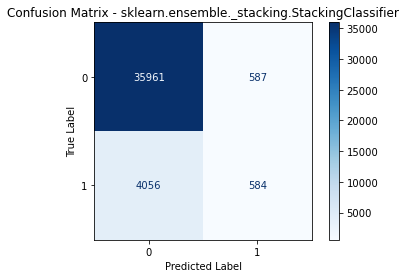

In [29]:
#train stacked model
stack_model = classifier_SKF(stack_model,X,y)

In [31]:
pred = stack_model.predict(X)

In [32]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     36548
           1       0.50      0.13      0.20      4640

    accuracy                           0.89     41188
   macro avg       0.70      0.55      0.57     41188
weighted avg       0.85      0.89      0.86     41188

